In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import os, pickle
from pose_class import Trajectory
import pdb
import pandas as pd

import random
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import pearsonr,spearmanr
from scipy.stats import f_oneway,levene
from scipy.stats import ttest_ind

from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')
print('ready set go!')

ready set go!


## Load Data

Data is a series of Sequence objects (generated by poseclass) and a bunch of playback data

In [4]:
## Load the hand annotated info on postures
test_3 = pd.read_csv('/data/birds/postures/presentation_info4.csv',delimiter=',')

song_list = ['BDY','BOD','ND','LB','2M','DBR','GRG','WG','LNR','DMG']
bird_list = ['CB-White','CB-Orange','CB-Yellow','CB-Red','CB-LB2','CB-Y2','CB-R2']
song_dict = dict(zip(song_list,range(10)))
bird_dict = dict(zip(bird_list,range(len(bird_list))))

duration_dict = {}
duration_list0 = []
latency_dict = {}
latency_list0 = []
seq_dir = './AllSeqs/'
bird_duration_dict = dict(zip(bird_list,[[] for x in range(len(bird_list))]))
bird_latency_dict = dict(zip(bird_list,[[] for x in range(len(bird_list))]))

for index,row in test_3.iterrows():
    if '2019' not in row['SeqName']:
        continue 
    try:
        s = row['SeqName']
        seq = pickle.load(open(seq_dir + s + '.obj','rb'))
        bird = row['Bird']
    except:
        #print(row['SeqName'],'is missing')
        s = row['SeqName']
        bird = row['Bird']
        seq = 0
        #print(row)


    if row['Song'] not in song_list:
        song = row['SeqName'].split('_')[-1]
        if song in song_list:
            test_3.at[index,'Song'] = song
        else:
            continue
    if not pd.isnull(row['PostureDuration']):
        if song not in duration_dict.keys():
            duration_dict[song] = []
        if row['PostureDuration'] == 'R':
            continue
        seq_duration = float(row['PostureDuration'])
        #test_3.at[index,'Duration by My Method'] = seq_duration
        duration_dict[song].append(seq_duration)
        duration_list0.append(seq_duration)
        bird_duration_dict[bird].append(seq_duration)
        
    ## If we have both latency and offset info, store it
    if not pd.isnull(row['PostureStamp']) and seq != 0:
        if song not in latency_dict.keys():
            latency_dict[song] = []
        seq_latency = float(row['PostureStamp']) + seq.ts[0]
        if seq.ts[0] == 0:
            #print('unknown offset...')
            #print(row['SeqName'])
            #print(seq_latency)
            seq_latency = np.nan
            continue
        test_3.at[index, 'Latency minus offset'] = seq_latency

        latency_dict[song].append(seq_latency)
        latency_list0.append(seq_latency)
        bird_latency_dict[bird].append(seq_latency)
                                       

In [5]:
## Define a little meta package for playback arrays

class Playback_meta():
    def __init__(self,n_birds,n_songs,n_blocks,bird_list,bird_dict,song_list,song_dict,name):
        self.n_birds = n_birds
        self.n_songs = n_songs
        self.n_blocks = n_blocks
        self.bird_list = bird_list
        self.bird_dict = bird_dict
        self.song_list = song_list
        self.song_dict = song_dict
        self.name = name
    
    def read_me(self):
        print('Reaout for group:',self.name)
        print('n_birds:',self.n_birds)
        print('n_songs:',self.n_songs)
        print('n_blocks:',self.n_blocks)
        print('birds:',self.bird_list)
        print('songs:',self.song_list)
 

In [108]:
## Import and process sequence data: [Bird, Block, Song, [Posture,Latency,Duration,Movement]]
## This also builds birdview_array


data_array = np.empty([7,14,10,4])
data_key = np.empty([7,14,10,3],dtype=object)
data_array.fill(np.nan)

count = 0 
t_count = 0
p_count = 0
good_list = sorted(os.listdir('./SeqClasses/'))
crap_list = sorted(os.listdir('./CrapSeqs/'))


#file_list = sorted(os.listdir('./SeqClasses/'))
file_lists = [good_list,crap_list]
dir_list = ['./SeqClasses/','./CrapSeqs/']
for f in range(2):
    file_list = file_lists[f]
    seq_dir = dir_list[f]
    for s in file_list:

        seq = pickle.load(open(seq_dir + s,'rb'))
        if '2018' in seq.seq_name:
            #print('still skipping 2018 for now')
            continue
        try:
            block = seq.block
        except:
            #print(seq.seq_name,'has no block somehow...')
            import pdb
            pdb.set_trace()
        if block < 0:
            block = 14
        if seq.bird=='no bird' or seq.bird=='males':
            continue
        if seq.bird=='unknown' or seq.song == 'unknown':
            continue
        try:
            song_index = song_dict[seq.song]
            bird_index = bird_dict[seq.bird]
        except:
            print(seq.seq_name,'broke something!')

        try:
            data_key[bird_index,int(block),song_index,0] = seq.seq_name
            data_key[bird_index,int(block),song_index,1] = seq.machine
            data_key[bird_index,int(block),song_index,2] = 1 ## This means it doesn't suck
            if 'Crap' in seq_dir:
                data_key[bird_index,int(block),song_index,2] = 0  ## This means it sucks
        except:
            print("Something Failed!")
        try:
            manual_row = test_3[test_3['SeqName'] == seq.seq_name]
            manual_posture = manual_row['Posture'].item()
            if not pd.isna(manual_posture):
                data_array[bird_index,int(block),song_index,0] = int(manual_posture)
            else:
                data_array[bird_index,int(block),song_index,0] = seq.posture
            if seq.ts[0] == 0:
                ## No timing data, grab a likely 5s 
                response_window = (seq.ts > 5) & (seq.ts < 10)
            else:
                response_window = (seq.ts > 0) & (seq.ts < 5)
            ## A bunch of them have a mismatch between ts and data. I need to fix this
            if len(response_window) != len(seq.data):
                #print('data mismatch :(')
                if len(response_window) > len(seq.data):
                    #print('fixing it...')
                    response_window = response_window[:len(seq.data)]
                elif len(response_window) < len(seq.data):
                    print('we are in trouble.')
                    pdb.set_trace()
            movement = np.sum(abs(seq.smooth_data[response_window]))
            data_array[bird_index,int(block),song_index,3] = movement
            #print('added posture')
            p_count +=1
        except:
            pdb.set_trace()
            print('posture failed...')
            pass
        try:
            manual_row = test_3[test_3['SeqName'] == seq.seq_name]
            manual_posture = manual_row['Posture'].item()
            if seq.ts[0] != 0:
                manual_latency = manual_row['PostureStamp'].item() + seq.ts[0]
            else:
                manual_latency = np.nan
            manual_duration = manual_row['PostureDuration'].item()
            if not pd.isna(manual_posture):
                posture_value = int(manual_posture)
            else:
                posture_value = seq.posture
            if not pd.isna(manual_latency):
                latency_value = float(manual_latency)
            else:
                latency_value = seq.t_vmax
            if not pd.isna(manual_duration):
                duration_value = float(manual_duration)
            else:
                duration_value = seq.duration

            data_array[bird_index,int(block),song_index] = [posture_value,latency_value,duration_value,movement]
            #print('Found a posture : ',seq.seq_name,seq.posture)
            t_count += 1
        except:
            #print('no timing data for',seq.seq_name,': moving on...')
            #import pdb
            #pdb.set_trace()
            pass
        if seq.seq_name == '2019-06-06-07-16-11_DMG':
            pdb.set_trace()

birdview_array = data_array[:,:,:,:3]
birdview_meta = Playback_meta(data_array.shape[0],data_array.shape[2],data_array.shape[1],
                          bird_list,bird_dict,song_list,song_dict,'Birdview')

print(p_count,t_count)    

675 163


In [12]:
## Reshape Birdview 3 data into similar array

group1_file = '/data/birds/postures/2019_playbacks_1.csv'
group2_file = '/data/birds/postures/2019_playbacks_2.csv'

group1_df = pd.read_csv(group1_file)
group2_df = pd.read_csv(group2_file)

group1_df = group1_df.fillna(0)
group2_df = group2_df.fillna(0)

p_array1 = np.array(group1_df.iloc[:,6:15])
p_array2 = np.array(group2_df.iloc[:,6:15])

group1_list = list(group1_df.columns[6:15])
group2_list = list(group2_df.columns[6:15])
bird_list3 = []
bird_list3.extend(group1_list)
bird_list3.extend(group2_list)

print(bird_list3)
## [Bird, Block, Song, [Posture,Latency,Duration]]
bv3_array = np.empty([18,11,10,3])
bv3_array.fill(np.nan)

group1_dates = group1_df
# for each song
for s in range(10):
    song_name = song_list[s] + '.wav'
    #print(s,song_name)
    bv3_array[:9,:,s,0] = np.transpose(group1_df.loc[group1_df['SongFile'] == song_name].iloc[:,6:15])
    bv3_array[9:,:,s,0] = np.transpose(group2_df.loc[group2_df['SongFile'] == song_name].iloc[:,6:15])

binary_array3 = np.array(bv3_array)
binary_array3[binary_array3 == .5] = 0

bv3_array[:,:,:,0][bv3_array[:,:,:,0] == .5] = 2
bv3_meta = Playback_meta(18,10,11,bird_list3,dict(zip(bird_list3,range(len(bird_list3)))),song_list,song_dict,'Birdracks')
print(np.shape(binary_array3))

['WH20', 'WH18', 'WH13', 'Wh14', 'WH17', 'GR11', 'WH15', 'WH23', 'WH12 (22)', 'BK24', 'WH19', 'WH16', 'WH24', 'BK21', 'LB20', 'BK17', 'GR13', 'WH22']
(18, 11, 10, 3)


In [13]:
## Deal with David's playback data: dave_array07,meta_d07 

skips = 0
def parse_dave_data(playback_df,name='?',plot_me=False,sort_me=True,add_song = 0):
    song_list = pd.unique(playback_df[3])
    bird_list = pd.unique(playback_df[4])
    n_songs = len(song_list)
    if add_song is not 0:
        n_songs = n_songs + add_song
        song_list = np.append(song_list,'?')
    n_birds = len(bird_list)
    last_block = np.max(pd.unique(playback_df[0]))
    n_blocks = (last_block + n_songs - 1) // n_songs +1
    song_dict = dict(zip(song_list,range(n_songs)))
    bird_dict = dict(zip(bird_list,range(n_birds)))

    playback_array = np.zeros([n_birds,n_blocks,n_songs,3])

    for i,row in playback_df.iterrows():
        bird_index = bird_dict[row[4]]
        song_index = song_dict[row[3]]
        block_index = (row[0] - 1) // n_songs
        if playback_array[bird_index,block_index,song_index,0] != 0:
            #print(playback_array[bird_index,song_index,block_index],(bird_index,song_index,block_index))
            #print('I already did this one!',row[0])
            global skips
            skips += 1 

        if row[5].upper() == 'R':
            playback_array[bird_index,block_index,song_index,0] = 2 # label as partial
            playback_array[bird_index,block_index,song_index,2] = 0 # remove old durations
            
        else:
            playback_array[bird_index,block_index,song_index,0] = 1 # label as posture
            playback_array[bird_index,block_index,song_index,2] = int(row[5]) #set duration


  
    reorder = np.argsort(np.mean(playback_array[:,:,:,0],axis=(0,2)))[::-1]
    if sort_me:
        playback_array = playback_array[:,reorder]
    
    if plot_me:
        fig,ax = plt.subplots()
        ax.imshow(np.mean(playback_array[:,:,:,0],0),cmap='viridis',vmax=1)
        ax.set_xlabel('Blocks')
        ax.set_ylabel('Song id')
        fig.show()
    meta_data = Playback_meta(n_birds,n_songs,n_blocks,bird_list,bird_dict,song_list,song_dict,name)
    return playback_array,meta_data

playbacks07 = './DavidPlaybacks/PB2007.txt'
playbacks09 = './DavidPlaybacks/PB2009.txt'
playbacks10 = './DavidPlaybacks/PB2010.txt'
playbacks11 = './DavidPlaybacks/PB2011.txt'

dave_df07 = pd.read_csv(playbacks07,delimiter=',',header=None)
dave_df09 = pd.read_csv(playbacks09,delimiter=',',header=None)
dave_df10 = pd.read_csv(playbacks10,delimiter=',',header=None)
dave_df11 = pd.read_csv(playbacks11,delimiter=',',header=None)

dave_array07,meta_d07 = parse_dave_data(dave_df07,name='Dave_07',plot_me=False)
dave_array09,meta_d09 = parse_dave_data(dave_df09,name='Dave_09',plot_me=False)
dave_array10,meta_d10 = parse_dave_data(dave_df10,name='Dave_10',plot_me=False)
dave_array11,meta_d11 = parse_dave_data(dave_df11,name='Dave_11',plot_me=False)
print('total skips=',skips)

daviaries = [dave_array07,dave_array09,dave_array10,dave_array11]
dmetas = [meta_d07,meta_d09,meta_d10,meta_d11]

all_aviaries = [birdview_array,bv3_array,dave_array07,dave_array09,dave_array10,dave_array11]
all_metas = [birdview_meta, bv3_meta, meta_d07,meta_d09,meta_d10,meta_d11]

total skips= 24


In [61]:
## Load in hand labeled latencies from spread sheet 
test_3.infer_objects()
bird_list = birdview_meta.bird_list
song_list = birdview_meta.song_list
bird_dict = birdview_meta.bird_dict
song_dict = birdview_meta.song_dict
startle_latencies = []
look_latencies = []
depuff_latencies = []
wingstroke_latencies = []
leg_latencies = []
poo_latencies = []
csd_latencies,csd_offsets = [],[]
partial_latencies,partial_offsets = [],[]
s_count,d_count,w_count,c_count,p_count,l_count,g_count,o_count,poo_count = 0,0,0,0,0,0,0,0,0
total_count,other_count = 0,0

bird_count_dict = dict(zip(bird_list,[[0,0,0,0,0,0,0,0,0,0] for f in bird_list]))

key_behaviors = ['Depuff','Wingstroke','CSD','Partial CSD']
## Build an array to get song rates for any behavior of interest
bird_song_counts = np.zeros([len(key_behaviors),len(bird_list),len(song_list),2])
## Big hard coded loop to parse values

for i,row in test_3.iterrows():
    if '2019' not in row['SeqName']:
        continue
    ## Need the seq for offset, if it doesn't exist just count it but no time
    try:
        seq = pickle.load(open('./AllSeqs/' + row['SeqName'] + '.obj','rb'))
    except:
        TIME = False
    ## Need a good offset, if that doesn't exist, count it, but no time
    if seq.ts[0] == 0:
        TIME = False
    else:
        TIME = True
    notes = str(row['Notes']).lower()
    response = False
    bird_name = row['Bird']
    song = row['Song']
    if bird_name not in bird_list:
        continue
    if song not in song_list:
        continue
    f = bird_dict[bird_name]
    s = song_dict[song]

    if 'startle' in notes:
        response=True
        s_count += 1
        bird_count_dict[bird_name][6] += 1
    if 'look' in notes:
        response=True
        l_count += 1
        bird_count_dict[bird_name][2] += 1
    if 'depress' in notes:
        response=True
        d_count += 1
        bird_count_dict[bird_name][5] += 1
        bird_song_counts[0,f,s,0] += 1
        if TIME: depuff_latencies.append(row['PuffStamp'] + seq.ts[0])
    if 'leg' in notes:
        response=True
        g_count += 1
        bird_count_dict[bird_name][4] += 1
    if 'wingstroke' in notes:
        response=True
        w_count += 1
        bird_count_dict[bird_name][3] += 1
        bird_song_counts[1,f,s,0] += 1
        if TIME: wingstroke_latencies.append(row['WingStamp'] + seq.ts[0])
    if 'poop' in notes:
        response=True
        poo_count += 1
        bird_count_dict[bird_name][7] += 1
    if not pd.isnull(row['Posture']) and int(row['Posture']) == 1:
        response=True
        c_count += 1
        bird_count_dict[bird_name][0] += 1
        bird_song_counts[2,f,s,0] += 1
        if TIME:
            csd_latencies.append(row['PostureStamp'] + seq.ts[0])
            csd_offsets.append(row['PostureStamp'] + seq.ts[0] + row['PostureDuration'])
    if not pd.isnull(row['Posture']) and int(row['Posture']) == 2:
        response=True
        p_count += 1
        bird_count_dict[bird_name][1] += 1
        bird_song_counts[3,f,s,0] += 1
        if TIME:
            partial_latencies.append(row['PartialStamp'] + seq.ts[0])
            partial_offsets.append(row['PartialStamp'] + seq.ts[0] + row['PartialDuration'])
    if not response:
        other_count +=1
        bird_count_dict[bird_name][8] += 1
    if 'missing' not in notes:
        bird_song_counts[:,f,s,1] += 1
        total_count +=1

all_counts = [s_count,d_count,w_count,c_count,p_count,l_count,g_count,o_count,poo_count]
all_latencies = [startle_latencies,depuff_latencies,wingstroke_latencies,csd_latencies,partial_latencies,
              look_latencies,leg_latencies,[np.nan],poo_latencies]

all_labels = ['Startle','Depuff','Wingstroke','CSD','Partial-CSD','Look Around','Leg Adjustment',
              'Other/None','Poop']
count_dict = dict(zip(all_labels,all_counts))
latency_dict = dict(zip(all_labels,all_latencies))

0
0
0
0
nan
nan
nan
nan


# Figures Start here!

### Figure 2:
What behaviors do females produce in response to song? 

534


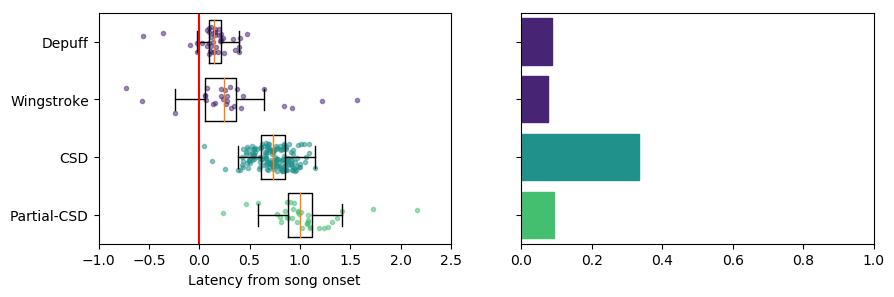

In [52]:
## Plot Figure 2a using above values
plt.style.use('default')
fig,(ax,ax1) = plt.subplots(1,2,sharey=True)
paper_cmap = cm.viridis
good_labels = ['Depuff','Wingstroke','CSD','Partial-CSD']
color_values = [.1,.1,.5,.7]
group_colors = [paper_cmap(c) for c in color_values]
for l in range(len(good_labels)):
    label = good_labels[l]
    xs = np.array(latency_dict[label])
    xs = xs[~np.isnan(xs)]
    ys = [len(good_labels) - l] * len(xs)
    jitter = np.random.rand(len(xs)) - .5 
    ys = np.array(ys) + jitter * .5
    ax.scatter(xs,ys,alpha=.5,marker='.',color=group_colors[l])
    ax.boxplot(xs,positions=[len(good_labels) - l],vert=False,showfliers=False,widths=[.75])

ax.axvline(0,color='red')
ax.set_yticks(range(1,len(good_labels)+1))
ax.set_yticklabels(good_labels[::-1])

ax.set_xlabel('Latency from song onset')
ax.set_xlim([-1,2.5])
ax.set_ylim([0.5,4.5])

print(total_count)
bars = ax1.barh([1,2,3,4],[count_dict[l] / total_count for l in good_labels[::-1]])
for b in range(len(bars)):
    bars[b].set_color(group_colors[::-1][b])
ax1.set_xlim([0,1])
fig.set_size_inches(10,3)
fig.show()



In [99]:
## Stats for above figures

## Difference in latencies: 
## a bit clunky to do all these in one line
latency_lists = [np.array(latency_dict[l])[~np.isnan(np.array(latency_dict[l]))] for l in good_labels]
groups = [[good_labels[l]] * len(latency_lists[l]) for l in range(len(good_labels))]

flat_list = [item for sublist in latency_lists for item in sublist]
flat_groups = [item for sublist in groups for item in sublist]
#print(flat_groups)
f_stat, p_value =f_oneway(*latency_lists)
print(np.round(f_stat,5),p_value)
print(pairwise_tukeyhsd(flat_list,flat_groups))

## We can do this as t-test too, but the result is the same
for l in range(len(good_labels) - 1):
    continue
    print(good_labels[l],'vs',good_labels[l+1])
    print(ttest_ind(latency_lists[l],latency_lists[l+1]))
"""
## We might want to use a two sided anova, but hopefully they'll let that slide, the code is much harder
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, latency_df).fit()
aov_table = anova_lm(model, typ=2)

eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table.round(4))"""
pass

23.60317 2.20721681701578e-13
   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower   upper  reject
-------------------------------------------------------
    CSD        Depuff   -0.6467  -0.9986 -0.2949  True 
    CSD     Partial-CSD  0.4065   0.0723  0.7407  True 
    CSD      Wingstroke -0.8361  -1.2161  -0.456  True 
   Depuff   Partial-CSD  1.0533   0.6128  1.4937  True 
   Depuff    Wingstroke -0.1893  -0.6655  0.2869 False 
Partial-CSD  Wingstroke -1.2426  -1.7059 -0.7793  True 
-------------------------------------------------------


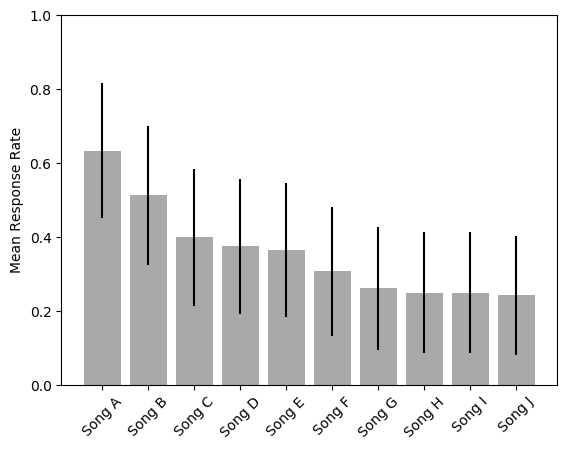

In [100]:
## Plot Fig 2b
birdview_binary = np.array(birdview_array)
birdview_binary[birdview_binary == 2] = 0

means_birdview = np.nanmean(birdview_binary[:,:,:,0],axis=(0,1))
sorted_order = means_birdview.argsort()[::-1]


std_birdview = np.nanstd(birdview_binary[:,:,:,0],axis=(0,1))
sem_birdview = std_birdview / np.sqrt(birdview_meta.n_birds)
fig,ax = plt.subplots()
ax.bar(range(len(means_birdview)),means_birdview[sorted_order],yerr=sem_birdview[sorted_order],color='darkgray')

ax.set_ylim([0,1])
ax.set_xticks(range(10))
ax.set_xticklabels(['Song A','Song B','Song C','Song D','Song E','Song F','Song G','Song H','Song I','Song J'],rotation=45)

ax.set_ylabel('Mean Response Rate')

#print(spearmanr(means_birdview,range(10)))
fig.show()

In [105]:
## Stats for different groups:

## R2 has no postures

## Get numbers of songs per bird (or rate per bird...rate per bird)
#print(bird_song_counts[:,0,:,:])
song_rates_by_bird = np.zeros([birdview_meta.n_birds,birdview_meta.n_songs])
for f in range(birdview_meta.n_birds):
    for s in range(birdview_meta.n_songs):
        song_rates_by_bird[f,s] = np.nanmean(birdview_binary[f,:,s,0])
#print(song_rates_by_bird)
song_rates_by_song = np.transpose(song_rates_by_bird[:-1])
#print(song_rates_by_song)
#print(f_oneway(*song_rates_by_song))
for b in range(len(key_behaviors)):
    print('-Is there song bias in ',key_behaviors[b],':')
    bird_song_rates = np.empty([birdview_meta.n_birds,birdview_meta.n_songs])
    bird_song_rates.fill(np.nan)
    for f in range(birdview_meta.n_birds):  
        if np.sum(bird_song_counts[b,f,:,0]) == 0:
            continue
        bird_song_rates[f,:] = np.divide(bird_song_counts[b,f,:,0],bird_song_counts[b,f,:,1])
        #print(bird_song_rates[f,:])
    song_rates_list = [list(bird_song_rates[:,s][~np.isnan(bird_song_rates[:,s])]) for s in range(birdview_meta.n_songs)]

    f_stat,p_value = f_oneway(*song_rates_list)
    print('  f_oneway:',np.round(f_stat,3),p_value)
    #print(bird_song_rates,np.nanmean(bird_song_rates,0))
    r_stat,P_value = pearsonr(np.nanmean(birdview_binary[:,:,:,0],axis=(0,1)),np.nanmean(bird_song_rates,0))
    print('  pearsons correlation with potency:',np.round(r_stat,3),p_value)
    if False:
        fig,ax = plt.subplots()
        ax.bar(np.arange(10),np.nanmean(bird_song_rates,0)[sorted_order],yerr=np.nanstd(bird_song_rates,0)[sorted_order] / np.sqrt(len(bird_list)))
        ax.set_ylim([0,1])
        ax.set_title(key_behaviors[b])
        fig.show()



-Is there song bias in  Depuff :
  f_oneway: 0.5 0.868553824354545
  pearsons correlation with potency: 0.607 0.868553824354545
-Is there song bias in  Wingstroke :
  f_oneway: 0.681 0.7210128706508944
  pearsons correlation with potency: -0.076 0.7210128706508944
-Is there song bias in  CSD :
  f_oneway: 1.901 0.07333612528187666
  pearsons correlation with potency: 0.976 0.07333612528187666
-Is there song bias in  Partial CSD :
  f_oneway: 0.396 0.931162816995719
  pearsons correlation with potency: 0.279 0.931162816995719


## Figure 3

waveforms are done by hand, I'm not a machine

In [114]:
print(bird_list)

['CB-White', 'CB-Orange', 'CB-Yellow', 'CB-Red', 'CB-LB2', 'CB-Y2', 'CB-R2']


['CB-Orange', 'CB-LB2', 'CB-Y2', 'CB-Yellow']
Latencies: 0.7688688605730649 0.3344930428225923
Durations: 4.02436065478403 2.437093821760373


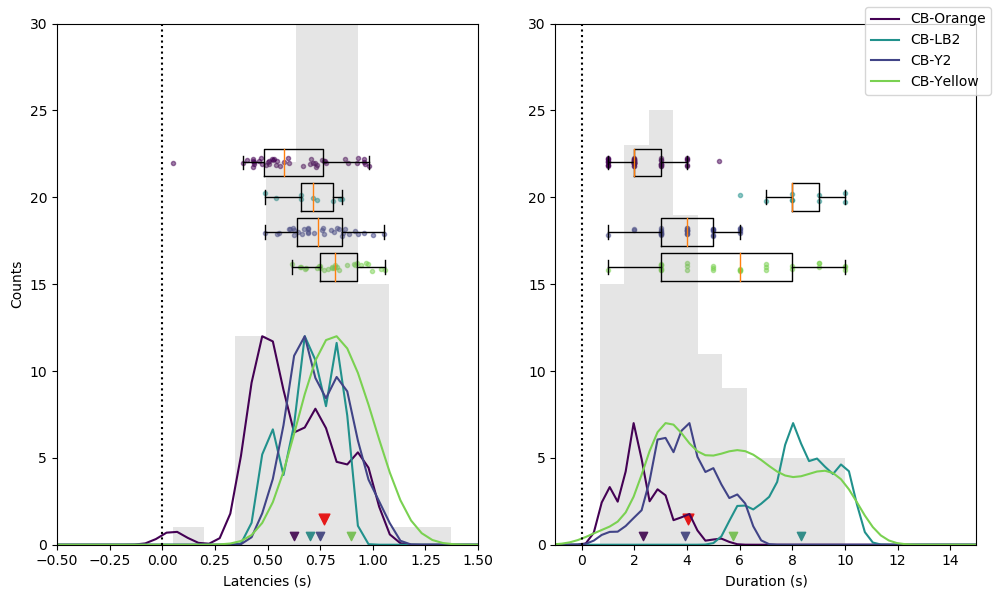

In [353]:
## Make data and plot figure3, Get durations,latencies by bird: 
song_list = ['BDY','BOD','ND','LB','2M','DBR','GRG','WG','LNR','DMG']
plot_bird_list = ['CB-Orange','CB-LB2','CB-Y2','CB-Yellow']
plot_bird_indices = [1,2,4,5]

bird_color_values = [.25,0,0.5,.7,.2,.8,.4]
bird_colors = [paper_cmap(v) for v in bird_color_values]
base_h = 16

print(plot_bird_list)
n_birds = len(plot_bird_list)

durations = np.array(data_array[:,:,:,2])
durations[data_key[:,:,:,2] == 0] = np.nan
good_durations = durations[~np.isnan(durations)]

latencies = np.array(data_array[:,:,:,1])
latencies[data_key[:,:,:,2] == 0] = np.nan
good_latencies = latencies[~np.isnan(latencies)]

bird_durations = [np.nan] * n_birds
bird_latencies = [np.nan] * n_birds

## Get durations and latencies by bird
for i in range(n_birds):
    bird_name = plot_bird_list[i]
    n = bird_dict[bird_name]
    p_indices = np.logical_and(~np.isnan(data_array[n,:,:,2]),data_array[n,:,:,0] == 1)
    crap_indices = data_key[n,:,:,2] == 0
    bird_durations[i] = data_array[n,:,:,2][np.logical_and(p_indices,~crap_indices)]
    bird_latencies[i] = data_array[n,:,:,1][np.logical_and(p_indices,~crap_indices)]

#print('****',bird_latencies)
#print('**',bird_durations)

fig,(ax1,ax2) = plt.subplots(1,2)


dur_heights = np.arange(base_h,base_h+n_birds * 2,2)[::-1]
lat_heights = np.arange(base_h,base_h+n_birds * 2,2)[::-1]
dur_widths = [1.6] * n_birds

for s in range(n_birds):
    i = plot_bird_indices[s]
    ys_dur = np.array([dur_heights[s]] * len(bird_durations[s]))
    ys_lat = np.array([lat_heights[s]] * len(bird_durations[s]))
                      
    jitter_dur = (np.random.rand(len(ys_dur)) - .5) * .5
    jitter_lat = (np.random.rand(len(ys_lat)) - .5) * .5

    ys_dur = ys_dur + jitter_dur
    ys_lat = ys_lat + jitter_lat
    ax2.scatter(bird_durations[s],ys_dur,alpha=.5,marker='.',color=bird_colors[i])
    ax1.scatter(bird_latencies[s],ys_lat,alpha=.5,marker='.',color=bird_colors[i])

    mark_h = .5
    ax1.scatter(np.nanmean(bird_latencies[s]),mark_h,marker='v',color=bird_colors[i])
    ax2.scatter(np.nanmean(bird_durations[s]),mark_h,marker='v',color=bird_colors[i])


ax2.boxplot(bird_durations,positions=dur_heights,vert=False,widths=dur_widths,showfliers=False)
ax1.boxplot(bird_latencies,positions=lat_heights,vert=False,widths=dur_widths,showfliers=False)

dur_xs = np.linspace(-5,25,100)    
lat_xs = np.linspace(-2,3,100)
ax1.scatter(np.nanmean(good_latencies),mark_h *3,marker='v',color='red',s=60)
ax2.scatter(np.nanmean(good_durations),mark_h *3,marker='v',color='red',s=60)

ax1.hist(good_latencies,bins=20,color='gray',alpha=.2)
ax2.hist(good_durations,bins=10,color='gray',alpha=.2)


for b in range(n_birds):
    #y,x,_ = ax2.hist(bird_durations[b],bins=10,alpha=.2)
    #lat_y,lat_x,_ = ax1.hist(bird_latencies[b],bins=20,alpha=.2)
    i = plot_bird_indices[b]
    if len(bird_latencies[b]) > 1:
        dur_curve = gaussian_kde(bird_durations[b],bw_method=.3)
        ax2.plot(dur_xs,dur_curve(dur_xs) * max(y) / max(dur_curve(dur_xs)),color=bird_colors[i],label=plot_bird_list[b])
        lat_curve = gaussian_kde(bird_latencies[b],bw_method=.3)
        ax1.plot(lat_xs,lat_curve(lat_xs) * max(lat_y) / max(lat_curve(lat_xs)),color=bird_colors[i])

ax1.set_xlim([-.5,1.5])       
ax1.set_ylim([0,30])  
ax2.set_xlim([-1,15])
ax2.set_ylim(0,30)

ax1.set_yticks(np.arange(0,35,5))
ax1.set_yticklabels(np.arange(0,35,5))

ax2.set_yticks(np.arange(0,35,5))
ax2.set_yticklabels(np.arange(0,35,5))

ax1.set_ylabel('Counts')
ax2.set_ylabel('   ')
ax2.set_xlabel('Duration (s)')
ax1.set_xlabel('Latencies (s)')

ax1.axvline(0,linestyle=':',color='black')
ax2.axvline(0,linestyle=':',color='black')
fig.legend()

fig.set_size_inches(10,6)
fig.tight_layout()
fig.show()

print('Latencies:',np.mean(good_latencies),np.std(good_latencies))
print('Durations:',np.mean(good_durations),np.std(good_durations))
#fig.savefig('/home/ammon/Desktop/PaperFigs/5ab.png')
#fig.savefig('/home/ammon/Desktop/PaperFigs/5ab.svg')

In [19]:
print('Latency:',np.nanmean(good_latencies),np.nanstd(good_latencies))
print('Duration:',np.nanmean(good_durations),np.nanstd(good_durations))

Latency: 0.9715250146389008 0.5582786039291887
Duration: 4.019758331775665 2.439040726075788


In [358]:
##Test for whether birds are different. 

lats = []
durs = []
bird_ids = []
for b in range(len(bird_latencies)):

    lats.extend(bird_latencies[b])
    durs.extend(bird_durations[b])
    bird_ids.extend([b] * len(bird_latencies[b]))
    
print('Significant variation in latency (std is similar)')
print(f_oneway(*bird_latencies))
print(pairwise_tukeyhsd(lats,bird_ids))
print(levene(*bird_latencies))

print('\n\nSignificant variation in duration ')
print(f_oneway(*bird_durations))
print(pairwise_tukeyhsd(durs,bird_ids))
print(levene(*bird_durations))




Significant variation in latency (std is similar)
F_onewayResult(statistic=6.913086539586018, pvalue=0.00026431221484275166)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.074   -0.1647 0.3126 False 
  0      2     0.1254  -0.0267 0.2774 False 
  0      3     0.2711   0.1146 0.4275  True 
  1      2     0.0514  -0.1943 0.2971 False 
  1      3     0.1971  -0.0514 0.4456 False 
  2      3     0.1457  -0.0213 0.3126 False 
--------------------------------------------
LeveneResult(statistic=0.5297983686178419, pvalue=0.6627683435110883)


Significant variation in duration 
F_onewayResult(statistic=47.049314878955514, pvalue=1.3815419377217592e-19)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1     6.0261   4.4568  7.5954  True 
  0      2     1.6303   0.6308  2.6298  True 
 

In [137]:
## Build posture_df to do duration latency mixed linear regression
file_list = good_list
seq_dir = dir_list[0]

binary_array = birdview_binary
#binary_array[binary_array[:,:,:,0] == 2] = 0

song_list = birdview_meta.song_list
bird_list = birdview_meta.bird_list
posture_df = pd.DataFrame(columns=['Bird','Song','Block','RelPotency','AvgPotency','Latency','Duration'],index=range(146))
song_list_i = range(len(song_list))
bird_list_i = range(len(bird_list))

song_potency = dict(zip(song_list,np.nanmean(binary_array[:,:,:,0],axis=(0,1))))

relative_potency = {}
for b in range(len(bird_list)):
    relative_potency[bird_list[b]] = dict(zip(song_list,np.nanmean(binary_array[b,:,:,0],axis=0)))

count = 0
for s in file_list:
    seq = pickle.load(open(seq_dir + s,'rb'))
    if seq.offset == 0 or seq.posture != 1:
        continue
    manual_row = test_3[test_3['SeqName'] == seq.seq_name]
    
    true_duration = manual_row['PostureDuration'].item()
    true_latency = manual_row['PostureStamp'].item() + seq.ts[0]

    #print(true_duration,true_latency)

    posture_df.loc[count] = [bird_dict[seq.bird],song_dict[seq.song],seq.block,relative_potency[seq.bird][seq.song],song_potency[seq.song],true_latency,true_duration]
    count += 1
    
    
#print(count)
posture_df = posture_df.infer_objects()

In [364]:
## Trim df and run mixed regression on duration and latency
trimmed_df = posture_df.dropna()
#print(trimmed_df)

md_lat = smf.mixedlm("Latency ~ RelPotency",data=trimmed_df,groups=trimmed_df["Bird"])
mdf_lat = md_lat.fit()
print(mdf_lat.summary())

md_dur = smf.mixedlm("Duration ~ RelPotency",data=trimmed_df,groups=trimmed_df["Bird"])
mdf_dur = md_dur.fit()
print(mdf_dur.summary())

md = smf.mixedlm("Latency ~ Duration",data=trimmed_df,groups=trimmed_df["Bird"])
mdf = md.fit()
print(mdf.summary())


        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Latency
No. Observations: 134     Method:             REML   
No. Groups:       4       Scale:              0.0406 
Min. group size:  10      Likelihood:         18.3298
Max. group size:  49      Converged:          No     
Mean group size:  33.5                               
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.804    0.076 10.603 0.000  0.656  0.953
RelPotency -0.113    0.103 -1.098 0.272 -0.315  0.089
Group Var   0.007    0.028                           

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Duration 
No. Observations: 134     Method:             REML     
No. Groups:       4       Scale:              2.3695   
Min. group size:  10      Likelihood:         -253.7796
Max. group size:  49      Converge

In [211]:
## Get some values, I should be able to pull these out from the object but I don't know how.
intercept_l,effect_l,variance_l =  mdf_lat.params
il_high,il_low = .953,0.659
el_high,el_low = 0.089,-0.315

intercept_d,effect_d,variance_d =  mdf_dur.params
id_high,id_low = 8.012,2.694
ed_high,ed_low = .959,-2.225

dur_line = np.poly1d([effect_d,intercept_d])
low_dur = np.poly1d([ed_low,id_low])
high_dur = np.poly1d([ed_high,id_high])

lat_line = np.poly1d([effect_l,intercept_l])
low_lat = np.poly1d([el_low,il_low])
high_lat = np.poly1d([el_high,il_high])
"""
fig,(ax,ax1) = plt.subplots(2)
ax.plot([0,1],lat_line([0,1]),color='black',linestyle=':')
ax.plot([0,1],low_lat([0,1]),color='black')
ax.plot([0,1],high_lat([0,1]),color='black')
ax.fill_between([0,1],high_lat([0,1]),low_lat([0,1]),color='gray',alpha=.3)

ax1.plot([0,1],dur_line([0,1]),color='black',linestyle=':')
ax1.plot([0,1],low_dur([0,1]),color='black')
ax1.plot([0,1],high_dur([0,1]),color='black')
ax1.fill_between([0,1],high_dur([0,1]),low_dur([0,1]),color='gray',alpha=.3)
fig.show()"""
pass

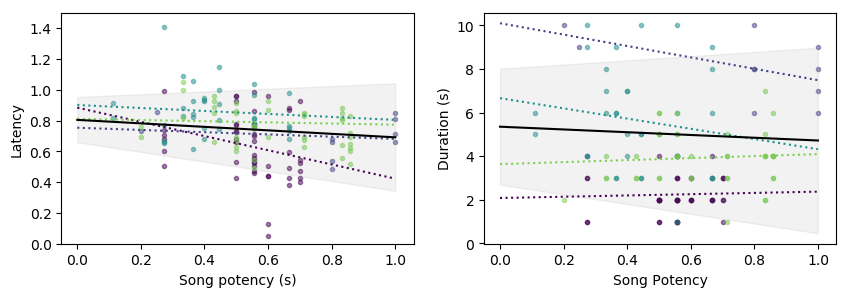

In [362]:
## Plot by individual and overall
fig,(ax,ax1) = plt.subplots(1,2)
bird_list = birdview_meta.bird_list

birds_to_plot = [1,2,4,5]

for f in birds_to_plot:
    bird_df = posture_df[posture_df['Bird'] == f]
    xs = np.array(bird_df['RelPotency'])
    ys = np.array(bird_df['Duration'])
    xs_lat = np.array(bird_df['RelPotency'])
    ys_lat = np.array(bird_df['Latency'])
    xs = xs[~np.isnan(ys)]
    ys = ys[~np.isnan(ys)]
    xs_lat = xs_lat[~np.isnan(ys_lat)]
    ys_lat = ys_lat[~np.isnan(ys_lat)]
    ax1.scatter(xs,ys,marker='.',alpha=.5,color=bird_colors[f])
    ax.scatter(xs_lat,ys_lat,marker='.',alpha=.5,color=bird_colors[f])
    if len(xs) > 0:
        fit_line = np.poly1d(np.polyfit(xs,ys,1))
        ax1.plot([0,1],fit_line([0,1]),linestyle=':',label='Bird ' + str(f),color=bird_colors[f])
    if len(xs_lat) > 0:
        fit_line = np.poly1d(np.polyfit(xs_lat,ys_lat,1))
        ax.plot([0,1],fit_line([0,1]),linestyle=':',color=bird_colors[f])

    # I'm plotting duration with respect to relative potency
ax.plot([0,1],lat_line([0,1]),color='black')
#ax.plot([0,1],low_lat([0,1]),color='black')
#ax.plot([0,1],high_lat([0,1]),color='black')
ax.fill_between([0,1],high_lat([0,1]),low_lat([0,1]),color='gray',alpha=.1)

ax1.plot([0,1],dur_line([0,1]),color='black')
#ax1.plot([0,1],low_dur([0,1]),color='black')
#ax1.plot([0,1],high_dur([0,1]),color='black')
ax1.fill_between([0,1],high_dur([0,1]),low_dur([0,1]),color='gray',alpha=.1)

ax.set_xlabel('Song potency (s)')
ax.set_ylabel('Latency')
ax.set_ylim([0,1.5])

ax1.set_xlabel('Song Potency')
ax1.set_ylabel('Duration (s)')
#fig.legend()
fig.set_size_inches([10,3])
fig.show()

## Figure 3
Relating shape to potency (or not)

(7, 14, 10, 3)
[0.63414634 0.25       0.51282051 0.26190476 0.36585366 0.24242424
 0.375      0.4        0.30769231 0.25      ]
{'BDY': 0, 'BOD': 1, 'ND': 2, 'LB': 3, '2M': 4, 'DBR': 5, 'GRG': 6, 'WG': 7, 'LNR': 8, 'DMG': 9}
{'CB-White': 0, 'CB-Orange': 1, 'CB-Yellow': 2, 'CB-Red': 3, 'CB-LB2': 4, 'CB-Y2': 5, 'CB-R2': 6}
skpping: 0.0
skpping: 0.0
skpping: 0.0
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxVelocity
No. Observations: 143     Method:             REML       
No. Groups:       4       Scale:              0.0000     
Min. group size:  10      Likelihood:         722.8221   
Max. group size:  53      Converged:          Yes        
Mean group size:  35.8                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.004    0.001  4.265 0.000  0.002  0.006
RelPotency

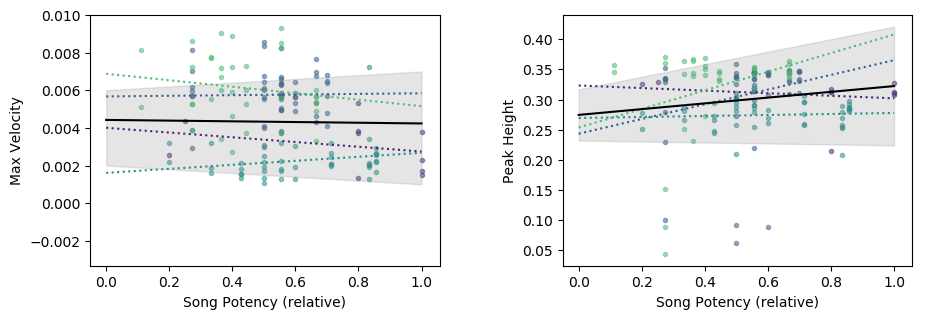

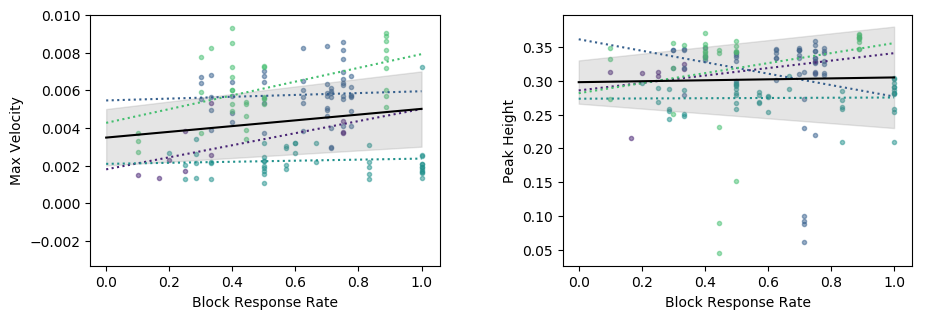

In [284]:
# This links to figure 7, in fact a lot of these plots are for that
# Seq height and vmax are easy enough, and song potency is easy peasy, just build the df, make a plot, done

print(birdview_array.shape)
vmax_list,peak_list = [],[]
r_list,f_list = [],[]
pot_list,rpot_list = [],[]
song_potency = np.nanmean(birdview_binary[:,:,:,0],axis=(0,1))
print(song_potency)
#song_potency = song_potency[np.argsort(song_potency)[::-1]]
#print(song_potency)
print(birdview_meta.song_dict)
print(birdview_meta.bird_dict)
rpot_dict = {}
rpot_list = []

bcor_dict = {
    'CB-LB2':.1,
    'CB-Orange':.3,
    'CB-Y2':.5,
    'CB-Yellow':.7
}

for b in range(len(birdview_meta.bird_list)):
    bird = birdview_meta.bird_list[b]
    rpot_dict[bird] = np.nanmean(birdview_binary[b,:,:,0],axis=0)
for i,row in test_3.iterrows():
    if '2019' not in row['SeqName']:
        continue
    try:
        seq = pickle.load(open('./AllSeqs/' + row['SeqName'] + '.obj','rb'))
    except:
        continue
    if seq.posture != 1 or seq.offset == 0:
        continue
    bird_index = birdview_meta.bird_dict[seq.bird]
    block_index = int(seq.block)
    song_index = birdview_meta.song_dict[seq.song]
    response_rate = np.nanmean(birdview_binary[bird_index,block_index,:,0])
    if np.isnan(response_rate) or response_rate == 0:
        print('skpping:',response_rate)
        continue
    r_list.append(response_rate) 
    f_list.append(seq.bird)
    vmax_list.append(seq.vmax)
    peak_list.append(seq.peak_height)
    pot_list.append(song_potency[song_index])    
    rpot_list.append(rpot_dict[seq.bird][song_index])

shape_df = pd.DataFrame({'Potency':pot_list,
             'RelPotency':rpot_list,
             'ResponseRate':r_list,
             'MaxVelocity':vmax_list,
             'PeakHeight':peak_list,
             'Female':f_list})


md = smf.mixedlm("MaxVelocity ~ RelPotency",data=shape_df,groups=shape_df['Female'])
mdf = md.fit()
print(mdf.summary())

md = smf.mixedlm("PeakHeight ~ RelPotency",data=shape_df,groups=shape_df['Female'])
mdf1 = md.fit()
print(mdf1.summary())

md = smf.mixedlm("MaxVelocity ~ ResponseRate",data=shape_df,groups=shape_df['Female'])
mdf2 = md.fit()
print(mdf2.summary())

md = smf.mixedlm("PeakHeight ~ ResponseRate",data=shape_df,groups=shape_df['Female'])
mdf3 = md.fit()
print(mdf3.summary())



fig,(ax,ax1) = plt.subplots(1,2)

fig2,(ax2,ax3) = plt.subplots(1,2)

e_alpha = .2
for f in range(len(np.unique(f_list))):
    female = np.unique(f_list)[f]
    female_df = shape_df[shape_df['Female'] == female]
    vs = female_df['MaxVelocity']
    rs = female_df['ResponseRate']
    ps = female_df['PeakHeight']
    ss = female_df['RelPotency']
    
    ## Plot velocity vs potency
    ax.scatter(ss,vs,marker='.',alpha=.5,color=cm.viridis(bcor_dict[female]))
    fit_line = np.poly1d(np.polyfit(ss,vs,1))
    ax.plot([0,1],fit_line([0,1]),color=cm.viridis(bcor_dict[female]),linestyle=':')
    ax.set_xlabel('Song Potency (relative)')
    ax.set_ylabel('Max Velocity')
    
    ## Plot peak vs potency
    ax1.scatter(ss,ps,marker='.',alpha=.5,color=cm.viridis(bcor_dict[female]))
    fit_line = np.poly1d(np.polyfit(ss,ps,1))
    ax1.plot([0,1],fit_line([0,1]),color=cm.viridis(bcor_dict[female]),linestyle=':')
    ax1.set_xlabel('Song Potency (relative)')
    ax1.set_ylabel('Peak Height')
    
    ## Plot velocity vs response rate
    ax2.scatter(rs,vs,marker='.',alpha=.5,color=cm.viridis(bcor_dict[female]))
    fit_line = np.poly1d(np.polyfit(rs,vs,1))
    ax2.plot([0,1],fit_line([0,1]),color=cm.viridis(bcor_dict[female]),linestyle=':')
    ax2.set_xlabel('Block Response Rate')
    ax2.set_ylabel('Max Velocity')
    
    ## Plot peak vs response rate
    ax3.scatter(rs,ps,marker='.',alpha=.5,color=cm.viridis(bcor_dict[female]))
    fit_line = np.poly1d(np.polyfit(rs,ps,1))
    ax3.plot([0,1],fit_line([0,1]),color=cm.viridis(bcor_dict[female]),linestyle=':')
    ax3.set_xlabel('Block Response Rate')
    ax3.set_ylabel('Peak Height')

fig.tight_layout()
fig2.tight_layout()
fig.set_size_inches([10,3])
fig2.set_size_inches([10,3])
fig.show()
fig2.show()

#vmax_pot
intercept,effect,_ = mdf.params
int_low,int_high = [0.002,0.006]
eff_low,eff_high = [-0.001,0.001]

fit_line = np.poly1d([effect,intercept])
low_line = np.poly1d([eff_low,int_low])
high_line = np.poly1d([eff_high,int_high])

ax.plot([0,1],fit_line([0,1]),color='black')
ax.fill_between([0,1],high_line([0,1]),low_line([0,1]),color='gray',alpha=e_alpha)

#height_pot
intercept,effect,_ = mdf1.params
int_low,int_high = [0.232,0.317]
eff_low,eff_high = [-0.008,0.104]

fit_line = np.poly1d([effect,intercept])
low_line = np.poly1d([eff_low,int_low])
high_line = np.poly1d([eff_high,int_high])

ax1.plot([0,1],fit_line([0,1]),color='black')
ax1.fill_between([0,1],high_line([0,1]),low_line([0,1]),color='gray',alpha=e_alpha)

#vmax_rate
intercept,effect,_ = mdf2.params
int_low,int_high = [0.002,0.005]
eff_low,eff_high = [0.001,0.002]

fit_line = np.poly1d([effect,intercept])
low_line = np.poly1d([eff_low,int_low])
high_line = np.poly1d([eff_high,int_high])

ax2.plot([0,1],fit_line([0,1]),color='black')
ax2.fill_between([0,1],high_line([0,1]),low_line([0,1]),color='gray',alpha=e_alpha)

#height_rate
intercept,effect,_ = mdf3.params
int_low,int_high = [0.266,0.330]
eff_low,eff_high = [-0.036,0.050]

fit_line = np.poly1d([effect,intercept])
low_line = np.poly1d([eff_low,int_low])
high_line = np.poly1d([eff_high,int_high])

ax3.plot([0,1],fit_line([0,1]),color='black')
ax3.fill_between([0,1],high_line([0,1]),low_line([0,1]),color='gray',alpha=e_alpha)


## Figure 5
Does selectivity change? (Fig 4 is a drawing)

(18, 11, 10)
[False False  True  True  True  True False  True False  True  True  True
  True False  True False  True  True]
(11, 10)


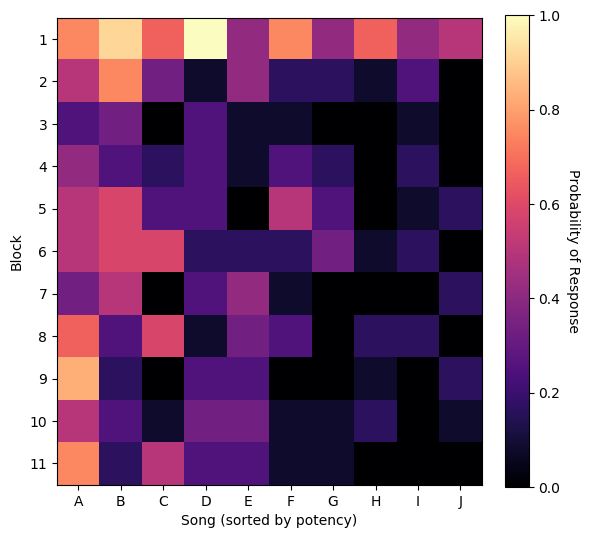

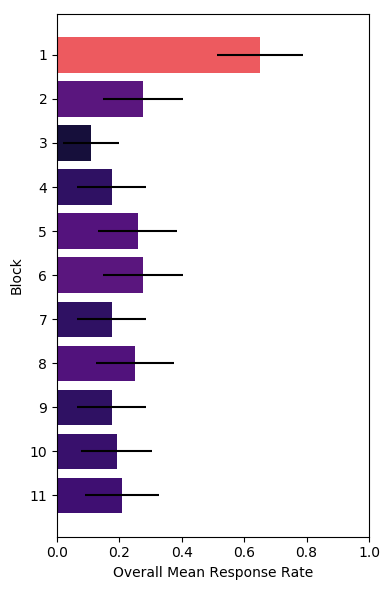

In [366]:
## Plot example plots for fig 5: 

#plt.style.use('dark_background')

daviary = all_aviaries[1][:,:,:,0]
n_blocks = daviary.shape[1]
song_order = np.argsort(np.nanmean(daviary,axis=(0,1)))[::-1]
n_birds = daviary.shape[0]
print(daviary.shape)
active_birds = np.nanmean(daviary,axis=(1,2)) > .05
print(active_birds)
heat_map = np.nanmean(daviary[active_birds,:][:,:,song_order],axis=(0))
print(heat_map.shape)
fig,ax= plt.subplots()
block_map = ax.imshow(heat_map,vmax=1.0,vmin=0,cmap='magma')
ax.set_xlabel('Song (sorted by potency)')
ax.set_ylabel('Block')
#ax.set_title('Response rate (averaged across birds)\n')

#print(heat_map)
ax.set_xticks(np.arange(heat_map.shape[1]))
ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])

ax.set_yticks(np.arange(heat_map.shape[0]))
ax.set_yticklabels(np.arange(1,heat_map.shape[0] + 1))
cbar = fig.colorbar(block_map,ax=ax,fraction=0.05)
cbar.ax.set_ylabel('Probability of Response', rotation=-90, va="bottom")
fig.set_size_inches([6,6])
fig.tight_layout()
fig.savefig('./figures/resp_rate_heatmap_dark.png',dpi=300)
fig.show()

fig1,ax1 = plt.subplots()
bar_std = np.nanstd(daviary[active_birds],axis=(0,2)) / np.sqrt(active_birds.sum())
bar_mean = np.nanmean(daviary[active_birds],axis=(0,2))
#print(bar_mean,bar_std)
song_std = np.nanstd(daviary[active_birds],axis=(0,1)) / np.sqrt(active_birds.sum())
song_mean = np.nanmean(daviary[active_birds],axis=(0,1))

ax1.barh(np.arange(1,1+n_blocks)[::-1],bar_mean,xerr=bar_std,color=cm.magma(bar_mean),ecolor='black')
ax1.set_yticks(range(1,1+n_blocks))
ax1.set_yticklabels(np.arange(1,1+n_blocks)[::-1])
ax1.set_ylabel('Block')
ax1.set_xlabel('Overall Mean Response Rate')
#ax1.set_title('General response rate changes over playbacks')
ax1.set_xlim([0,1])
fig1.set_size_inches(4,6)
fig1.tight_layout()
fig1.savefig('./figures/resp_rate_bars_dark.png',dpi=300)
fig1.show()

#fig2,ax2 = plt.subplots()

#song_order = np.argsort(song_mean)[::-1]
"""
ax2.bar(['A','B','C','D','E','F','G','H','I','J'],song_mean[song_order],yerr=song_std[song_order],color=cm.magma(song_mean[song_order] + .2),ecolor='white')
ax2.set_ylim([0,1])
ax2.set_ylabel('Response Rate')
ax2.set_xlabel('Song')
fig2.set_size_inches(6,4)
fig2.tight_layout()
fig2.show()
fig2.savefig('./figures/Song_response_rate_dark.png',dip=300)"""
pass

In [379]:
## Some stats for above plots: 

print(f_oneway(*heat_map))
groups = np.array([[n] * 10 for n in range(11)])

print(pairwise_tukeyhsd(heat_map.flatten(),groups.flatten()))

F_onewayResult(statistic=4.930488012242818, pvalue=8.987619672997738e-06)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1     -0.375  -0.6743 -0.0757  True 
  0      2    -0.5417   -0.841 -0.2424  True 
  0      3     -0.475  -0.7743 -0.1757  True 
  0      4    -0.3917   -0.691 -0.0924  True 
  0      5     -0.375  -0.6743 -0.0757  True 
  0      6     -0.475  -0.7743 -0.1757  True 
  0      7      -0.4   -0.6993 -0.1007  True 
  0      8     -0.475  -0.7743 -0.1757  True 
  0      9    -0.4583  -0.7576  -0.159  True 
  0      10   -0.4417   -0.741 -0.1424  True 
  1      2    -0.1667   -0.466  0.1326 False 
  1      3      -0.1   -0.3993  0.1993 False 
  1      4    -0.0167   -0.316  0.2826 False 
  1      5      0.0    -0.2993  0.2993 False 
  1      6      -0.1   -0.3993  0.1993 False 
  1      7     -0.025  -0.3243  0.2743 False 
  1      8      -0.1   -0.3993  0.1993 False 
 

(18, 11, 10, 3)
(15, 7, 10)
(0.7895781754903136, 8.98822021781546e-15)


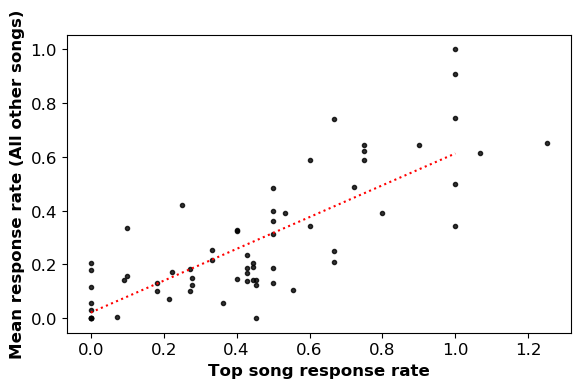

In [900]:
# Calculate and plot Fig 5c
#plt.style.use('default')
#plt.style.use('dark_background')

levene([1,0,1,0,1,0,1,0,1],[1,1,1,1,1,1,1,1,1])
print(binary_array3.shape)
print(daviary.shape)

all_song_rates,top_song_rates = [],[]

for a in range(len(all_aviaries)):
    daviary = all_aviaries[a][:,:,:,0]
    top_song_index = np.argmax(np.nanmean(daviary,axis=(0,1)))

    top_song_index = np.argmax(np.nanmean(daviary,axis=(0,1)))
    not_top_indices = np.arange(daviary.shape[2]) != top_song_index
    
    ys = np.nanmean(daviary[:,:,not_top_indices],axis=(0,2))
    top_ys = np.nanmean(daviary[:,:,top_song_index],axis=0)

    ## Plot the weights (first non-controlled)
    ## Normalize by top song
    weights = np.nanmean(daviary,axis=0)
    top_song_weights = weights[:,top_song_index]


    all_song_rates.extend(ys)
    top_song_rates.extend(top_ys)
    
    if False:
        fig,(ax1,ax2) = plt.subplots(2,sharex=True)
        ax1.bar(range(len(ys)),top_ys,alpha = .5,label='Top Song')
        ax1.bar(range(len(ys)),ys,label='All other songs')
        ax1.legend()
        for s in range(daviary.shape[2]):
            ax2.plot(range(len(weights[:,s])),weights[:,s])
        ax2.set_xlabel('Block')
        ax1.set_ylabel('Mean Response Rate')
        ax2.set_ylabel('Mean Response Rate \n(by song)')
        fig.set_size_inches(6,4)
        fig.show()
#plt.rcParams.update({'font.size': 12})
#plt.rcParams.update({'axes.labelweight':'bold'})

fig,ax = plt.subplots()
fit_line = np.poly1d(np.polyfit(top_song_rates,all_song_rates,1))


ax.scatter(top_song_rates,all_song_rates,color='black',alpha=.8,marker='.')
ax.plot([0,1],fit_line([0,1]),color='red',linestyle=':')
ax.set_xlabel('Top song response rate')
ax.set_ylabel('Mean response rate (All other songs)')
#ax.set_title('Top song response rate correlates with overall response rate\n')
print(pearsonr(all_song_rates,top_song_rates))

fig.set_size_inches(6,4)
fig.tight_layout()


fig.savefig('./figures/top_song_vs_avg_dark.png',dpi=300)
fig.show()

(0.0617876240363706, 0.8653543949053168)
(0.7689428680357882, 0.00933411015814817)
(0.41001284962935025, 0.18558294053127217)
(0.3227800990919186, 0.22270787844593487)
(0.5533079578259871, 0.09708553077998065)
(0.4438633578389394, 0.19878887621411984)
overall: (0.7009598167854864, 2.8211398901674115e-11)


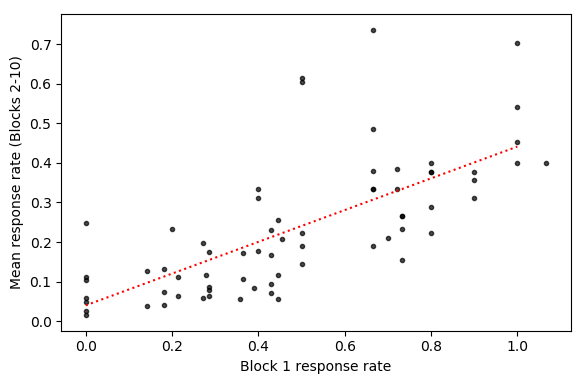

In [898]:
## Fig 5d: Does early selectivity correlate with late selectivity? 
## Block1 vs Rest: 1 significant, 2 nearly significant, but not quite. Pearson is better
## Block1-3 vs Rest: 3/5 significant
## Block1-2 vs Rest: 3/5 Significant, nicer numbers

plt.style.use('default')

## Rank or straight correlation:
xs,ys = [],[]
for d in range(len(all_aviaries)):
    daviary = all_aviaries[d][:,:,:,0]
    block1_rank = np.nanmean(daviary[:,0,:],axis=(0))
    overall_rank = np.nanmean(daviary[:,1:,:],axis=(0,1))
    xs.extend(block1_rank)
    ys.extend(overall_rank)
    #print(overall_rank)                       
    #print(block1_rank)

    #print(spearmanr(overall_rank,block1_rank))
    print(pearsonr(block1_rank,overall_rank))
    
fit_line = np.poly1d(np.polyfit(xs,ys,1))
print('overall:',pearsonr(xs,ys))
fig,ax = plt.subplots()

ax.scatter(xs,ys,color='black',alpha=.7,marker='.')
ax.plot([0,1],fit_line([0,1]),color='red',linestyle=':')
ax.set_xlabel('Block 1 response rate')
ax.set_ylabel('Mean response rate (Blocks 2-10)')
#ax.set_title('Song CSD-rate stay largely consistent following first block\n')
fig.set_size_inches(6,4)

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'axes.labelweight':'bold'})
fig.tight_layout()
fig.savefig('./figures/csd_rate_correlation_dark.png',dpi=300)
fig.show()

## Figure 6
Partial postures

(7, 14, 10, 3)
(-0.43537723608408097, 0.04284539080393092)
(18, 11, 10, 3)
(-0.4083352250951995, 0.0065608594159920035)
(11, 12, 12, 3)
(-0.5054519521692056, 0.0019533826874423344)
(14, 10, 16, 3)
(-0.09334046032665543, 0.5938110150951397)
(10, 10, 10, 3)
(-0.37793989892477475, 0.011426141308404763)
(15, 7, 10, 3)
(-0.09049749831580277, 0.5590777423023746)
0.20045366681628793 -0.0811388977055749
Ttest_indResult(statistic=-5.367776198535429, pvalue=1.0115634387846583e-07)


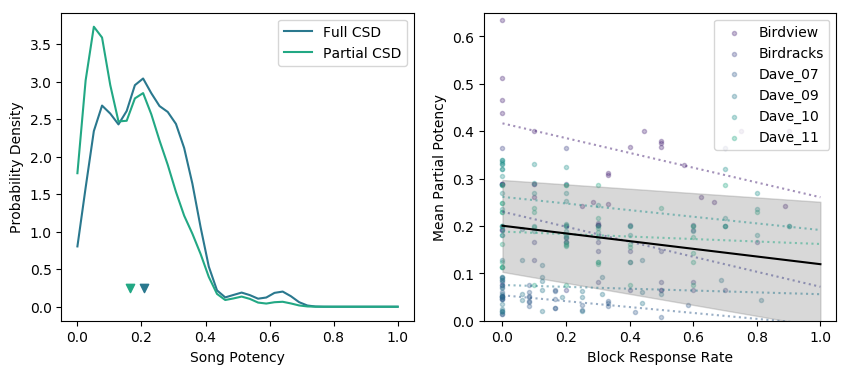

In [269]:
## Check whether partials correlate with reponse rate for Fig 6

#all_aviaries = daviaries.extend([birdview_array,bv3_array])
#all_metas = dmetas.extend([birdview_meta,bv3_meta])

aviary_color_values = [.1,.2,.3,.4,.5,.6,.7,.8]
aviary_colors = [paper_cmap(v) for v in aviary_color_values]

xs_all,ys_all = [],[]
all_partials,all_postures = [],[]
#all_durations = []
ys_rel = []

fig,(ax1,ax) = plt.subplots(1,2)

columns = ["ResponseRate","RelPotency","AvgPotency","Bird","Block","Aviary"]
columns2 = ["ResponseRate","Duration","RelPotency","AvgPotency","Bird","Block","Aviary"]

partials_df = pd.DataFrame(columns=columns)
durations_df = pd.DataFrame(columns=columns2)
"""
partials_df = pd.DataFrame({
    "ResponseRate":[],
    "RelPotency":[],
    "AvgPotency":[],
    "Bird":[],
    "Block":[],
    "Aviary":[]
    })
"""
for d in range(len(all_aviaries)):

    xs,ys,no_partials = [],[],[]
    ys_rel = []
## pull out block response rate and mean potency of partial songs:
    daviary = all_aviaries[d]
    print(daviary.shape)
    meta = all_metas[d]
    binary_dave = np.array(daviary)
    binary_dave[binary_dave[:,:,:,0] == 2] = 0
    dave_potency = np.nanmean(binary_dave[:,:,:,0],axis=(0,1))
    dave_potency = dave_potency # / np.max(dave_potency)
    aviary_name = meta.name
    #xs,ys,no_partials = [],[],[]
    for f in range(meta.n_birds):
        female=meta.bird_list[f]
        rel_potency = np.nanmean(binary_dave[f,:,:,0],0)
        #print(max(rel_potency))
        for b in range(meta.n_blocks):
            block_r = np.nanmean(binary_dave[f,b,:,0])# / np.max(dave_potency)
            block_partials = [daviary[f,b,:,0] == 2]
            mean_duration = np.mean(daviary[f,b,:,2][daviary[f,b,:,0] == 1])
            #print(block_partials,dave_potency)
            partial_potency = dave_potency[block_partials] #/ np.max(dave_potency)
            for s in range(meta.n_songs):
                duration = daviary[f,b,s,2]
                if np.isnan(duration):
                    continue
                if duration == 'R':
                    continue
                song_potency = dave_potency[s]
                rel_song_potency = rel_potency[s]
                durations_df = durations_df.append(dict(zip(columns2,
                            [block_r,duration,rel_song_potency,song_potency,female,b,aviary_name])),ignore_index=True)
            if len(partial_potency) >= 1:
                mean_potency = np.mean(partial_potency)
                mean_rel = np.mean(rel_potency[block_partials])
            ## If no partials,  no data...right? 
            else:
                no_partials.append(block_r)
                continue
            #print(block_r,dave_potency[block_partials])
            #print(block_r,mean_potency)
            xs.append(block_r)
            ys.append(mean_potency)
            ys_rel.append(mean_rel)
            xs_all.append(block_r)
            ys_all.append(mean_potency)
            #all_durations.append(mean_duration)
            all_partials.extend(partial_potency)# / np.max(dave_potency))
            all_postures.extend(dave_potency[binary_dave[f,b,:,0] == 1]) ## Also add song distribution
            partials_df = partials_df.append(dict(zip(columns,
                                        [block_r,mean_rel,mean_potency,female,b,aviary_name])),ignore_index=True)
    ax.scatter(xs,ys,color=aviary_colors[d],marker='.',alpha=.3,label=aviary_name)
    fit_line = np.poly1d(np.polyfit(xs,ys,1))
    ax.plot([0,1],fit_line([0,1]),linestyle=':',color=aviary_colors[d],alpha=.5)
    print(pearsonr(xs,ys))


## run the mixed linear model so I can plot the curve
partials_df = partials_df.dropna()
md = smf.mixedlm("AvgPotency ~ ResponseRate",data=partials_df,groups=partials_df["Aviary"])
mdf_partial = md.fit()    
intercept,effect,_ = mdf_partial.params
print(intercept,effect)
int_high,int_low = [0.297,0.103]
eff_high,eff_low = [-0.046,-.116]

fit_line = np.poly1d([effect,intercept])
low_line = np.poly1d([eff_low,int_low])
high_line = np.poly1d([eff_high,int_high])

#ax.scatter(partials_df['ResponseRate'],partials_df['AvgPotency'],alpha=.4,marker='.')
ax.plot([0,1],fit_line([0,1]),color='black')
ax.fill_between([0,1],high_line([0,1]),low_line([0,1]),color='gray',alpha=.3)

ax.legend()
ax.set_ylim([0,.65])

ax.set_xlabel('Block Response Rate')
ax.set_ylabel('Mean Partial Potency')
#ax.scatter(xs,ys)
fit_line = np.poly1d(np.polyfit(xs_all,ys_all,1))
#ax.plot([0,1],fit_line([0,1]),color='red')
#par_xs,par_ys,_ = ax1.hist(all_partials,normed=True,alpha=.6,label='partials')
#csd_xs,csd_ys,_ = ax1.hist(all_postures,normed=True,alpha=.6,label='postures')
csd_curve = gaussian_kde(all_postures,bw_method=.3)
csd_xs = np.linspace(0,1,40)
ax1.plot(csd_xs,csd_curve(csd_xs),color=paper_cmap(.4),label='Full CSD')

par_curve = gaussian_kde(all_partials,bw_method=.3)
ax1.plot(csd_xs,par_curve(csd_xs),color=paper_cmap(.6),label='Partial CSD')
ax1.scatter(np.nanmean(all_postures),.25,marker='v',color=paper_cmap(.4))
ax1.scatter(np.nanmean(all_partials),.25,marker='v',color=paper_cmap(.6))

ax1.set_xlabel('Song Potency')
ax1.set_ylabel('Probability Density')
ax1.legend()
print(ttest_ind(all_partials,all_postures))

fig.set_size_inches(10,4)
fig.show()

In [271]:
## Print stats for above fit, model was fit above
partials_df = partials_df.dropna()


#md = smf.mixedlm("AvgPotency ~ ResponseRate",data=partials_df,groups=partials_df["Aviary"])
#mdf_partial = md.fit()
print(mdf_partial.summary())

if False:
    intercept,effect,_ = mdf_partial.params
    #print(intercept,effect)
    int_high,int_low = [0.297,0.103]
    eff_high,eff_low = [-0.046,-.116]

    fit_line = np.poly1d([effect,intercept])
    low_line = np.poly1d([eff_low,int_low])
    high_line = np.poly1d([eff_high,int_high])
    
    fig,ax = plt.subplots()
    #ax.scatter(partials_df['ResponseRate'],partials_df['AvgPotency'],alpha=.4,marker='.')
    ax.plot([0,1],fit_line([0,1]),color='black')
    ax.fill_between([0,1],high_line([0,1]),low_line([0,1]),color='gray',alpha=.3)
    for a in range(len(all_aviaries)):
        aviary_df = partials_df[partials_df['Aviary'] == all_metas[a].name]
        ax.scatter(aviary_df['ResponseRate'],aviary_df['AvgPotency'],alpha=.4,marker='.')
        fit_line = np.poly1d(np.polyfit(aviary_df['ResponseRate'],aviary_df['AvgPotency'],1))
        ax.plot([0,1],fit_line([0,1]),linestyle=':',alpha=.4)
    ax.set_ylim([0,.65])
    fig.show()

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: AvgPotency
No. Observations: 223     Method:             REML      
No. Groups:       6       Scale:              0.0039    
Min. group size:  22      Likelihood:         283.7611  
Max. group size:  44      Converged:          Yes       
Mean group size:  37.2                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.200    0.050  4.049 0.000  0.103  0.297
ResponseRate  -0.081    0.018 -4.569 0.000 -0.116 -0.046
Group Var      0.014    0.150                           



In [ ]:
## Do some more lame stats! Intersting artifacts here...

print('absolute all:',pearsonr(xs_all,ys_all))
print('relative all:',pearsonr(xs_all,ys_rel))

In [365]:
## Note the different groups here, the above was mean rel potency of partial posture songs, below is 
# rel potency of song that evoke the csd
md = smf.mixedlm("Duration ~ ResponseRate",data=durations_df,groups=durations_df["Aviary"])
mdf = md.fit()
print(mdf.summary())

md = smf.mixedlm("Duration ~ AvgPotency",data=durations_df,groups=durations_df["Aviary"])
mdf = md.fit()
print(mdf.summary())

print('In summary, response rate predicts the songs that get partial postures,',\
      'as well as duration, more strongly, in fact, than song potency predicts duration')
print('Avg potency works here, but it is even weaker. I need to pin this down...')

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Duration   
No. Observations: 6031    Method:             REML       
No. Groups:       5       Scale:              1.7352     
Min. group size:  157     Likelihood:         -10233.9926
Max. group size:  2240    Converged:          Yes        
Mean group size:  1206.2                                 
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.301    0.305  0.985 0.324 -0.298  0.900
ResponseRate    4.166    0.085 48.894 0.000  3.999  4.333
Group Var       0.461    0.254                           

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Duration   
No. Observations: 6031    Method:             REML       
No. Groups:       5       Scale:              2.3394     
Min. group size:  157     Likelih

## Fig 7, including Train a classifer on Shape with Response Rate 

In [ ]:
# Before training a classifier, I can just correlate height a vmax to response rate

# That's easy enough, height and vmax are both variables, so just pull them out of my seq list
# response rate could be the average for the block...I'll need that as a dict.

# Supplemental Figures

### Supplemental Figure 3
Concordance of Song rankings:

non_responsive! 0 3
no correlation 0 6 nan [nan nan nan nan nan nan nan nan nan nan] [0.73170732 0.4        0.71794872 0.35714286 0.6097561  0.48484848
 0.575      0.6        0.35897436 0.5       ]
non_responsive! 1 0
non_responsive! 1 1
non_responsive! 1 6
non_responsive! 1 8
non_responsive! 1 13
non_responsive! 1 15
non_responsive! 2 2
non_responsive! 2 3
non_responsive! 2 5
non_responsive! 2 6
non_responsive! 2 9
non_responsive! 2 10
non_responsive! 3 3
non_responsive! 3 6
non_responsive! 3 9
non_responsive! 3 10
non_responsive! 3 12
non_responsive! 3 13
non_responsive! 4 7
non_responsive! 5 13
23 53
nan


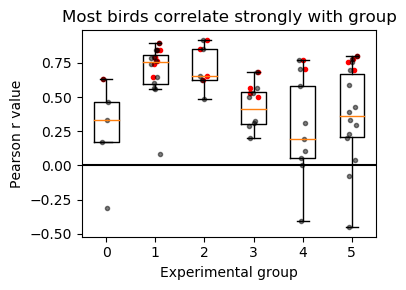

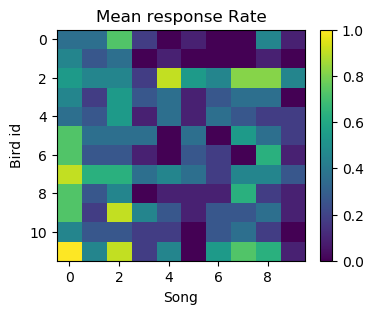

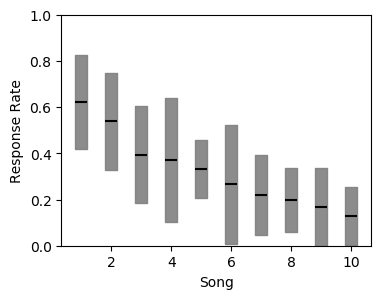

In [324]:
# How much do birds agree? 

fig,ax = plt.subplots()
count,p_count = 0,0
all_std,random_stds = [],[]
iterations = 1000
boxes_concs = []

for a in range(len(all_aviaries)):
    #responsive_birds = []
    bird_concs = []
    bird_ps = []
    daviary = all_aviaries[a][:,:,:,0]
    n_birds = daviary.shape[0]
    n_blocks = daviary.shape[1]
    responsive_birds = np.nanmean(daviary,axis=(1,2)) > .05
    for f in range(n_birds):
        this_bird = daviary[f,:,:]
        if np.nanmean(this_bird) <= .05:
            print('non_responsive!',a,f)
            continue
        not_f = np.arange(n_birds) != f
        bird_conc,p_value = pearsonr(np.nanmean(daviary[f,:,:],axis=0),np.nanmean(daviary[not_f,:,:],axis=(0,1)))
        #random_birds = np.shuffle(np.nanmean(daviary[f,:,:],axis=0))
        #random_conc,_ = pearsonr(random_birds,np.nanmean(daviary[not_f,:,:],axis=(0,1)))
        #bird_concs.append(1 - p_value)
        if ~np.isnan(bird_conc):
            bird_concs.append(bird_conc)
            bird_ps.append(p_value)
        else:    
            print('no correlation',a,f,bird_conc,np.nanmean(daviary[f,:,:,],0),np.nanmean(daviary[not_f,:,:],axis=(0,1)))
            continue
            
        #rand_concs.append(random_conc)
        #print(bird_conc,p_value)
        if p_value <= .05:
            p_count += 1
        count += 1
    xs = np.ones(len(bird_concs)) * a + np.random.uniform(low=-.1,high=.1,size=len(bird_concs))
    bird_concs = np.array(bird_concs)
    bird_ps = np.array(bird_ps)
    
    bird_concs_sig = bird_concs[bird_ps < .05]
    bird_concs_non = bird_concs[bird_ps >- .05]
    xs_sig = np.ones(len(bird_concs_sig)) * a + np.random.uniform(low=-.1,high=.1,size=len(bird_concs_sig))
    xs_non = np.ones(len(bird_concs_non)) * a + np.random.uniform(low=-.1,high=.1,size=len(bird_concs_non))
    ax.scatter(xs_sig,bird_concs_sig,color='red',marker='.')
    ax.scatter(xs_non,bird_concs_non,color='black',marker='.',alpha=.5)
    #ax.scatter(xs,bird_concs)
    boxes_concs.append(bird_concs)
ax.boxplot(boxes_concs,positions=range(len(all_aviaries)),showfliers=False)

#ax.axhline(.95,color='red',linestyle=':')
ax.set_title('Most birds correlate strongly with group')
ax.set_xlabel('Experimental group')
ax.set_ylabel('Pearson r value')
ax.axhline(0,color='black')
fig.set_size_inches(4,3)
fig.show()
print(p_count,count)
print(np.nanmean(all_std))
"""
fig2,ax2 = plt.subplots()

plotted_boots = random.sample(random_stds,200)
ax2.hist(plotted_boots,bins=20)
ax2.hist(all_std)
fig2.show()
"""
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()


daviary = all_aviaries[1][:,:,:,0]
n_songs = daviary.shape[2]
n_birds = daviary.shape[0]

daviary_r = np.array(daviary)
bird_means = np.nanmean(daviary,axis=(1,2))
daviary_r = daviary[bird_means > .05]
mean_bar = np.nanmean(np.nanmean(daviary_r,1),0)
std_bar = np.nanstd(np.nanmean(daviary_r,axis=1),0)
song_order = np.argsort(mean_bar)[::-1]
mean_bar = mean_bar[song_order]
std_bar = std_bar[song_order]

for s in range(n_songs):
    ax2.fill_between([1+s-.2,1+s+.2],mean_bar[s] + std_bar[s],mean_bar[s] - std_bar[s],color='gray',alpha=.9)
ax2.hlines(mean_bar,1+np.arange(n_songs)-.2,1+np.arange(n_songs) + .2,color='black')
ax2.set_ylim([0,1])

bird_map = ax1.imshow(np.nanmean(daviary_r,1),interpolation='nearest',aspect='auto')
ax1.set_xlabel('Song')
ax1.set_ylabel('Bird id')
ax1.set_title('Mean response Rate')
fig1.colorbar(bird_map,ax=ax1)
fig1.set_size_inches(4,3)
fig1.show()


ax2.set_xlabel('Song')
ax2.set_ylabel('Response Rate')
fig2.set_size_inches(4,3)
fig.tight_layout()
fig2.show()

0 1 (0.8194260095246394, 0.0037175012423138055)
0 2 (0.5090540027463842, 0.13290876485870073)
0 3 (0.6939042660632417, 0.026019930481521916)
1 2 (0.6741496647158246, 0.032533422649155284)
1 3 (0.7445616713439573, 0.01350221844288449)
2 3 (0.6413024905623759, 0.045671405175238065)


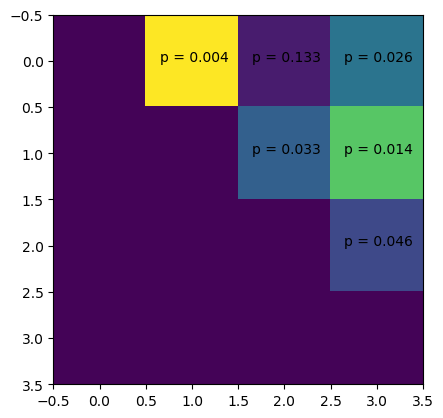

In [351]:
same_songs = [0,1,4,5]
aviary_rankings = np.zeros([4,10])

for i in range(len(same_songs)):
    a = same_songs[i]
    song_list_sorted = sorted(all_metas[a].song_list)
    sorted_song_indices = [all_metas[a].song_dict[s] for s in song_list_sorted]
    #print(sorted_song_indices,np.array(all_metas[a].song_list)[sorted_song_indices])
    binary_dave = all_aviaries[a][:,:,:,0]
    binary_dave[binary_dave == 2] = 0
    binary_dave = binary_dave[:,:,sorted_song_indices]
    bird_means = np.nanmean(binary_dave,axis=(1,2))
    #print(bird_means.shape)
    responsive_birds = [bird_means > .05]
    local_rankings = np.nanmean(binary_dave[responsive_birds],axis=(0,1))
    #print(local_rankings)
    aviary_rankings[i,:] =local_rankings

#print(aviary_rankings)
pairwise_t = np.ones([4,4])
fig,ax = plt.subplots()
for i in range(4):
    for j in range(1,4-i):
        k = i+j
        f_stat,p_val = pearsonr(aviary_rankings[i],aviary_rankings[k])
        pairwise_t[i,k] = 1 / p_val
        print(i,k,pearsonr(aviary_rankings[i],aviary_rankings[k]))
        ax.text(k-.35,i,'p = ' + str(np.round(p_val,3)))

ax.imshow(pairwise_t,vmax = 1/.01,vmin=0)
fig.show()

(7, 14, 10, 3)
(18, 11, 10, 3)
(11, 12, 12, 3)
(14, 10, 16, 3)
(10, 10, 10, 3)
(15, 7, 10, 3)


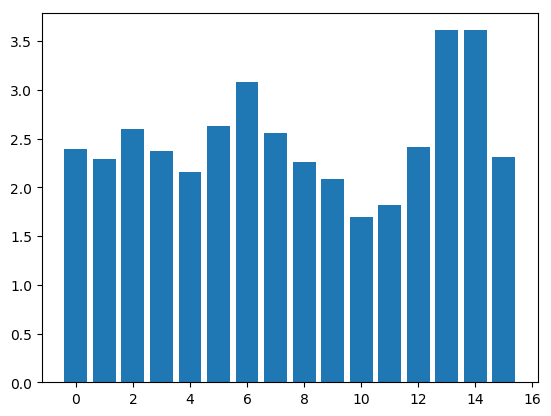

In [342]:
## This was a clever Idea but it's not a general case
## Even by the model, we expect variation to be highest around the threshold
## There's no reason to predit the threshold is in a particular place. 

max_songs = np.max([meta.n_songs for meta in all_metas])

all_std = np.empty([len(all_aviaries),max_songs])
all_std.fill(np.nan)
for a in range(len(all_aviaries)):
    
    daviary = all_aviaries[a]
    print(daviary.shape)
    n_birds = all_metas[a].n_birds
    n_songs = all_metas[a].n_songs
    binary_daviary = np.array(daviary[:,:,:,0])
    binary_daviary[binary_daviary == 2] = 0
    bird_means = np.nanmean(binary_daviary,axis=(1,2))
    order_by_bird = np.empty([n_birds,n_songs])

    order_by_bird.fill(np.nan)
    responsive_birds = [bird_means > .05]
    song_means = np.nanmean(binary_daviary[responsive_birds],axis=(0,1))
    song_std = np.nanstd(binary_daviary[responsive_birds],axis=(0,1))
    song_std = np.nanstd(np.nanmean(binary_daviary[responsive_birds],axis=1),0)
    song_order = np.argsort(song_means)[::-1]
    
    for f in range(n_birds):

        if np.nanmean(binary_daviary[f]) < .05:
            continue


        bird_order = np.argsort(np.nanmean(binary_daviary[f,:,song_order],axis=(1)))[::-1]
        order_by_bird[f] = bird_order

    order_std = np.nanstd(order_by_bird,0)

    sorted_std = song_std[song_order]
    if False:
        fig,ax = plt.subplots()
        ax.bar(range(len(song_means)),song_means[song_order],yerr=order_std)
        fig.show()

    all_std[a,:len(order_std)] = order_std
    

fig,ax = plt.subplots()

ax.bar(range(max_songs),np.nanmean(all_std,0))
fig.show()

## Everything from here down is old code not appearing in the paper

In [880]:
## Old latency counting
"""
fig,ax = plt.subplots()
### The hand written ones are correct too. 
depuff_latencies = []
depuff_latencies2 = []
wingstroke_latencies = []
for i,row in test_4.iterrows():
    if '2019' not in row['SeqName']:
        continue
    try:
        seq = pickle.load(open('./AllSeqs/' + row['SeqName'] + '.obj','rb'))
        #print(seq.seq_name,'offset:',seq.ts[0])
    except:
        #print('seq missing',row['SeqName'],'all values are wrong')
        continue
    if seq.ts[0] == 0:
        continue
    notes = str(row['Notes']).lower()
    if 'depress' in notes:
        #print(row)
        #print(row['TrueLatency'])
        if pd.isnull(row['TrueLatency']):
            pass
        else:
            depuff_latencies.append(row['TrueLatency'])
            depuff_latencies2.append(row['TimeStamp'] + seq.ts[0])
            print('depuff:',row['TrueLatency'],row['TimeStamp'] + seq.ts[0],seq.ts[0],seq.seq_name)
    if 'wingstroke' in notes:
        #print('wingstroke:',row['SeqName'],row['TimeStamp'],row['Offset'])
        wingstroke_latencies.append(row['TimeStamp'] + seq.ts[0])
        print('wingstroke:',row['TrueLatency'],row['TimeStamp'] + seq.ts[0],seq.ts[0],seq.seq_name)
            
print('depuffs:')
print(len(depuffs),len(depuff_latencies),len(depuff_latencies2))
print(depuffs,depuff_latencies,depuff_latencies2)

print('wingstrokes:')
print(len(wingstrokes),len(wingstroke_latencies))
print(wingstrokes,wingstroke_latencies)



ax.hist(depuff_latencies,normed=False,color='gray')
#ax.hist(latencies[~np.isnan(latencies)],alpha=.8,normed=True)
ax.axvline(0,color='black')
ax.axvline(np.median(depuff_latencies),color='black',linestyle=':')
#ax.axvline(np.nanmedian(latencies),color='black')
ax.set_xlim(-.5,.5)
ax.set_ylabel('counts')
ax.set_xlabel('Latency of depuff from song onset (s)')
fig.show()
"""
pass

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


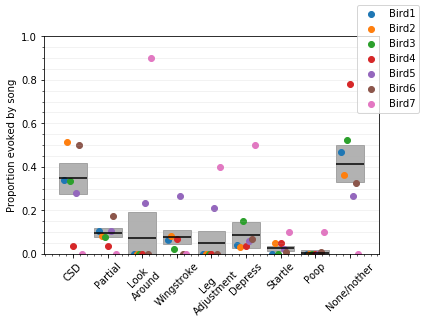

In [533]:
#Old Figure 2 (response timeline)

bird_list_boring = ['Bird1','Bird2','Bird3','Bird4','Bird5','Bird6','Bird7']
test_4 = pd.read_csv('./presentation_info3.csv')
count = 0
response = 0

csd_count = 0
partial_count= 0
look_count = 0
ws_count = 0
leg_count = 0 
dp_count = 0
startle_count = 0
poo_count = 0
other_count = 0
bird_count_dict = dict(zip(bird_list,[[0,0,0,0,0,0,0,0,0,0] for f in bird_list]))
for i,row in test_4.iterrows():
    if '2019' not in str(row['SeqName']):
        continue
    notes = str(row['Notes']).lower()
    posture = str(row['Posture'])
    if 'missing' in notes or 'no bird' in notes or 'tone' in notes or 'not on computer' in notes:
        continue
    if row['Bird'] in bird_dict.keys():
        bird_name = row['Bird']
    else:
        continue
    if '1' in posture:
        csd_count +=1
        bird_count_dict[bird_name][0] += 1
        response=1
    elif '2' in posture:
        partial_count += 1
        bird_count_dict[bird_name][1] += 1
        response=1  
    elif '0' not in posture:
        continue
    if 'look' in notes:
        look_count +=1
        bird_count_dict[bird_name][2] += 1
        response=1  
    if 'wingstroke' in notes:
        ws_count += 1
        bird_count_dict[bird_name][3] += 1
        response=1  
    if 'leg' in notes:
        leg_count += 1
        bird_count_dict[bird_name][4] += 1
        response=1  
    if 'depress' in notes:
        dp_count += 1
        bird_count_dict[bird_name][5] += 1
        response=1  
    if 'startle' in notes:
        startle_count +=1
        bird_count_dict[bird_name][6] += 1
        response=1  
    if 'poop' in notes:
        poo_count +=1
        bird_count_dict[bird_name][7] += 1
        response=1  
    if not response:
        other_count +=1
        bird_count_dict[bird_name][8] += 1
        #print(posture,notes)
    response=0
    bird_count_dict[bird_name][9] +=1
    count+=1  

bird_count_array = np.zeros([len(bird_list),10])
for f in range(len(bird_list)):
    bird_count_array[f] = bird_count_dict[bird_list[f]]
    
    
behavior_labels=['CSD','Partial','Look\nAround','Wingstroke','Leg\nAdjustment','Depress','Startle','Poop','None/nother']
fig,ax = plt.subplots()
behavior_bars = np.array([csd_count,partial_count,look_count,ws_count,leg_count,
                          dp_count,startle_count,poo_count,other_count]) / count
#ax.bar(range(len(behavior_bars)),behavior_bars)
ax.hlines(behavior_bars,np.arange(len(behavior_labels)) - .4,np.arange(len(behavior_labels)) + .4)
for b in range(len(behavior_labels)):
    sem_b = np.std(np.divide(bird_count_array[:,b],bird_count_array[:,-1])) / np.sqrt(len(bird_list))
    ## don't forget to divide to get rations, duh
    #print(bird_count_array[:,b],np.std(np.divide(bird_count_array[:,b],bird_count_array[:,-1]),np.sqrt(len(bird_list)),sem_b)
    #sem_b = .05
    ax.fill_between([b-.4,b+.4],behavior_bars[b] + sem_b,behavior_bars[b] - sem_b,color='gray',alpha=.6)
for f in range(len(bird_list)):
    bird_count = bird_count_dict[bird_list[f]][9]
    bird_bars = np.array(bird_count_dict[bird_list[f]])[:9] / bird_count
    ax.scatter(np.arange(len(behavior_labels)) + f*2/(3*8) - 1/4.,bird_bars,label=bird_list_boring[f])
    ax.set_xticks(np.arange(len(behavior_labels)))
    ax.set_xticklabels(behavior_labels,rotation = 45)
ax.set_ylabel('Proportion evoked by song')

ax.minorticks_on()

ax.yaxis.grid(which='both',alpha=.2)
ax.set_ylim((0,1))

fig.legend()
fig.show()

2019-06-01-17-47-14_LB is missing
Source                                 birdview
SeqName                  2019-06-01-17-47-14_LB
Posture                                       0
Bird                                        NaN
Song                                        NaN
Block                                       NaN
Notes                                       NaN
Server                                 birdview
Duration by eye                             NaN
Duration by My Method                       NaN
Latency by Eye Frame                        NaN
Latency minus offset                        NaN
Latency by Method                           NaN
TimeStamp                                   NaN
Offset                                      NaN
TrueLatency                                 NaN
FrameRate                                   NaN
Partial Latency                             NaN
TruePartial                                 NaN
Eye Duration                                NaN
Name: 

2019-06-09-07-16-15_DMG is missing
Source                                                    birdview
SeqName                                    2019-06-09-07-16-15_DMG
Posture                                                          0
Bird                                                        CB-LB2
Song                                                           NaN
Block                                                            5
Notes                    wingstrokes floor; look around; searching
Server                                                    birdview
Duration by eye                                                NaN
Duration by My Method                                          NaN
Latency by Eye Frame                                           NaN
Latency minus offset                                           NaN
Latency by Method                                              NaN
TimeStamp                                                     5.56
Offset                     

2019-06-13-13-16-14_WG is missing
Source                                     birdview
SeqName                      2019-06-13-13-16-14_WG
Posture                                           2
Bird                                         CB-LB2
Song                                            NaN
Block                                             8
Notes                    very partial posture floor
Server                                     birdview
Duration by eye                                 NaN
Duration by My Method                           NaN
Latency by Eye Frame                            NaN
Latency minus offset                            NaN
Latency by Method                               NaN
TimeStamp                                       NaN
Offset                                      missing
TrueLatency                                       0
FrameRate                                       NaN
Partial Latency                                4.86
TruePartial                   

2019-06-21-11-46-14_DBR is missing
Source                                  birdview
SeqName                  2019-06-21-11-46-14_DBR
Posture                                        0
Bird                                       CB-Y2
Song                                         NaN
Block                                          4
Notes                                        NaN
Server                                  birdview
Duration by eye                              NaN
Duration by My Method                        NaN
Latency by Eye Frame                         NaN
Latency minus offset                         NaN
Latency by Method                            NaN
TimeStamp                                    NaN
Offset                                       NaN
TrueLatency                                    0
FrameRate                                    NaN
Partial Latency                              NaN
TruePartial                                  NaN
Eye Duration                      

2019-06-25-11-46-15_LNR is missing
Source                                  birdview
SeqName                  2019-06-25-11-46-15_LNR
Posture                                        2
Bird                                       CB-Y2
Song                                         NaN
Block                                          7
Notes                              super partial
Server                                  birdview
Duration by eye                              NaN
Duration by My Method                        NaN
Latency by Eye Frame                        5.08
Latency minus offset                         NaN
Latency by Method                            NaN
TimeStamp                                    NaN
Offset                                   missing
TrueLatency                                    0
FrameRate                                    NaN
Partial Latency                             5.16
TruePartial                                 5.16
Eye Duration                      

2019-06-30-07-16-14_2M is missing
Source                                 birdview
SeqName                  2019-06-30-07-16-14_2M
Posture                                       2
Bird                                      CB-Y2
Song                                        NaN
Block                                        12
Notes                     floor- nearly partial
Server                                 birdview
Duration by eye                               1
Duration by My Method                       NaN
Latency by Eye Frame                       4.32
Latency minus offset                        NaN
Latency by Method                           NaN
TimeStamp                                   NaN
Offset                                      NaN
TrueLatency                                 NaN
FrameRate                                   NaN
Partial Latency                             NaN
TruePartial                                 NaN
Eye Duration                                NaN
Name: 

2019-05-25-15-35-32_LB is missing
Source                               birdview-2
SeqName                  2019-05-25-15-35-32_LB
Posture                                     NaN
Bird                                     CB-Red
Song                                        NaN
Block                                         4
Notes                                   missing
Server                               birdview-2
Duration by eye                             NaN
Duration by My Method                       NaN
Latency by Eye Frame                        NaN
Latency minus offset                        NaN
Latency by Method                           NaN
TimeStamp                                   NaN
Offset                                      NaN
TrueLatency                                 NaN
FrameRate                                   NaN
Partial Latency                             NaN
TruePartial                                 NaN
Eye Duration                                NaN
Name: 

2019-06-12-11-33-49_DBR is missing
Source                                birdview-2
SeqName                  2019-06-12-11-33-49_DBR
Posture                                        0
Bird                                   CB-Yellow
Song                                         NaN
Block                                         11
Notes                                        NaN
Server                                birdview-2
Duration by eye                              NaN
Duration by My Method                        NaN
Latency by Eye Frame                         NaN
Latency minus offset                         NaN
Latency by Method                            NaN
TimeStamp                                    NaN
Offset                                       NaN
TrueLatency                                  NaN
FrameRate                                    NaN
Partial Latency                              NaN
TruePartial                                  NaN
Eye Duration                      

2019-06-24-07-10-28_GRG is missing
Source                                birdview-2
SeqName                  2019-06-24-07-10-28_GRG
Posture                                      NaN
Bird                                   CB-Orange
Song                                         NaN
Block                                          6
Notes                                    missing
Server                                birdview-2
Duration by eye                              NaN
Duration by My Method                        NaN
Latency by Eye Frame                         NaN
Latency minus offset                         NaN
Latency by Method                            NaN
TimeStamp                                    NaN
Offset                                       NaN
TrueLatency                                  NaN
FrameRate                                    NaN
Partial Latency                              NaN
TruePartial                                  NaN
Eye Duration                      

unknown offset...
2019-07-04-11-42-38_DBR
4.36
unknown offset...
2019-07-04-13-12-37_BOD
4.5
unknown offset...
2019-07-04-15-42-38_BDY
4.48
unknown offset...
2019-07-04-17-12-39_LNR
4.74
unknown offset...
2019-07-04-18-42-39_GRG
4.459
unknown offset...
2019-07-05-07-12-40_2M
4.638999999999999
unknown offset...
2019-07-05-08-42-39_ND
4.419
unknown offset...
2019-07-05-10-12-38_DMG
4.7589999999999995
unknown offset...
2019-07-05-13-12-38_LB
4.678999999999999
unknown offset...
2019-07-05-15-42-37_BDY
4.44
unknown offset...
2019-07-05-17-12-38_DBR
4.419
unknown offset...
2019-07-05-18-42-42_DMG
4.66
2019-07-06-07-10-26_LB is missing
Source                               birdview-2
SeqName                  2019-07-06-07-10-26_LB
Posture                                     NaN
Bird                                   CB-White
Song                                        NaN
Block                                         2
Notes                                   missing
Server                     

2019-07-10-17-10-41_BOD is missing
Source                                birdview-2
SeqName                  2019-07-10-17-10-41_BOD
Posture                                      NaN
Bird                                    CB-White
Song                                         NaN
Block                                          7
Notes                                    missing
Server                                birdview-2
Duration by eye                              NaN
Duration by My Method                        NaN
Latency by Eye Frame                         NaN
Latency minus offset                         NaN
Latency by Method                            NaN
TimeStamp                                    NaN
Offset                                       NaN
TrueLatency                                  NaN
FrameRate                                    NaN
Partial Latency                              NaN
TruePartial                                  NaN
Eye Duration                      

bird: CB-Orange
(-0.004797419554336227, 0.9739017235079513)
bird: CB-Yellow
(0.37110882579875354, 0.0334826680627773)
bird: CB-Red
(nan, nan)
bird: CB-LB2
(0.23351274110847092, 0.2721282216867535)
bird: CB-Y2
(0.07391312977332914, 0.5988985843503112)
bird: CB-R2
(nan, nan)
(0.4129686408454557, 0.23556989887581556)
(0.6022559340628967, 3.7849973405805217e-19)
(0.1435498520406668, 0.053869751089461904)
***
(-0.5354826732625746, 0.11067048166987346)
bird: CB-White
(nan, nan)
bird: CB-Orange
(0.06534846670316406, 0.6322904244499573)
bird: CB-Yellow
(-0.0072062169293122804, 0.9647996469978788)
bird: CB-Red
(1.0, 0.0)
bird: CB-LB2
(-0.11732687850650192, 0.6429007545147206)
bird: CB-Y2
(0.02292392071402294, 0.8561664419789358)
bird: CB-R2
(nan, nan)
(0.4660652620091882, 2.3002925578835386e-11)


/home/ammon/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/ammon/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ammon/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3034: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently 

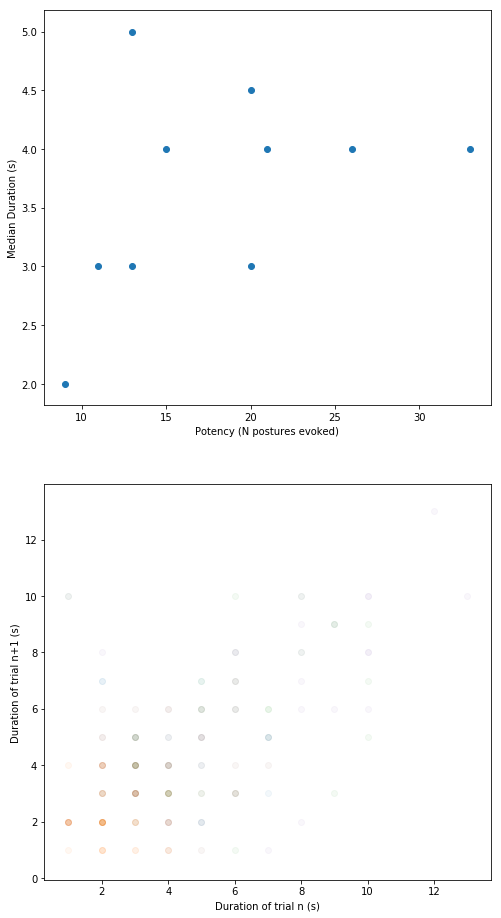

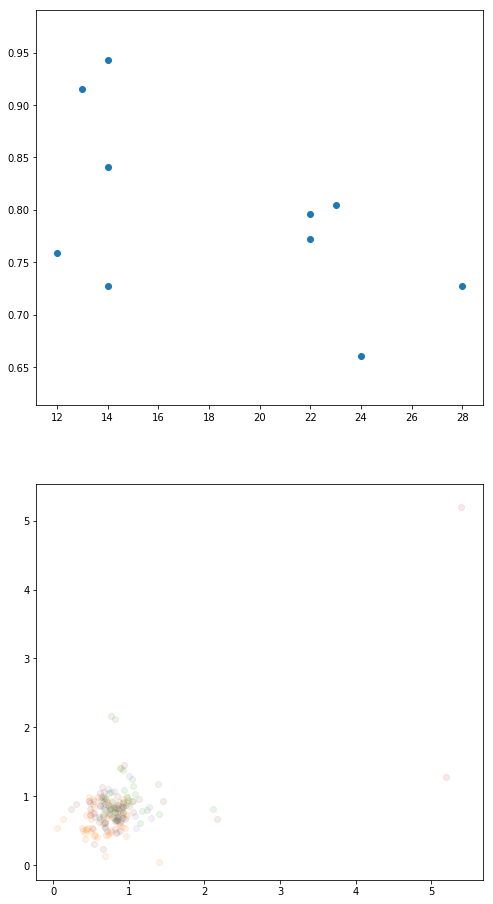

In [336]:
## Do some analysis, not sure if I need this...

#print(duration_dict)
#print(latency_dict)
xs = []
ys = []
xs_l,ys_l = [],[]
for song in song_list:
    #print(song,len(duration_dict[song]),np.median(duration_dict[song]))
    xs.append(len(duration_dict[song]))
    ys.append(np.median(duration_dict[song]))
    if song in latency_dict.keys():
        xs_l.append(len(latency_dict[song]))
        ys_l.append(np.median(latency_dict[song]))
    
fig,(ax,ax1) = plt.subplots(2)
ax.scatter(xs,ys)
ax.set_xlabel('Potency (N postures evoked)')
ax.set_ylabel('Median Duration (s)')
for bird in bird_list:
    ax1.scatter(bird_duration_dict[bird][:-1],bird_duration_dict[bird][1:],alpha=.05)
    print('bird:',bird)
    print(pearsonr(bird_duration_dict[bird][:-1],bird_duration_dict[bird][1:]))
ax1.set_xlabel('Duration of trial n (s)')
ax1.set_ylabel('Duration of trial n+1 (s)')
fig.set_size_inches([8,16])
fig.show()
print(pearsonr(xs,ys))
print(pearsonr(duration_list0[:-1],duration_list0[1:]))
#print(random.sample(duration_list0,len(duration_list0)))
print(pearsonr(duration_list0,random.sample(duration_list0,len(duration_list0))))
print('***')
print(pearsonr(xs_l,ys_l))
#print(xs_l,ys_l)
#print(len(latency_list0))

fig2,(ax2,ax3) = plt.subplots(2)
ax2.scatter(xs_l,ys_l)
for bird in bird_list:
    ax3.scatter(bird_latency_dict[bird][:-1],bird_latency_dict[bird][1:],alpha=.1)
    print('bird:',bird)
    print(pearsonr(bird_latency_dict[bird][:-1],bird_latency_dict[bird][1:]))

#ax3.scatter(latency_list0[:-1],latency_list0[1:])
print(pearsonr(latency_list0[:-1],latency_list0[1:]))
fig2.set_size_inches([8,16])
fig2.show()

In [4]:
## I don't think I need this...
print(bird_list)
print(song_list)
print(song_dict)
print(bird_dict)

total_song_counts = np.zeros(10)
total_presentation_counts = np.zeros(10)
relative_potency={}
for bird in bird_list:
    bird_df = test_3[test_3['Bird'] == bird]
    bird_posture_df = bird_df[bird_df['Posture'] == 1]
    good_df = bird_df[~pd.isna(bird_df['Posture'])]
    presentation_counts = good_df['Song'].value_counts()
    song_counts = bird_posture_df['Song'].value_counts()
    mean_array = np.zeros(10)
    for song in song_list:
        if song in song_counts.index.tolist():
            total_song_counts[song_dict[song]] += song_counts[song]
            mean_array[song_dict[song]] = song_counts[song] / presentation_counts[song]
        if song in presentation_counts.index.tolist():
            total_presentation_counts[song_dict[song]] += presentation_counts[song]

    print(mean_array)
    relative_potency[bird] = dict(zip(song_list,mean_array))
    
print(total_song_counts,total_presentation_counts)
song_potency_list = total_song_counts / total_presentation_counts
print(song_potency_list)
song_potency =dict(zip(song_list,song_potency_list))

['CB-White', 'CB-Orange', 'CB-Yellow', 'CB-Red', 'CB-LB2', 'CB-Y2', 'CB-R2']
['BDY', 'BOD', 'ND', 'LB', '2M', 'DBR', 'GRG', 'WG', 'LNR', 'DMG']
{'BDY': 0, 'BOD': 1, 'ND': 2, 'LB': 3, '2M': 4, 'DBR': 5, 'GRG': 6, 'WG': 7, 'LNR': 8, 'DMG': 9}
{'CB-White': 0, 'CB-Orange': 1, 'CB-Yellow': 2, 'CB-Red': 3, 'CB-LB2': 4, 'CB-Y2': 5, 'CB-R2': 6}
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[nan nan nan nan nan nan nan nan nan nan]


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


partial shape: (75, 3)
Reaout for group: Dave_11
n_birds: 15
n_songs: 10
n_blocks: 7
birds: ['F2PO' 'FWMW' 'FYR' 'FDMW' 'FLOL' 'FR2D' 'FGHB' 'FPG/M' 'FGNP' 'F2MB'
 'FO2R' 'FGRN' 'FOGO' 'FNMO' 'FGOG']
songs: ['M2M' 'MBDY' 'MBOD' 'MDBR' 'MDMG' 'MGRG' 'MWG' 'MND' 'MLNR' 'MLB']
shape (15, 7, 10, 3)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


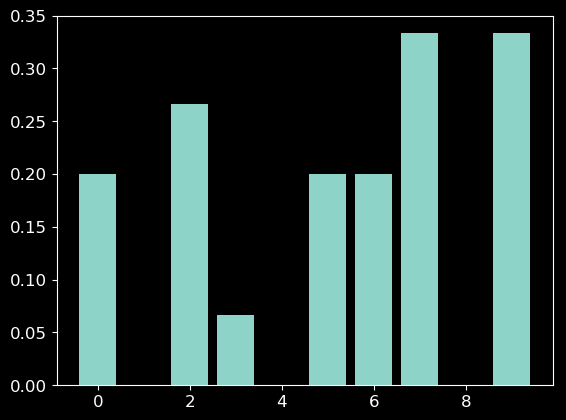

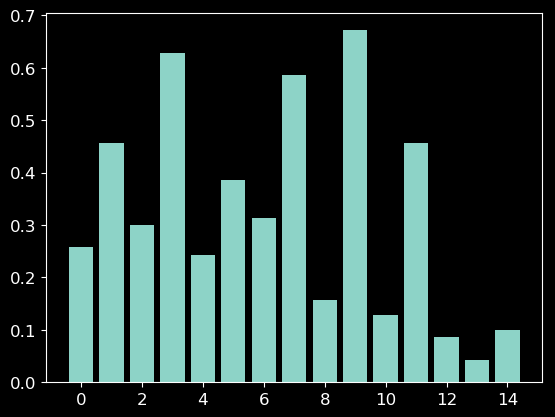

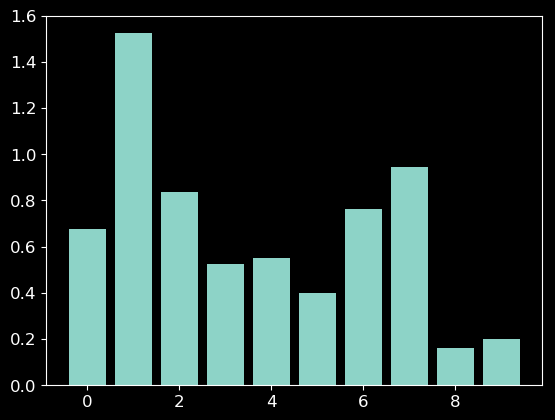

In [725]:
## Playing with David's Data: 
daviaries = [dave_array07,dave_array09,dave_array10,dave_array11]
dmetas = [meta_d07,meta_d09,meta_d10,meta_d11]



i=3
daviary, dmeta = daviaries[i],dmetas[i]

durations_list = []
for s in range(dmeta.n_songs):
    song_partials = daviary[:,:,s,2][daviary[:,:,s,0] == 2]
    mean_dur = np.nanmean(song_partials)
    #print(mean_dur,len(song_partials))

partial_daviary = daviary[daviary[:,:,:,0] == 2]
print('partial shape:',partial_daviary.shape)
dmeta.read_me()

print('shape',np.shape(daviary))

potency_plot = np.nanmean(daviary[:,5,:,0],axis=(0))
fig,ax = plt.subplots()
ax.bar(range(dmeta.n_songs),potency_plot)
fig.show()

fig2,ax2 = plt.subplots()
ax2.bar(range(dmeta.n_birds),np.nanmean(daviary[:,:,:,0],axis=(1,2)))
fig2.show()

fig3,ax3 = plt.subplots()
duration_plot = np.nanmean(daviary[:,:,:,2],axis=(0,1))
ax3.bar(range(dmeta.n_songs),duration_plot)
fig3.show()

In [12]:
david_df = pd.DataFrame(columns=['Bird','Song','Block','RelPotency','AvgPotency','Latency','Duration'],index=range(2050))

count = 0
for i in [2,3]:
    daviary, dmeta = daviaries[i],dmetas[i]

    #print(partial_daviary)
    song_list_i = range(len(dmeta.song_list))
    bird_list_i = range(len(dmeta.bird_list))

    song_list_d = dmeta.song_list
    bird_list_d = dmeta.bird_list
    song_potency = dict(zip(song_list_d,np.nanmean(daviary[:,:,:,0],axis=(0,1))))
    relative_potency = {}
    for b in range(len(bird_list_d)):
        relative_potency[bird_list_d[b]] = dict(zip(song_list_d,np.nanmean(daviary[b,:,:,0],axis=0)))

    for s in range(dmeta.n_songs):
        for b in range(dmeta.n_birds):
            for bl in range(dmeta.n_blocks):
                seq_duration = daviary[b,bl,s,2]
                seq_latency = 0
                david_df.loc[count] = [dmeta.bird_list[b],dmeta.song_list[s],bl,
                                         relative_potency[dmeta.bird_list[b]][dmeta.song_list[s]],
                                                          song_potency[dmeta.song_list[s]],seq_latency,seq_duration]
                count += 1

print(count)
david_df = david_df.infer_objects()
                                     
print(david_df)

2050
      Bird  Song  Block  RelPotency  AvgPotency  Latency  Duration
0     FOGO  MDMG      0    1.200000    0.460000        0       0.0
1     FOGO  MDMG      1    1.200000    0.460000        0       0.0
2     FOGO  MDMG      2    1.200000    0.460000        0       0.0
3     FOGO  MDMG      3    1.200000    0.460000        0       0.0
4     FOGO  MDMG      4    1.200000    0.460000        0       0.0
5     FOGO  MDMG      5    1.200000    0.460000        0       0.0
6     FOGO  MDMG      6    1.200000    0.460000        0       0.0
7     FOGO  MDMG      7    1.200000    0.460000        0       0.0
8     FOGO  MDMG      8    1.200000    0.460000        0       0.0
9     FOGO  MDMG      9    1.200000    0.460000        0       0.0
10    FR2D  MDMG      0    0.800000    0.460000        0       2.0
11    FR2D  MDMG      1    0.800000    0.460000        0       3.0
12    FR2D  MDMG      2    0.800000    0.460000        0       5.0
13    FR2D  MDMG      3    0.800000    0.460000        0 

In [20]:
print(dmeta.song_list)
print(daviary.shape)

['M2M' 'MBDY' 'MBOD' 'MDBR' 'MDMG' 'MGRG' 'MWG' 'MND' 'MLNR' 'MLB']
(15, 7, 10, 3)


In [21]:
sampled_df = david_df.sample(2000)

#md = smf.mixedlm("Duration ~ AvgPotency",data=david_df,groups=david_df["Bird"])
md = smf.mixedlm("Duration ~ AvgPotency",data=sampled_df,groups=sampled_df['Bird'])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Duration  
No. Observations: 2000    Method:             REML      
No. Groups:       21      Scale:              3.8088    
Min. group size:  65      Likelihood:         -4204.5734
Max. group size:  169     Converged:          Yes       
Mean group size:  95.2                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.506    0.261 -1.939 0.052 -1.017  0.005
AvgPotency     3.904    0.534  7.305 0.000  2.856  4.951
Group Var      0.690    0.119                           



dict_values([3, 2, 3, 2, 3, 2, 3, 2, 2, 2])


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


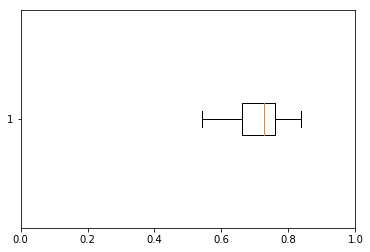

In [23]:
## Read in some song meta_data
song_timings = pd.read_csv('./playback_songs/songtiming.csv')

burble_onsets = dict(zip(song_timings['Song'],np.round(song_timings['Burble Onset'],3)))
whistle_onsets = dict(zip(song_timings['Song'],np.round(song_timings['Whistle Onset'],3)))
burble_count = dict(zip(song_timings['Song'],song_timings['Burble Count']))

fig,ax = plt.subplots()
ax.boxplot(whistle_onsets.values(),vert=False)
print(burble_count.values())
ax.set_xlim([0,1])
fig.show()

## Figure 1: Make Methods Video

Just some code to generate images, the actual processing happens elsewhere

In [505]:
seq_name = './SeqClasses/2019-05-30-07-07-56_GRG.obj'

seq = pickle.load(open(seq_name,'rb'))
print(seq.t_refraction)

[5.88100004]


In [ ]:
## Make 3d images
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

EC = np.mean(seq.smooth_data[:,[4,12]],1)
SC = np.mean(seq.smooth_data[:,[5,13]],1)
bones = [
    [0,4],  #beak-left eye
    [0,12], #beak-right eye
    [4,12], #right eye-left eye
    [20,21],#eye-center shoulder-center
    [21,7], #shoulder-center left-wrist
    [21,15],#shoulder-center right-wrist
    [21,1], #should-center keel
    [1,2],  #keel-tailbone
    [21,2], #should-center tailbone
    [15,16],#right-wrist right-wingtip
    [7,8],  #left-wrist left-wingtip
    [2,9],  #tailbone left-knee
    [9,10], #left-knee left-ankle
    [2,17], #tailbone right-knee
    [17,18],#right-knee right-ankle
    [10,11],#left-ankle left-heel
    [18,19],#right-ankle right-heel
    [2,3]   #tailbone tail-tip
    ]

bone_colors = ['brown','brown','brown','black',
               'blue','blue','green','green','green','blue','blue',
              'red','red','red','red','red','red','purple']

for t in range(len(seq.ts)):
    ax.scatter(seq.smooth_data[t,:,0],seq.smooth_data[t,:,1],seq.smooth_data[t,:,2])
    full_data = np.empty([len(seq.smooth_data),22,3])
    full_data[:,:20] = seq.smooth_data
    full_data[:,20] = EC
    full_data[:,21] = SC

    for n in range(len(bones)):
        b = bones[n]
        ax.plot(full_data[t,b,0],full_data[t,b,1],full_data[t,b,2],color=bone_colors[n])
    ax.set_xlim([0,.4])
    ax.set_ylim([0,.4])
    ax.set_zlim([0,.4])
    fig.set_size_inches(7,7)
    fig.savefig('./tmp/3d_figs/' + f'{t:04}' + '.png',dpi=300)
    ax.clear()


In [ ]:
## Make a plot images
%matplotlib inline

fig,ax = plt.subplots()
ax.set_xlim([seq.ts[0],seq.ts[-1]])
ax.set_ylim([0,.4])


for t in range(len(seq.smooth_data)):
    ax.plot(seq.ts[0:t],seq.smooth_data[0:t,3,2])
    ax.scatter(seq.ts[t],seq.smooth_data[t,3,2],s=40,color='blue')
    ## Plot lines
    if t > seq.tzero_index[0]:
        ax.axvline(seq.tzero,color='gray')
        if t > seq.t_latency_index:
            ax.axvline(seq.t_latency,color='orange')
            if t > seq.vmax_index[0]:
                ax.axvline(seq.t_vmax,color='red')
                if t > seq.stable_vel_index:
                    ax.axvline(seq.t_stable_vel,color='purple')
                    if t > seq.refraction_index[0]:
                        ax.axvline(seq.t_refraction,color='green')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Tail Height (m)')
    ax.set_xlim([seq.ts[0],seq.ts[-1]])
    ax.set_ylim([0,.4])
    
    fig.set_size_inches(7,7)
    fig.savefig('./tmp/test_figs/' + f'{t:04}' + '.png',dpi=300)
    ax.clear()

### Figure 2: Quantification of CSD

Some of these are made by hand

2.5940001010894775
birdview-2
0.7149999141693115


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


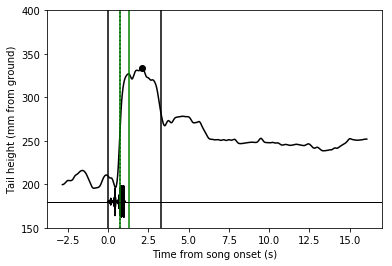

In [13]:
# Plot example figure for 2a
from scipy.io import wavfile as wf
# read audio samples
input_data = wf.read("./playback_songs/originals/BDY.wav")
audio = input_data[1]



seq = pickle.load(open('./SeqClasses/2019-06-29-10-03-17_LB.obj','rb'))

fig,ax = plt.subplots()

ts = np.arange(0,len(audio)) / input_data[0]
ax.plot(ts,audio / 1000 + 180,color='black')

ax.plot(seq.ts,seq.smooth_data[:,3,2] * 1000,color='black')
ax.axvline(0,color='black')
ax.axvline(seq.t_latency,color='black',linestyle=':')
ax.axvline(seq.t_vmax,color='green')
ax.axvline(seq.t_stable_vel,color='green')
#ax.fill_betweenx([0,500],seq.t_vmax,seq.t_stable_vel)
ax.scatter(seq.t_peak,seq.peak_height * 1000,color='black')
ax.axvline(seq.duration + seq.t_vmax,color='black')
#ax.fill_betweenx([0,500],0,5,alpha=.2,color='gray')
ax.set_ylim([150,400])
#ax.set_xlim([-1,15])

ax.set_xlabel('Time from song onset (s)')
ax.set_ylabel('Tail height (mm from ground)')

print(seq.duration)
print(seq.machine)
print(seq.t_latency)
ax.axhline(180,color='black',linewidth=1)
fig.show()

#fig.savefig('/home/ammon/Desktop/PaperFigs/ExamplePlot3a.png',dpi=300)
#fig.savefig('/home/ammon/Desktop/PaperFigs/ExamplePlot3a.svg')

In [14]:
## Grab the song offset of any particular posture (this is important for hand labeling the offsets)
## Which is super tedious, by the way

my_seq = '2019-06-03-10-37-00_LB'

files = sorted(os.listdir('./SeqClasses/'))

for s in range(len(files)):
    if my_seq in files[s]:
        seq = pickle.load(open('./SeqClasses/' + files[s],'rb'))
        print(seq.seq_name)
        print(seq.ts[0])
        
files2 = sorted(os.listdir('./CrapSeqs/'))
for s in range(len(files2)):
    if my_seq in files2[s]:
        seq = pickle.load(open('./CrapSeqs/' + files2[s],'rb'))
        print(seq.seq_name)
        print(seq.ts[0])

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


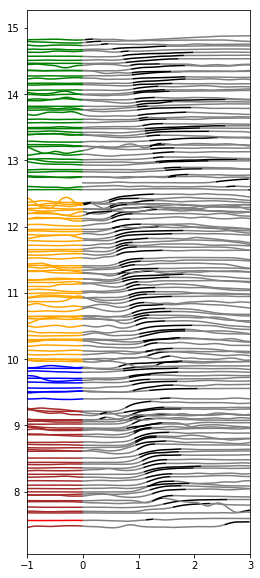

In [15]:
## Plot fig2d 
%matplotlib inline

fig,ax = plt.subplots()

files = sorted(os.listdir('./SeqClasses/'))

color_dict = {
    'CB-Red':'Red',
    'CB-Yellow':'Brown',
    'CB-LB2':'Blue',
    'CB-Orange':'Orange',
    'CB-Y2':'Green'
}

count = 0
seq_dict = {}
latency_dict = {}
for s in range(len(files)):
    seq = pickle.load(open('./SeqClasses/' + files[s],'rb'))
    if seq.offset == 0 or seq.posture != 1:
        continue
    count += 1
    
    ys = seq.smooth_data[:,3,2]
    xs = seq.ts
    if len(ys) != len(xs):
        xs = xs[:-1]
        
    zero_i = seq.tzero_index[0][0]

    vmax_t = seq.t_vmax[0]
    vmax_i = seq.vmax_index[0][0]
    peak_t = seq.t_peak
    peak_i = seq.stable_vel_index
    indices = [zero_i,vmax_i,peak_i]
    if seq.bird not in seq_dict.keys():
        seq_dict[seq.bird] = []
        latency_dict[seq.bird] = []
    stuff = [xs,ys,indices]
    seq_dict[seq.bird].append(stuff)
    latency_dict[seq.bird].append(vmax_t)
    
    "This works differently now:"
for bird in seq_dict.keys():
    sorted_latency = np.argsort(latency_dict[bird])[::-1]
    for s in sorted_latency:
    #for s in range(len(seq_dict[bird])):
        xs,ys,indices = seq_dict[bird][s]
        zero_i,vmax_i,peak_i = indices
        count += 1
        ys = ys + count * .05
        xs_base = xs[:zero_i]
        ys_base = ys[:zero_i]
        xs_pre = xs[zero_i:vmax_i]
        ys_pre = ys[zero_i:vmax_i]
        xs_mid = xs[vmax_i:peak_i]
        ys_mid = ys[vmax_i:peak_i]
        xs_post = xs[peak_i:]
        ys_post = ys[peak_i:]


        #ax.plot(xs,ys)
        base_color = color_dict[bird]
        ax.plot(xs_base,ys_base,color=base_color)
        ax.plot(xs_pre,ys_pre,color='grey')
        ax.plot(xs_mid,ys_mid,color='black')
        ax.plot(xs_post,ys_post,color='grey')

        ax.set_xlim([-1,3])


fig.set_size_inches([4,10])
fig.show()
#fig.savefig('/home/ammon/Desktop/PaperFigs/multi-plot.png',dpi=300)

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


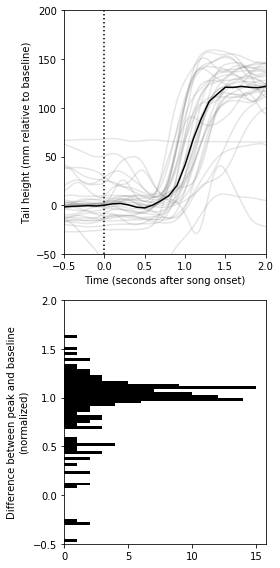

In [16]:
### Plot the distribution of peaks for fig1 

tails = []
max_tails = []
bases = []

short_list = []
max_dict = {}
base_dict = {}

fig,(ax,ax2) = plt.subplots(2)
mean_times = {}

for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    if seq.posture == 1 and seq.offset != 0:
        if seq.bird not in short_list:
            short_list.append(seq.bird)
            max_dict[seq.bird] = []
            base_dict[seq.bird] = []
        window = (seq.ts > -1) & (seq.ts < 4)
        if len(window) != len(seq.smooth_data):
            window = window[:-1]
        
        tail = seq.smooth_data[window,3,2]
        if seq.bird == 'CB-Yellow':
            ax.plot(seq.ts[window],(tail-.21) * 1000,alpha=.2,color='gray')
        
            for t in np.arange(len(window))[window]:
                if int(seq.ts[t] * 10) not in mean_times:
                    mean_times[int(seq.ts[t] * 10)] = []
                mean_times[int(seq.ts[t] * 10)].append(seq.smooth_data[t,3,2])
        
        base = tail[0]
        
        tails.append(tail)
        max_tails.append(np.max(tail))
        bases.append(base)
        max_dict[seq.bird].append(np.max(tail))
        base_dict[seq.bird].append(base)


normed_tails = []

mean_tails = np.empty(len(mean_times))
key_times = sorted(mean_times.keys())
for t in range(len(key_times)):
    mean_tails[t] = np.median(mean_times[key_times[t]])
    
ax.plot(np.array(key_times) / 10,(mean_tails - .21) * 1000,color='black')


        

#ax.plot(np.mean(np.array(tails),1))
all_tails = []
for b in short_list:
    mean_base = np.mean(base_dict[b])
    max_tail = np.max(max_dict[b])
    med_peak = np.median(max_dict[b])
    normed_tails = (np.array(max_dict[b]) - mean_base) / (med_peak - mean_base)
    #normed_bases = np.array(base_dict[b]) - np.max(base_dict[b])

    #ax.hist(normed_tails,bins=50,alpha=.7)
    all_tails.extend(normed_tails)
    #ax.hist(normed_bases,bins=50,alpha=.5)
    #ax.axvline()

    
ax.set_xlim([-.5,2])
ax.set_ylim([-50,200])
ax.axvline(0,linestyle=':',color='black')
ax.set_xlabel('Time (seconds after song onset)')
ax.set_ylabel('Tail height (mm relative to baseline)')


ax2.hist(all_tails,bins = 100,orientation='horizontal',color='black')
ax2.set_ylim([-0.5,2])
ax2.set_ylabel('Difference between peak and baseline\n(normalized)')
fig.set_size_inches(4,8)
fig.show()

fig.tight_layout()
#fig.savefig('/home/ammon/Desktop/PaperFigs/Fig2_.svg')
#fig.savefig('/home/ammon/Desktop/PaperFigs/Fig2_.png',dpi=300)

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


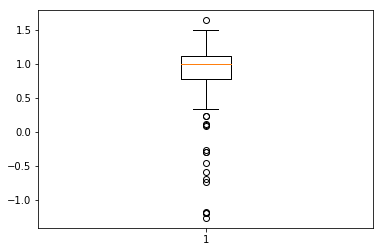

In [17]:
fig,ax = plt.subplots()
ax.boxplot(all_tails)
fig.show()

## Figure 4

Selectivity and Response rate: 

In [21]:
## Define bootstrap function


def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

def simulate_hdist(resp_rate1,resp_rate2,n_songs = 10,iterations=2000):
    iterations = 3000
    counts = np.zeros(iterations)
    base_set1 = np.zeros(n_songs)
    base_set2 = np.zeros_like(base_set1)
    n_responses1 = int(np.round(resp_rate1 * n_songs))
    n_responses2 = int(np.round(resp_rate2 * n_songs))

    base_set1[:n_responses1] = 1
    base_set2[:n_responses2] = 1

    for i in range(iterations):
        set1 = np.array(base_set1)
        set2 = np.array(base_set2)
        #random.shuffle(set1)
        random.shuffle(set2)
        #print(set1,set2)
        
        overlap = np.dot(set1,set2)
        counts[i] = overlap
        #print(overlap)

    bins = np.arange(10)
    histogram, bin_edges = np.histogram(counts,bins=bins,density=True)

    bin_centers = 0.5*(bins[1:] + bins[:-1])

    pdf = stats.norm.pdf(bin_centers)

    hist_dist = stats.rv_histogram((histogram,bins))

    return hist_dist


def build_pdf_table(n_songs):
    ratio_step = 1 / n_songs
    finished_mins = []
    finished_maxes = []
    hdist_table = {}
    #for i in np.arange(0,1 + ratio_step,ratio_step):
    for i in np.arange(n_songs): 
        #r_max = np.round(1-i,3)
        #hdist_table[r_max] = {}
        hdist_table[i] = {}
        #for j in np.arange(0,(1-i) + ratio_step,ratio_step):
        r_max = (n_songs - i)/n_songs
        for j in np.arange(0,i+1):
            r_min = j / n_songs
            
            hdist = simulate_hdist(r_max,r_min,n_songs)
            
            #hdist_table[r_max][r_min] = hdist
            hdist_table[i][j] = hdist
    return hdist_table

def pdf_bootstrapped(n_overlap,b1_ratio,b2_ratio,n_songs=10,hdist_table=None):
    if hdist_table==None:
        print('build the table')
        hdist_table = build_pdf_table(n_songs)
    b1_ratio = np.round(b1_ratio,3)
    b2_ratio = np.round(b2_ratio,3)
    indices = np.arange(0,1,1/n_songs)

    b1_index = np.argmax(indices >= b1_ratio)
    b2_index = np.argmax(indices >= b2_ratio)
    #print(b1_index,b2_index)
    #max_ratio = np.max([b1_ratio,b2_ratio])
    #min_ratio = np.max([b1_ratio,b2_ratio])
    max_index = np.max([b1_index,b2_index])
    min_index = np.min([b1_index,b2_index])
    #hdist = hdist_table[max_ratio][min_ratio]
    hdist = hdist_table[max_index][min_index]
    #p_value = 1 - hdist.cdf(n_overlap + 1)
    pdf = 1 - hdist.pdf(n_overlap)
    if pdf == 1:
        print('overlap,ratio1,ratio2')
        print(n_overlap,b1_ratio,b2_ratio)
    return pdf

hdist_dict = {}
def get_pdf(block1,block2,hdist_table=None):
    #print(block1,block2)

    ## Remove nan values 
    if np.sum(np.isnan(block1)) > 0 or np.sum(np.isnan(block2)) > 0:
        block2 = block2[~np.isnan(block1)]
        block1 = block1[~np.isnan(block1)]
        block1 = block1[~np.isnan(block2)]
        block2 = block2[~np.isnan(block2)]
    n_songs = len(block1)
    if n_songs == 0:
        return np.nan
    if max(block1) == 0 or max(block2) == 0:
        return np.nan
    if min(block1) == 1 or min(block2) == 1:
        return np.nan
    if hdist_table == None:
        if n_songs in hdist_dict.keys():
            hdist_table = hdist_dict[n_songs]
        else:
            hdist_dict[n_songs] = build_pdf_table(n_songs)
        #hdist_table = build_pdf_table(n_songs)
    n_songs = len(block1)
    n_overlap = np.dot(block1,block2)
    b1_ratio = np.mean(block1)
    b2_ratio = np.mean(block2)
    #print(n_overlap,b1_ratio,b2_ratio)
    return pdf_bootstrapped(n_overlap,b1_ratio,b2_ratio,n_songs,hdist_table)

def plot_hdist(hdist,n_songs = 10):
    fig,ax = plt.subplots()
    bin_edges = np.arange(n_songs)
    ax.plot(bin_edges[:-1], [hdist.pdf(b) for b in bin_edges[:-1]], label="PDF")
    ax.set_ylim([0,1])
    fig.show()
    
print(get_pdf([],[]))


nan


In [33]:
hdist = hdist_dict[4][2][2]
plot_hdist(hdist,n_songs=4)
print(hdist.pdf(0))

KeyError: 4

In [22]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def dtw_cost(path):
    path_array = np.array(path)
    cost_array = np.zeros_like(path_array,dtype=float)
    cost_array0 = np.zeros(len(path_array),dtype=float)
    cost_array1 = np.zeros_like(cost_array0,dtype=float)

    indices_0, counts_0 = np.unique(path_array[:,0],return_counts=True)
    indices_1, counts_1 = np.unique(path_array[:,1],return_counts=True)
    for p in range(len(path_array)):
        cost0 = counts_0[indices_0==path_array[p,0]]
        cost1 = counts_1[indices_1==path_array[p,1]]
        cost_array0[p] = np.log(cost0) / cost0
        cost_array1[p] = np.log(cost1) / cost1

    cost_array[:,0] = cost_array0
    cost_array[:,1] = cost_array1

    costs = np.sum(cost_array,0)
    #pdb.set_trace()
    cost_path = np.max(cost_array,1)
    counts = (counts_0,counts_1)
    indices = (indices_0,indices_1)
    return costs, counts, indices, cost_path

p0 = np.array([1,0,0,1,1,0])
p1 = np.array([1,0,0,1,1,0])
base_array = np.arange(len(p0))
## Fast dtw fails with identical lines. It adds unnecessary stretches, because it's inherantly cost free. 
dist,path = fastdtw(p0,p1,dist=euclidean)
print(path)
costs,_,_,_ = dtw_cost(path)
print(costs)

[(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (3, 4), (4, 4), (5, 5)]
[1.38629436 1.38629436]


In [23]:
import dtw

def stretch_cost(indices):
    cost = np.sum((np.unique(indices,return_counts=True)[1])**2) - len(indices)
    return cost

p0 = np.array([0,1,1,0,0,0,1,0])
p1 = np.array([0,1,1,0,0,1,1,0])

alignment = dtw.dtw(p0,p1,keep_internals=True)
print(alignment.distance)
print(alignment.costMatrix)
print(alignment.index1,alignment.index2)
print(np.unique(alignment.index1,return_counts=True))
cost2 = stretch_cost(alignment.index2)
cost1 = stretch_cost(alignment.index1)

print(cost2)
avg_cost = np.mean([cost1,cost2])
print(avg_cost)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

0.0
[[0. 1. 2. 2. 2. 3. 4. 4.]
 [1. 0. 0. 1. 2. 2. 2. 3.]
 [2. 0. 0. 1. 2. 2. 2. 3.]
 [2. 1. 1. 0. 0. 1. 2. 2.]
 [2. 2. 2. 0. 0. 1. 2. 2.]
 [2. 3. 3. 0. 0. 1. 2. 2.]
 [3. 2. 2. 1. 1. 0. 0. 1.]
 [3. 3. 3. 1. 1. 1. 1. 0.]]
[0 1 2 3 4 5 6 6 7] [0 1 2 3 3 4 5 6 7]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([1, 1, 1, 1, 1, 1, 2, 1]))
2
2.0


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


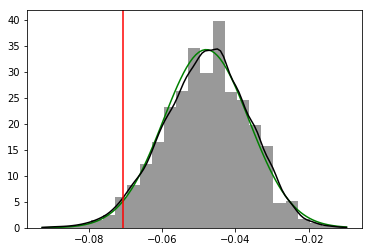

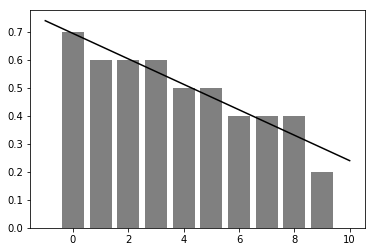

In [24]:
## Define simulation to generate confidence intervals for CSD Selectivity 
## (scrap code way down at the bottom)

# Parameter class to keep things tidy
class CSD_Params:
    def __init__(self,n_birds = 1,n_blocks=10,n_songs=10,n_iterations = 10000,
                 sort_me=True,print_me = False,plot_me=False):
        self.n_birds = n_birds
        self.n_blocks = n_blocks
        self.n_songs = 10
        self.n_iterations = n_iterations
        self.sort_me = sort_me
        self.print_me = print_me
        self.plot_me = plot_me
    def report(self):
        print('n_birds: ',self.n_birds)
        print('n_blocks: ',self.n_blocks)
        print('n_songs:',self.n_songs)
        print('n_iterations:',self.n_iterations)
        print('sorted:',self.sort_me)
"""       
class bird:
    def __init__(self,id=0,selectivity=5):
        print('make a bird class!')
        
 """       
# Given a slope and response rate, simulates a distribution and provies as 
# output: p,z-score,(mu,sigma,parameters)
def csd_sim(x_slope=None,r_response=.5,params = CSD_Params(),dist = None):
    rands = []
    if dist==None:
        if r_response == 1:
            r_response = .999
        elif r_response == 0:
            r_response = .001
        slopes = np.zeros(params.n_iterations)
        
        for i in range(params.n_iterations):
            postures = np.zeros([params.n_birds,params.n_blocks,params.n_songs])
            for n in range(params.n_birds):
                for b in range(params.n_blocks):
                    
                    for s in range(params.n_songs):
                        my_rand = np.random.random()
                        rands.append(my_rand)
                        if my_rand < r_response:
                            postures[n,b,s] = 1
                            
            ## Sum it up for each bird across blocks
            counts = np.sum(postures,1)
            """
            if params.sort_me:
                sorted_counts = np.zeros_like(counts)
                ## This should sort the mean, not each bird.
                for n in range(params.n_birds):
                    sorted_counts[n] = np.sort(counts[n])[::-1]
                counts = sorted_counts"""
                
            ratios = np.mean(counts / params.n_blocks,0)

            if params.sort_me:
                ratios = np.sort(ratios)[::-1]
            slope,intercept = np.polyfit(np.arange(len(ratios)),ratios,1)
            slopes[i] = slope
        mu,sig = (np.mean(slopes),np.std(slopes))
    else:
        mu,sig = dist
    if x_slope != None:
        z = (x_slope - mu) / sig
        p = norm.sf(abs(z))
        if not params.sort_me:
            p = p * 2
    else:
        z = mu - 1.96 * sig
        p = .05
    if params.print_me:
        print('response rate:',r_response)
        params.report()
        print('slope threshold for 95% confidence:',(mu + -1.96 * sig))
        if x_slope != None:
            print('slope: ',x_slope)
            print('z-score=',np.round(z,4))
            print('p=',np.round(p,4))
    if params.plot_me:
        fig,ax = plt.subplots()
        if dist == None:
            ax.hist(slopes,bins=25,normed=True,color='gray',alpha=.8)
            min_s = min(slopes)
            max_s = max(slopes)
            fit_kde = gaussian_kde(slopes)
        else:
            min_s = mu + -5 * sig
            max_s = mu + 5 * sig
        xs = np.linspace(min_s,max_s,100)
        ax.plot(xs,norm.pdf(xs,mu,sig),color = 'green')
        ax.plot(xs,fit_kde(xs),color='black')
        title = 'Slope Distribution'
        if x_slope != None:
            ax.axvline(x_slope,color='green')
            title += (' (p=' + str(p) + ')')
        if params.sort_me:
            pass
            #ax.set_xlim([min_s,0])
        ax.axvline(mu - 1.96 * sig,color='red')
        
        #ax.set_title(title)

        fig.show()
        fig2,ax2 = plt.subplots()
        ax2.bar(range(len(ratios)),ratios,color='gray')
        fit_line = np.poly1d(np.polyfit(np.arange(len(ratios)),ratios,1))
        ax2.plot(np.arange(-1,11),fit_line(np.arange(-1,11)),color='black')
        
        params.fig = fig2
        params.ax = ax2
        
    params.rands= rands
    import pdb
    #pdb.set_trace()
    return p,z,(mu,sig,params)

params = CSD_Params(plot_me=True,sort_me=True)
params.r_response = .5
p,z,(mu,sig,params) = csd_sim(params=params)

fig,ax = params.fig,params.ax
#ax.axvline(-0.0544,color='purple')
#ax.axvline(mu - 3.0 * sig,color='red',linestyle=':')
#ax.axvline()
#ax.set_xlim([-1,10])
fig.show()
#fig.savefig('/home/ammon/Desktop/PaperFigs/3b2.svg')


In [25]:
## Define binary arrays

lesions_birds = np.array([1,2,4,7,8,9,11,13,15,17])
control_birds = np.array([0,3,5,6,10,12,14,16])

binary_array = np.array(data_array)
binary_array[data_array[:,:,:,0] == 2] = [0,np.nan,np.nan,np.nan]

binary_array3 = np.array(bv3_array)
binary_array3[binary_array3 == .5] = 0

binary_array_all = np.zeros([25,11,10])

binary_array_all[:7] = binary_array[:,:11,:,0]
binary_array_all[7:] = binary_array3[:,:,:,0]

In [41]:
daviary = daviaries[0][:,:,:,0]
dmeta = dmetas[0]
print(np.shape(daviaries[0][:,:,:,0]))
print(np.shape(binary_array_all))
print(dmeta.bird_list)
print(np.shape(daviary))

print(dmeta.n_birds)
print(means_bybird)

(11, 12, 12)
(25, 11, 10)
['FGWL' 'FR2D' 'FRWB' 'FGWO' 'F2NL' 'FBWB' 'FLRO' 'FNWD' 'FM2N' 'FBON'
 'FN2R']
(11, 12, 12)
11


NameError: name 'means_bybird' is not defined

6
[0.2 0.5 0.1 0.  0.2 0.  0.2 0.4 0.1 0.2 0.  0.1 0.  0.  0.  0.2]
16 (16,)
[0.2 0.5 0.1 0.  0.2 0.  0.2 0.4 0.1 0.2 0.  0.1 0.  0.  0.  0.2]


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


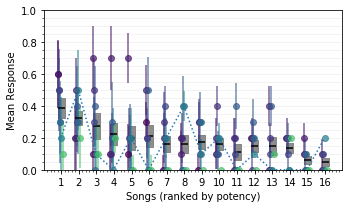

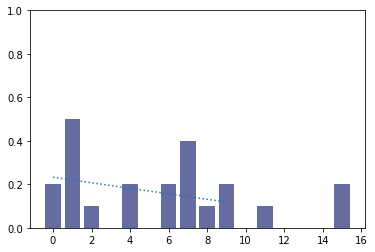

In [26]:
## plot for all the groups (FIG 4)

## plot response ratios for this group: 


#plot_array = binary_array_all
#plot_birdlist = np.hstack([bird_list,bird_list3])

i = 1

daviary = daviaries[i][:,:,:,0]
dmeta = dmetas[i]

plot_array = daviary
plot_birdlist = dmeta.bird_list

n_birds = dmeta.n_birds

means_bybird = np.nanmean(plot_array,axis=(1))
std_bybird = np.nanstd(plot_array,axis=1)
n_bybird = np.sum(~np.isnan(plot_array),axis=1)


n_birds = np.shape(plot_array)[0]
n_songs = np.shape(plot_array)[2]

canon_slopes = np.empty(n_birds)
true_slopes = np.empty_like(canon_slopes)

canon_intercepts,true_intercepts = np.empty_like(canon_slopes),np.empty_like(true_slopes)

canon_means = np.empty([n_birds,n_songs])
true_means = np.empty_like(canon_means)
true_std = np.empty_like(true_means)
true_n = np.empty_like(true_means)
for b in range(n_birds):
    ## This is the ranking (sorted by canon)
    canon_means[b] = means_bybird[b,:]
    canon_slopes[b],canon_intercepts[b] = np.polyfit(range(n_songs),canon_means[b],1) 
    #canon_slopes[b],canon_intercepts[b] = magic_polyfit(canon_means[b])
    
    ## This is the individual bird ranking
    true_means[b] = np.sort(canon_means[b])[::-1]
    true_std[b] = np.sort(std_bybird[b,:])[::-1]
    true_n[b] = np.sort(n_bybird[b,:])[::-1]
    true_slopes[b],true_intercepts[b] = np.polyfit(range(n_songs),true_means[b],1)
    #true_slopes[b],true_intercepts[b] = magic_polyfit(true_means[b])

fig,ax2 = plt.subplots()

song_means = np.nanmean(canon_means,axis=0)
song_std = np.nanstd(canon_means,axis=0)

true_order = np.argsort(song_means)[::-1]
sorted_means = canon_means[:,true_order]

non_lesions = [0,3,5,6,10,12,14,16]
#safe_indices = np.hstack([np.arange(7),np.array(non_lesions) + 7])
safe_indices = np.arange(n_birds)

#Set responsiveness threshold
r_threshold = 0.05
responsive_birds = np.array(np.nanmean(sorted_means,1) > r_threshold)
responsive_birds_safe = safe_indices[responsive_birds]

filtered_means = sorted_means[np.nanmean(sorted_means,1) > r_threshold]


#mean_bar = np.nanmean(sorted_means,axis=0)
#sem_bar = np.nanstd(sorted_means,axis=0) / np.sqrt(np.sum(~np.isnan(sorted_means),axis=0))

mean_bar = np.nanmean(filtered_means,axis=0)
sem_bar = np.nanstd(filtered_means,axis=0) / np.sqrt(np.sum(~np.isnan(filtered_means),axis=0))

desc_order = np.argsort(sorted_means[:,0])[::-1]

color_map = cm.get_cmap('viridis')
safe_indices = range(len(desc_order))
for n in range(len(desc_order)):
    i = desc_order[n]

    if responsive_birds[i] == 0 or i not in safe_indices:
        #print(i,'hide it!')
        opacity = .2
        continue
    else:
        opacity = .7
    ax2.errorbar(1 + np.arange(n_songs) + n * .4/n_birds -.2, sorted_means[i],
                 yerr = true_std[i] / np.sqrt(true_n[i]),fmt='o',color=color_map(n / len(desc_order)),alpha=opacity)
    if i == 0:
        print(n)
        ax2.plot(1 + np.arange(n_songs) + n * .4/n_birds - .2, sorted_means[i],linestyle=':')
        plot_means=sorted_means[i]
        print(plot_means)
    #fig.legend()
    
for s in range(n_songs):
    ax2.fill_between([1+s-.2,1+s+.2],mean_bar[s] + sem_bar[s],mean_bar[s] - sem_bar[s],color='gray',alpha=.9)
ax2.hlines(mean_bar,1+np.arange(n_songs)-.2,1+np.arange(n_songs) + .2,color='black')


ax2.minorticks_on()
ax2.yaxis.grid(which='major',alpha=.2)
ax2.yaxis.grid(which='minor',alpha=.2)
ax2.set_ylim((0,1))

ax2.set_xlabel('Songs (ranked by potency)')
ax2.set_ylabel('Mean Response')
ax2.set_xticklabels(np.arange(n_songs) + 1)
ax2.set_xticks(np.arange(n_songs) + 1)
fig.set_size_inches(5,3)
fig.tight_layout()
#fig.savefig('/home/ammon/Desktop/PaperFigs/3f.svg')
#fig.savefig('/home/ammon/Desktop/PaperFigs/3f.png')
fig.show()

fig2,ax2 = plt.subplots()
print(n_songs,np.shape(plot_means))
print(plot_means)

ax2.bar(range(n_songs),plot_means,color=color_map(3 / len(desc_order)),alpha=.8)
means_line = np.poly1d(np.polyfit(range(n_songs),plot_means,1))
#means_line = np.poly1d(magic_polyfit(plot_means))                                                        
ax2.plot(range(10),means_line(range(10)),linestyle=':')
ax2.set_ylim([0,1])
fig2.show()
#fig2.savefig('/home/ammon/Desktop/PaperFigs/3d2.svg')


## Figure 5

Figuring out selectivity

In [27]:
## Analyze selectivity of each group

all_song_means = np.nanmean(plot_array,axis=(1,0))

print(np.shape(all_song_means))
song_means3 = np.nanmean(binary_array3[:,:,:,0],axis=(1,0))
song_means1 = np.nanmean(binary_array3[:9,:,:,0],axis=(1,0))
song_means2 = np.nanmean(binary_array3[9:,:,:,0],axis=(1,0))
song_means0 = np.nanmean(binary_array[:,:,:,0],axis=(1,0))

print('Averaging across all, birds rank songs:')
params = CSD_Params(sort_me=True)
params.n_birds = n_birds
params.n_blocks = dmeta.n_blocks
resp_by_bird = np.zeros(params.n_birds)
sel_by_bird = np.zeros_like(resp_by_bird)
p_by_bird = np.zeros_like(resp_by_bird)
z_by_bird = np.zeros_like(resp_by_bird)


### Little test case
resp = np.nansum(plot_means) / np.sum(~np.isnan(plot_means))
sorted_song_means = all_song_means[np.argsort(all_song_means)[::-1]]
#slope,_ = magic_polyfit(sorted_song_means)
slope,_ = np.polyfit(range(len(sorted_song_means)),sorted_song_means,1)
p,z,_ = csd_sim(slope,resp,params)

print('slope=',slope,'p=',p,'z:',z,'\n')

## If we want, we can look at each individual paradigm also. 

print('Songs are correlated with eachother (strongly...)')
print(spearmanr(song_means1,song_means2))

print('\nSong means are correlated across paradigm (barely...)')
print(spearmanr(song_means0,song_means3))

print('\nSongs only weakly correlated with Canonical Rankings')
print(spearmanr(np.arange(len(all_song_means)),all_song_means))

print('\nIndividual Selectivity:')
print('0-6 are birdview, 7-24 are boxes')
count = 0
#for b in range(25):

plot_indices = np.arange(n_birds)[responsive_birds]
#plot_indices = np.arange(n_birds)
for b in plot_indices:
    print('\n--Bird:',b)
    means_nob = np.nanmean(plot_array[np.arange(len(plot_array)) != b],axis=(0,1))
    order_nob = np.argsort(means_nob)[::-1]
    order_b = np.argsort(np.nanmean(plot_array[b],0))[::-1]
    #reorder = order_nob
    reorder = order_b
    #reorder = np.arange(10)
    means_b = np.nanmean(plot_array[b],0)[reorder]
    xs = np.arange(n_songs)[~np.isnan(means_b)]
    ys = means_b[~np.isnan(means_b)]
    p = np.nansum(plot_array[b])
    q = np.sum(~np.isnan(plot_array[b]))
    if q == 0:
        print('we have a problem...')
        resp = np.nan
    else:
        resp = p / q
    print('Responsivity:',np.round(resp,3))
    resp_by_bird[b] = resp
    if len(ys) > 0:
        slope,_ = np.polyfit(xs,ys,1)
        #slope,_ = magic_polyfit(ys)
        print('Slope:',np.round(slope,3))
        params = CSD_Params(sort_me=True)
        p,z,_ = csd_sim(slope,resp,params)
        if z>0:
            d = -1
        else:
            d = 1
        if p < .05 and z < 0:
            print('***')
            count += 1
        print('p=',np.round(p,3),'z-score:',np.round(z,3))
    else:
        print('no info here')
        p = np.nan
    sel_by_bird[b] = np.log(1/p) * d
    #sel_by_bird[b] = z
    p_by_bird[b] = p
    z_by_bird[b] = z
    
print('Selective birds=',count)

(16,)
Averaging across all, birds rank songs:
slope= -0.01029411764705882 p= 0.2661950719062033 z: -0.624361590529732 

Songs are correlated with eachother (strongly...)
SpearmanrResult(correlation=0.8776799450195786, pvalue=0.0008428553839887767)

Song means are correlated across paradigm (barely...)
SpearmanrResult(correlation=0.5030487804878049, pvalue=0.1383168535504043)

Songs only weakly correlated with Canonical Rankings
SpearmanrResult(correlation=-0.3908571577779869, pvalue=0.1344173035086957)

Individual Selectivity:
0-6 are birdview, 7-24 are boxes

--Bird: 0
Responsivity: 0.138
Slope: -0.029
p= 0.335 z-score: 0.427

--Bird: 1
Responsivity: 0.362
Slope: -0.044
p= 0.442 z-score: 0.147

--Bird: 2
Responsivity: 0.188
Slope: -0.025
p= 0.102 z-score: 1.269

--Bird: 4
Responsivity: 0.138
Slope: -0.028
p= 0.298 z-score: 0.531

--Bird: 5
Responsivity: 0.219
Slope: -0.031
p= 0.191 z-score: 0.876

--Bird: 7
Responsivity: 0.056
Slope: -0.015
p= 0.213 z-score: 0.796

--Bird: 8
Responsiv

In [53]:
print(np.mean(plot_array,axis=(1)))
print(plot_array.shape)

[[0.4 0.2 0.2 0.2 0.1 0.2 0.2 0.5 0.  0.  0.1 0.  0.  0.  0.  0.1]
 [0.1 0.1 0.7 0.6 0.7 0.2 0.2 0.5 0.7 0.4 0.3 0.2 0.5 0.2 0.2 0.2]
 [0.  0.1 0.2 0.5 0.3 0.4 0.1 0.3 0.2 0.1 0.1 0.1 0.2 0.1 0.1 0.2]
 [0.  0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0. ]
 [0.2 0.  0.1 0.6 0.1 0.  0.1 0.2 0.1 0.  0.  0.1 0.3 0.2 0.  0.2]
 [0.2 0.  0.2 0.5 0.5 0.3 0.4 0.2 0.1 0.2 0.3 0.  0.2 0.2 0.2 0. ]
 [0.  0.  0.  0.1 0.2 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.1 0.  0.  0.2 0.2 0.1 0.  0.  0.  0.2 0.  0. ]
 [0.  0.  0.  0.3 0.  0.  0.2 0.3 0.2 0.  0.3 0.1 0.  0.  0.  0.2]
 [0.  0.  0.  0.1 0.2 0.1 0.  0.1 0.  0.  0.  0.  0.  0.  0.2 0. ]
 [0.2 0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.4 0.  0.2 0.3 0.4 0.2 0.1 0.4 0.3 0.4 0.3 0.  0.5 0.2 0.4 0.3]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0. ]
 [0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
(14, 10, 16)


In [40]:
responsive_birds_safe = np.intersect1d(responsive_birds,np.arange(11))
print(responsive_birds,safe_indices)
print(responsive_birds_safe)
print(np.arange(n_birds)[responsive_birds])

[ True  True  True False  True  True False  True  True False False  True
 False False] range(0, 14)
[0 1]
[ 0  1  2  4  5  7  8 11]


14
14
SpearmanrResult(correlation=-0.8152568365321721, pvalue=0.0003805971450443644)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


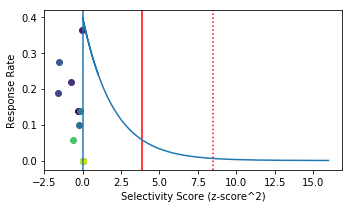

In [28]:
### plot selectivity vs responsivity for fig4 c 

fig,ax = plt.subplots()
#print(np.shape(resp_by_bird),np.shape(sel_by_bird))
print(len(resp_by_bird))
n_birds = len(resp_by_bird)
print(n_birds)
for n in range(n_birds):
    i = desc_order[n]
    #ax.scatter(sel_by_bird[i],resp_by_bird[i],color=color_map(n/n_birds))
    ax.scatter(z_by_bird[i] * np.abs(z_by_bird[i]) * -1,resp_by_bird[i],color=color_map(n/n_birds))
"""    if i == 5:
        ax.scatter(sel_by_bird[i],resp_by_bird[i],color=color_map(n/n_birds),s=200)"""

#ax.axvline(np.log(1/.05),color='red')
#ax.axvline(np.log(25/.05),linestyle=':',color='red')


z1 = norm.ppf(.975)
z2 = norm.ppf((1- .025/n_birds))
ax.axvline(z1 ** 2,color='red')
ax.axvline(z2 ** 2,linestyle=':',color='red')
ax.set_ylabel('Response Rate')
ax.set_xlabel('Selectivity Score (z-score^2)')

#print(resp_by_bird,sel_by_bird)

z_scores = np.arange(-1,4,.0001)
p_values = norm.sf(abs(z_scores))
#print(p_values)

log_p_values = np.log(1/p_values) * np.sign(z_scores)

norm_ys = norm.pdf(z_scores,0,1)
#print('look at this:')
#print(log_p_values,norm_ys)
ax.plot(z_scores **2,norm_ys)
ax.axvline(0)
#ax.set_xlim([min(resp_by_bird)-1,max(resp_by_bird)])
#ax.set_ylim([min(sel_by_bird)-1,max(sel_by_bird)])

### Responsivity and selectivity are positively correlated, 
### but that can be interepreted as "p values are better when you have larger sample sizes"
print(spearmanr(resp_by_bird[~np.isnan(resp_by_bird)],sel_by_bird[~np.isnan(resp_by_bird)]))

fig.set_size_inches(5,3)
fig.tight_layout()
#fig.savefig('/home/ammon/Desktop/PaperFigs/3e.svg')
#fig.savefig('/home/ammon/Desktop/PaperFigs/3e.png')
fig.show()

[ 3  7  4  8  2 12  5  0 10  6 14 15  9 13 11  1]


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


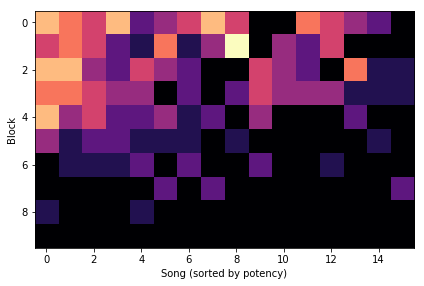

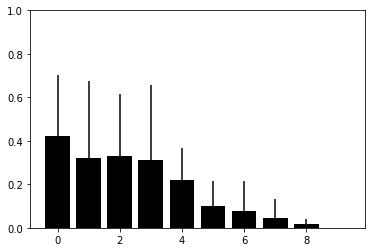

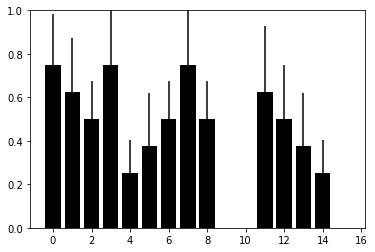

In [29]:
## Figures 5a,b,c Get mean response rate by block:
block_responses = np.nanmean(plot_array[plot_indices],2)

## Get mean response rate by song
song_means = np.nanmean(plot_array,axis=(0,1))
true_order = np.argsort(song_means)[::-1]
song_order = range(n_songs)
song_order = true_order
print(song_order)

mean_responses = np.nanmean(plot_array[plot_indices],0)[:,song_order]
errs4 = np.nanstd(plot_array[plot_indices],0)[0,song_order]
fig,ax = plt.subplots()
#fig1,ax1 = plt.subplots()
#ax1.imshow(block_responses)
#fig1.show()
#fig2,ax2 = plt.subplots()

ax.imshow(mean_responses,vmin=0,cmap='magma')

#ax2.imshow(mean_responses / np.sum(mean_responses,1)[:,None],vmin=0,cmap='magma')


normed_responses = mean_responses / np.sum(mean_responses,1)[:,None]


bird_responses = np.nanmean(plot_array[plot_indices],2)
bird_order = np.argsort(np.sum(bird_responses,1))[::-1]

#ax1.imshow(np.transpose(bird_responses[bird_order])[:,:])
#ax1.imshow(np.transpose(binary_array_all[19,:,song_order]),vmin=0,cmap='magma')


#for b in plot_indices:
#    slope,intercept = np.polyfit(range(len(bird_responses[b])),bird_responses[b],1)
#ax1.imshow(mean_responses / np.sum(mean_responses,1)[:,None],vmin=0)


ax.set_xlabel('Song (sorted by potency)')
ax.set_ylabel('Block')
"""
ax1.set_xlabel('Song (sorted by potency)')
ax1.set_ylabel('Block')

ax2.set_xlabel('Song (sorted by potency)')
ax2.set_ylabel('Block (Rows Normalized)')
"""

fig.show()
#fig1.show()
#fig2.show()

fig.tight_layout()
#fig1.tight_layout()
#fig2.tight_layout()

"""fig.savefig('/home/ammon/Desktop/PaperFigs/6b_.svg')
fig1.savefig('/home/ammon/Desktop/PaperFigs/6a_.svg')
fig2.savefig('/home/ammon/Desktop/PaperFigs/6c_.svg')
"""
fig3,ax3 = plt.subplots()

#bs_to_plot = np.arange(8,15)[np.arange(8,15) != 10]
bs_to_plot = np.arange(len(block_responses))
y_errs = np.nanstd(block_responses[bs_to_plot],0)

n_blocks = dmeta.n_blocks
ax3.bar(range(n_blocks),np.nanmean(block_responses[bs_to_plot],0),yerr=y_errs,color='black')
"""
for b in bs_to_plot:
    ax3.scatter(np.arange(11)+(b-7)*.1-.5,block_responses[b])"""
    
ax3.set_ylim([0,1])
fig3.show()

fig4,ax4 = plt.subplots()
errs4 = errs4 / np.sqrt(len(plot_indices))
ax4.bar(np.arange(n_songs),mean_responses[0,:],yerr=errs4,color='black')
ax4.set_ylim([0,1])
fig4.show()
#fig3.savefig('/home/ammon/Desktop/PaperFigs/6e_.svg')

(14, 10, 16)
(8, 16)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


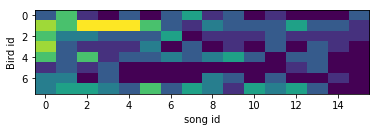

In [30]:
print(plot_array.shape)

bird_responses_by_song = np.nanmean(plot_array[plot_indices],1)
subplot_indices = [np.arange(15) != 6]
#bird_responses_by_song = bird_responses_by_song[subplot_indices]
print(np.shape(bird_responses_by_song))
fig,ax = plt.subplots()
ax.imshow(bird_responses_by_song[:,song_order],aspect=.5)
ax.set_xlabel('song id')
ax.set_ylabel('Bird id')


fig.show()

In [31]:
## Same as above, but for all the birds (birdview3 and birdview)

## Plot the emergence (or divergence...or neither) of selectivity over time using simulated distributions

bird_array = plot_array

#n_blocks = 11
n_birds = len(bird_array)

resp_list = []
resp_array = np.empty([n_blocks,n_birds])
resp_array.fill(np.nan)
slope_array = np.empty([n_blocks,n_birds])
p_array = np.empty_like(slope_array)
slope_array.fill(np.nan)
p_array.fill(np.nan)
for f in plot_indices:
    for b in range(n_blocks):
        block_n = bird_array[f,b,:]
        
        block_n = block_n[true_order]
        #block_n = block_n[np.argsort(block_n)[::-1]]

        #mean_response = true_means[f,:]
    
        #mean_response = mean_response[~np.isnan(block_n)]
        #block_n = block_n[~np.isnan(block_n)]
        
        responsivity = np.nanmean(block_n)
        resp_list.append(responsivity)
        resp_array[b,f] = responsivity
        if np.nansum(block_n) < 1:
            pass
            #continue
        if len(block_n[~np.isnan(block_n)]) < 3:
            continue
        #print(block_n)
        
        trimmed_block = block_n[~np.isnan(block_n)]
        
        trimmed_xs = np.arange(len(block_n))[~np.isnan(block_n)]
        slope,_ = np.polyfit(trimmed_xs,trimmed_block,1)
        #slope,_ = magic_polyfit(trimmed_block)
        #print(slope)

        slope_array[b,f] = slope
        params = CSD_Params(n_birds=1,n_blocks=1,sort_me=False)
        p,z,_ = csd_sim(slope,responsivity,params=params)
        print('slope:',slope,'responsivity:',responsivity)
        if p < .1:
            print('****')
        print(p,z)
        ## This happens when responsivity == 1
        if responsivity == 1 or responsivity == 0:
            p_array[b,f] = np.nan
        elif p==0:
            print('p == 0!...')
            p_array[b,f] = np.nan
        elif z > 0:
            #p_array[b,f] = -1 * np.log(1/p)
            p_array[b,f] = z**2 * -1
        else:
            #p_array[b,f] = np.log(1/p)
            p_array[b,f] = z**2
     

slope: -0.03970588235294116 responsivity: 0.3125
0.43094111479225594 -0.787582225651487
slope: -0.04999999999999996 responsivity: 0.25
0.28804486962513964 -1.062420415692647
slope: -0.022058823529411752 responsivity: 0.0625
0.40068309231652477 -0.8404018855271784
slope: 0.0 responsivity: 0.0
0.9911737400922183 0.0110623019418919
slope: -0.03529411764705882 responsivity: 0.125
0.3323053600552752 -0.9694807904430186
slope: 0.0 responsivity: 0.0
0.9954807825091588 -0.005664029455567261
slope: -0.02058823529411764 responsivity: 0.375
0.7003255606785631 -0.3848810306593596
slope: 0.04117647058823529 responsivity: 0.25
0.3930445229264814 0.8541091349032226
slope: 0.0 responsivity: 0.0
0.9918796445724807 0.010177531956391712
slope: 0.0 responsivity: 0.0
0.993857760458149 -0.007698231688328053
slope: -0.05735294117647056 responsivity: 0.8125
0.18418435037105796 -1.3279811010809672
slope: -0.06470588235294117 responsivity: 0.625
0.22852561528798332 -1.2041655060589853
slope: -0.0088235294117646

/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars


slope: -0.07352941176470584 responsivity: 1.125
****
0.0 -inf
p == 0!...
slope: -0.06911764705882349 responsivity: 0.6875
0.17587899992481415 -1.353553094996615
slope: 0.0 responsivity: 0.0
0.9977205169125882 -0.002856912265548099
slope: 0.0 responsivity: 0.0
0.9976769540523938 0.0029115104411901963
slope: 0.0 responsivity: 0.0
0.994038398040963 -0.007471829538904647
slope: 0.0 responsivity: 0.0
0.9939268654411086 -0.0076116188985728495
slope: 0.0 responsivity: 0.0
0.9989536135050278 -0.0013114513631731753
slope: 0.0 responsivity: 0.0
0.9967538836856605 0.004068414691502992
slope: 0.0 responsivity: 0.0
0.9918550164854725 0.010208400289530559


In [928]:
print(np.polyfit([0],[0],1))


[nan  0.]


/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:584: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:586: RuntimeWarning: invalid value encountered in true_divide
  c = (c.T/scale).T  # broadcast scale coefficients
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ammon/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  0.5*df, 0.5, np.fmin(np.asarray(df / (df + t_squared)), 1.0)
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


95% CI for dur slope is [-0.11797048  0.06347897]
Pearsons r: -0.107
p: 0.4943436690378308
14 10 16


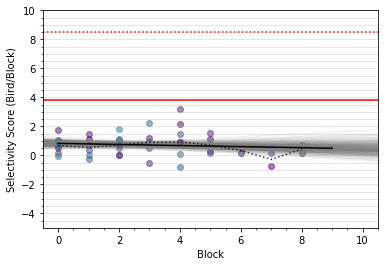

In [32]:
## Plot everything Fig5

fig,ax = plt.subplots()

xpoint_list = []
ypoint_list = []
ypoints_byblock = []
y_means = []

for n in range(n_blocks):
    #ax.scatter([n]*n_birds,slope_array[n,:])
    #good_points = slope_array[n,:][~np.isnan(slope_array[n,:])]
    #good_points = p_array[n,:][~np.isnan(p_array[n,:])]

    good_points = p_array[n,responsive_birds_safe][~np.isnan(p_array[n,responsive_birds_safe])]

    #good_points = np.clip(good_points,-.1,.1)
    #print(good_points)
    good_xs = [n] * len(good_points)
    ypoint_list.extend(good_points)
    y_means.append(np.median(good_points))
    xpoint_list.extend(good_xs)
    #print(n,good_points)
    ypoints_byblock.append(good_points)
    #ax.scatter(good_xs,good_points)
#print(ypoints_byblock)

#n_birds = 25
for f in range(n_birds):
    if responsive_birds[f] == 0 or f not in plot_indices:
        #print('skip me!',f)
        continue
    good_points = p_array[:,f][~np.isnan(p_array[:,f])]
    ys = p_array[:,f][~np.isnan(p_array[:,f])]
    xs = np.argwhere(~np.isnan(p_array[:,f]))
    xs = np.reshape(xs,len(ys))
    ax.scatter(xs,ys,color=color_map(f/25),alpha = .5)
    r,p = pearsonr(xs,ys)
    #print(r,p)
    if p < .05 and False:
        ax.plot(xs,ys,linestyle=':',alpha=.5,color='gray')
    if f == 5 and False:
        ax.plot(xs,ys,alpha=.5,color=color_map(f/25))

boxes = []
for b in range(len(p_array)):
    boxes.append(p_array[b,responsive_birds_safe][~np.isnan(p_array[b,responsive_birds_safe])])

    
#ax.boxplot(boxes,positions=range(11),showmeans=True)
xpoint_array = np.array(xpoint_list)
ypoint_array = np.array(ypoint_list)



#slope,intercept = np.polyfit(xpoint_array[ypoint_array >= 0],ypoint_array[ypoint_array >= 0],1)
#corr,p_value = pearsonr(xpoint_array[ypoint_array >= 0],ypoint_array[ypoint_array >= 0])
slope,intercept = np.polyfit(xpoint_array,ypoint_array,1)
corr,p_value = pearsonr(xpoint_array,ypoint_array)

### DO some bootstrapping
sel_slope_reps, sel_intercept_reps = draw_bs_pairs_linreg(x=xpoint_array, y=ypoint_array, size=5000)
#dur_slope_reps, dur_intercept_reps = draw_bs_pairs_linreg(x=np.array(dur_xs), y=np.array(dur_ys), size=5000)


x = np.array([-1,11])
#plt.figure(figsize=(10, 8))

# Plot the bootstrap lines
for i in range(1000):
    _ = ax.plot(x, sel_slope_reps[i]*x + sel_intercept_reps[i],
                 linewidth=0.2, alpha=0.1, color='gray')

fit_line = np.poly1d([slope,intercept])

#ax.boxplot(ypoints_byblock,positions=np.arange(len(ypoints_byblock)),notch=True,bootstrap=5000)
#print(slope,intercept)
#ax.set_ylim([-4,6])
ax.set_xlabel('Block')
ax.set_ylabel('Selectivity Score (Bird/Block)')

ax.minorticks_on()

ax.yaxis.grid(which='major',alpha=.4)
ax.yaxis.grid(which='minor',alpha=.4)

ax.set_xlim([-.5,10.5])
ax.set_ylim([-5,10])

ax.axhline(z1 ** 2,color='red')
ax.axhline(z2 ** 2,linestyle=':',color='red')



#ax.plot(range(11),2 * np.log(np.arange(1,12)),color='black',alpha=.8,linestyle=':')
ax.plot(fit_line(np.arange(n_blocks)),color='black')
ax.plot(range(n_blocks),y_means,color='black',alpha=.8,linestyle=':')

fig.show()
print("95% CI for dur slope is {}".format(np.percentile(sel_slope_reps, [2.5, 97.5])))

print('Pearsons r: %.3f' % corr)
print('p:',p_value)
 
print(n_birds,n_blocks,n_songs)

#fig.savefig('/home/ammon/Desktop/PaperFigs/6d_sorted.svg')

[2.4369949  2.66597614]
Duration
(0.13698146995906188, 0.11450388950363624)
Latency
(0.012403307249619275, 0.8868912345128206)


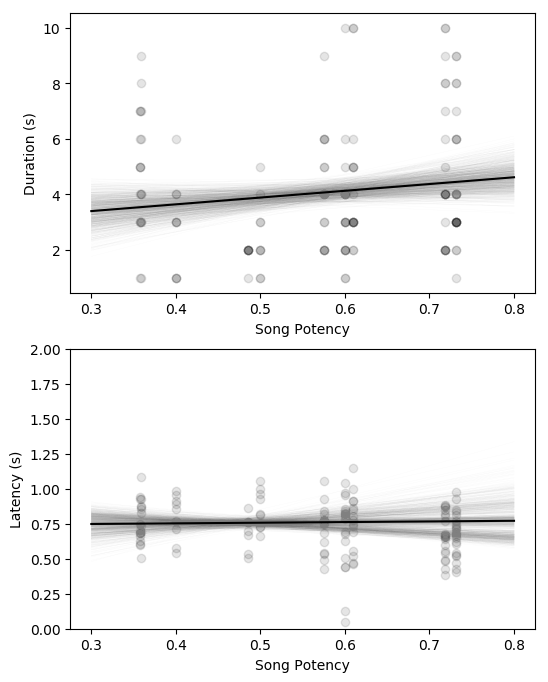

In [883]:
## Plot all duruation and latency birds (using hand labeled duration/latency)

fig,(ax1,ax2) = plt.subplots(2)

### DO some bootstrapping
dur_slope_reps, dur_intercept_reps = draw_bs_pairs_linreg(x=np.array(trimmed_df['AvgPotency']), 
                                                          y=np.array(trimmed_df['Duration']), size=1000)
lat_slope_reps, lat_intercept_reps = draw_bs_pairs_linreg(x=np.array(trimmed_df['AvgPotency']), 
                                                          y=np.array(trimmed_df['Latency']), size=1000)
#dur_slope_reps, dur_intercept_reps = draw_bs_pairs_linreg(x=np.array(dur_xs), y=np.array(dur_ys), size=5000)


x = np.array([0.3,0.8])
#plt.figure(figsize=(10, 8))

# Plot the bootstrap lines
for i in range(1000):
    _ = ax2.plot(x, lat_slope_reps[i]*x + lat_intercept_reps[i],
                 linewidth=0.2, alpha=0.05, color='gray')
    _ = ax1.plot(x, dur_slope_reps[i]*x + dur_intercept_reps[i],
                linewidth=0.2,alpha=0.05,color='gray')

print(np.polyfit(trimmed_df['AvgPotency'],trimmed_df['Duration'],1))
dur_fitline = np.poly1d(np.polyfit(trimmed_df['AvgPotency'],trimmed_df['Duration'],1))
lat_fitline = np.poly1d(np.polyfit(trimmed_df['AvgPotency'],trimmed_df['Latency'],1))

ax1.plot(x,dur_fitline(x),color='black')
ax2.plot(x,lat_fitline(x),color='black')
ax1.scatter(trimmed_df['AvgPotency'],trimmed_df["Duration"],alpha=.1,color='black')

ax2.scatter(trimmed_df['AvgPotency'],trimmed_df['Latency'],alpha=.1,color='black')

ax2.set_ylim([0,2])
ax2.set_ylabel('Latency (s)')
ax1.set_ylabel('Duration (s)')
ax1.set_xlabel('Song Potency')
ax2.set_xlabel('Song Potency')
fig.set_size_inches(6,8)
fig.show()

print('Duration')
print(pearsonr(trimmed_df['AvgPotency'],trimmed_df['Duration']))

print('Latency')
print(pearsonr(trimmed_df['AvgPotency'],trimmed_df['Latency']))

#Add bootstrapped confidence intervals around best fit line

In [212]:
## Define concordance metrics

# concordance is the percentage of poses that match, we'll do this pairwise for every bird for every block
def sort_blocks(block_tuplet):
    block0,block1 = block_tuplet
    if np.nansum(block0) >= np.nansum(block1):
        b0,b1 = 1,0
    else:
        b0,b1 = 0,1
    return (block_tuplet[b0],block_tuplet[b1])
    
def block_concordance(block1,block2):
    b0,b1 = sort_blocks([block1,block2])
    b0_indices = np.argwhere(b0)[:,0]
    count = 0
    for i in b0_indices:
        if b0[i] == b1[i]:
            count += 1
    concordance = count / np.sum(b0)
    return concordance

def concordance_mean(block,avg_response):
    n_responses = int(np.sum(block))
    if n_responses == 0:
        return np.nan
    sorted_avg = np.argsort(avg_response)[::-1]
    responses = np.argwhere(block)[:,0]
    top_responses = sorted_avg[:n_responses]
    count = 0
    for i in responses:
        if i in top_responses:
            count += 1
    concordance = count / n_responses
    return concordance

import dtw

def stretch_cost(indices):
    cost = np.sum((np.unique(indices,return_counts=True)[1])**2) - len(indices)
    return cost

def dtw_concordance(block1,block2):
    if len(block1) <1 or len(block2) < 1:
        return np.nan

    if np.sum(np.isnan(block1)) > 0 or np.sum(np.isnan(block2)) > 0:
        if np.sum(np.isnan(block1)) > 0:
            block2 = block2[~np.isnan(block1)]
            block1 = block1[~np.isnan(block1)]
        if np.sum(np.isnan(block2)) > 0:

            block1 = block1[~np.isnan(block2)]
            block2 = block2[~np.isnan(block2)]
    block1_padded = np.zeros(len(block1) + 2)
    block2_padded = np.zeros(len(block2) + 2)
    block1_padded[1:-1] = block1
    block2_padded[1:-1] = block2  
    
    print(block1_padded,block2_padded)
    alignment = dtw.dtw(block1_padded,block2_padded)
    cost1 = stretch_cost(alignment.index1)
    cost2 = stretch_cost(alignment.index2)
    return np.mean([cost1,cost2])


b2= np.array([1,1,1,0,0])
b3= np.array([1,0,np.nan,1,1])
b_mean = [.2,.6,.3,.2,.1]
print(block_concordance(b2,b3))
print(concordance_mean(b2,b_mean))
print(dtw_concordance(b2,b3))

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

nan
0.6666666666666666
[0. 1. 1. 0. 0. 0.] [0. 1. 0. 1. 1. 0.]
6.0


In [769]:
# I don't think I need this...
"""## Analyze the emergence of selectivity (Not sure what this is...) (using slope simulation)
## for each block

## get the slope for every bird
## Add it to a list (along with the 0 points, similar to before, but a different metric)

## Plot the emergence (or divergence...or neither) of selectivity over time
n_blocks = 11
n_birds = 7
latency_list = []
duration_list = []
resp_list = []
slope_array = np.empty([n_blocks,n_birds])
p_array = np.empty_like(slope_array)
p_array.fill(np.nan)
slope_array.fill(np.nan)
print('working on it....')
for f in range(n_birds):
    for b in range(n_blocks):
        block_n = binary_array[f,b,:,0]

        
        block_n = block_n[true_order]

        #mean_response = true_means[f,:]
    
        #mean_response = mean_response[~np.isnan(block_n)]
        #block_n = block_n[~np.isnan(block_n)]
        
        latencies = np.array(data_array[f,b,:,1])
        durations = np.array(data_array[f,b,:,2])
        latencies[data_key[f,b,:,2] == 0] = np.nan
        durations[data_key[f,b,:,2] == 0] = np.nan

        if len(latencies[~np.isnan(latencies)]) > 0 and len(block_n[~np.isnan(block_n)]) > 1:
            responsivity = np.nanmean(block_n)
            mean_latency = np.nanmean(latencies)
            mean_duration = np.nanmean(durations)
            latency_list.append(mean_latency)
            duration_list.append(mean_duration)
            resp_list.append(responsivity)
        else:
            print('no responses!')
            responsivity = 0
        latency = np.nanmean(data_array[f,b,:,0])
        if np.nansum(block_n) < 1:
            pass
            #continue
        if len(block_n[~np.isnan(block_n)]) < 3:
            continue
        #print(block_n)
        
        trimmed_block = block_n[~np.isnan(block_n)]
        
        trimmed_xs = np.arange(len(block_n))[~np.isnan(block_n)]
        slope,_ = np.polyfit(trimmed_xs,trimmed_block,1)
        #print(slope)

        slope_array[b,f] = slope
        params = CSD_Params(n_birds=1,n_blocks=1,sort_me=False)
        p,z,_ = csd_sim(slope,responsivity,params=params)
        #print('slope:',slope,'responsivity:',responsivity)
        #print(p,z)
        ## This happens when responsivity == 1
        if p==0:
            print('p == 0!...')
            p_array[b,f] = 0
        elif z > 0:
            p_array[b,f] = -1 * np.log(1/p)
        else:
            p_array[b,f] = np.log(1/p)"""

pass

14
[0 2 8 7 4 1 6 3 5 9]
[0 1 2 3 4 5 6 7]


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


build the table
build the table
overlap,ratio1,ratio2
4.0 0.444 0.889
build the table
overlap,ratio1,ratio2
2.238447000446802 0.889 0.268
overlap,ratio1,ratio2
2.238447000446802 0.889 0.268
overlap,ratio1,ratio2
2.238447000446802 0.889 0.268
overlap,ratio1,ratio2
2.238447000446802 0.889 0.268
overlap,ratio1,ratio2
2.238447000446802 0.889 0.268
overlap,ratio1,ratio2
2.238447000446802 0.889 0.268
overlap,ratio1,ratio2
2.238447000446802 0.889 0.268
overlap,ratio1,ratio2
2.238447000446802 0.889 0.268
overlap,ratio1,ratio2
2.9833333333333334 0.889 0.376
overlap,ratio1,ratio2
3.9027777777777777 0.889 0.489
overlap,ratio1,ratio2
2.900793650793651 0.889 0.322
overlap,ratio1,ratio2
2.25 0.889 0.25
overlap,ratio1,ratio2
4.457142857142857 0.889 0.523
overlap,ratio1,ratio2
3.0 0.9 0.4
overlap,ratio1,ratio2
2.4091787077638753 0.9 0.271
overlap,ratio1,ratio2
2.4091787077638753 0.9 0.271
overlap,ratio1,ratio2
2.4091787077638753 0.9 0.271
overlap,ratio1,ratio2
2.4091787077638753 0.9 0.271
overlap,rati

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


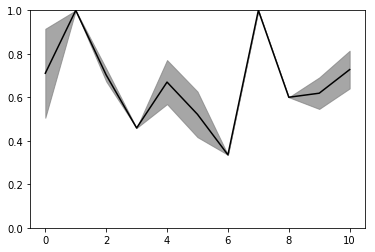

In [35]:
#Measure concordances for fig 5e,f
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy import stats

print(len(safe_indices))
conc_matrix = np.empty([11,28])
global_conc_matrix = np.empty([11,8])
local_conc_matrix = np.empty_like(global_conc_matrix)
conc_matrix.fill(np.nan)
global_conc_matrix.fill(np.nan)
local_conc_matrix.fill(np.nan)

safe_indices = np.hstack([np.arange(7),np.array(non_lesions) + 7])
song_order = np.argsort(np.nanmean(binary_array_all[safe_indices],axis=(0,1)))[::-1]
print(song_order)
print(bs_to_plot)
good_birds = binary_array_all[safe_indices][:,:,song_order][bs_to_plot]


Y0 = np.nanmean(good_birds,axis=(0,1))
Y = np.repeat([Y0],len(good_birds),axis=0)
Z = np.nanmean(good_birds,axis=1)

for b in range(11):
    X = binary_array_all[safe_indices,b][:,song_order][bs_to_plot]
    pairwise_concs = pdist(X,metric=get_pdf)
    #print(pairwise_concs)
    ## A little bit hacky, but fast and saves some for loops
    #print(X,Y)
    global_conc_matrix[b] = np.diagonal(cdist(X,Y,metric=get_pdf))
    local_conc_matrix[b] = np.diagonal(cdist(X,Z,metric=get_pdf))
    conc_matrix[b] = pairwise_concs

fig,ax = plt.subplots()
conc_means = np.nanmean(conc_matrix,1)
conc_std = np.nanstd(conc_matrix,1)
conc_counts = np.count_nonzero(~np.isnan(conc_matrix),1)
conc_errors = np.divide(conc_std,np.sqrt(conc_counts))
xs = np.arange(11)

#ax.plot(conc_means + conc_errors)
#ax.plot(conc_means - conc_errors)
ax.fill_between(xs,conc_means + conc_errors,conc_means-conc_errors,color='gray',alpha=.7)

ax.plot(xs,conc_means,color='black')
ax.set_ylim([0,1])

fig.show()

"""
fig1,ax1 = plt.subplots()
ax1.plot(np.nanmean(global_conc_matrix,1))
fig1.show()
"""
"""
fig1,(ax1,ax2) = plt.subplots(2,sharex=True,sharey=True)
ax1.plot(np.nanmean(global_conc_matrix,1))
ax2.plot(np.nanmean(local_conc_matrix,1))
ax1.set_ylim(0,1)
fig1.show()"""
pass

In [48]:
print(binary_array_all.shape)
np.argsort(np.nanmean(binary_array_all[safe_indices],axis=(0,1)))[::-1]

(25, 11, 10)


array([0, 2, 8, 7, 4, 1, 6, 3, 5, 9])

In [49]:
conc_matrix[1]

array([nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

[0.7145     1.         0.71433333 0.47466667 0.66144444 0.52241667
 0.33266667 1.         0.60966667 0.615      0.72066667]
[ 0  1  2  3  4  5  6  7  8  9 10]


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


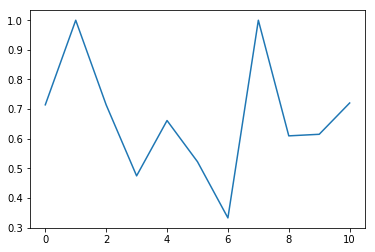

In [50]:
fig,ax = plt.subplots()
ax.plot(xs,conc_means)
fig.show()
print(conc_means)
print(xs)

In [51]:
print(dave_array10.shape)
print(dave_array11.shape)
print(dave_array07.shape,meta_d07.song_list)
print(dave_array09.shape,meta_d09.song_list)

(10, 10, 10, 3)
(15, 7, 10, 3)
(11, 12, 12, 3) ['MB2M' 'MMOL' 'MBDY' 'MLNR' 'MW2R' 'MBWD' 'MYLO' 'MNGO' 'MYRM' 'M2YL'
 'MN2W' 'MLYR']
(14, 10, 16, 3) ['MOup' 'MM2Dup' 'MONup' 'MNDdown' 'MBDYdown' 'MMGup' 'MBDYup' 'M2Mdown'
 'MONdown' 'MNDup' 'MOdown' 'M2Mup' 'MMGdown' 'MWGup' 'MM2Ddown' 'MWGdown']


In [44]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom

ncr(10,3)

120

In [47]:
print(X.shape)
X = np.array([[1,1,0],[0,1,0],[1,0,1]])
def mix_rows(X):
    Y = np.array(X)
    for i in range(len(X)):
        #print(X[i])
        Y[i] = X[i][np.random.permutation(X.shape[1])]
        #print([X[i]])
    return Y

print(mix_rows(X))

(7, 10)
[[1 1 0]
 [0 0 1]
 [0 1 1]]


(7, 14, 10)


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/

(18, 11, 10)


/home/ammon/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2345: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(11, 12, 12)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(14, 10, 16)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(10, 10, 10)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(15, 7, 10)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


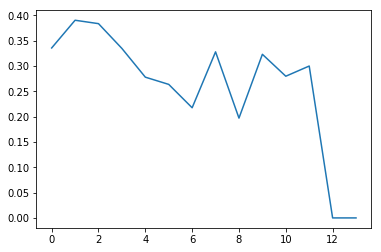

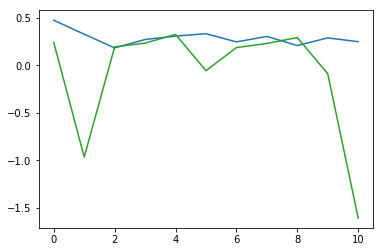

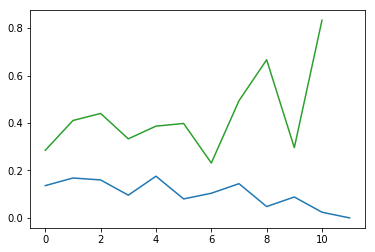

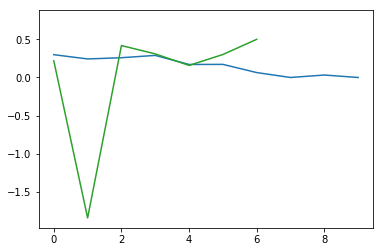

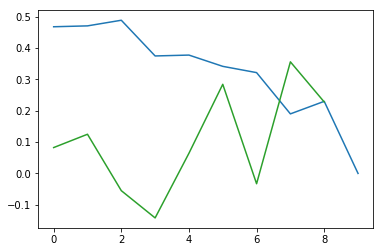

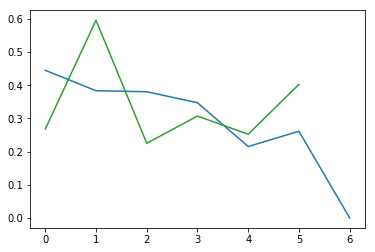

In [48]:
#Measure concordances for fig 5e,f
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist

# 10 choose 2 = 45
# 15 choose 2 = 105
# 11 choose 2 = 55
max_blocks = 14
max_songs = 16
iterations = 1000
all_aviaries = [binary_array,binary_array3,dave_array07,dave_array09,dave_array10,dave_array11]

sig_means = np.empty([len(all_aviaries),max_blocks])

sig_means.fill(np.nan)
sig_random = np.array(sig_means)
sig_difference = np.array(sig_means)

all_median_distances_by_song = np.empty([len(all_aviaries),max_blocks,max_songs])
all_median_distances_by_song.fill(np.nan)
top_stds = np.empty([len(all_aviaries),max_blocks])
top_stds.fill(np.nan)
for a in range(len(all_aviaries)):
    
    
    daviary= all_aviaries[a][:,:,:,0]
    print(np.shape(daviary))
    daviary[daviary == 2] = 0
    #daves_birds = daviary[:,song_order,:]
    #daves_birds = daviary
    n_blocks = daviary.shape[1]
    n_songs = daviary.shape[2]
    n_birds = daviary.shape[0]
    pairwise_n = ncr(daviary.shape[0],2)
    conc_matrix = np.empty([daviary.shape[1],pairwise_n]) #block x pairwise bird (10 choose 2 = 45, 15 choose 2 = 105)
    global_conc_matrix = np.empty([daviary.shape[1],daviary.shape[0]]) #block x bird
    local_conc_matrix = np.empty_like(global_conc_matrix)
    conc_matrix.fill(np.nan)
    global_conc_matrix.fill(np.nan)
    local_conc_matrix.fill(np.nan)

    mix_matrix = np.empty_like(conc_matrix)
    mix_matrix.fill(np.nan)

    #good_birds = binary_array_all[safe_indices][:,:,song_order][bs_to_plot]


    top_song_index = np.argmax(np.nanmean(daviary,axis=(0,1)))
    Y0 = np.nanmean(daviary,axis=(0,1))
    Y = np.repeat([Y0],len(daviary),axis=0)
    Z = np.nanmean(daviary,axis=1)
    top_responses = np.empty([daviary.shape[1],daviary.shape[0]])
    top_responses.fill(np.nan)
    top_random = np.array(top_responses)
    
    mean_stds,rand_stds = [],[]
    median_distances_by_song = np.empty([n_blocks,n_songs])
    for b in range(daviary.shape[1]): #n_blocks
        #print(X.shape,Y.shape,Z.shape)
        #X = daviary[:,:,b][:,song_order]
        X = daviary[:,b,:]
        #X_rand = mix_rows(X) ## This distance really needs to be bootstrapped. 
        block_std = np.nanstd(daviary[:,b,:],0)
        mean_stds.append(np.nanmean(block_std))
        top_responses[b] = daviary[:,b,top_song_index]
        #top_random[b] = X_rand[:,top_song_index]
        #random_std = np.nanstd(X_rand,0)
        #rand_stds.append(np.nanmean(random_std))

        #print(X,X_rand)
        #pairwise_concs = pdist(X,metric=get_pdf) #switch back to block_concordance
        #mix_concs = pdist(X_rand,metric=get_pdf)
        #print(pairwise_concs)
        ## A little bit hacky, but fast and saves some for loops
        #global_conc_matrix[b] = np.diagonal(cdist(X,Y,metric=get_pdf)) # switch back to concordance_mean
        #local_conc_matrix[b] = np.diagonal(cdist(X,Z,metric=get_pdf))
        #conc_matrix[b] = pairwise_concs
        #mix_matrix[b] = mix_concs
        top_std = np.nanmean(top_responses[b])
        top_stds[a,b] = top_std
        ## Calculate random distance
        ## Need to bootstrap this
        dist_by_song = np.empty([iterations,n_songs])
        for i in range(iterations):
            X_rand = mix_rows(X) # Randomize the rows of responses (hope this is efficient...)
            random_std = np.nanstd(X_rand,0)  # Get std of each song
            #top_random_i = X_rand[:,top_song_index] # Get (random) responses of top song 
            for s in range(n_songs):
                l_dist, _ = levene(X_rand[:,s],X[:,s])
                if random_std[s] < block_std[s]:
                    l_dist = l_dist * -1
                dist_by_song[i,s] = l_dist
            ## There are lots of ways to define distance....need to pick a good one
            #s_dist = np.mean(random_std - block_std)  # If random is lower, you get negative
            #l_dist,_ = levene(top_random_i,top_responses[b])
            ## Levene distance of top song is nice, add a negative if random_std is lower. 
            #if random_std[top_song_index] < block_std[top_song_index]:
            #    l_dist = l_dist * -1
        median_distances_by_song[b] = np.nanmedian(dist_by_song,0)
    all_median_distances_by_song[a,:n_blocks,:n_songs] = median_distances_by_song    
    fig,ax2 = plt.subplots()
    conc_means = np.nanmean(conc_matrix,1)
    conc_std = np.nanstd(conc_matrix,1)
    conc_counts = np.count_nonzero(~np.isnan(conc_matrix),1)
    conc_errors = np.divide(conc_std,np.sqrt(conc_counts))
    
    xs = np.arange(daviary.shape[1]) #n_blocks

    #ax.plot(conc_means + conc_errors)
    #ax.plot(conc_means - conc_errors)
    """
    ax.fill_between(xs,conc_means + conc_errors,conc_means-conc_errors,color='gray',alpha=.7)
    ax.plot(conc_means,color='black')
    ax.plot(np.nanmean(mix_matrix,1),color='red',linestyle=':')
    """
    #ax.set_ylim([0,1])
    #ax.set_xlim([0,10])

    sig_means[a,:len(mean_stds)] = mean_stds
    sig_random[a,:len(rand_stds)] = rand_stds
    
    
    ax2.plot(mean_stds)
    ax2.plot(rand_stds)
    ax2.plot(range(n_blocks),np.mean(median_distances_by_song,1))
    """
    l_stats = np.zeros(daviary.shape[1])
    for b in range(daviary.shape[1]): #n_blocks
        l_stat,p = levene(top_responses[b],top_random[b])
        ax2.scatter(b,l_stat)
        l_stats[b] = l_stat
        print(top_responses[b],top_random[b],l_stat)
    sig_difference[a,:len(l_stats)] = l_stats
    """
    #ax2.set_ylim(0,2)
    fig.show()
    
    
"""
fig1,ax1 = plt.subplots()
ax1.plot(np.nanmean(global_conc_matrix,1))
fig1.show()
"""
"""
fig1,(ax1,ax2) = plt.subplots(2,sharex=True,sharey=True)
ax1.plot(np.nanmean(global_conc_matrix,1))
ax2.plot(np.nanmean(local_conc_matrix,1))
ax1.set_ylim(0,1)
fig1.show()"""
pass

[[0.66666667 0.75       0.5        0.5        0.75       1.
  0.25       0.75       1.         0.25       0.66666667 0.5
  1.         1.        ]
 [0.5        0.33333333 0.16666667 0.27777778 0.33333333 0.33333333
  0.22222222 0.44444444 0.55555556 0.33333333 0.5               nan
         nan        nan]
 [0.18181818 0.         0.09090909 0.09090909 0.09090909 0.18181818
  0.09090909 0.18181818 0.         0.18181818 0.         0.
         nan        nan]
 [0.28571429 0.5        0.28571429 0.28571429 0.28571429 0.21428571
  0.         0.         0.07142857 0.                nan        nan
         nan        nan]
 [0.6        0.8        0.6        0.         0.3        0.3
  0.5        0.2        0.1        0.                nan        nan
         nan        nan]
 [0.4        0.66666667 0.26666667 0.4        0.26666667 0.
  0.                nan        nan        nan        nan        nan
         nan        nan]]
(-0.01600434317824918, 0.9001124625758642)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


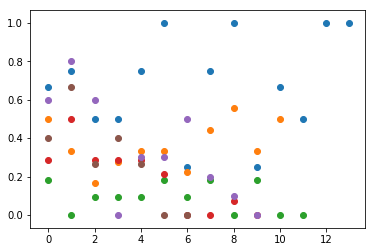

In [121]:
## How do we disentangle concordance (speciifc song bias), selectivity (bias-strength), and responsivity? 
## If concordance is increasing, we would expect that to increase for the top song
## If respnosivity is changing, we woud expect 

print(top_stds)
fig,ax = plt.subplots()
xs,ys=[],[]
for a in range(len(top_stds)):
    ax.scatter(range(max_blocks),top_stds[a])
    xs.extend(range(max_blocks))
    ys.extend(top_stds[a])
    
xs,ys = np.array(xs),np.array(ys)
xs = xs[~np.isnan(ys)]
ys = ys[~np.isnan(ys)]
print(pearsonr(xs,ys))
fig.show()
#print(all_median_distances_by_song)
#print(sig_difference)
#print(np.nanmean(sig_difference,0))

nan 0.004712222922100132


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ammon/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (s

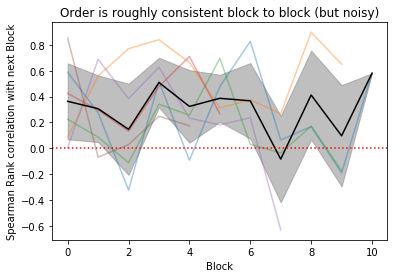

In [295]:
## First, across all presentations, easy Chi squared
all_responses,next_responses = [],[]
correlations = np.empty([len(all_aviaries),14])
correlations.fill(np.nan)
fig,ax = plt.subplots()
for d in range(len(all_aviaries)):
    daviary = all_aviaries[d][:,:,:,0]
    n_blocks = daviary.shape[1]
    for b in range(n_blocks-1):
        #all_responses.extend(daviary[:,b,:].flatten())
        #next_responses.extend(daviary[:,b+1,:].flatten())
        this_block_mean = np.nanmean(daviary[:,b,:],0)
        next_block_mean = np.nanmean(daviary[:,b+1,:],0)
        corr,_ = spearmanr(this_block_mean,next_block_mean)
        correlations[d,b] = corr
        all_responses.extend(np.nanmean(daviary[:,b,:],0))
        next_responses.extend(np.nanmean(daviary[:,b+1,:],0))
    ax.plot(range(n_blocks),correlations[d,:n_blocks],alpha=.4)
 
    
#fig.show()
#corr,p_value = pearsonr(all_responses,next_responses)
print(corr,p_value)

#fig,ax = plt.subplots()
corr_mean = np.nanmean(correlations,0)
corr_std = np.nanstd(correlations,0)
ax.plot(corr_mean,color='black')
#ax.plot(corr_mean + corr_std)
#ax.plot(corr_mean - corr_std)
ax.fill_between(range(14),corr_mean + corr_std,corr_mean - corr_std,alpha=.5,color='gray')
ax.axhline(0,color='red',linestyle=':')
ax.set_xlabel('Block')
ax.set_ylabel('Spearman Rank correlation with next Block')
ax.set_title('Order is roughly consistent block to block (but noisy)')
fig.set_size_inches(6,4)
fig.show()
#np.unique(np.array(all_responses) * 2 + np.array(next_responses),return_counts=True)

In [322]:
print(len(boxes_concs))
print(boxes_concs[0])
print(np.isnan(boxes_concs[0][-1]))

6
[0.10689247589757622, 0.4148814013791242, 0.42033114714007386, 0.8129610751333454, 0.8066990027834411, nan]
True


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


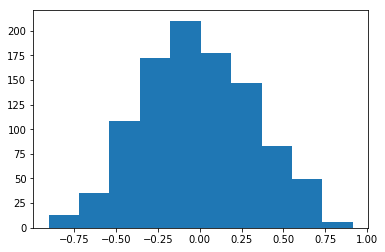

In [287]:

list1 = np.arange(10)
list2 = np.arange(10)

corrs = []
for i in range(1000):
    np.random.shuffle(list2)

    corr,_= spearmanr(list1,list2)

    corrs.append(corr)
    
fig,ax = plt.subplots()
ax.hist(corrs)
fig.show()

In [241]:
test = np.array([[0,1,2],[4,5,6],[8,9,10]])
print(np.random.shuffle(test))
print(test)

None
[[ 8  9 10]
 [ 0  1  2]
 [ 4  5  6]]


In [86]:
## Now by block/bird: 

chi_across_blocks = np.zeros([n_birds,n_blocks])
for b in range(n_blocks-1):
    for f in range(n_birds):
        this_block = daviary[f,b,:]
        next_block = daviary[f,b+1,:]

       0         1         2     3     4  5     6
0      3  05/30/07  12:15:00  MB2M  FGWL  3   NaN
1      2  05/30/07  10:40:00  MMOL  FR2D  R   NaN
2      2  05/30/07  10:40:00  MMOL  FGWL  1   NaN
3      5  05/31/07  09:00:00  MBDY  FGWL  4   NaN
4      6  05/31/07  10:00:00  MLNR  FRWB  R   NaN
5      8  05/31/07  12:30:00  MW2R  FGWL  R   NaN
6     12  05/31/07  17:30:00  MBWD  FGWL  1   NaN
7     12  05/31/07  17:30:00  MBWD  FGWO  1   NaN
8     11  05/31/07  15:30:00  MYLO  FGWL  R   NaN
9     11  05/31/07  15:30:00  MYLO  FGWO  R   NaN
10    13  06/01/07  10:30:00  MNGO  FGWL  1   NaN
11    15  06/01/07  16:30:00  MMOL  FGWL  R   NaN
12    17  06/01/07  17:30:00  MB2M  F2NL  R   NaN
13    17  06/01/07  17:30:00  MB2M  FGWL  R   NaN
14    17  06/01/07  17:30:00  MB2M  FBWB  R   NaN
15    20  06/02/07  10:00:00  MBWD  FGWL  4   NaN
16    21  06/02/07  11:40:00  MYLO  F2NL  R   NaN
17    21  06/02/07  11:40:00  MYLO  FGWL  R   NaN
18    25  06/02/07  16:30:00  MBDY  FGWL  7   NaN


In [102]:
#print(dave_df07)
np.set_printoptions(suppress=True)

dave_df = dave_df10
dave_meta = meta_d10

print('numer of responses:',len(dave_df))
n_trials = np.max(dave_df[0])
n_birds = dave_meta.n_birds
print(n_trials,n_birds)
all_trials = np.zeros([n_trials,n_birds])
for i,line in dave_df.iterrows():
    trial = line[0] - 1
    b_index = dave_meta.bird_dict[line[4]]
    if line[5] != 'R':
        all_trials[trial,b_index] = 1

        
#Birdwise X squared

expected = np.round((np.mean(all_trials,0) ** 2) * n_trials,2)

xs,ys = [],[]
match_counts = np.zeros(n_birds)
for t in range(n_trials-1):
    x_set = all_trials[t]
    y_set = all_trials[t+1]
    n_set = x_set * 2 + y_set
    match_counts = match_counts + [n_set == 3]
    #print(x_set,y_set)
    xs.extend(x_set)
    ys.extend(y_set)
"""    
fig,ax = plt.subplots()
ax.scatter(xs,ys,alpha=.05)
fig.show()
"""
print(pearsonr(xs,ys))
np.unique(list(zip(xs,ys)),return_counts=True)

print(np.unique(np.array(xs) * 2 + np.array(ys),return_counts = True))
print(match_counts)
print(expected)
print((match_counts - expected)**2 / expected)

numer of responses: 316
90 10
(0.5118486429809617, 1.3708687554637224e-60)
(array([0., 1., 2., 3.]), array([548,  89,  88, 165]))
[[ 2. 54. 39. 21. 18.  4.  0.  0. 27.  0.]]
[ 0.54 52.9  38.68 14.4   8.71  1.6   0.    0.01 17.78  0.18]
[[3.94740741 0.02287335 0.00264736 3.025      9.90862227 3.6
         nan 0.01       4.78112486 0.18      ]]


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


In [83]:
print(np.unique(np.array(xs) * 2 + np.array(ys),return_counts = True))

(array([0., 1., 2., 3.]), array([1216,   50,   49,   16]))


7
SpearmanrResult(correlation=-0.24545454545454545, pvalue=0.4669223669820163)
SpearmanrResult(correlation=-0.4090909090909091, pvalue=0.2115450103420961)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


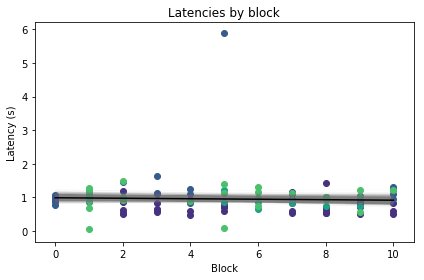

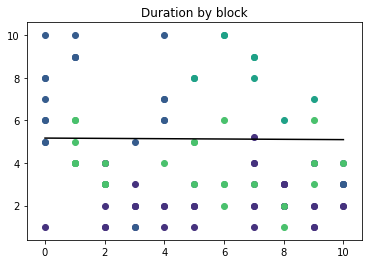

In [57]:
## Get durations,latencies by block: 

n_birds = np.shape(data_array)[0]
print(n_birds)
n_blocks = 11

durations = data_array[:,:,:,2]
durations[data_array[:,:,:,0] != 1] = np.nan
durations[data_key[:,:,:,2] == 0] = np.nan
good_durations = durations[~np.isnan(durations)]

latencies = data_array[:,:,:,1]
good_latencies = latencies[~np.isnan(latencies)]

#song_durations = [data_array[:,n,:,2][~np.isnan(data_array[:,n,:,2])] for n in range(n_blocks)]
#song_latencies = [data_array[:,n,:,1][~np.isnan(data_array[:,n,:,1])] for n in range(n_blocks)]

block_durations = [np.nan] * n_blocks
block_latencies = [np.nan] * n_blocks

## Get durations and latencies by song
for i in range(n_blocks):
    n = i
    p_indices = np.logical_and(~np.isnan(data_array[:,n,:,2]),data_array[:,n,:,0] == 1)
    crap_indices = data_key[:,n,:,2] == 0
    block_durations[i] = data_array[:,n,:,2][np.logical_and(p_indices,~crap_indices)]
    block_latencies[i] = data_array[:,n,:,1][np.logical_and(p_indices,~crap_indices)]

fig,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
#fig,(ax1,ax2) = plt.subplots(1,2)

dur_xs,dur_ys = [],[]
lat_xs,lat_ys = [],[]

for s in range(n_blocks):
    #ax2.scatter([s]*len(block_durations[s]),block_durations[s],alpha=.5)
    #ax1.scatter([s]*len(block_latencies[s]),block_latencies[s],alpha=.5)
    dur_xs.extend([s]*len(block_durations[s]))
    dur_ys.extend(block_durations[s])
    lat_xs.extend([s]*len(block_latencies[s]))
    lat_ys.extend(block_latencies[s])

for f in range(n_birds):
    xs,Lys,Dys = [],[],[]
    for s in range(n_blocks):
        p_indices = np.logical_and(~np.isnan(data_array[f,s,:,2]),data_array[f,s,:,0] == 1)
        crap_indices = data_key[f,s,:,2] == 0
        bird_latencies = data_array[f,s,:,1][np.logical_and(p_indices,~crap_indices)]
        bird_durations = data_array[f,s,:,2][np.logical_and(p_indices,~crap_indices)]
        xs.extend([s] * len(bird_latencies))
        Lys.extend(bird_latencies)
        Dys.extend(bird_durations)
    ax1.scatter(xs,Lys,color=color_map(f/n_birds))
    ax2.scatter(xs,Dys,color=color_map(f/n_birds))
    
#ax2.boxplot(block_durations,positions=range(n_blocks))
#ax1.boxplot(block_latencies,positions=range(n_blocks))

ax1.set_title('Latencies by block')
ax2.set_title('Duration by block')

block_means_dur = [np.nanmean(block_durations[i]) for i in range(len(block_durations))]
block_means_lat = [np.nanmean(block_latencies[i]) for i in range(len(block_latencies))]
print(spearmanr(block_means_lat,range(len(block_means_lat))))
print(spearmanr(block_means_dur,range(len(block_means_dur))))
    
slope,intercept = np.polyfit(range(len(block_means_lat)),block_means_lat,1)

fit_line = np.poly1d([slope,intercept])

#ax1.plot([0,10],[sorted(block_means_lat)[-1],sorted(block_means_lat)[0]],color='black',linestyle=':',alpha=.7)


slope2,intercept2 = np.polyfit(range(len(block_means_dur)),block_means_dur,1)
fit_line2 = np.poly1d([slope,intercept2])


### DO some bootstrapping
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(x=np.array(lat_xs), y=np.array(lat_ys), size=5000)

x = np.array([0,10])
#plt.figure(figsize=(10, 8))

# Plot the bootstrap lines
for i in range(1000):
    _ = ax1.plot(x, bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.05, color='gray')
ax1.plot(fit_line(np.arange(n_blocks)),color='black')
ax1.set_ylabel('Latency (s)')
ax1.set_xlabel('Block')
ax2.plot(fit_line2(np.arange(n_blocks)),color='black')

fig.set_size_inches(6,4)
fig.tight_layout()
fig.show()



#fig.savefig('/home/ammon/Desktop/ToCompy/durations_byblock.svg')

## Figure 6: Does selectivity increase? 

(7, 14, 10)
Latency r: -0.02389382482159395 p= 0.8016543644167111
Duration r: -0.2295331541699796 p= 0.01446164475422282
-0.19964505006600824 4.827184598155246
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([22, 14, 14, 11, 13,  9,  9,  7,  9,  5]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([22, 14, 14, 11, 13,  9,  9,  7,  9,  5]))
[3.5 4.  3.  4.  3.  4.  5.  2.  3.  2. ]
mean duration:
SpearmanrResult(correlation=-0.6121212121212121, pvalue=0.05997214247725524)
median duration:
SpearmanrResult(correlation=-0.4425415752706697, pvalue=0.20028918886747496)
mean latency
SpearmanrResult(correlation=0.0303030303030303, pvalue=0.9337729580941466)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


95% CI for lat slope is [-0.05239609  0.02419931]
95% CI for dur slope is [-0.33377755 -0.06013354]


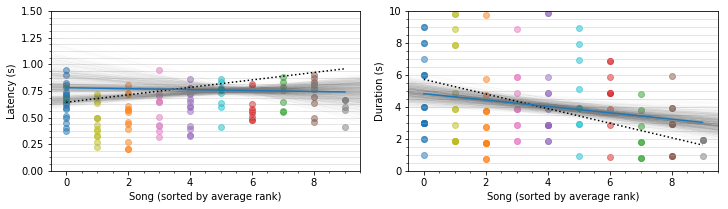

In [563]:
## Get durations, latencies by song Fig5cd

n_songs = len(song_list)

song_means = np.nanmean(binary_array[:,:,:,0],axis=(0,1))
sorted_song_means = sorted(song_means)[::-1]
birdview_order = np.argsort(song_means)[::-1]
song_order = range(n_songs)
song_order = birdview_order

durations = data_array[:,:,:,2]
durations[data_array[:,:,:,0] != 1] = np.nan
durations[data_key[:,:,:,2] == 0] = np.nan
good_durations = durations[~np.isnan(durations)]

print(np.shape(durations))

latencies = np.array(data_array[:,:,:,1][data_array[:,:,:,0] == 1])

#latencies[latencies > 1.6] == np.nan
good_latencies = latencies[~np.isnan(latencies)]


song_durations = [np.nan] * len(song_order)
song_latencies = [np.nan] * len(song_order)

## Get durations and latencies by song
for i in range(len(song_order)):
    n = song_order[i]
    p_indices = np.logical_and(~np.isnan(data_array[:,:,n,2]),data_array[:,:,n,0] == 1)
    crap_indices = data_key[:,:,n,2] == 0
    song_durations[i] = data_array[:,:,n,2][np.logical_and(p_indices,~crap_indices)]
    song_latencies[i] = data_array[:,:,n,1][np.logical_and(p_indices,~crap_indices)]


# Sometimes list comprehensioin is a little too much...
#song_durations = [data_array[:,:,n,2][np.logical_and(data_key[:,:,n,2] == 1,(np.logical_and(~np.isnan(data_array[:,:,n,2]),data_array[:,:,n,0] == 1)))] for n in song_order]
#song_latencies = [data_array[:,:,n,1][np.logical_and(data_key[:,:,n,2] == 1,(np.logical_and(~np.isnan(data_array[:,:,n,2]),data_array[:,:,n,0] == 1)))] for n in song_order]


dur_xs,dur_ys = [],[]
lat_xs,lat_ys = [],[]
fig,(ax1,ax2) = plt.subplots(1,2)

mean_durations = np.empty(10)
mean_latencies = np.empty(10)
median_durations = np.empty(10)
median_latencies = np.empty(10)

for i in range(n_songs):
    s = song_order[i]
    s_name = song_list[true_order[s]]
    s_offset = burble_onsets[s_name]
    ax2.scatter([s]*len(song_durations[s]),song_durations[s] - s_offset,alpha=.5,label=song_list[true_order[s]])
    ax1.scatter([s]*len(song_latencies[s]),song_latencies[s] - s_offset,alpha=.5)
    
    lat_xs.extend([s]*len(song_latencies[s]))
    lat_ys.extend(song_latencies[s])
    dur_xs.extend([s]*len(song_durations[s]))
    dur_ys.extend(song_durations[s])
    
    mean_durations[s] = np.nanmean(song_durations[s])
    mean_latencies[s] = np.nanmean(song_latencies[s])
    median_durations[s] = np.nanmedian(song_durations[s])
    median_latencies[s] = np.nanmedian(song_latencies[s])
#ax2.boxplot(song_durations,positions=range(n_songs))
#ax1.boxplot(song_latencies,positions=range(n_songs))

#ax1.set_title('Latencies by song:')
ax1.set_ylabel('Latency (s)')
ax2.set_ylabel('Duration (s)')
ax1.set_xlabel('Song (sorted by average rank)')
ax2.set_xlabel('Song (sorted by average rank)')

slope1,intercept1 = np.polyfit(lat_xs,lat_ys,1)
fit_line1 = np.poly1d(np.polyfit(lat_xs,lat_ys,1))

#ax1.plot([0,9],[min(mean_latencies),max(mean_latencies)],linestyle=':',color='blue')
corr1,p_value1= pearsonr(lat_xs,lat_ys)
print('Latency r:',corr1,'p=',p_value1)

#ax2.set_title('Durations by song:')
slope2,intercept2 = np.polyfit(dur_xs,dur_ys,1)
slope3,intercept3 = np.polyfit(dur_xs,sorted(dur_ys)[::-1],1)
fit_line3 = np.poly1d(np.polyfit(dur_xs,sorted(dur_ys)[::-1],1))
fit_line2 = np.poly1d(np.polyfit(dur_xs,dur_ys,1))
fit_line4 = np.poly1d(np.polyfit(lat_xs,sorted(lat_ys),1))



#ax2.plot([0,9],[max(mean_durations),min(mean_durations)],linestyle=':',color='blue')

#ax2.set_ylim([0,15])
#ax2.bar(np.arange(n_songs),mean_durations,alpha=.5)


corr2,p_value2= pearsonr(dur_xs,dur_ys)

print("Duration r:",corr2,"p=",p_value2)
print(slope2,intercept2)

#print(fit_line2(0))
#fig.legend()

fig.set_size_inches(10,3)
fig.tight_layout()
fig.show()

## careful, there are more in some than others...
print(np.unique(lat_xs,return_counts=True))
print(np.unique(dur_xs,return_counts=True))

print(median_durations)
print('mean duration:')
print(spearmanr(mean_durations,range(10)))
print('median duration:')
print(spearmanr(median_durations,range(10)))
print('mean latency')
print(spearmanr(mean_latencies,range(10)))

### DO some bootstrapping
lat_slope_reps, lat_intercept_reps = draw_bs_pairs_linreg(x=np.array(lat_xs), y=np.array(lat_ys), size=5000)
dur_slope_reps, dur_intercept_reps = draw_bs_pairs_linreg(x=np.array(dur_xs), y=np.array(dur_ys), size=5000)


x = np.array([-1,10])
#plt.figure(figsize=(10, 8))

# Plot the bootstrap lines
for i in range(1000):
    _ = ax1.plot(x, lat_slope_reps[i]*x + lat_intercept_reps[i],
                 linewidth=0.2, alpha=0.05, color='gray')
    _ = ax2.plot(x, dur_slope_reps[i]*x + dur_intercept_reps[i],
                 linewidth=0.2, alpha=0.05, color='gray')
    
ax1.plot(np.arange(n_songs),fit_line4(np.arange(n_songs)),color='black',linestyle=':')
ax2.plot(np.arange(n_songs),fit_line3(np.arange(n_songs)),color='black',linestyle=':')

ax1.plot(np.arange(n_songs),fit_line1(np.arange(n_songs)))
ax2.plot(np.arange(n_songs),fit_line2(np.arange(n_songs)))

ax2.minorticks_on()
ax1.minorticks_on()

ax2.yaxis.grid(which='major',alpha=.4)
ax2.yaxis.grid(which='minor',alpha=.4)

ax1.yaxis.grid(which='major',alpha=.4)
ax1.yaxis.grid(which='minor',alpha=.4)

ax1.set_ylim([0,1.5])
ax2.set_ylim([0,10])
ax1.set_xlim([-.5,9.5])
ax2.set_xlim([-.5,9.5])
print("95% CI for lat slope is {}".format(np.percentile(lat_slope_reps, [2.5, 97.5])))
print("95% CI for dur slope is {}".format(np.percentile(dur_slope_reps, [2.5, 97.5])))

#fig.savefig('/home/ammon/Desktop/PaperFigs/5cd.svg')
#fig.savefig('/home/ammon/Desktop/PaperFigs/5cd.png')

In [516]:
song_response_rate = np.nanmean(binary_array[:,:,:,0],axis=(0,1))
song_response_rate = sorted(song_response_rate)[::-1]
print(song_response_rate)
print(song_means)
print(song_order)
print(i,s)
print(np.nanmean(data_array[:,:,:,0],axis=(0,1)))

print(np.mean(bird_responses_by_song,axis=0))

print(bird_responses_by_song)

[0.6341463414634146, 0.5128205128205128, 0.4, 0.375, 0.36585365853658536, 0.3076923076923077, 0.2619047619047619, 0.25, 0.25, 0.24242424242424243]
[0.62063492 0.22420635 0.49545455 0.23712121 0.325      0.19259259
 0.31986532 0.31164021 0.3260101  0.21296296]
[0 2 8 1 7 4 5 3 9 6]
9 6
[0.73170732 0.4        0.71794872 0.35714286 0.6097561  0.48484848
 0.575      0.6        0.35897436 0.5       ]
[0.1625 0.05   0.2    0.3875 0.275  0.1625 0.1625 0.325  0.225  0.15
 0.175  0.0625 0.2125 0.1375 0.1125 0.15  ]
[[0.4 0.2 0.2 0.2 0.1 0.2 0.2 0.5 0.  0.  0.1 0.  0.  0.  0.  0.1]
 [0.1 0.1 0.7 0.6 0.7 0.2 0.2 0.5 0.7 0.4 0.3 0.2 0.5 0.2 0.2 0.2]
 [0.  0.1 0.2 0.5 0.3 0.4 0.1 0.3 0.2 0.1 0.1 0.1 0.2 0.1 0.1 0.2]
 [0.2 0.  0.1 0.6 0.1 0.  0.1 0.2 0.1 0.  0.  0.1 0.3 0.2 0.  0.2]
 [0.2 0.  0.2 0.5 0.5 0.3 0.4 0.2 0.1 0.2 0.3 0.  0.2 0.2 0.2 0. ]
 [0.  0.  0.  0.1 0.1 0.  0.  0.2 0.2 0.1 0.  0.  0.  0.2 0.  0. ]
 [0.  0.  0.  0.3 0.  0.  0.2 0.3 0.2 0.  0.3 0.1 0.  0.  0.  0.2]
 [0.4 0.  0.2 0.3 0

## Figure 7: Other postures

In [428]:
### Plot the responses of posture by bird
n_birds = 7
print(np.shape(data_array))

binary_array = np.array(data_array)
binary_array[data_array[:,:,:,0] == 2] = [0,np.nan,np.nan,np.nan]

binary_partial = np.array(data_array)
binary_partial[data_array[:,:,:,0] == 1] = [0,np.nan,np.nan,np.nan]
binary_partial[data_array[:,:,:,0] == 2] = [1,np.nan,np.nan,np.nan]

binary_null = np.array(data_array)
binary_null[data_array[:,:,:,0] == 2] = [0,np.nan,np.nan,np.nan]
binary_null[data_array[:,:,:,0] == 1] = [0,np.nan,np.nan,np.nan]
binary_null[data_array[:,:,:,0] == 0] = [1,np.nan,np.nan,np.nan]

print(np.shape(data_array))
print(np.shape(binary_array))

songs_bybird = np.nanmean(binary_array,axis=(1))
partials_bybird = np.nanmean(binary_partial,axis=1)
non_bybird = np.nanmean(binary_null,axis=1)

canon_slopes = np.empty(n_birds)
true_slopes = np.empty_like(canon_slopes)

canon_intercepts,true_intercepts = np.empty_like(canon_slopes),np.empty_like(true_slopes)

canon_means = np.empty([n_birds,n_songs])
true_means = np.empty_like(canon_means)
partial_means = np.empty_like(canon_means)
non_means = np.empty_like(canon_means)

non_means.fill(np.nan)
partial_means.fill(np.nan)
canon_means.fill(np.nan)

print(n_birds)
for b in range(n_birds):
    ## This is the ranking (sorted by canon)
    canon_means[b] = songs_bybird[b,:,0]
    partial_means[b] = partials_bybird[b,:,0]
    non_means[b] = non_bybird[b,:,0]
    
    canon_slopes[b],canon_intercepts[b] = np.polyfit(range(n_songs),canon_means[b],1) 

    ## This is the individual bird ranking
    true_means[b] = np.sort(canon_means[b])[::-1]
    true_slopes[b],true_intercepts[b] = np.polyfit(range(n_songs),true_means[b],1)

#fig,(ax,ax2) = plt.subplots(2)


song_means = np.nanmean(canon_means,axis=0)
partial_means = np.nanmean(partial_means,axis=0)
non_means = np.nanmean(non_means,axis=0)
song_std = np.nanstd(canon_means,axis=0)

true_order = np.argsort(song_means)[::-1]
sorted_means = canon_means[:,true_order]

"""   
ax.bar(np.arange(n_songs) + .4,song_means,color='gray',alpha=1)
ax2.bar(np.arange(n_songs) + .4,np.nanmean(sorted_means,axis=0),color='gray')
for n in range(n_birds):
    ax.bar(np.arange(n_songs) + n * .8/n_birds,canon_means[n],width=.8/n_birds, label=bird_list[n],alpha=.6)
    ax2.bar(np.arange(n_songs) + n * .8/n_birds,sorted_means[n],width=.8/n_birds,alpha=.6)
 
fig.legend()
fig.set_size_inches(7,7)
fig.tight_layout()

fig.show()
"""
#fig.savefig('/home/ammon/Desktop/ToCompy/selectivity_bybird.svg')
pass

(7, 14, 10, 4)
(7, 14, 10, 4)
(7, 14, 10, 4)
7


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RankWarning: Polyfit may be poorly conditioned
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


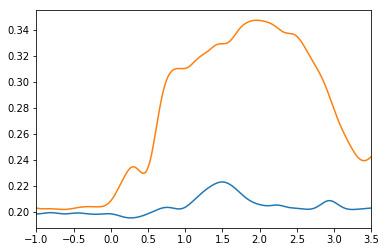

In [429]:
## Show Partial and Full Partial
seq = pickle.load(open('./SeqClasses/2019-06-20-13-03-04_BDY.obj','rb'))
seq2 = pickle.load(open('./SeqClasses/2019-06-18-18-34-04_WG.obj','rb'))
fig,ax = plt.subplots()

ax.plot(seq2.ts,seq2.smooth_data[:,3,2])
ax.plot(seq.ts,seq.smooth_data[:,3,2])

ax.set_xlim([-1,3.5])
fig.show()

(7, 10)
(7, 10)
[0.09333333 0.07151515 0.08310606 0.02       0.1        0.15424603
        nan]


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


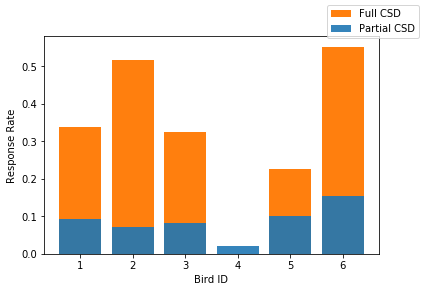

In [444]:
## Plot Full CSD and partial CSD
fig,ax = plt.subplots()

print(np.shape(partials_bybird[:,:,0]))
print(np.shape(canon_means))

default_cm = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(np.nanmean(partials_bybird[:,:,0],1))
ax.bar(range(1,8),np.nanmean(canon_means[:8],1),label='Full CSD',color=default_cm[1])
ax.bar(range(1,8),np.nanmean(partials_bybird[:,:,0],1),alpha=.9,label='Partial CSD',color=default_cm[0])

ax.set_xlabel('Bird ID')
ax.set_ylabel('Response Rate')

fig.legend()
fig.show()


#fig.savefig('/home/ammon/Desktop/PaperFigs/fig6f.png',dpi=300)

In [633]:
len(daviaries)

4

[0 2 8 1 7 4 5 3 9 6]


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


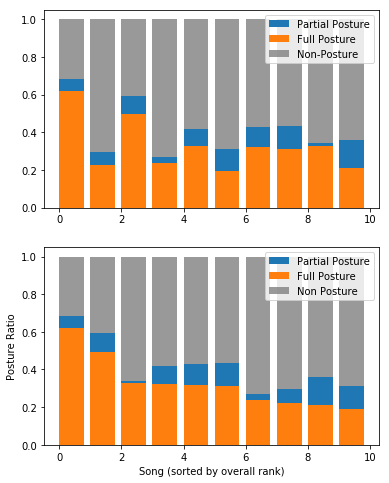

In [437]:
## Plot postures, nonpostures, and partial postures

fig,(ax1,ax2) = plt.subplots(2)
bv_order = np.argsort(song_means)[::-1]
ax1.bar(np.arange(n_songs) + .4,partial_means,bottom=song_means,label='Partial Posture')
ax1.bar(np.arange(n_songs) + .4,song_means,alpha=1,label='Full Posture')

ax1.bar(np.arange(n_songs) + .4,non_means,color='gray',alpha=.8,bottom=(song_means + partial_means),label='Non-Posture')
ax1.legend()
print(song_order)

ax2.bar(np.arange(n_songs) + .4,partial_means[bv_order],bottom=song_means[bv_order],label='Partial Posture')
ax2.bar(np.arange(n_songs) + .4,song_means[bv_order],alpha=1,label='Full Posture')

ax2.bar(np.arange(n_songs) + .4,non_means[bv_order],color='gray',alpha=.8,bottom=(song_means + partial_means)[bv_order],label='Non Posture')
ax2.set_xlabel('Song (sorted by overall rank)')
ax2.set_ylabel('Posture Ratio')

ax2.legend()
fig.set_size_inches(6,8)
fig.show()
fig.savefig('/home/ammon/Desktop/PaperFigs/fig6h.png',dpi=300)

depuff: 0.14496969696969697 0.17895885507288842
wingstroke: -0.19004545454545446 1.1253646066648284
partials: 1.0392173913043476 0.25048144190941735
depuff vs wingstrokes: Ttest_indResult(statistic=1.6477837183944153, pvalue=0.10531375113512915)
depuffs vs full csd: Ttest_indResult(statistic=-8.332391732466121, pvalue=4.4940027831748487e-14)
wingstroke vs full csd: Ttest_indResult(statistic=-7.335581002591349, pvalue=1.6264495092666983e-11)
partial csd vs full csd: Ttest_indResult(statistic=0.5665961696209214, pvalue=0.5718893728547652)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ammon/anaconda3/lib/python3.6/site

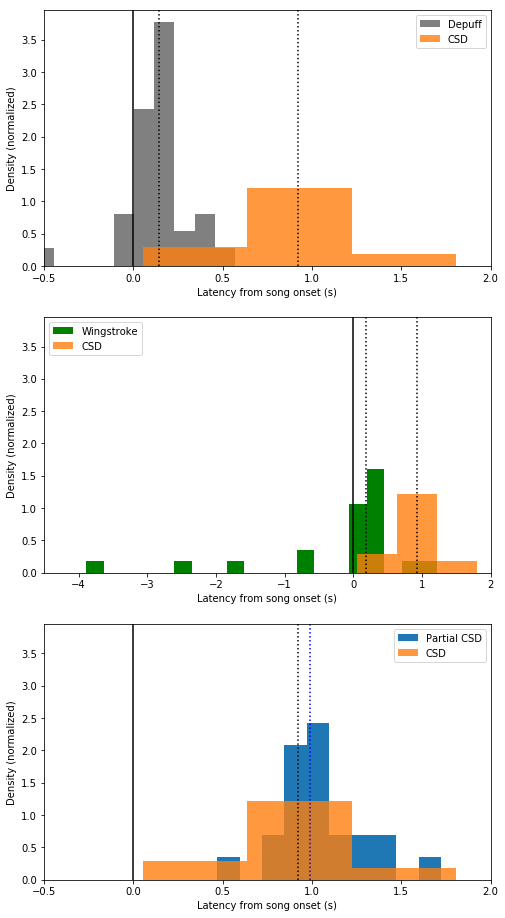

In [500]:
## Plot depuffs and wingstrokes

## These are copy-pasted from an excel sheet. This obviously needs to be better. 
depuffs = [0.304,0.567,-0.01,0.199,0.394,0.154,0.093,0.156,0.106,0.216,0.206,
0.248,0.143,0.157,0.13,-0.559,0.025,0.135,0.138,0.169,0.115,0.081,-0.019,0.357,0.404,0.092,0.113,0.081,0.058,0.191,0.216,0.219,-0.095]
wingstrokes = [1.216,0.259,0.261,0.215,0.437,0.347,0.314,0.919,0.28,
               -3.885,0.059,0.057,0.137,0.082,0.07,-1.76,-0.726,-2.537,0.152,0.272,-0.571,0.221]
partials = [1.07,1.082,1.284,0.799,0.897,1.082,0.921,0.989,1.111,0.849,0.873,0.975,1.722,1.188,
1.009,1.422,1.238,0.875,0.814,0.886,1.365,0.469,0.982]

print('depuff:',np.mean(depuffs),np.std(depuffs))
print('wingstroke:',np.mean(wingstrokes),np.std(wingstrokes))
print('partials:',np.mean(partials),np.std(partials))

print('depuff vs wingstrokes:',ttest_ind(depuffs,wingstrokes))
print('depuffs vs full csd:',ttest_ind(depuffs,latencies[~np.isnan(latencies)]))

print('wingstroke vs full csd:',ttest_ind(wingstrokes,latencies[~np.isnan(latencies)]))
print('partial csd vs full csd:',ttest_ind(partials,latencies[~np.isnan(latencies)]))
fig, (ax1,ax2,ax3) = plt.subplots(3,sharey=True)

ax1.axvline(0,color='black')
ax2.axvline(0,color='black')
ax3.axvline(0,color='black')

ax1.hist(depuffs,normed=True,label='Depuff',color='Grey')
ax1.hist(latencies[~np.isnan(latencies)],alpha=.8,normed=True,label='CSD',color='tab:orange')
ax1.axvline(np.median(depuffs),color='black',linestyle=':')
ax1.axvline(np.nanmedian(latencies),color='black',linestyle=':')

ax2.hist(wingstrokes,normed=True,bins=20,label='Wingstroke',color='Green')
ax2.hist(latencies[~np.isnan(latencies)],alpha=.8,normed=True,label='CSD',color='tab:orange')
ax2.axvline(np.median(wingstrokes),color='black',linestyle=':')
ax2.axvline(np.nanmedian(latencies),color='black',linestyle=':')

ax3.hist(partials,normed=True,label='Partial CSD')
ax3.hist(latencies[~np.isnan(latencies)],alpha=.8,normed=True,label='CSD',color='tab:orange')
ax3.axvline(np.median(partials),color='blue',linestyle=':')
ax3.axvline(np.nanmedian(latencies),color='black',linestyle=':')

ax2.set_xlim(-4.5,2)
ax1.set_xlim(-0.5,2)
ax3.set_xlim(-0.5,2)

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_xlabel('Latency from song onset (s)')

ax3.set_xlabel('Latency from song onset (s)')
ax3.set_ylabel('Density (normalized)')
ax1.set_ylabel('Density (normalized)')
ax2.set_ylabel('Density (normalized)')
ax2.set_xlabel('Latency from song onset (s)')


fig.set_size_inches([8,16])
fig.show()
#fig.savefig('/home/ammon/Desktop/PaperFigs/fig6be.png',dpi=300)

depuff: 0.19899999999999998 0.19899987220764181 -4.041000127792358 2019-06-09-10-16-10_LNR
wingstroke: 1.216 1.2159999179840089 -3.864000082015991 2019-06-09-18-46-12_BOD
wingstroke: 0.259 0.25900011444091753 -4.119999885559082 2019-06-10-11-46-12_ND
wingstroke: 0.261 0.2609999561309815 -3.7790000438690186 2019-06-12-13-16-14_BDY
wingstroke: 0.215 0.21499988555908223 -3.505000114440918 2019-06-13-07-16-15_BDY
wingstroke: 0.43700000000000006 0.43699988746643026 -3.9820001125335693 2019-06-13-08-46-14_2M
depuff: 0.39399999999999996 0.39399988174438505 -3.9260001182556152 2019-06-13-11-46-13_LNR
wingstroke: 0.34700000000000003 0.34600009918212926 -4.053999900817871 2019-06-14-08-46-14_LB
wingstroke: 0.314 0.31399999618530305 -4.046000003814697 2019-06-14-10-16-13_LNR
wingstroke: 0.919 0.9180000782012936 -3.681999921798706 2019-06-14-13-16-17_WG
depuff: 0.154 0.1539999961853029 -4.046000003814697 2019-06-14-17-16-13_DMG
wingstroke: 0.28 0.27999996185302756 -3.9600000381469727 2019-06-14-18

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


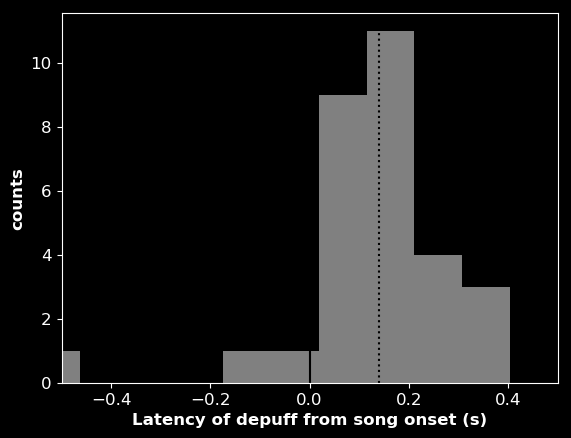

In [777]:
fig,ax = plt.subplots()
### The hand written ones are correct too. 
depuff_latencies = []
depuff_latencies2 = []
wingstroke_latencies = []
for i,row in test_4.iterrows():
    if '2019' not in row['SeqName']:
        continue
    try:
        seq = pickle.load(open('./AllSeqs/' + row['SeqName'] + '.obj','rb'))
        #print(seq.seq_name,'offset:',seq.ts[0])
    except:
        #print('seq missing',row['SeqName'],'all values are wrong')
        continue
    if seq.ts[0] == 0:
        continue
    notes = str(row['Notes']).lower()
    if 'depress' in notes:
        #print(row)
        #print(row['TrueLatency'])
        if pd.isnull(row['TrueLatency']):
            pass
        else:
            depuff_latencies.append(row['TrueLatency'])
            depuff_latencies2.append(row['TimeStamp'] + seq.ts[0])
            print('depuff:',row['TrueLatency'],row['TimeStamp'] + seq.ts[0],seq.ts[0],seq.seq_name)
    if 'wingstroke' in notes:
        #print('wingstroke:',row['SeqName'],row['TimeStamp'],row['Offset'])
        wingstroke_latencies.append(row['TimeStamp'] + seq.ts[0])
        print('wingstroke:',row['TrueLatency'],row['TimeStamp'] + seq.ts[0],seq.ts[0],seq.seq_name)
            
print('depuffs:')
print(len(depuffs),len(depuff_latencies),len(depuff_latencies2))
print(depuffs,depuff_latencies,depuff_latencies2)

print('wingstrokes:')
print(len(wingstrokes),len(wingstroke_latencies))
print(wingstrokes,wingstroke_latencies)



ax.hist(depuff_latencies,normed=False,color='gray')
#ax.hist(latencies[~np.isnan(latencies)],alpha=.8,normed=True)
ax.axvline(0,color='black')
ax.axvline(np.median(depuff_latencies),color='black',linestyle=':')
#ax.axvline(np.nanmedian(latencies),color='black')
ax.set_xlim(-.5,.5)
ax.set_ylabel('counts')
ax.set_xlabel('Latency of depuff from song onset (s)')
fig.show()

(-0.2226089671121106, 0.5364649044747722)
(0.43482514510017295, 0.20917881567822602)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


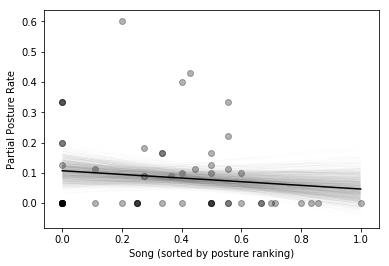

In [472]:
## Plot partial posture by ranking
print(pearsonr(np.nanmean(canon_means,0)[bv_order],partial_means[bv_order]))
print(pearsonr(range(10),partial_means[bv_order]))
fig,ax = plt.subplots()

#slope,intercept = np.polyfit(range(10),partial_means[bv_order],1)
slope,intercept = np.polyfit(canon_means[:6].flatten(),partials_bybird[:6,:,0].flatten(),1)
fit_line = np.poly1d([slope,intercept])


### DO some bootstrapping
full_xs = canon_means[:6].flatten()
partial_ys = partials_bybird[:6,:,0].flatten()
partial_slope_reps, partial_intercept_reps = draw_bs_pairs_linreg(x=full_xs, y=partial_ys, size=1000)

x = np.array([0,1])
#plt.figure(figsize=(10, 8))

# Plot the bootstrap lines
for i in range(1000):
    _ = ax.plot(x, partial_slope_reps[i]*x + partial_intercept_reps[i],
                 linewidth=0.2, alpha=0.05, color='gray')

ax.set_ylabel('Partial Posture Rate')
ax.set_xlabel('Song (sorted by posture ranking)')
ax.scatter(canon_means[:6].flatten(),partials_bybird[:6,:,0].flatten(),color='black',alpha=.3)
ax.plot([0,1],fit_line([0,1]),color='black')
fig.show()
#fig.savefig('/home/ammon/Desktop/PaperFigs/fig6i.png',dpi=300)

In [635]:
np.unique(dave_array07[:,:,:,0])

array([0., 1.])

### Old stuff, clear out eventually: 

In [466]:
np.nanmean(canon_means,0)[bv_order]
print(canon_means.shape)
print(partials_bybird[:,:,0])
print(canon_means[:7].flatten())
print(pearsonr(partials_bybird[:6,:,0].flatten(),canon_means[:6].flatten()))

(7, 10)
[[0.16666667 0.         0.4        0.         0.         0.
  0.         0.2        0.         0.16666667]
 [0.         0.         0.         0.09090909 0.33333333 0.
  0.         0.1        0.09090909 0.1       ]
 [0.         0.         0.18181818 0.1        0.11111111 0.125
  0.09090909 0.11111111 0.         0.11111111]
 [0.2        0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.33333333 0.33333333 0.         0.33333333]
 [0.         0.42857143 0.         0.         0.125      0.6
  0.22222222 0.         0.         0.16666667]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]]
[0.5        0.25       0.4        0.25       0.25       0.4
 0.5        0.         0.5        0.33333333 0.7        0.55555556
 0.66666667 0.27272727 0.55555556 0.55555556 0.5        0.6
 0.27272727 0.5        0.66666667 0.1111111

(18, 11, 10, 3)
(10,)
()

## Means and std of Response Rate equivalent
0.1534090909090909 +- 0.3603813837249882
0.17909090909090908 +- 0.3834284227491499

## No difference in variation of selectivity or response rate
LeveneResult(statistic=16.050990303644372, pvalue=0.001018299598826163)
LeveneResult(statistic=19.26903631662228, pvalue=0.00045695736526904355)

## Very high correlation in rank order
SpearmanrResult(correlation=0.8424242424242423, pvalue=0.0022200312259168407)
## ANNOVAs:?


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


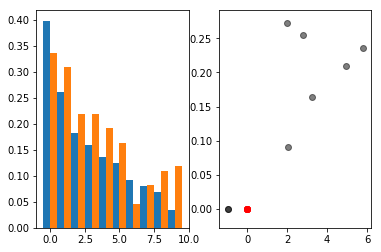

In [48]:
"""
true_order = np.argsort(song_means)[::-1]
song_order = range(n_songs)
song_order = true_order

print(np.shape(binary_array3))
birdx_means = np.nanmean(binary_array3[16],0)

control_means = np.nanmean(binary_array3[control_birds,:,:,0],axis=(1,0))
lesion_means = np.nanmean(binary_array3[lesions_birds,:,:,0],axis=(1,0))

print(np.shape(lesion_means))
## Does their overall response rate vary?
control_mu = np.nanmean(binary_array3[control_birds,:,:,0])
lesion_mu = np.nanmean(binary_array3[lesions_birds,:,:,0])

control_std = np.nanstd(binary_array3[control_birds,:,:,0])
lesion_std = np.nanstd(binary_array3[lesions_birds,:,:,0])
print(np.shape(control_std))

print('\n## Means and std of Response Rate equivalent')
print(control_mu,'+-',control_std)
print(lesion_mu,'+-',lesion_std)

print('\n## No difference in variation of selectivity or response rate')
print(levene(sel_by_bird[lesions_birds + 7],sel_by_bird[control_birds + 7]))
print(levene(resp_by_bird[lesions_birds + 7],resp_by_bird[control_birds + 7]))

control_order = np.argsort(control_means)
lesion_order = np.argsort(lesion_means)

print('\n## Very high correlation in rank order')
print(spearmanr(control_order,lesion_order))


print('## ANNOVAs:?')
fig, (ax1,ax2) = plt.subplots(1,2)
#ax.bar(range(10),birdx_means[song_order])
ax1.bar(np.arange(10)-.25,control_means[song_order],width=.5)
ax1.bar(np.arange(10)+.25,lesion_means[song_order],width = .5)

for n in range(len(binary_array3)):
    i = n+7
    if n in lesions_birds:
        my_color = 'red'
    else:
        my_color = 'black'
    ax2.scatter(sel_by_bird[i],resp_by_bird[i],color=my_color,alpha=.5)
    
fig.show()"""

In [40]:
"""
#I don't think I need this
print(np.shape(bv3_array))
day_list = []

day_list.extend(pd.unique(group1_df['Date']))
day_list.extend(pd.unique(group2_df['Date']))

hour_list = [6,7,8,9,10,11,12,13,15,17,18]


date_dict = dict(zip(day_list,range(len(day_list))))
hour_dict = dict(zip(hour_list,range(len(hour_list))))

bv3_bytime = np.empty([len(day_list),len(hour_list),18,10])
bv3_bytime.fill(np.nan)

for index,row in group1_df.iterrows():
    date = row['Date']
    hour = int(row['Time'].split(':')[0])

    date_index = date_dict[date]
    hour_index = hour_dict[hour]
    song_index = song_dict[row['SongFile'].split('.')[0]]
    block = int(row['Block']) - 1

    bv3_bytime[date_index,hour_index,:9,song_index] = row.iloc[6:15]


for index,row in group2_df.iterrows():
    date = row['Date']
    hour = int(row['Time'].split(':')[0])

    date_index = date_dict[date]
    hour_index = hour_dict[hour]
    song_index = song_dict[row['SongFile'].split('.')[0]]
    block = int(row['Block']) - 1

    bv3_bytime[date_index,hour_index,9:,song_index] = row.iloc[6:15]

"""

(18, 11, 10, 3)


[0.3968254  0.12698413 0.06349206 0.00793651 0.12698413 0.11904762
 0.07142857 0.11111111 0.17460317 0.14285714 0.11904762 0.30952381
 0.07142857 0.14285714 0.16666667 0.12222222 0.75       0.56349206
 0.33333333 0.21527778 0.18055556 0.0625     0.34126984 0.22222222
 0.27083333 0.10416667 0.06349206 0.23809524 0.07936508 0.14285714
 0.20634921 0.05555556]
[0.3968254  0.12698413 0.06349206 0.00793651 0.12698413 0.11904762
 0.07142857 0.11111111 0.17460317 0.14285714 0.11904762 0.30952381
 0.07142857 0.14285714 0.16666667 0.12222222 0.75       0.56349206
 0.33333333 0.21527778 0.18055556 0.0625     0.34126984 0.22222222
 0.27083333 0.10416667 0.06349206 0.23809524 0.07936508 0.14285714
 0.20634921 0.05555556]
(0.06271199250417489, 0.7331229080319388)


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


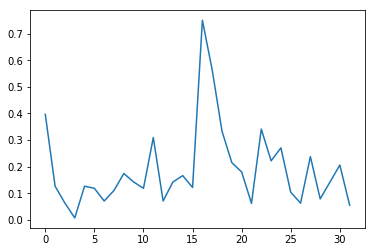

In [41]:
"""
#I don't think I need this
print(np.nanmean(bv3_bytime,axis=(1,2,3)))
day_means = np.nanmean(bv3_bytime,axis=(1,2,3))
hour_means = np.nanmean(bv3_bytime[:,:,:9],axis=(0,2,3))
fig,ax = plt.subplots()
ax.plot(day_means)
print(day_means)
print(pearsonr(range(len(day_means)),day_means))"""

/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


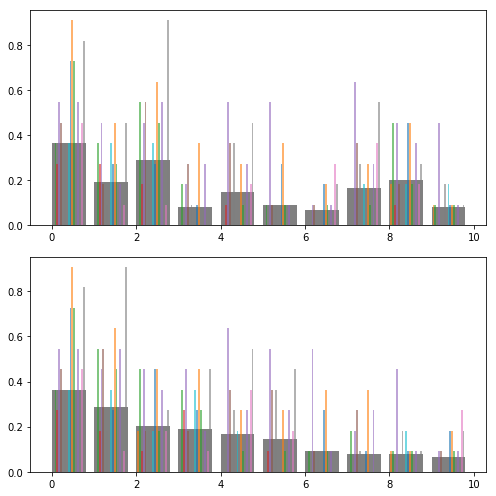

In [42]:
"""## plot response ratios for this group: 

songs_bybird = np.nanmean(binary_array3,axis=(1))
n_birds = 18
n_songs = 10
canon_slopes = np.empty(n_birds)
true_slopes = np.empty_like(canon_slopes)

canon_intercepts,true_intercepts = np.empty_like(canon_slopes),np.empty_like(true_slopes)

canon_means = np.empty([n_birds,n_songs])
true_means = np.empty_like(canon_means)

for b in range(n_birds):
    ## This is the ranking (sorted by canon)
    canon_means[b] = songs_bybird[b,:,0]
    canon_slopes[b],canon_intercepts[b] = np.polyfit(range(n_songs),canon_means[b],1) 

    ## This is the individual bird ranking
    true_means[b] = np.sort(canon_means[b])[::-1]
    true_slopes[b],true_intercepts[b] = np.polyfit(range(n_songs),true_means[b],1)

fig,(ax,ax2) = plt.subplots(2)

song_means = np.nanmean(canon_means,axis=0)
song_std = np.nanstd(canon_means,axis=0)

true_order = np.argsort(song_means)[::-1]
sorted_means = canon_means[:,true_order]


ax.bar(np.arange(n_songs) + .4,song_means,color='gray',alpha=1)
ax2.bar(np.arange(n_songs) + .4,np.nanmean(sorted_means,axis=0),color='gray')
for n in range(n_birds):
    #print(np.shape(canon_means),np.shape(bird_list))
    ax.bar(np.arange(n_songs) + n * .8/n_birds,canon_means[n],width=.8/n_birds, label=bird_list3[n],alpha=.6)
    ax2.bar(np.arange(n_songs) + n * .8/n_birds,sorted_means[n],width=.8/n_birds,alpha=.6)
    
#fig.legend()
fig.set_size_inches(7,7)
fig.tight_layout()

fig.show()
"""

(25, 11, 10)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


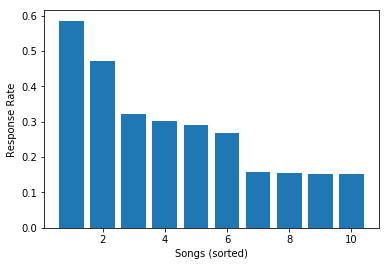

In [45]:
"""print(np.shape(binary_array_all))
active_birds = np.nansum(binary_array_all,axis=(1,2)) > 3
active_means = np.nanmean(binary_array_all[active_birds],(0,1))

fig,ax = plt.subplots()
ax.bar(range(1,11),sorted(active_means)[::-1])
#ax.set_ylim([0,1])
ax.set_ylabel('Response Rate')
ax.set_xlabel('Songs (sorted)')

fig.savefig('/home/ammon/Desktop/PaperFigs/example_sort.svg')
fig.show()"""

In [97]:
orders = []
order_array = np.zeros((len(plot_array),10))
for b in range(len(bird_responses_by_song)):
    
    #print(plot_array.shape)
    means_nob = np.nanmean(plot_array[np.arange(len(plot_array)) != b],axis=(0,1))
    mean_b = np.nanmean(plot_array[b],axis=0)
    mean_b = bird_responses_by_song[b]
    order_b = np.argsort(mean_b)[::-1]
    #print(means_nob.shape)
    order_nob = np.argsort(means_nob)[::-1]
    #print(order_nob,order_b)
    print(mean_b)
    print(np.arange(10)[order_b])
    orders.append(np.arange(10)[order_b])
    order_array[b,:] = np.array(np.arange(10)[order_b])
    
print(kruskal(*orders))
print(*orders)

[0.66666667 0.25       0.8        0.25       0.25       0.4
 0.5        0.         0.5        0.33333333]
[2 0 8 6 5 9 4 3 1 7]
[0.66666667 0.55555556 0.625      0.2        0.55555556 0.5
 0.5        0.6        0.5        0.5       ]
[0 2 7 4 1 9 8 6 5 3]
[0.71428571 0.14285714 0.33333333 0.5        0.5        0.
 0.375      0.71428571 0.42857143 0.14285714]
[7 0 4 3 8 6 2 9 1 5]
[0.2 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
[0 9 8 7 6 5 4 3 2 1]
[1.   0.   0.8  0.   0.2  0.   0.   0.   0.25 0.  ]
[0 2 8 4 9 7 6 5 3 1]
[0.83333333 0.8        0.83333333 0.4        0.57142857 0.25
 0.42857143 0.6        0.6        0.33333333]
[2 0 1 8 7 4 6 3 9 5]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9 8 7 6 5 4 3 2 1 0]
[0.27272727 0.27272727 0.18181818 0.         0.09090909 0.
 0.         0.         0.09090909 0.        ]
[1 0 2 8 4 9 7 6 5 3]
[0.45454545 0.18181818 0.54545455 0.27272727 0.36363636 0.09090909
 0.09090909 0.36363636 0.18181818 0.        ]
[2 0 7 4 3 8 1 6 5 9]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9

/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [98]:
import numpy as np

def kendall_w(expt_ratings):
    if expt_ratings.ndim!=2:
        raise 'ratings matrix must be 2-dimensional'
    m = expt_ratings.shape[0] #raters
    n = expt_ratings.shape[1] # items rated
    denom = m**2*(n**3-n)
    rating_sums = np.sum(expt_ratings, axis=0)
    S = n*np.var(rating_sums)
    return 12*S/denom

the_ratings = order_array
m = the_ratings.shape[0]
n = the_ratings.shape[1]

W = kendall_w(the_ratings)

count = 0
for trial in range(1000):
    perm_trial = []
    for _ in range(m):
        perm_trial.append(list(np.random.permutation(range(1, 1+n))))
    count += 1 if kendall_w(np.array(perm_trial)) > W else 0

print ('Calculated value of W:', W, ' exceeds permutation values in', count, 'out of 1000 cases')

Calculated value of W: 0.048523636363636366  exceeds permutation values in 276 out of 1000 cases


In [167]:
print(1/.05)
np.log(20)

20.0


2.995732273553991

In [50]:
## Plot example postures for fig 1

Mean Latency= 0.9460496015785155 (std: 0.3698860222971921 )
Median Latency= 0.9229998588562012


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


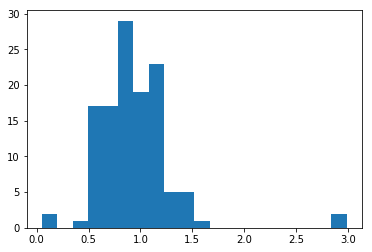

In [56]:
## First get latency for all songs: 
latencies = data_array[:,:,:,1]

latencies[data_key[:,:,:,2] == 0] = np.nan

good_latencies = latencies[~np.isnan(latencies)]

mean_lat = np.mean(good_latencies)
med_lat = np.median(good_latencies)
std_lat = np.std(good_latencies)

print('Mean Latency=',mean_lat,'(std:',std_lat,')')
print('Median Latency=',med_lat)

#print(good_latencies)
fig,ax = plt.subplots()

ax.hist(good_latencies,bins=20)

#fig.savefig('/home/ammon/Desktop/ToCompy/latencies_all.svg')
fig.show()


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


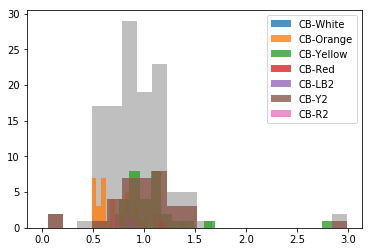

In [57]:
## Now get latencies by bird: 
n_birds = len(bird_list)

latencies = data_array[:,:,:,1]
latencies[data_key[:,:,:,2] == 0] = np.nan
good_latencies = latencies[~np.isnan(latencies)]

bird_durations = [np.nan] * n_birds
bird_latencies = [np.nan] * n_birds

## Get durations and latencies by bird
for i in range(n_birds):
    n = i
    p_indices = np.logical_and(~np.isnan(data_array[n,:,:,2]),data_array[n,:,:,0] == 1)
    crap_indices = data_key[n,:,:,2] == 0
    bird_durations[i] = data_array[n,:,:,2][np.logical_and(p_indices,~crap_indices)]
    bird_latencies[i] = data_array[n,:,:,1][np.logical_and(p_indices,~crap_indices)]

fig,ax = plt.subplots()

ax.hist(good_latencies,bins=20,color='gray',alpha=.5)
for b in range(n_birds):
    ax.hist(bird_latencies[b],bins=20,alpha=.8,label=bird_list[b])

ax.legend()

fig.savefig('/home/ammon/Desktop/ToCompy/latencies_bybird.svg')
fig.show()

(7, 14, 10)
(121,)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


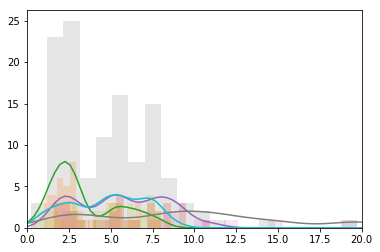

In [58]:
## Now get durations by bird: 
n_birds = len(bird_list)

durations = np.array(data_array[:,:,:,2])

durations[data_key[:,:,:,2] == 0] = np.nan
print(np.shape(durations))
good_durations = durations[~np.isnan(durations)]
print(np.shape(good_durations))


bird_durations = [np.nan] * n_birds
bird_latencies = [np.nan] * n_birds
bird_kdes = [0] * n_birds






## Get durations and latencies by bird
for i in range(n_birds):
    n = i
    p_indices = np.logical_and(~np.isnan(data_array[n,:,:,2]),data_array[n,:,:,0] == 1)
    crap_indices = data_key[n,:,:,2] == 0
    bird_durations[i] = data_array[n,:,:,2][np.logical_and(p_indices,~crap_indices)]
    bird_latencies[i] = data_array[n,:,:,1][np.logical_and(p_indices,~crap_indices)]

    
fig,ax = plt.subplots()
    
xs = np.linspace(-5,25,100)    
ax.hist(good_durations,bins=20,color='gray',alpha=.2)
for b in range(n_birds):
    y,x,_ = ax.hist(bird_durations[b],bins=20,alpha=.2)
    if len(bird_latencies[b]) > 1:
        curve = gaussian_kde(bird_durations[b],bw_method=.3)
        ax.plot(xs,curve(xs) * max(y) / max(curve(xs)))

ax.set_xlim([0,20])
fig.show()

#fig.savefig('/home/ammon/Desktop/ToCompy/durations_bybird_hist.svg')

In [62]:
##Test for whether birds are different. 

print(np.shape(bird_durations))
print(np.shape(bird_latencies))
print('Significant variation in latency (std is similar)')
print(f_oneway(bird_latencies[1],bird_latencies[2],bird_latencies[3],
               bird_latencies[4],bird_latencies[5]))
print(levene(bird_latencies[1],bird_latencies[2],bird_latencies[3],
               bird_latencies[4],bird_latencies[5]))

print('Significant variation in duration ')
print(f_oneway(bird_durations[1],bird_durations[2],bird_durations[3],
               bird_latencies[4],bird_latencies[5]))
print(levene(bird_durations[1],bird_durations[2],bird_durations[3],
               bird_durations[4],bird_durations[5]))


lats = []
durs = []
bird_ids = []
for b in range(1,6):

    lats.extend(bird_latencies[b])
    durs.extend(bird_durations[b])
    bird_ids.extend([b] * len(bird_latencies[b]))

print(pairwise_tukeyhsd(lats,bird_ids))
print(pairwise_tukeyhsd(durs,bird_ids))

(7,)
(7,)
Significant variation in latency (std is similar)
F_onewayResult(statistic=5.459412701834754, pvalue=0.0004606349762899995)
LeveneResult(statistic=1.0395621580158503, pvalue=0.38995421889168796)
Significant variation in duration 
F_onewayResult(statistic=28.87750160382836, pvalue=1.1742178655361328e-16)
LeveneResult(statistic=5.895833614328563, pvalue=0.0002352968680403528)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.338    0.1116 0.5643  True 
  1      3     0.3767  -0.5943 1.3477 False 
  1      4     0.0834  -0.2673 0.434  False 
  1      5     0.271    0.0563 0.4858  True 
  2      3     0.0387  -0.9375 1.015  False 
  2      4    -0.2546  -0.6196 0.1104 False 
  2      5    -0.0669  -0.3043 0.1705 False 
  3      4    -0.2933  -1.3057 0.719  False 
  3      5    -0.1057  -1.0793 0.868  False 
  4      5     0.1877  -0.1703 0.5456 False 
----------------------

In [63]:
## Test for whether top 2 songs are different. (They aren't)

top_latencies = np.hstack([song_latencies[0],song_latencies[1]])
bottom_latencies = np.hstack([song_latencies[i] for i in [2,3,4,5,6,7,8,9]])

top_durations = np.hstack([song_durations[0],song_durations[1]])
bottom_durations = np.hstack([song_durations[i] for i in [2,3,4,5,6,7,8,9]])


print(ttest_ind(top_latencies,bottom_latencies))
print(ttest_ind(top_durations,bottom_durations))

Ttest_indResult(statistic=-0.13429142315735423, pvalue=0.8933989966365374)
Ttest_indResult(statistic=1.5363714830851523, pvalue=0.12710193924549715)


['CB-White', 'CB-Orange', 'CB-Yellow', 'CB-Red', 'CB-LB2', 'CB-Y2', 'CB-R2']
(7, 14, 10, 4)
['BDY', 'BOD', 'ND', 'LB', '2M', 'DBR', 'GRG', 'WG', 'LNR', 'DMG']


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


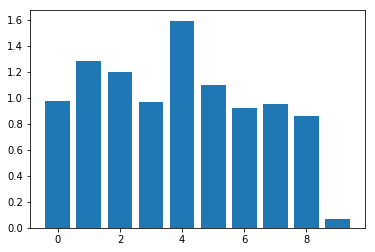

In [64]:
## Means of CB-Orange by song

print(bird_list)
print(np.shape(data_array))

orange_means = np.nanmean(data_array[5,:,:,1],0)

fig, ax = plt.subplots()
ax.bar(range(10),orange_means)
fig.show()
print(song_list)
#print(true_order)


7
SpearmanrResult(correlation=-0.28181818181818186, pvalue=0.4011448979604785)
SpearmanrResult(correlation=-0.24545454545454545, pvalue=0.4669223669820163)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


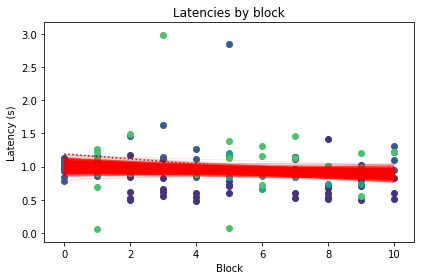

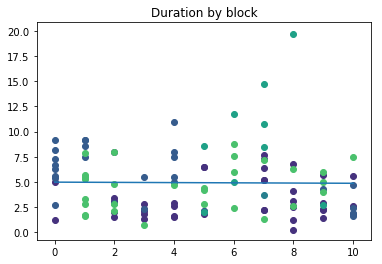

In [65]:
## Get durations,latencies by block: 

n_birds = np.shape(data_array)[0]
print(n_birds)
n_blocks = 11

durations = data_array[:,:,:,2]
durations[data_array[:,:,:,0] != 1] = np.nan
durations[data_key[:,:,:,2] == 0] = np.nan
good_durations = durations[~np.isnan(durations)]

latencies = data_array[:,:,:,1]
good_latencies = latencies[~np.isnan(latencies)]

#song_durations = [data_array[:,n,:,2][~np.isnan(data_array[:,n,:,2])] for n in range(n_blocks)]
#song_latencies = [data_array[:,n,:,1][~np.isnan(data_array[:,n,:,1])] for n in range(n_blocks)]

block_durations = [np.nan] * n_blocks
block_latencies = [np.nan] * n_blocks

## Get durations and latencies by song
for i in range(n_blocks):
    n = i
    p_indices = np.logical_and(~np.isnan(data_array[:,n,:,2]),data_array[:,n,:,0] == 1)
    crap_indices = data_key[:,n,:,2] == 0
    block_durations[i] = data_array[:,n,:,2][np.logical_and(p_indices,~crap_indices)]
    block_latencies[i] = data_array[:,n,:,1][np.logical_and(p_indices,~crap_indices)]

fig,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
#fig,(ax1,ax2) = plt.subplots(1,2)

dur_xs,dur_ys = [],[]
lat_xs,lat_ys = [],[]

for s in range(n_blocks):
    #ax2.scatter([s]*len(block_durations[s]),block_durations[s],alpha=.5)
    #ax1.scatter([s]*len(block_latencies[s]),block_latencies[s],alpha=.5)
    dur_xs.extend([s]*len(block_durations[s]))
    dur_ys.extend(block_durations[s])
    lat_xs.extend([s]*len(block_latencies[s]))
    lat_ys.extend(block_latencies[s])

for f in range(n_birds):
    xs,Lys,Dys = [],[],[]
    for s in range(n_blocks):
        p_indices = np.logical_and(~np.isnan(data_array[f,s,:,2]),data_array[f,s,:,0] == 1)
        crap_indices = data_key[f,s,:,2] == 0
        bird_latencies = data_array[f,s,:,1][np.logical_and(p_indices,~crap_indices)]
        bird_durations = data_array[f,s,:,2][np.logical_and(p_indices,~crap_indices)]
        xs.extend([s] * len(bird_latencies))
        Lys.extend(bird_latencies)
        Dys.extend(bird_durations)
    ax1.scatter(xs,Lys,color=color_map(f/n_birds))
    ax2.scatter(xs,Dys,color=color_map(f/n_birds))
    
#ax2.boxplot(block_durations,positions=range(n_blocks))
#ax1.boxplot(block_latencies,positions=range(n_blocks))

ax1.set_title('Latencies by block')
ax2.set_title('Duration by block')

block_means_dur = [np.nanmean(block_durations[i]) for i in range(len(block_durations))]
block_means_lat = [np.nanmean(block_latencies[i]) for i in range(len(block_latencies))]
print(spearmanr(block_means_lat,range(len(block_means_lat))))
print(spearmanr(block_means_dur,range(len(block_means_dur))))
    
slope,intercept = np.polyfit(range(len(block_means_lat)),block_means_lat,1)
fit_line = np.poly1d([slope,intercept])
ax1.plot(fit_line(np.arange(n_blocks)))
ax1.set_ylabel('Latency (s)')
ax1.set_xlabel('Block')
ax1.plot([0,10],[sorted(block_means_lat)[-1],sorted(block_means_lat)[0]],color='black',linestyle=':',alpha=.7)


slope2,intercept2 = np.polyfit(range(len(block_means_dur)),block_means_dur,1)
fit_line2 = np.poly1d([slope,intercept2])
ax2.plot(fit_line2(np.arange(n_blocks)))

### DO some bootstrapping
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(x=np.array(lat_xs), y=np.array(lat_ys), size=5000)

x = np.array([0,10])
#plt.figure(figsize=(10, 8))

# Plot the bootstrap lines
for i in range(1000):
    _ = ax1.plot(x, bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')



fig.set_size_inches(6,4)
fig.tight_layout()
fig.show()



#fig.savefig('/home/ammon/Desktop/ToCompy/durations_byblock.svg')

In [66]:
## Boot strap confidence intervals for the above plots
# Cribbed from Serhan Aya (serhanaya.github.io)

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(shape=size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds)) # sampling the indices (1d array requirement)
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(x=np.array(lat_xs), y=np.array(lat_ys), size=5000)

x = np.array([20, 240])
#plt.figure(figsize=(10, 8))

# Plot the bootstrap lines
for i in range(1000):
    _ = ax1.plot(x, bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# Plot the data
#_ = ax1.plot(prm1, rad2, marker='.', linestyle='none')

# Label axes, set the margins, and show the plot
_ = ax1.set_xlabel('perimeter_1', fontsize=16)
_ = ax1.set_ylabel('radius_2', fontsize=16)
#plt.margins(0.02)
fig.show()

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(0.46216816065298133, 0.17868637780443722)
self sorted:
(-0.5829964379478784, 0.07691019007241025)
(0.2758524455297725, 0.4404318493432298)
self sorted:
(-0.04948498068663858, 0.8920162902109748)
(0.49533429579166094, 0.14545925315368102)
self sorted:
(-0.18662971378616466, 0.6056724966108702)
(0.6203723351351519, 0.055665314502620085)
self sorted:
(0.07337737297297496, 0.8403484485859508)
(0.41785544701867244, 0.22951410747271447)
self sorted:
(-0.11396057645963795, 0.753923605977703)
(0.45094535222930093, 0.19086211736476674)
self sorted:
(-0.41391034090033996, 0.23439599979859277)
(nan, 1.0)
self sorted:
(nan, 1.0)
[0.14285714 0.         0.         0.14285714 0.         0.125
 0.11111111 0.         0.4        0.16666667]
[0.02380952 0.01515152 0.         0.02380952 0.12407407 0.09490741
 0.12255892 0.09015152 0.0875     0.17407407]
(0.8228749301672376, 0.0034567892353481746)


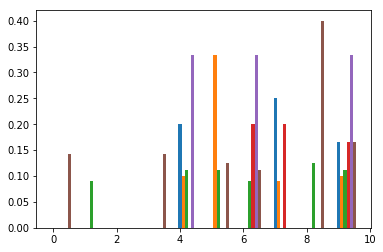

In [68]:
np.shape(partials_bybird)
fig, ax = plt.subplots()
for b in range(n_birds):
    ax.bar(np.arange(10) + b*.1,partials_bybird[b,song_order,0],width=.1)
    print(pearsonr(range(10),partials_bybird[b,song_order,0]))
    print('self sorted:')
    print(pearsonr(range(10),partials_bybird[b,np.argsort(songs_bybird[b,:,0]),0]))
    
print(partials_bybird[b-1,song_order,0])
print(np.nanmean(partials_bybird[:,song_order,0],0))
print(pearsonr(range(10),np.nanmean(partials_bybird[:,song_order,0],0)))

2019-05-22-17-02-54_LB
457


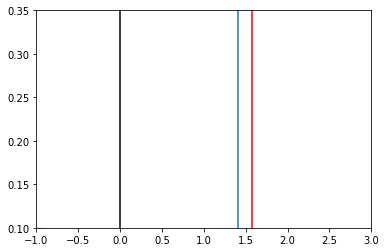

2019-05-24-07-02-40_GRG
97


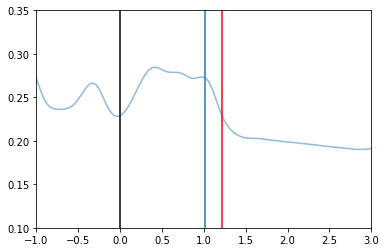

2019-05-25-11-37-43_DMG
764


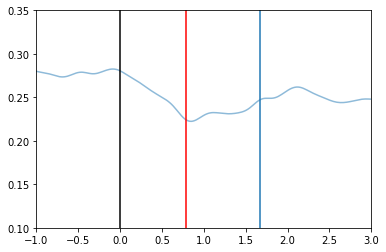

2019-05-31-08-35-31_DBR
402


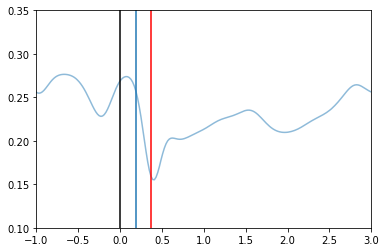

2019-06-04-08-36-49_DMG
285


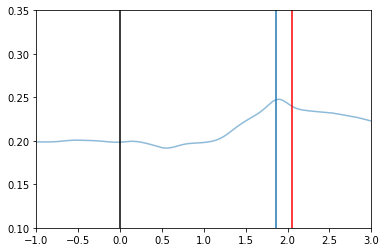

2019-06-05-08-32-56_GRG
835


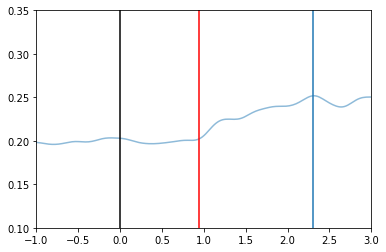

2019-06-06-15-42-49_2M
224


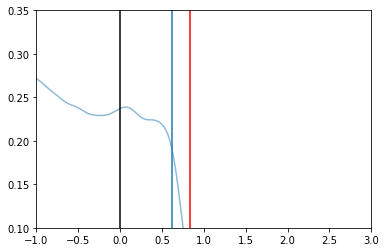

2019-06-06-18-32-56_ND
575


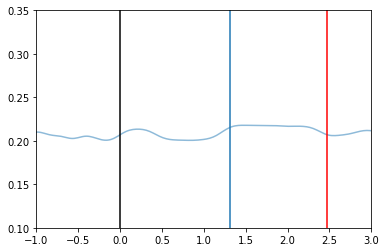

2019-06-08-15-46-12_GRG
893


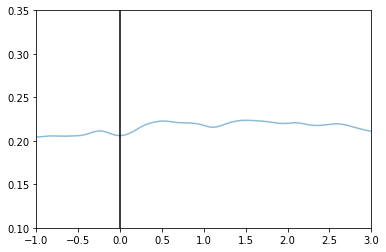

2019-06-10-10-16-11_GRG
270


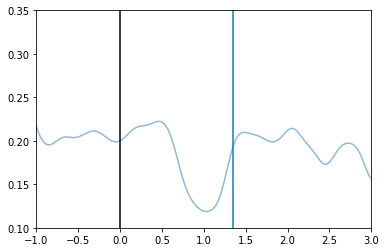

2019-06-10-15-46-15_DMG
272


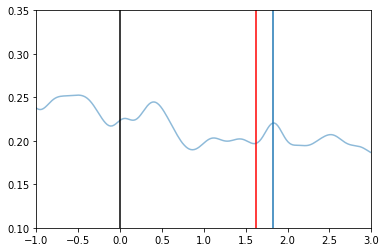

2019-06-14-07-02-57_WG
188


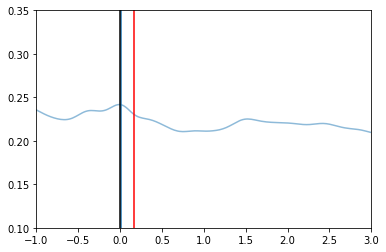

2019-06-14-13-16-17_WG
857


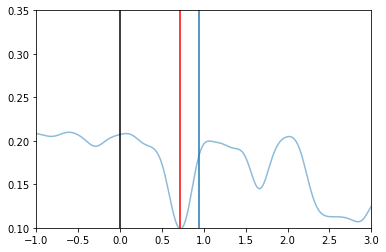

2019-06-18-08-33-10_ND
206


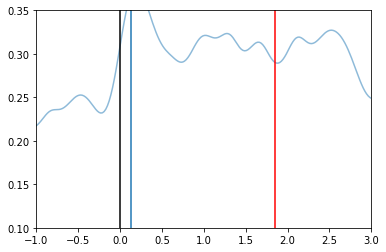

2019-06-18-18-34-04_WG
468


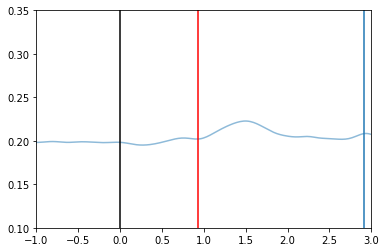

2019-06-19-15-32-54_LB
250


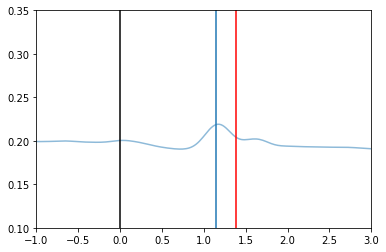

2019-06-20-18-37-59_2M
772


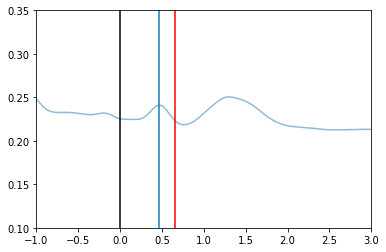

2019-06-21-08-32-59_DMG
219


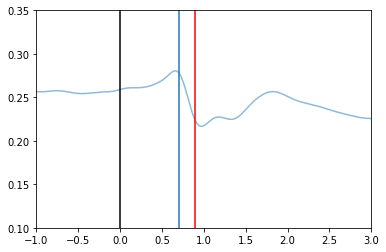

2019-06-21-18-46-14_GRG
907


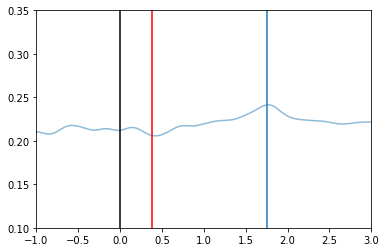

2019-06-22-07-03-58_2M
313


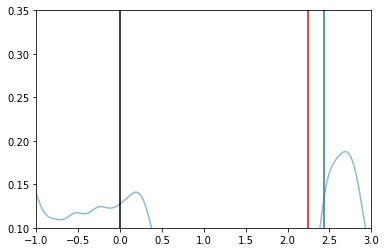

2019-06-24-07-16-16_2M
337


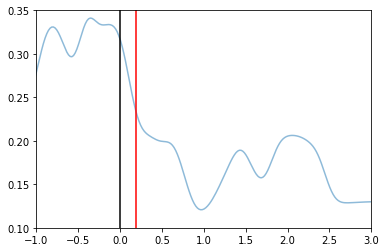

2019-06-24-10-16-15_DBR
447


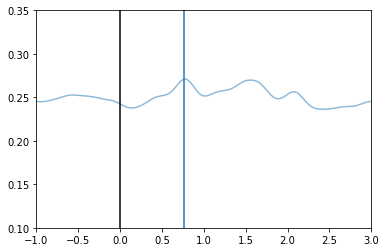

2019-06-25-13-16-15_DMG
61


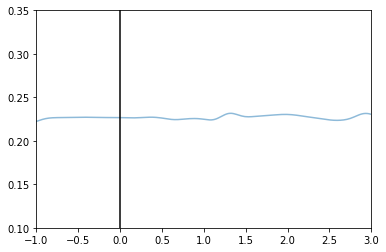

2019-06-27-07-03-37_2M
40


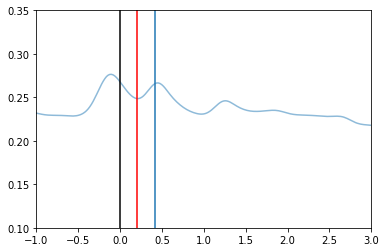

2019-06-27-11-46-16_BDY
0


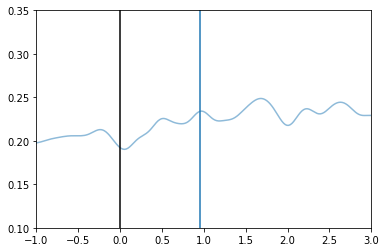

2019-06-28-08-46-13_DBR
316


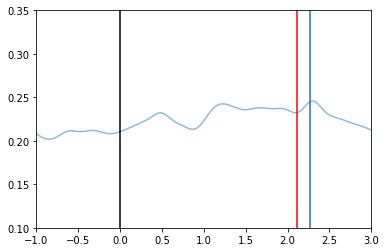

2019-06-29-07-16-14_LB
26


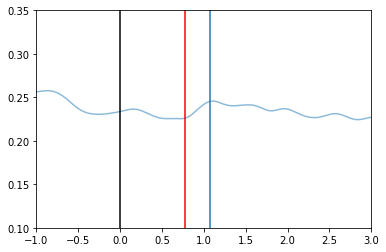

2019-07-01-08-46-14_BOD
695


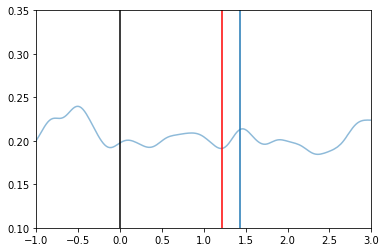

Posture max vs partial max:
0.0006090438265420395 0.0007731261805062268
Ttest_indResult(statistic=-1.424132582770973, pvalue=0.1571637415394666)
Posture min vs partial min:
-0.0006019114999447032 -0.0007442707438081493
Ttest_indResult(statistic=1.0328936486025286, pvalue=0.30385923398371295)


In [72]:
## Plot all partial postures, see if they look different somehow. They don't, although this is noisy. 

p_maxes,p_mins = [],[]
a_maxes,a_mins = [],[]

for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    if seq.posture and seq.offset != 0:
        i_max = np.argmax(seq.acc[seq.response_range[:-2],3,2])
        i_min = np.argmin(seq.acc[seq.response_range[:-2],3,2])
        t_max = seq.acc_t[seq.response_range[:-2]][i_max]
        t_min = seq.acc_t[seq.response_range[:-2]][i_min]

        a_max = seq.acc[seq.response_range[:-2],3,2][i_max]
        a_min = seq.acc[seq.response_range[:-2],3,2][i_min]
        if seq.posture == 1:
            if t_min > t_max:
                p_maxes.append(a_max)
                p_mins.append(a_min)
            if False:
                print(seq.seq_name)
                plt.plot(seq.ts,seq.smooth_data[:,3,2])

                plt.show()
        if seq.posture == 2:
            if True:
                print(seq.seq_name)
                print(np.argmin(seq.acc[:,3,2]))

            if t_min > t_max:
                a_maxes.append(a_max)
                a_mins.append(a_min)
            if True:
                plt.plot(seq.ts,seq.smooth_data[:,3,2],alpha=.5)
                #plt.plot(seq.acc_t[seq.response_range[:-2]],seq.acc[seq.response_range[:-2],3,2] * 30)
                plt.axvline(t_min)
                plt.axvline(t_max,color='red')
                plt.xlim([-1,3])
                plt.ylim([.1,.35])
                plt.axvline(0,color='black')
                plt.show()
                #ax.plot(seq.ts,seq.smooth_data[:,3,2],alpha=.5)

print("Posture max vs partial max:")
print(np.mean(p_maxes),np.mean(a_maxes))
print(ttest_ind(p_maxes,a_maxes))

print("Posture min vs partial min:")
print(np.mean(p_mins),np.mean(a_mins))
print(ttest_ind(p_mins,a_mins))



Using Means:
(-0.47100163211389423, 0.1694351740308918)
Pearsons r: -0.197
p: 0.21134156784082386


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


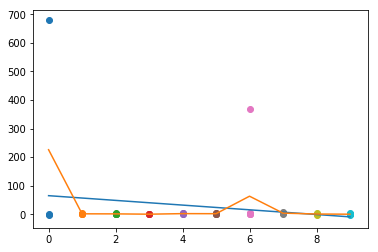

In [77]:
## Actually Plot stuff (to avoid re-running every time I change font)
fig,ax = plt.subplots()

xpoint_list = []
ypoint_list = []
ypoints_byblock = []

for n in range(10):
    #ax.scatter([n]*n_birds,slope_array[n,:])
    #good_points = slope_array[n,:][~np.isnan(slope_array[n,:])]
    good_points = p_array[n,:][~np.isnan(p_array[n,:])]
    #good_points = np.clip(good_points,-.1,.1)
    #print(good_points)
    good_xs = [n] * len(good_points)
    ypoint_list.extend(good_points)
    xpoint_list.extend(good_xs)
    #print(n,good_points)
    ypoints_byblock.append(good_points)
    ax.scatter(good_xs,good_points)
    
for f in range(n_birds):
    ys = p_array[:,f][~np.isnan(p_array[:,f])]
    xs = np.argwhere(~np.isnan(p_array[:,f]))
    xs = np.reshape(xs,len(xs))
    #ax.plot(xs,ys)
    #print(pearsonr(xs,ys))
#print(ypoints_byblock)
corr,p_value = pearsonr(xpoint_list,ypoint_list)

slope,intercept = np.polyfit(xpoint_list,ypoint_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(fit_line(np.arange(10)))
ax.plot(np.arange(10),np.nanmean(p_array[:10],1))


print('Using Means:')
print(pearsonr(np.arange(10),np.nanmean(p_array[:10],1)))
#ax.boxplot(ypoints_byblock,positions=np.arange(len(ypoints_byblock)))
#print(slope,intercept)
#ax.set_ylim([-0.1,0.1])
#ax.set_xlim([0,9])
fig.show()
print('Pearsons r: %.3f' % corr)
print('p:',p_value)

#fig.savefig('/home/ammon/Desktop/ToCompy/true_selectivity_by_block.svg')

In [78]:
## Check which birds are selective

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


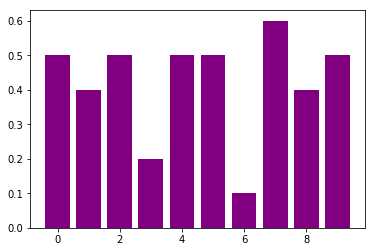

In [79]:
fig,ax = plt.subplots()
ax.bar(range(10),np.nanmean(plot_array[11][true_order],0),color='purple')

fig.show()

(11, 10)
(15,)
(15, 11)
[5.45454545 2.75909091 1.53263403 1.58636364 2.07121212 1.86072261
 1.32833833 2.58484848 1.88181818 1.49708625 1.70804196]
[0.8        0.54545455 0.27272727 0.3        0.5        0.54545455
 0.42857143 0.66666667 0.7        0.33333333 0.54545455]
-0.007191919191919187
-0.011691877589735899
-0.00686715059338633
-0.007276200399409557
-0.02252665646959721
-0.021404777496227535
-0.028109118257025004
-0.02568474901417456
-0.018123261601522462
-0.015690576453519227
-0.026994613483866295


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


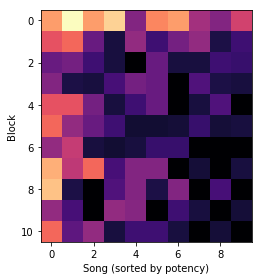

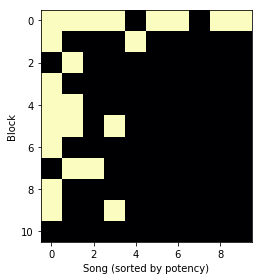

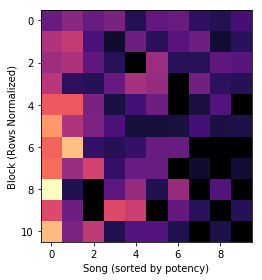

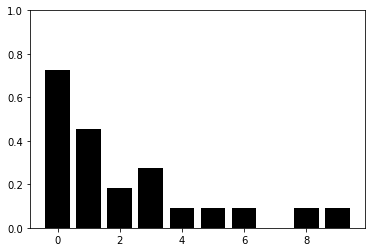

In [97]:
## Grab the data and plot for Fig5
mean_responses = np.nanmean(binary_array_all[safe_indices],0)[:,song_order]

print(np.shape(mean_responses))
fig,(ax) = plt.subplots()
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()

ax.imshow(mean_responses,vmin=0,cmap='magma')



ax2.imshow(mean_responses / np.sum(mean_responses,1)[:,None],vmin=0,cmap='magma')


normed_responses = mean_responses / np.sum(mean_responses,1)[:,None]


bird_responses = np.nanmean(binary_array_all[safe_indices],2)
bird_order = np.argsort(np.sum(bird_responses,1))[::-1]
print(np.shape(bird_order))
print(np.shape(bird_responses))
#ax1.imshow(np.transpose(bird_responses[bird_order])[:,:])
ax1.imshow(np.transpose(binary_array_all[19,:,song_order]),vmin=0,cmap='magma')
print(np.sum(mean_responses,1))
print(np.max(mean_responses,1))

for b in range(11):
    slope,intercept = np.polyfit(range(n_songs),normed_responses[b],1)
    print(slope)
#ax1.imshow(mean_responses / np.sum(mean_responses,1)[:,None],vmin=0)

ax.set_xlabel('Song (sorted by potency)')
ax.set_ylabel('Block')

ax1.set_xlabel('Song (sorted by potency)')
ax1.set_ylabel('Block')

ax2.set_xlabel('Song (sorted by potency)')
ax2.set_ylabel('Block (Rows Normalized)')


fig.show()
fig1.show()
fig2.show()

fig.tight_layout()
fig1.tight_layout()
fig2.tight_layout()

fig.savefig('/home/ammon/Desktop/PaperFigs/6b_.svg')
fig1.savefig('/home/ammon/Desktop/PaperFigs/6a_.svg')
fig2.savefig('/home/ammon/Desktop/PaperFigs/6c_.svg')

fig3,ax3 = plt.subplots()

ax3.bar(range(10),np.sum(binary_array_all[19,:,song_order] / 11,1),color='black')
ax3.set_ylim([0,1])

fig3.savefig('/home/ammon/Desktop/PaperFigs/6e_.svg')

In [122]:
## Grab the data and plot for Updated Figure 5
print(mean_responses.shape)

(11, 10)


In [141]:
inds = np.argwhere([1,0,0,1,0])[:,0]
print(inds)


[0 3]


In [217]:
# Measure concordance to the end point

np.diagonal(cdist(X,Y,metric=concordance_mean))
np.diagonal(cdist(X,Z,metric=concordance_mean))

array([1.        , 0.8       , 1.        , 1.        , 1.        ,
       0.83333333])

[ 0  1  2  3  4  5  8  9 10 11 12 14 16 17 18 19 21 23 24] [ 0  1  2  3  4  5  6  7 10 12 13 17 19 21 23]
0


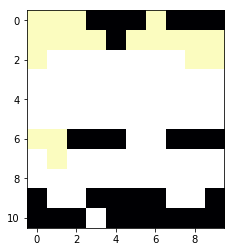

1


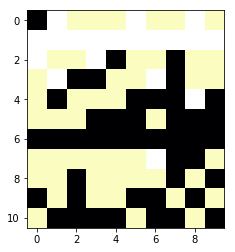

2


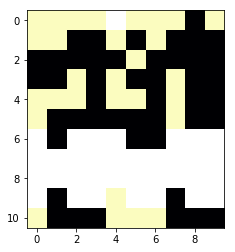

3


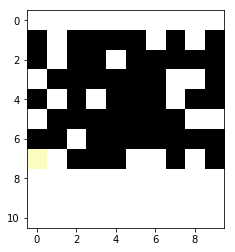

4


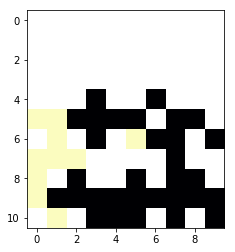

5


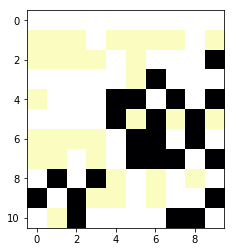

10


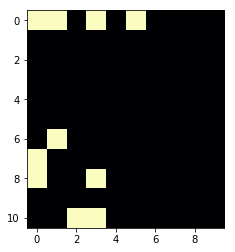

12


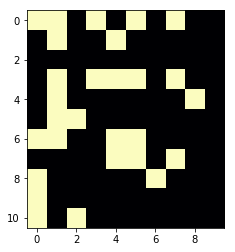

17


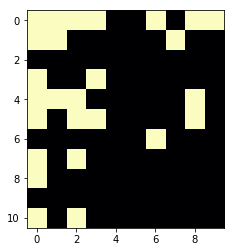

19


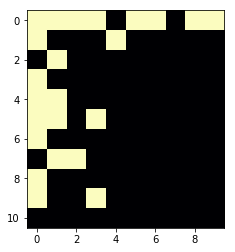

21


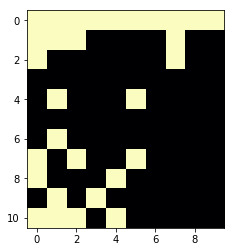

23


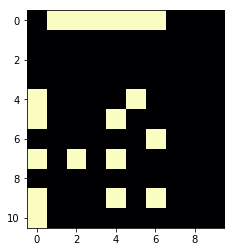

In [82]:
non_lesions = [0,3,5,6,10,12,14,16]
non_indices = np.array(non_lesions) + 7
print(np.arange(len(responsive_birds))[responsive_birds],safe_indices)
responsive_birds_safe = np.intersect1d(np.arange(len(responsive_birds))[responsive_birds],safe_indices)
for b in responsive_birds_safe:
    print(b)
    plt.imshow(np.transpose(binary_array_all[b,:,song_order]),vmin=0,cmap='magma')
    plt.show()

## Everything Below here is Extra
There are some good analyses down there, but all the paper figures are above. 

<IPython.core.display.Javascript object>


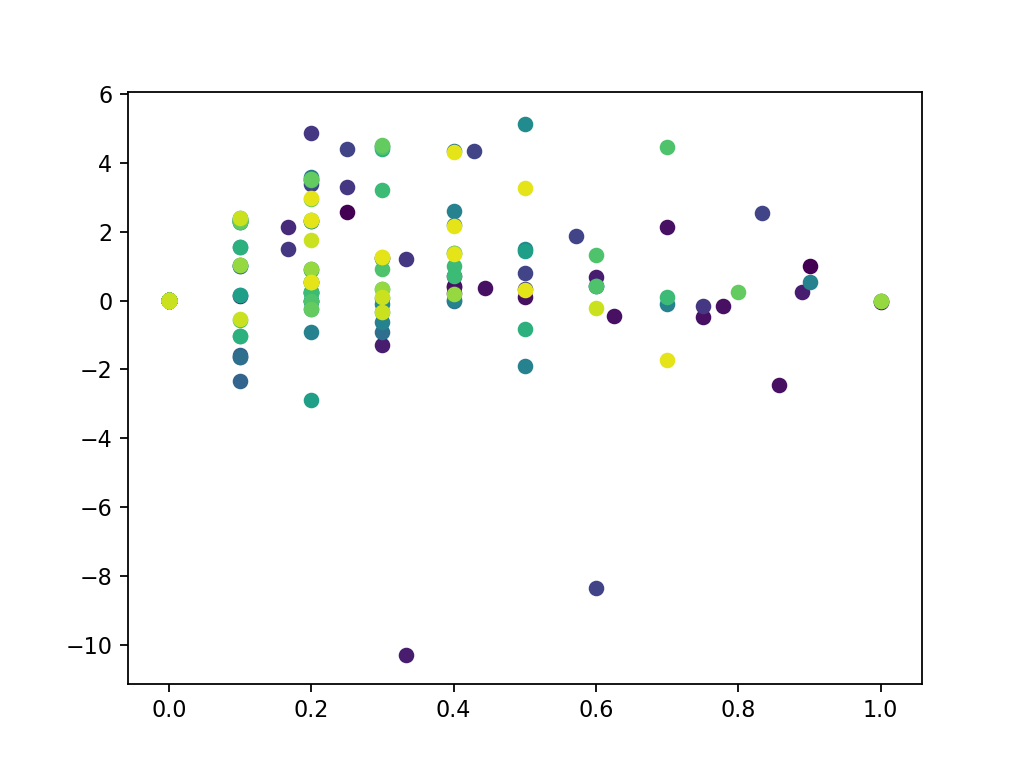

In [389]:
fig,ax = plt.subplots()
for n in range(25):
    ax.scatter(resp_array[:,n],p_array[:,n],color=color_map(n/25))
fig.show()

In [1172]:
#slope3,intercept3 = np.polyfit(dur_xs,sorted(dur_ys)[::-1],1)
print(slope3)
print(fit_line3(0))

-0.9530853090055322
-8.25072274522048


<IPython.core.display.Javascript object>


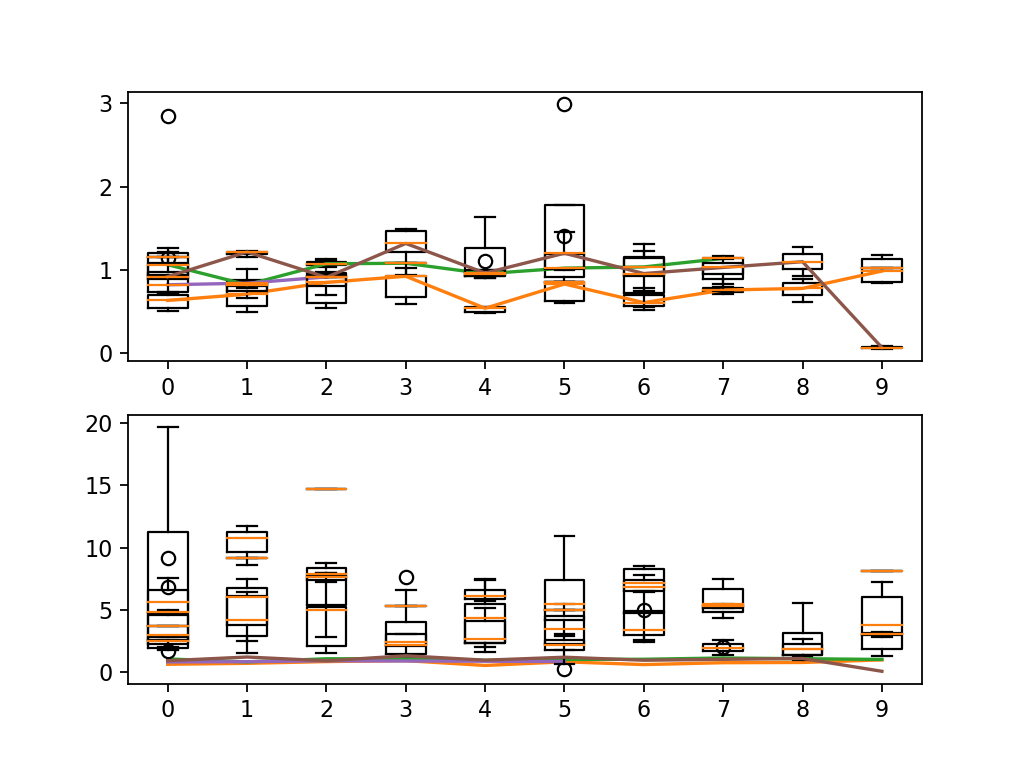

/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [349]:
## Plot latencies and durations split by bird

fig,(ax1,ax2) = plt.subplots(2)

bird_durations_bysong = [np.nan] * n_birds
bird_latencies_bysong = [np.nan] * n_birds


## As before, but now by bird by song
for b in range(n_birds):
    
    birdsong_durations = [np.nan] * n_songs
    birdsong_latencies = [np.nan] * n_songs

    for i in range(len(song_order)):
        n = song_order[i]
        p_indices = np.logical_and(~np.isnan(data_array[b,:,n,2]),data_array[b,:,n,0] == 1)
        crap_indices = data_key[b,:,n,2] == 0
        birdsong_durations[i] = data_array[b,:,n,2][np.logical_and(p_indices,~crap_indices)]
        birdsong_latencies[i] = data_array[b,:,n,1][np.logical_and(p_indices,~crap_indices)]
    bird_durations_bysong[b] = birdsong_durations
    bird_latencies_bysong[b] = birdsong_latencies
    ax1.boxplot(birdsong_latencies,positions=range(n_songs))
    ax2.boxplot(birdsong_durations,positions=range(n_songs))
    lat_meds = [np.nanmedian(birdsong_latencies[i]) for i in range(n_songs)]
    dur_meds = [np.nanmedian(birdsong_durations[i]) for i in range(n_songs)]
    med_array = np.array(lat_meds)
    ax1.plot(range(n_songs),lat_meds)
    ax2.plot(np.arange(n_songs)[~np.isnan(med_array)],med_array[~np.isnan(med_array)])
    if False:
        print(len(med_array[~np.isnan(med_array)]))
        if len(med_array[~np.isnan(med_array)]) > 0:
            print(spearmanr(med_array[~np.isnan(med_array)],range(len(med_array[~np.isnan(med_array)]))))
            print(med_array)
        else:
            print('no data:',med_array)
    
    
#print(bird_durations_bysong)

"""
for s in range(n_songs):
    ax2.scatter([s]*len(song_durations[s]),song_durations[s],alpha=.5,label=song_list[true_order[s]])
    ax1.scatter([s]*len(song_latencies[s]),song_latencies[s],alpha=.5)
    
    lat_xs.extend([s]*len(song_latencies[s]))
    lat_ys.extend(song_latencies[s])
    dur_xs.extend([s]*len(song_durations[s]))
    dur_ys.extend(song_durations[s])
    
    mean_durations[s] = np.mean(song_durations[s])
"""
pass

(7, 14, 10, 4)
[0.49699974 0.48399997 0.49300027 0.05299997 0.08100009]
1 2 2
['2019-06-19-08-33-16_ND' 'birdview-2' 1]
1 4 7
['2019-06-21-10-04-58_WG' 'birdview-2' 1]
1 9 7
['2019-06-27-10-04-26_WG' 'birdview-2' 1]
5 1 9
['2019-06-18-11-46-13_DMG' 'birdview' 1]
5 5 9
['2019-06-22-13-16-14_DMG' 'birdview' 1]
2019-06-21-10-04-58_WG 1.0 none


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


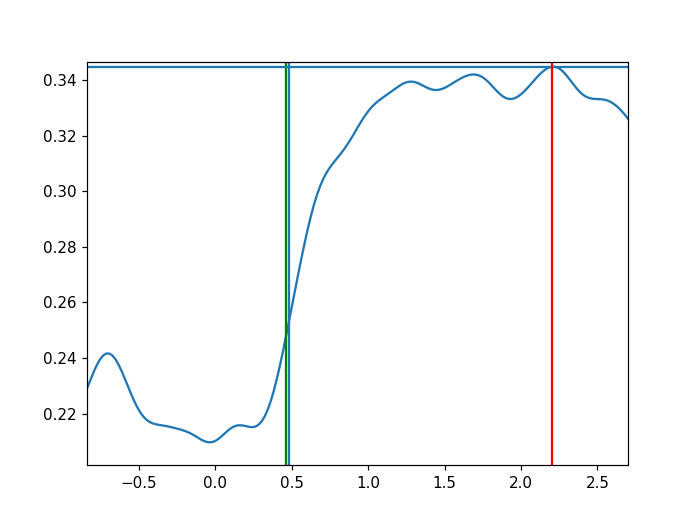

0.46399998664855957
none


In [629]:
## Do some outlier checking

print(np.shape(data_array))
print(data_array[:,:,:,1][data_array[:,:,:,1] < .5])
#print(np.where(data_array[:,:,:,1] > .1))
blocks,birds,songs = np.where(data_array[:,:,:,1] < .5)
for i in range(len(blocks)):
    a,b,c = blocks[i],birds[i],songs[i]
    
    print(a,b,c)
    print(data_key[a,b,c])

## Super Comment? 
"""
Long Durations, fixed now.
0: 1,11,5 ['2019-06-29-07-03-05_DBR' 'birdview-2'] -> floor posture (normal length) (CHECK!!)
1: 4,6,2 ['2019-06-10-11-46-12_ND' 'birdview'] -> very long
2: 4,7,8 ['2019-06-12-11-46-13_LNR' 'birdview'] -> very long, holds tail up after the end of posture...(need PCA)
3: 4,8,0 ['2019-06-13-07-16-15_BDY' 'birdview'] -> quite long, holds tail up after (great cloaca, btw)
4: 5,3,4 ['2019-06-20-15-46-13_2M' 'birdview'] -> no posture (CHECK!!)
5: 5,6,2 ['2019-06-23-10-16-14_ND' 'birdview'] -> very short, some flying around (CHECK)
6: 5,10,2 ['2019-06-28-18-46-14_ND' 'birdview'] -> Pretty normal, but starts upside down, could cause issues
7: 5,11,4 ['2019-06-29-10-16-14_2M' 'birdview'] -> floor posture, ends in frame, pretty short (CHECK) -> crap seq, what is it doing here?
8: 5,11,6 ['2019-06-29-17-16-15_GRG' 'birdview'] -> very normal, slightly weak posture, probably accurate...

Long Latencies: 
2 4 2 ['2019-06-04-18-42-42_ND' 'birdview-2' 1] -> floor posture, unlabeled
2 5 0 ['2019-06-06-07-03-02_BDY' 'birdview-2' 1] -> starts on ceiling
3 1 4 ['2019-05-23-11-06-05_2M' 'birdview-2' 1] -> not a posture, mislabeled and a big 3d error
5 3 4 ['2019-06-20-15-46-13_2M' 'birdview' 1] -> Probably a tail id error. PCA could fix? Or Confidence
"""
seq_dir = './CrapSeqs/'
seq_dir = './SeqClasses/'
s = data_key[1,4,7,0] + '.obj'
seq = pickle.load(open(seq_dir + s,'rb'))
print(seq.seq_name,seq.posture, seq.notes)
fig,ax = plt.subplots()

ax.plot(seq.ts,seq.smooth_data[:,3,2])
ax.axvline(seq.ts[seq.vmax_index])
ax.axvline(seq.ts[seq.refraction_index])
ax.axvline(seq.ts[seq.t_latency_index],color='green')
print(seq.t_latency)
ax.axhline(seq.peak_height)
ax.axvline(seq.ts[seq.peak_height_index],color='red')
print(seq.notes)

In [1026]:
## Perform analysis by time:

## Loop through all the sequences to extract time stamps

n_postures = len(os.listdir('./SeqClasses/'))
hour_list = []
date_dict = {}
date_count = 0
## Takes a time stamp, the posture, song?, latency, duration
timed_data = np.array([n_postures,3])
for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    hour = int(seq.seq_name.split('-')[3])
    if not hour in hour_list:
        hour_list.append(hour)
    if not seq.date in date_dict.keys():
        date_dict[seq.date] = date_count
        date_count += 1

hour_list = sorted(hour_list)

## Split them out by time of day and date so I can run correlations. Easy peasy. 

In [1002]:
## Get the data organized

n_days = len(date_dict.keys())
n_hours = len(hour_list)
date_array = np.zeros([n_days,n_songs,2])
hour_array = np.zeros([n_hours,n_songs,2])

hour_indices = dict(zip(hour_list,range(len(hour_list))))


latency_by_date = [[] for n in date_dict.keys()]
duration_by_date = [[] for n in date_dict.keys()]
latency_by_hour = [[] for n in hour_list]
duration_by_hour = [[] for n in hour_list]

## Loop back through, and grab data and arrange it nicely
for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    hour = int(seq.seq_name.split('-')[3])
    hour_index = hour_indices[hour]
    date_index = date_dict[seq.date]
    song_index = song_dict[seq.song]
    if seq.posture == 1:
        date_array[date_index,song_index] += 1
        hour_array[hour_index,song_index] +=1
    else:
        date_array[date_index,song_index,1] += 1
        hour_array[hour_index,song_index,1] += 1
    if seq.offset != 0 and seq.posture == 1:
        latency_by_date[date_index].append(seq.t_vmax[0])
        latency_by_hour[hour_index].append(seq.t_vmax[0])
        duration_by_date[date_index].append(seq.duration)
        duration_by_hour[hour_index].append(seq.duration)
        
        

(0.38959240462396605, 0.0056574331638120715)


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


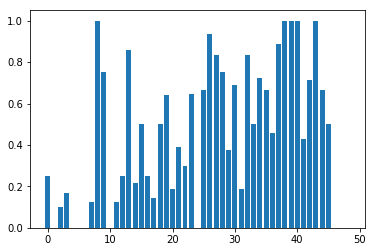

In [1022]:
# Plot responses by hour and time
songs_by_hour = hour_array[:,:,0] / hour_array[:,:,1]
songs_by_date = date_array[:,:,0] / date_array[:,:,1]


fig,(ax1,ax2) = plt.subplots()
ax1.bar(range(len(songs_by_date)),np.nanmean(songs_by_date,1))
#ax2.bar(range(n_hours),np.nanmean(songs_by_hour,1))
#print(pearsonr(range(n_hours),np.nanmean(songs_by_hour,1)))

print(pearsonr(range(len(songs_by_date)),np.nanmean(songs_by_date,1)))
fig.show()

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


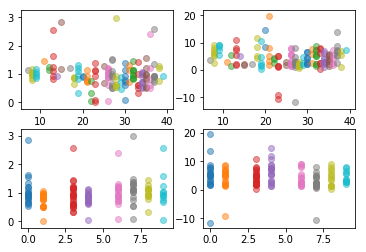

In [1025]:
## Look at latency, duration by time
fig,axes = plt.subplots(2,2)

ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
date_lat_means = []
hour_lat_means = []
for n in range(len(latency_by_date)):
    ax1.scatter([n] * len(latency_by_date[n]),latency_by_date[n],alpha=.5)
    ax2.scatter([n] * len(duration_by_date[n]),duration_by_date[n],alpha=.5)
    
for h in range(len(latency_by_hour)):
    ax3.scatter([h] * len(latency_by_hour[h]),latency_by_hour[h],alpha=.5)
    ax4.scatter([h] * len(duration_by_hour[h]),duration_by_hour[h],alpha=.5)
    
fig.show()

[        nan         nan         nan         nan         nan         nan
         nan  3.67400002  6.31825009  7.98940005         nan  2.89499998
  3.38400006  6.02216665  4.99099994  2.04599988         nan  2.02100015
  7.41974998  3.60416667 11.60300004  7.6230001   3.6160001  -0.8011429
         nan  2.26099992  4.18336365  1.81400003  1.81971427  3.03766664
  4.06857143  5.32099994  4.99655557  4.56833335  3.72522224  3.83625001
  4.32919998  7.04100004  4.50733336  7.421              nan         nan
         nan         nan         nan         nan         nan         nan
         nan]
(0.051838631621938344, 0.7855835819659772)


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


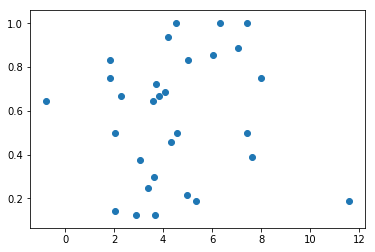

In [1104]:
# Compare response rate and duration

mean_durations = np.zeros(len(duration_by_date))
for d in range(len(duration_by_date)):
    mean_durations[d] = np.nanmean(duration_by_date[d])

fig,ax = plt.subplots()
ax.scatter(mean_durations,np.nanmean(songs_by_date,1))
print(mean_durations)
print(pearsonr(mean_durations[~np.isnan(mean_durations)],np.nanmean(songs_by_date,1)[~np.isnan(mean_durations)]))
fig.show()

In [992]:
### We have a smallish problem here, could be a big problem....

from datetime import datetime
timestamp = 1545730073
dt_object = datetime.fromtimestamp(seq.timestamp)
print("dt_object =", dt_object)
print("type(dt_object) =", type(dt_object))
print(seq.seq_name)
print(int(seq.seq_name.split('-')[3]))


dt_object = 2019-05-22 17:00:02.810000
type(dt_object) = <class 'datetime.datetime'>
2019-05-22-17-02-54_LB
17
1558558810.525 2.0


<IPython.core.display.Javascript object>


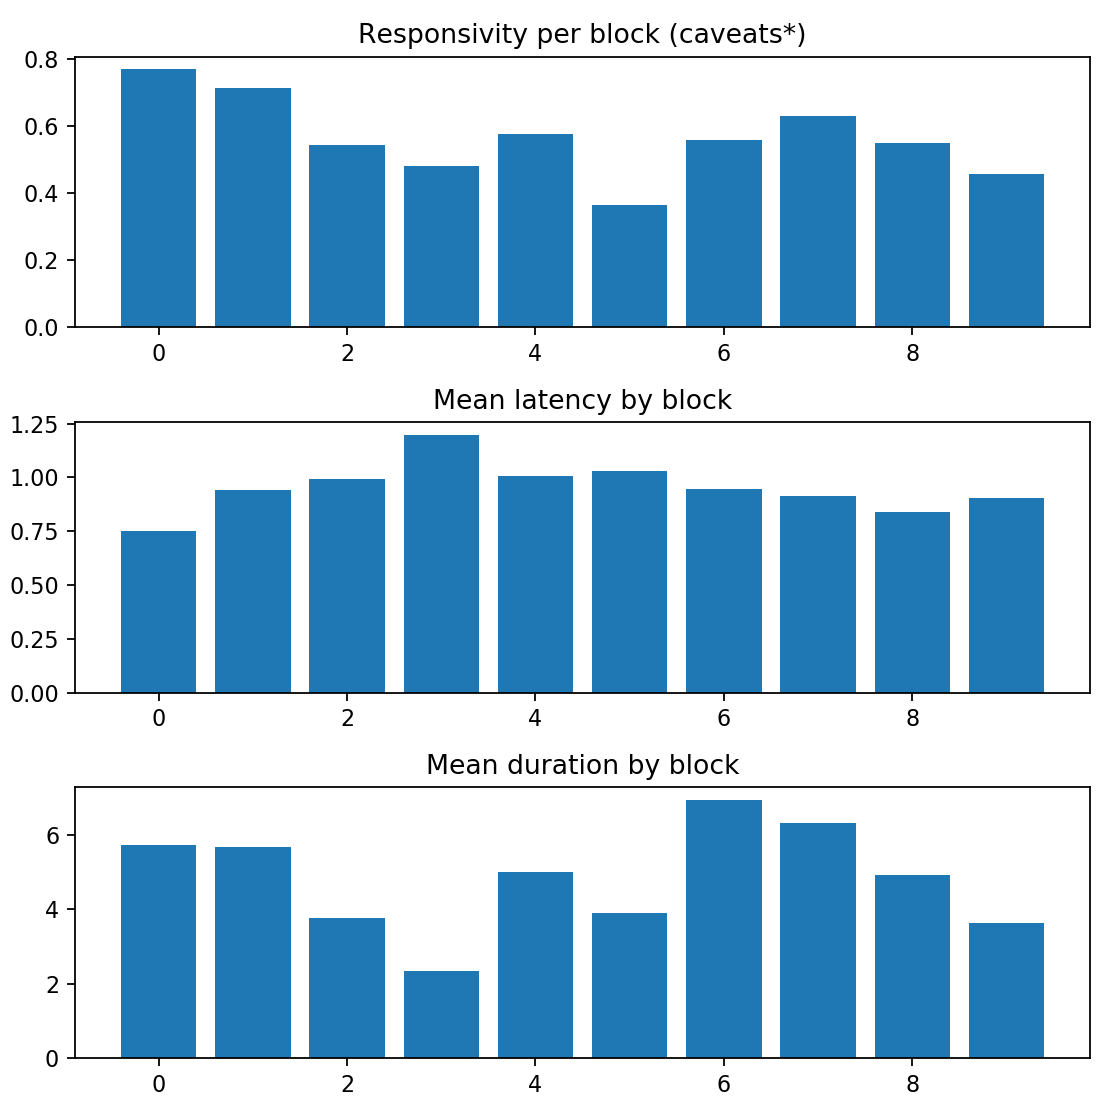

In [350]:

## Plot postures, latency, duration by block (careful...)
block_sums = np.nansum(data_array,axis=(0,2))
block_means = np.nanmean(data_array,axis=(0,2))
block_std = np.nanstd(data_array,axis=(0,2))
fig,(ax1,ax2,ax3) = plt.subplots(3)

ax1.set_title('Responsivity per block (caveats*)')
ax1.bar(range(10),block_means[:10,0])
#ax1.bar(range(14),block_means[:,0],yerr=block_std[:,0])

ax2.set_title('Mean latency by block')
ax2.bar(range(10),block_means[:10,1]) #,yerr=block_std[:,0])

ax3.set_title('Mean duration by block')
ax3.bar(range(10),block_means[:10,2])


fig.set_size_inches(7,7)
fig.tight_layout()
fig.show()

fig.savefig('/home/ammon/Desktop/ToCompy/responsivity_byblock.png')

(7, 14, 10, 4)
(14, 4)


<IPython.core.display.Javascript object>


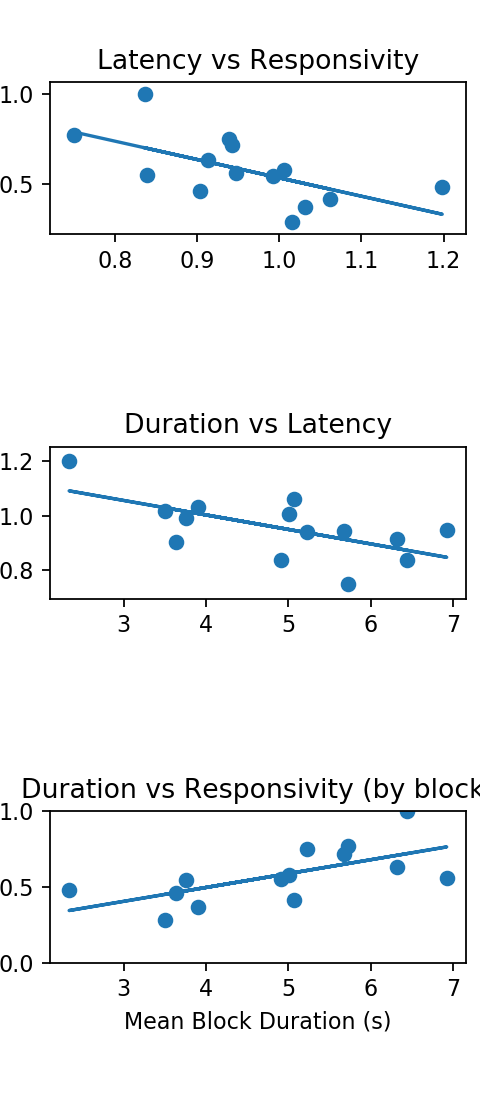

-0.6088463341855547 0.020841883714384328
-0.6269540535593585 0.016412148553243803
0.641882039157871 0.013332295230124669
SpearmanrResult(correlation=0.745054945054945, pvalue=0.0022300373167420734)


In [342]:
## Plot timing vs responsivity

print(np.shape(data_array))
print(np.shape(block_means))
fig,(ax1,ax2,ax3) = plt.subplots(3)


B = 10
ax1.set_title('Latency vs Responsivity')
ax1.scatter(block_means[:,1],block_means[:,0])
corr1,p_value1 = pearsonr(block_means[:,1],block_means[:,0])

slope1,intercept1 = np.polyfit(block_means[:,1],block_means[:,0],1)
fit_line = np.poly1d([slope1,intercept1])
ax1.plot(block_means[:,1],fit_line(block_means[:,1]))
print(corr1,p_value1)


ax2.set_title('Duration vs Latency')
ax2.scatter(block_means[:,2],block_means[:,1])
slope2,intercept2 = np.polyfit(block_means[:,2],block_means[:,1],1)
fit_line2 = np.poly1d([slope2,intercept2])
ax2.plot(block_means[:,2],fit_line2(block_means[:,2]))

corr2,p_value2 = pearsonr(block_means[:,2],block_means[:,1])
print(corr2,p_value2)

ax3.set_title('Duration vs Responsivity (by block)')

ax3.set_xlabel('Mean Block Duration (s)')
ax3.set_ylabel('Mean Block Responsivity Ratio')
ax3.set_ylim([0,1])
ax3.scatter(block_means[:,2],block_means[:,0])
slope3,intercept3 = np.polyfit(block_means[:,2],block_means[:,0],1)
fit_line3 = np.poly1d([slope3,intercept3])
ax3.plot(block_means[:,2],fit_line3(block_means[:,2]))

corr3,p_value3 = pearsonr(block_means[:,2],block_means[:,0])
print(corr3,p_value3)
print(spearmanr(block_means[:,2],block_means[:,0]))
fig.tight_layout()
fig.set_size_inches(3,7)
fig.show()

<IPython.core.display.Javascript object>


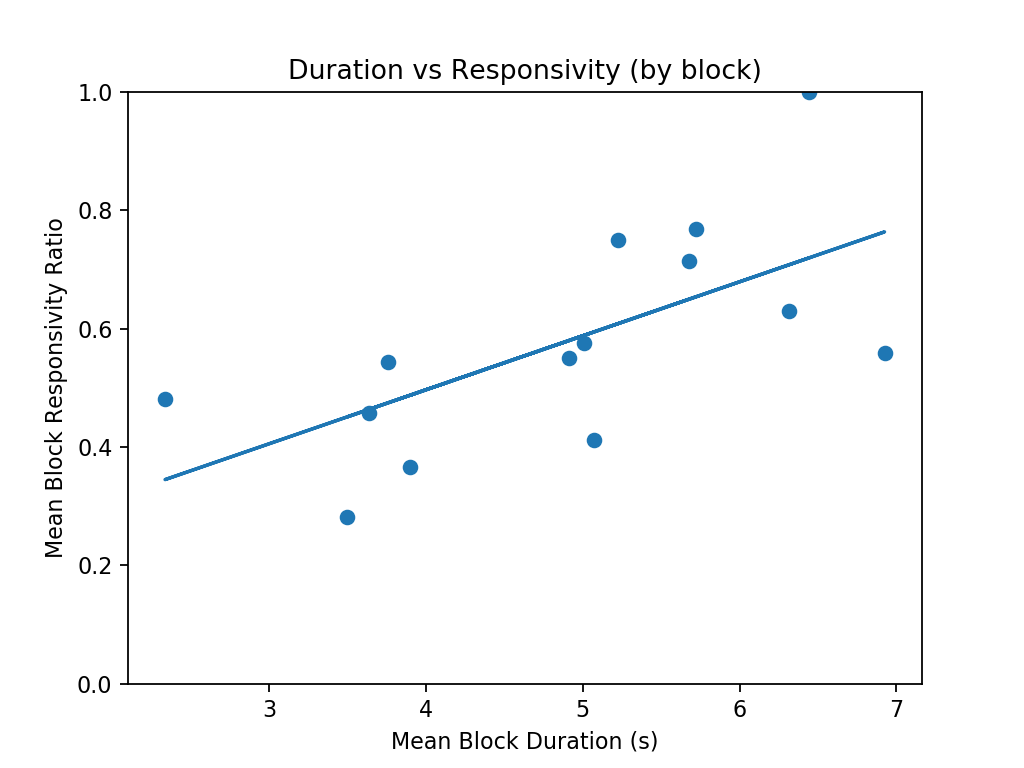

In [351]:
fig,ax = plt.subplots()

ax.set_title('Duration vs Responsivity (by block)')

ax.set_xlabel('Mean Block Duration (s)')
ax.set_ylabel('Mean Block Responsivity Ratio')
ax.set_ylim([0,1])
ax.scatter(block_means[:,2],block_means[:,0])
slope3,intercept3 = np.polyfit(block_means[:,2],block_means[:,0],1)
fit_line3 = np.poly1d([slope3,intercept3])
ax.plot(block_means[:,2],fit_line3(block_means[:,2]))

fig.show()

In [400]:
print(np.shape(binary_array[:,:,:,0]))
print(np.shape(data_key))

print(np.shape(binary_array[:,:,:,0][data_key[:,:,:,2] == 1]))

print(bird_list)

(7, 14, 10)
(7, 14, 10, 3)
(153,)
['CB-White', 'CB-Orange', 'CB-Yellow', 'CB-Red', 'CB-LB2', 'CB-Y2', 'CB-R2']


In [352]:
print(np.shape(np.nanmean(binary_array[:,b,:,0],axis=1)))
print(np.shape(binary_array))

(7,)
(7, 14, 10, 4)


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


0
1
2
3
4
5
6
7
8
9
10


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


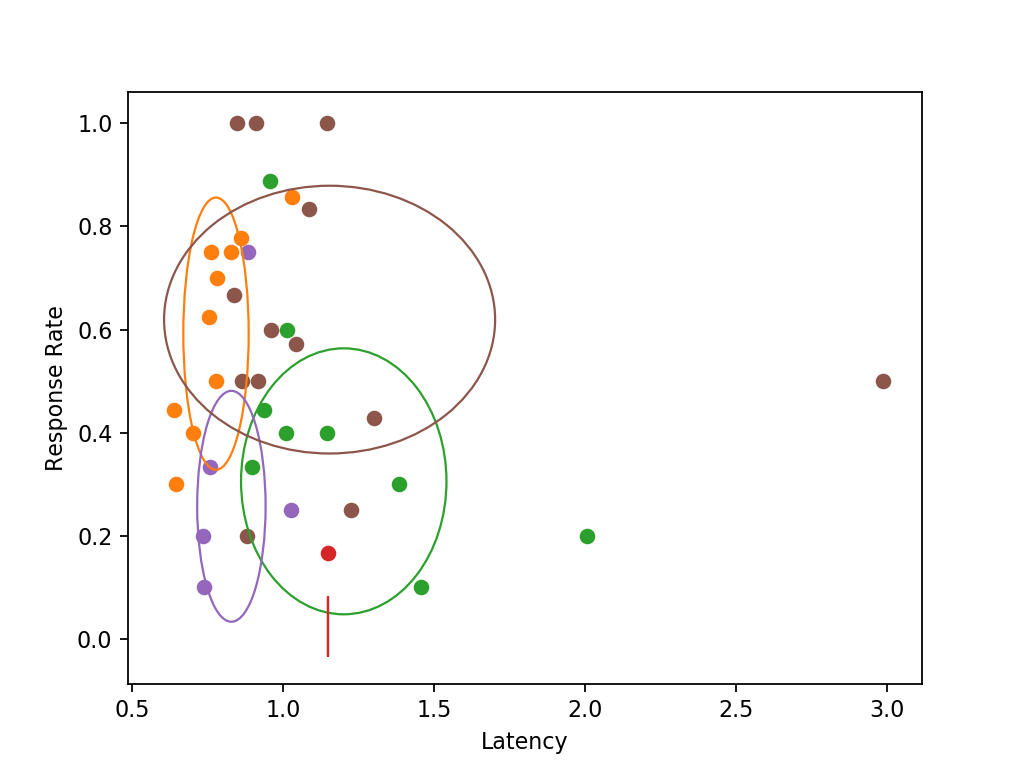

corr -0.1543983573601488 p: 0.3546810025157593


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


In [353]:
## Visualize Latency and Responsivity by bird, turned out to be less cool than I thought

bird_block_latencies = [[] for n in range(len(bird_list))]
bird_block_responses = [[] for n in range(len(bird_list))]
bird_block_durations = [[] for n in range(len(bird_list))]

block_bird_responses = [[] for n in range(n_blocks)]
block_bird_durations = [[] for n in range(n_blocks)]
block_bird_latencies = [[] for n in range(n_blocks)]

from matplotlib.patches import Ellipse

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

binary_array[:,:,:,1][data_key[:,:,:,2] == 0] = np.nan
binary_array[:,:,:,2][data_key[:,:,:,2] == 0] = np.nan
for b in range(len(bird_list)):
    bird_block_latencies[b] = np.nanmean(binary_array[b,:,:,1],axis=1)
    bird_block_responses[b] = np.nanmean(binary_array[b,:,:,0],axis=1)
    bird_block_durations[b] = np.nanmean(binary_array[b,:,:,2],axis=1)

## Same thing, but average by block this time.
# I chose a massochistic naming convention unfortunately

for b in range(n_blocks):
    print(b)
    block_bird_responses[b] = np.nanmean(binary_array[:,b,:,0],axis=1)
    block_bird_durations[b] = np.nanmean(binary_array[:,b,:,2],axis=1)
    block_bird_latencies[b] = np.nanmean(binary_array[:,b,:,1],axis=1)

fig,ax = plt.subplots()
ellipses = [[] for n in range(len(bird_list))]

ls = []
rs = []
for b in range(len(bird_list)):
    ax.scatter(bird_block_latencies[b],bird_block_responses[b],label=bird_list[b])
    l_mean = np.nanmean(bird_block_latencies[b])
    l_std = np.nanstd(bird_block_latencies[b])
    r_mean = np.nanmean(bird_block_responses[b])
    r_std = np.nanstd(bird_block_responses[b])
    ellipses[b] = Ellipse((l_mean,r_mean),width = l_std*2,height = r_std*2,facecolor='none',edgecolor=color_list[b])
    ax.add_patch(ellipses[b])
    
    good_l = bird_block_latencies[b][~np.isnan(bird_block_latencies[b])]
    good_r = bird_block_responses[b][~np.isnan(bird_block_latencies[b])]

    [ls.append(good_l[i]) for i in range(len(good_l))]
    [rs.append(good_r[i]) for i in range(len(good_r))]
    
slope,intercept = np.polyfit(ls,rs,1)
fit_line = np.poly1d([slope,intercept])
corr,p_value = pearsonr(ls,rs)

#ax.plot(ls,fit_line(ls))

    
ax.set_xlabel('Latency')
ax.set_ylabel('Response Rate')

print('corr',corr,'p:',p_value)

Pearsons r: 0.178


/home/ammon/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:1270: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)
/home/ammon/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


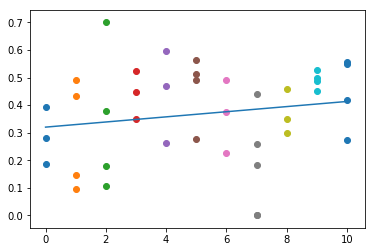

In [38]:
## Plot the emergence (or divergence...or neither) of selectivity over time
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon as js_divergence
from scipy.stats import pearsonr

js_array = np.empty([n_blocks,n_birds])
js_array.fill(np.nan)
for f in range(n_birds):
    for b in range(n_blocks):
        block_n = binary_array[f,b,:,0]
        mean_response = canon_means[f,:]
    
        mean_response = mean_response[~np.isnan(block_n)]
        block_n = block_n[~np.isnan(block_n)]
        
        if len(mean_response) == 0  or len(block_n) == 0:
            continue
        """
        if max(mean_response) == 0 or max(block_n) == 0:
            continue


        block_n[block_n == 0] = .001
        mean_response[mean_response == 0] == .001
        """
        #kl_div = entropy(block_n,mean_response)
        js_div = js_divergence(block_n,mean_response)

        if np.isnan(js_div):
            #print(block_n,mean_response)
            pass
        js_array[b,f] = js_div

fig,ax = plt.subplots()

xpoint_list = []
ypoint_list = []
for n in range(n_blocks):
    ax.scatter([n]*n_birds,js_array[n,:])
    good_points = js_array[n,:][~np.isnan(js_array[n,:])]
    good_xs = [n] * len(good_points)
    ypoint_list.extend(good_points)
    xpoint_list.extend(good_xs)
    

corr,p_value = pearsonr(xpoint_list,ypoint_list)

slope,intercept = np.polyfit(xpoint_list,ypoint_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(fit_line(np.arange(n_blocks)))

fig.show()
print('Pearsons r: %.3f' % corr)

/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


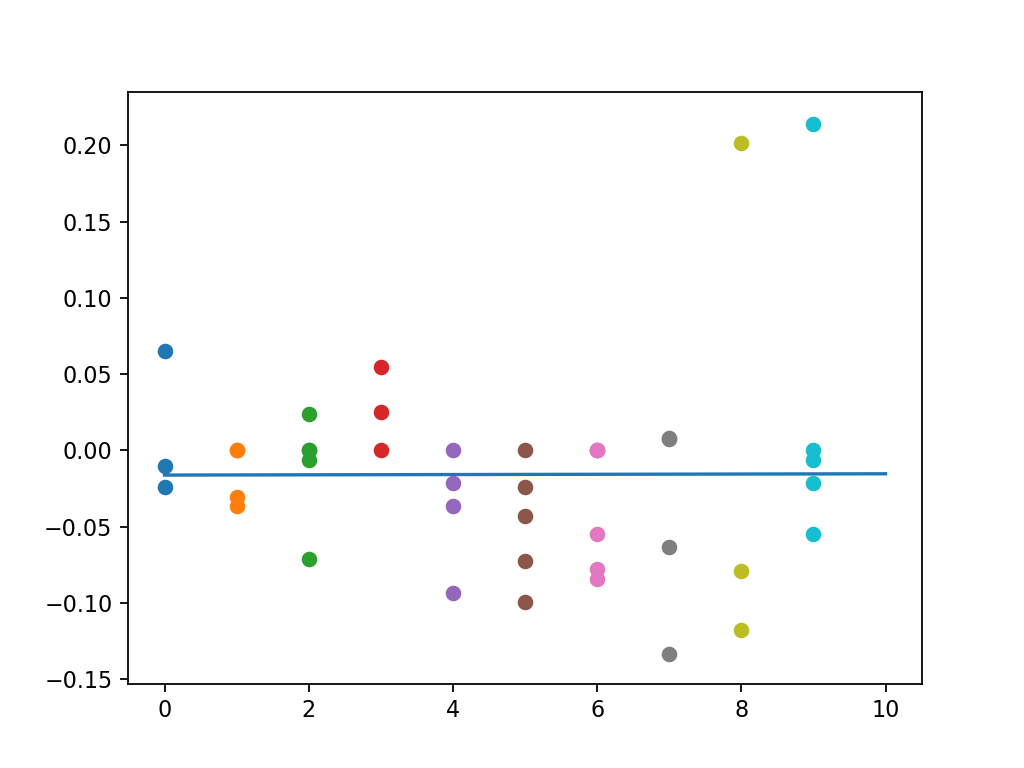

Pearsons r: 0.004
p: 0.9821524360943453


In [354]:
## plot the emergence of selectivity (using just slope)
## for each block

## get the slope for every bird
## Add it to a list (along with the 0 points, similar to before, but a different metric)

## Plot the emergence (or divergence...or neither) of selectivity over time

latency_list = []
duration_list = []
resp_list = []
slope_array = np.empty([n_blocks,n_birds])
slope_array.fill(np.nan)
n_birds = 7
for f in range(n_birds):
    for b in range(n_blocks):
        block_n = binary_array[f,b,:,0]

        
        #block_n = block_n[true_order]

        #mean_response = true_means[f,:]
    
        #mean_response = mean_response[~np.isnan(block_n)]
        #block_n = block_n[~np.isnan(block_n)]
        
        latencies = np.array(data_array[f,b,:,1])
        durations = np.array(data_array[f,b,:,2])
        latencies[data_key[f,b,:,2] == 0] = np.nan
        durations[data_key[f,b,:,2] == 0] = np.nan
        if len(latencies[~np.isnan(latencies)]) > 0 and len(block_n[~np.isnan(block_n)]) > 1:
            responsivity = np.nanmean(block_n)
            mean_latency = np.nanmean(latencies)
            mean_duration = np.nanmean(durations)
            latency_list.append(mean_latency)
            duration_list.append(mean_duration)
            resp_list.append(responsivity)
        latency = np.nanmean(data_array[f,b,:,0])
        if np.nansum(block_n) < 1:
            pass
            #continue
        if len(block_n[~np.isnan(block_n)]) < 3:
            continue
        #print(block_n)
        
        trimmed_block = block_n[~np.isnan(block_n)]
        
        trimmed_xs = np.arange(len(block_n))[~np.isnan(block_n)]
        slope,_ = np.polyfit(trimmed_xs,trimmed_block,1)
        #print(slope)

        slope_array[b,f] = slope

fig,ax = plt.subplots()

xpoint_list = []
ypoint_list = []
ypoints_byblock = []

for n in range(10):
    #ax.scatter([n]*n_birds,slope_array[n,:])
    good_points = slope_array[n,:][~np.isnan(slope_array[n,:])]
    #good_points = np.clip(good_points,-.1,.1)
    #print(good_points)
    good_xs = [n] * len(good_points)
    ypoint_list.extend(good_points)
    xpoint_list.extend(good_xs)
    #print(n,good_points)
    ypoints_byblock.append(good_points)
    ax.scatter(good_xs,good_points)
#print(ypoints_byblock)
corr,p_value = pearsonr(xpoint_list,ypoint_list)

slope,intercept = np.polyfit(xpoint_list,ypoint_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(fit_line(np.arange(n_blocks)))
#ax.boxplot(ypoints_byblock,positions=np.arange(len(ypoints_byblock)))
#print(slope,intercept)
#ax.set_ylim([-0.1,0.1])
fig.show()
print('Pearsons r: %.3f' % corr)
print('p:',p_value)

#fig.savefig('/home/ammon/Desktop/ToCompy/true_selectivity_by_block.svg')

<IPython.core.display.Javascript object>


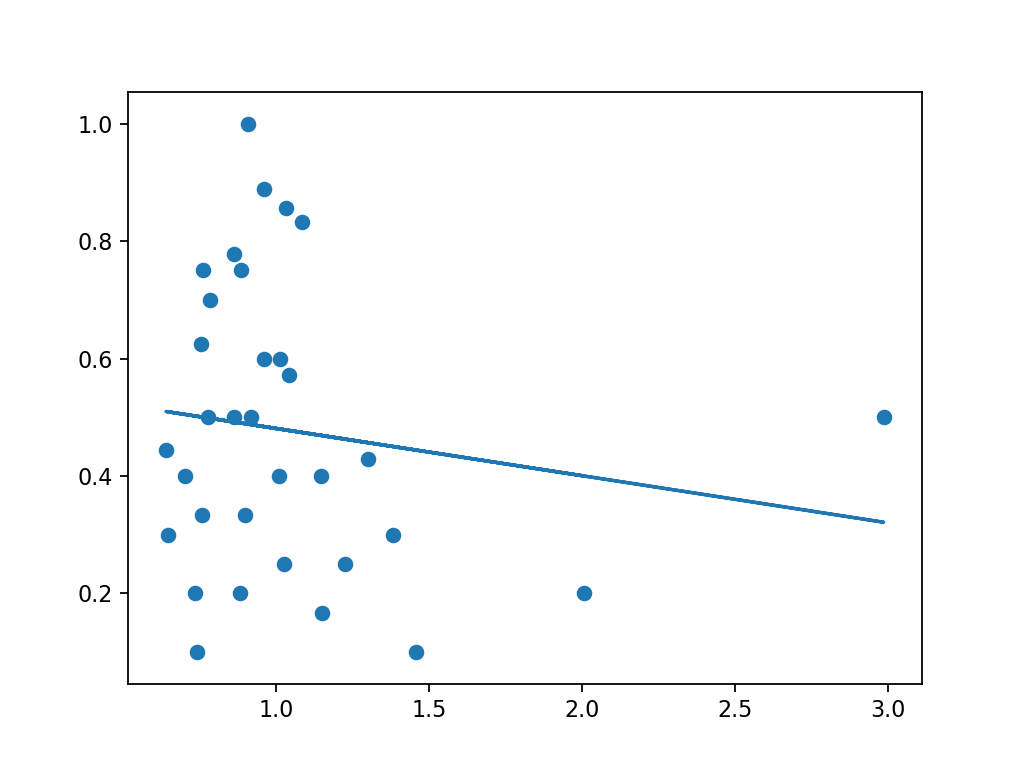

-0.14633066336842834 0.4164582893098038


In [357]:
## Are Latency and responsiveness correlated (by bird by block)

#print(latency_list,resp_list)
#print(len(latency_list),len(resp_list))
fig,ax = plt.subplots()
ax.scatter(latency_list,resp_list)

slope,intercept = np.polyfit(latency_list,resp_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(latency_list,fit_line(latency_list))

corr,p_value = pearsonr(latency_list,resp_list)
print(corr,p_value)
#

<IPython.core.display.Javascript object>


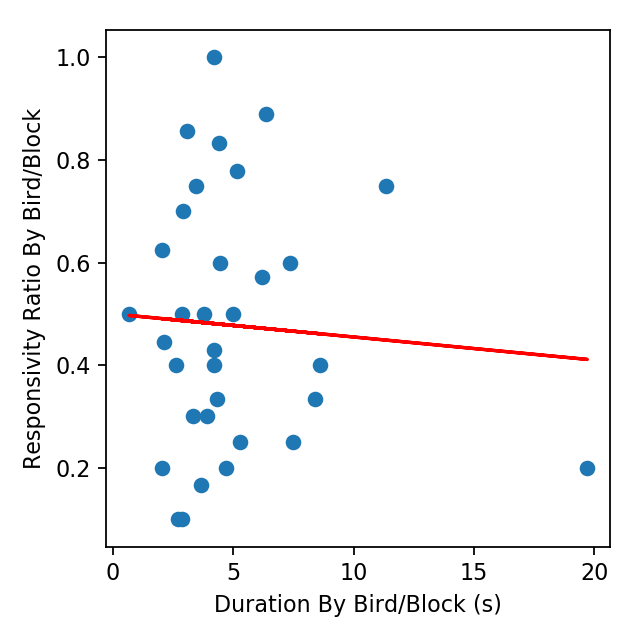

(-0.06365021375697112, 0.7249123501169268)
-0.06365021375697112 0.7249123501169268


In [368]:
## Are duration and responsiveness correlated (by bird by block)

#print(latency_list,resp_list)
#print(len(latency_list),len(resp_list))
fig,ax = plt.subplots()
ax.scatter(duration_list,resp_list)
#ax2.scatter(duration_list,resp_list)

print(pearsonr(duration_list,resp_list))

for f in range(7):
    pass
    #ax.scatter(bird_block_durations[f],bird_block_responses[f])

xs = [0] * 11
ys = [0] * 11

"""
for b in range(11):
    ax.scatter(block_bird_durations[b],block_bird_responses[b])
    ax2.scatter(np.nanmean(block_bird_durations[b]),np.nanmean(block_bird_responses[b]),s=200)
    xs[b] = np.nanmean(block_bird_durations[b])
    ys[b] = np.nanmean(block_bird_responses[b])
#ax2.scatter(bird_means[:,2],bird_means[:,0],s=200)
#ax2.scatter(block_means[:,2],block_means[:,0],s=200,alpha=.7) 

"""
slope,intercept = np.polyfit(duration_list,resp_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(duration_list,fit_line(duration_list),color='red')

ax.set_xlabel('Duration By Bird/Block (s)')
ax.set_ylabel('Responsivity Ratio By Bird/Block')

corr,p_value = pearsonr(duration_list,resp_list)

print(corr,p_value)

#print(pearsonr(bird_means[:,2][~np.isnan(bird_means[:,2])],bird_means[:,0][~np.isnan(bird_means[:,2])]))
#print(pearsonr(block_means[:,2],block_means[:,0]))
#

fig.set_size_inches(4,4)
fig.tight_layout()
fig.show()

(121,) (121,)


<IPython.core.display.Javascript object>


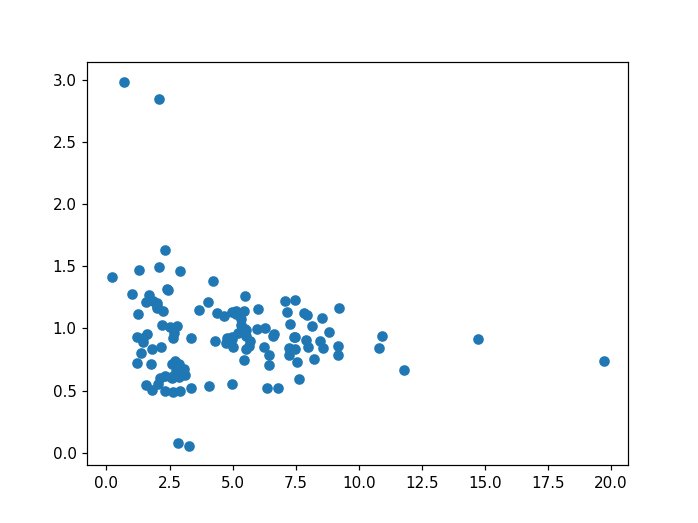

(-0.1382278677876835, 0.13053597374565487)


In [228]:
# Are duration and latency correlated (by posture)

print(np.shape(good_durations),np.shape(good_latencies))

fig,ax = plt.subplots()

ax.scatter(good_durations,good_latencies)
print(pearsonr(good_durations,good_latencies))

[0 2 8 1 7 4 5 9 3 6]


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


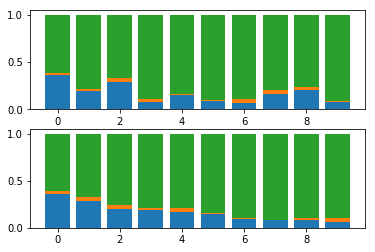

In [70]:
## split apart ranking into postures, partials, and non-postures

mean_partials3 = np.mean(bv3_array[:,:,:,0] == .5,axis=(1,0))
mean_non3 = np.mean(bv3_array[:,:,:,0] == 0,axis=(1,0))
mean_posture3 = np.mean(bv3_array[:,:,:,0] == 1,axis=(1,0))

fig,(ax1,ax2) = plt.subplots(2)

song_order3 = np.argsort(mean_posture3)[::-1]
print(song_order3)


ax1.bar(range(10),mean_posture3)
ax1.bar(range(10),mean_partials3,bottom = mean_posture3)
ax1.bar(range(10),mean_non3,bottom = (mean_posture3 + mean_partials3))

ax2.bar(range(10),mean_posture3[song_order3])
ax2.bar(range(10),mean_partials3[song_order3],bottom = mean_posture3[song_order3])
ax2.bar(range(10),mean_non3[song_order3],bottom = (mean_posture3 + mean_partials3)[song_order3])
fig.show()

      1    13   22   30   47   55   67   79   83   96   101
BK24  1.0  1.0  0.5  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
WH19  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0
WH16  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0
WH24  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0
BK21  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
LB20  1.0  1.0  1.0  0.0  0.5  0.0  0.0  1.0  1.0  0.0  1.0
BK17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
GR13  1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0
WH22  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0
[22.5 16.  23.   8.  16.   9.   4.5 14.5 18.5  9. ]
[52.  24.  38.  10.5 14.5 10.  12.5 22.5 25.   7.5]
[[0.5 1.  0.5 1.  1.  1.  0.  0.  0.  0.  0. ]
 [1.  1.  0.  1.  1.  1.  0.  1.  1.  0.  1. ]
 [1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1. ]
 [1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  0.  0.5 0.  0.  1.  1.  0.  1. ]
 [0.  0.  0.  

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


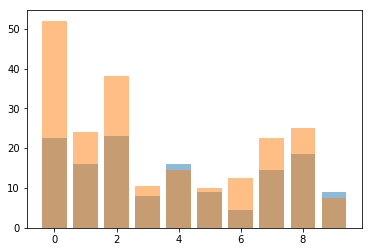

In [25]:
song_name = 'BDY.wav'
print(np.transpose(group2_df.loc[group1_df['SongFile'] == song_name].iloc[:,6:15]))

print(np.sum(bv3_array[:9,:,:,0],axis = (1,0)))
print(np.sum(bv3_array[9:,:,:,0],axis = (1,0)))

print(bv3_array[9:,:,0,0])

print(song_list)

fig, ax = plt.subplots()
ax.bar(range(10),np.sum(bv3_array[:9,:,:,0],axis = (1,0)),alpha=.5)
ax.bar(range(10),np.sum(bv3_array[9:,:,:,0],axis = (1,0)),alpha=.5)

fig.show()

<IPython.core.display.Javascript object>


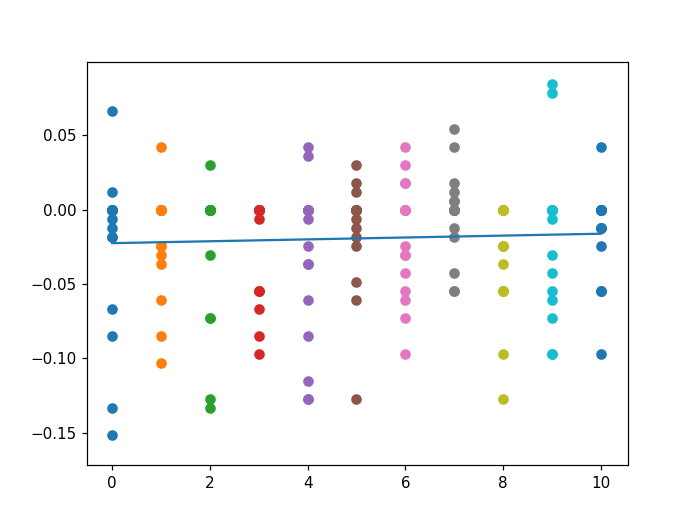

Pearsons r: 0.049
p: 0.4898087954822813


In [385]:
## Plot the emergence (or divergence...or neither) of selectivity over time

n_blocks = 11
n_birds = 18
binary_array3 = np.array(bv3_array)
binary_array3[binary_array3 == .5] = 0



resp_list = []
slope_array = np.empty([n_blocks,n_birds])
slope_array.fill(np.nan)
for f in range(n_birds):
    for b in range(n_blocks):
        block_n = binary_array3[f,b,:,0]
        
        #block_n = block_n[true_order]

        #mean_response = true_means[f,:]
    
        #mean_response = mean_response[~np.isnan(block_n)]
        #block_n = block_n[~np.isnan(block_n)]
        
        responsivity = np.nanmean(block_n)
        resp_list.append(responsivity)

        if np.nansum(block_n) < 1:
            pass
            #continue
        if len(block_n[~np.isnan(block_n)]) < 3:
            continue
        #print(block_n)
        
        trimmed_block = block_n[~np.isnan(block_n)]
        
        trimmed_xs = np.arange(len(block_n))[~np.isnan(block_n)]
        slope,_ = np.polyfit(trimmed_xs,trimmed_block,1)
        #print(slope)

        slope_array[b,f] = slope

fig,ax = plt.subplots()

xpoint_list = []
ypoint_list = []
ypoints_byblock = []

for n in range(11):
    #ax.scatter([n]*n_birds,slope_array[n,:])
    good_points = slope_array[n,:][~np.isnan(slope_array[n,:])]
    #good_points = np.clip(good_points,-.1,.1)
    #print(good_points)
    good_xs = [n] * len(good_points)
    ypoint_list.extend(good_points)
    xpoint_list.extend(good_xs)
    #print(n,good_points)
    ypoints_byblock.append(good_points)
    ax.scatter(good_xs,good_points)
#print(ypoints_byblock)
corr,p_value = pearsonr(xpoint_list,ypoint_list)

slope,intercept = np.polyfit(xpoint_list,ypoint_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(fit_line(np.arange(n_blocks)))
#ax.boxplot(ypoints_byblock,positions=np.arange(len(ypoints_byblock)),notch=True,bootstrap=5000)
#print(slope,intercept)
#ax.set_ylim([-0.1,0.1])
fig.show()
print('Pearsons r: %.3f' % corr)
print('p:',p_value)


#fig.savefig('/home/ammon/Desktop/ToCompy/true_selectivity_by_block.svg')

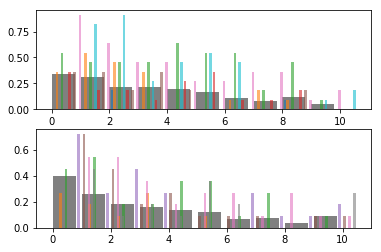

In [510]:
## finally Look at lesions vs non-lesions
lesions1,lesions2 = ([1,2,3,7,8],[9,11,13,15,17])
non_lesions1,non_lesions2 = ([0,3,5,6],[10,12,14,16])

lesions = [1,2,4,7,8,9,11,13,15,17]
non_lesions = [0,3,5,6,10,12,14,16]

fig,(ax1,ax2) = plt.subplots(2)


ax1.bar(np.arange(n_songs) + .4,np.nanmean(sorted_means[lesions],axis=0),color='gray')
ax2.bar(np.arange(n_songs) + .4,np.nanmean(sorted_means[non_lesions],axis=0),color='gray')

for n in range(n_birds):
    #print(np.shape(canon_means),np.shape(bird_list))
    #ax.bar(np.arange(n_songs) + n * .8/n_birds,canon_means[n],width=.8/n_birds, label=bird_list3[n],alpha=.6)
    if n in lesions:
        ax1.bar(np.arange(n_songs) + n * .8/9,sorted_means[n],width=.8/9,alpha=.6)
    elif n in non_lesions:
        ax2.bar(np.arange(n_songs) + n * .8/9,sorted_means[n],width=.8/9,alpha=.6)

In [20]:
## Make a PCA out of response data for seq with postures. Easy peasy. 
good_list = sorted(os.listdir('./SeqClasses/'))
crap_list = sorted(os.listdir('./CrapSeqs/'))


#file_list = sorted(os.listdir('./SeqClasses/'))
file_lists = [good_list,crap_list]
dir_list = ['./SeqClasses/','./CrapSeqs/']
for f in range(1):
    file_list = file_lists[f]
    seq_dir = dir_list[f]
    for s in range(len(file_list)):

        seq_file = file_list[s]
        seq = pickle.load(open(seq_dir + seq_file,'rb'))

        if seq.offset == 0:
            continue

        if s == 0:
            seq_distances,_ = seq.define_distances()
            all_distances = seq_distances[seq.response_range,:]
            seq_points = np.reshape(seq.smooth_data,[len(seq.smooth_data),60])
        else:
            seq_distances,_ = seq.define_distances()
            all_distances = np.vstack([all_distances,seq_distances[seq.response_range]])
            seq_points = np.vstack([seq_points,np.reshape(seq.smooth_data,[len(seq.smooth_data),60])])

print(np.shape(all_distances))
print(np.shape(seq_points))

(78317, 190)
(350946, 60)


In [736]:
print(np.shape(np.reshape(seq.smooth_data,[len(seq.smooth_data),60])))
print(np.shape(seq_distances))

(937, 60)
(937, 190)


In [22]:
import math

def calc_row_idx(k, n):
    return int(math.ceil((1/2.) * (- (-8*k + 4 *n**2 -4*n - 7)**0.5 + 2*n -1) - 1))

def elem_in_i_rows(i, n):
    return i * (n - 1 - i) + (i*(i + 1))/2

def calc_col_idx(k, i, n):
    return int(n - elem_in_i_rows(i + 1, n) + k)

def condensed_to_square(k, n):
    i = calc_row_idx(k, n)
    j = calc_col_idx(k, i, n)
    return i, j

condensed_to_square(135,20)

(9, 10)

[0.44 0.18 0.17 0.12 0.03 0.02 0.01 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]


<IPython.core.display.Javascript object>


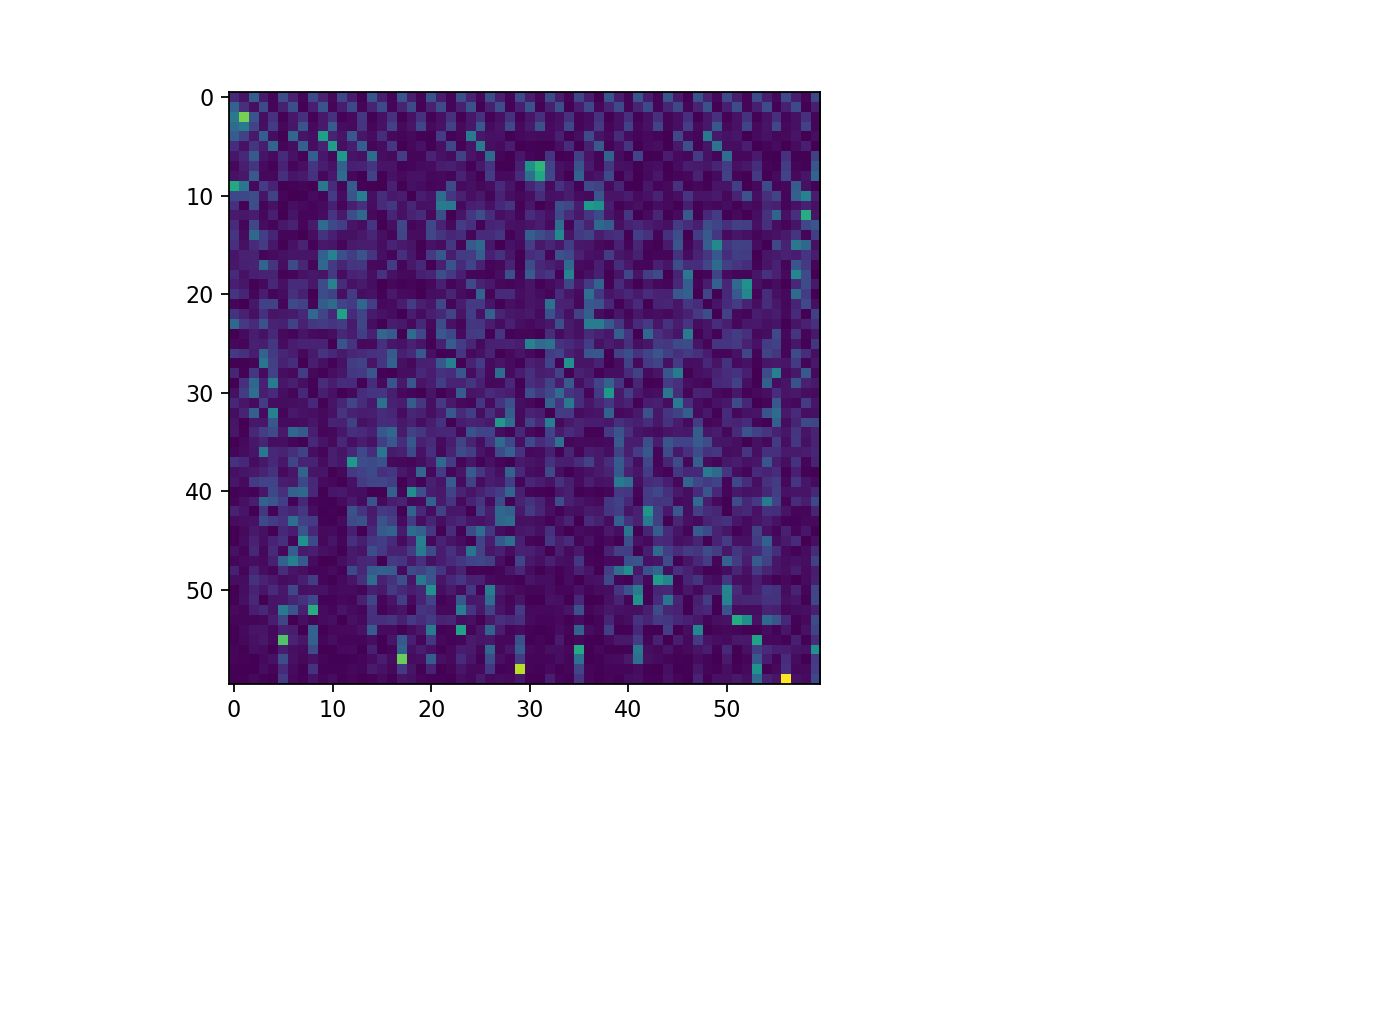

In [25]:
## Perform PCA on the points themselves. This is fine, but the first 3 are just the avg xyz :/
# Definitely needs to be normalized
from sklearn.decomposition import PCA
pca_points = PCA()
pca_points.fit(seq_points)

print(np.round(pca_points.explained_variance_ratio_,2))
fig,ax = plt.subplots()
ax.imshow(np.abs(pca_points.components_))

fig.show()

In [533]:
count = 0

p_array_components = np.empty([len(file_list),190])
p_array_components.fill(np.nan)
for s in range(len(file_list)):
    seq_file = file_list[s]
    #print(seq_dir,seq_file)
    seq = pickle.load(open(seq_dir + seq_file,'rb'))
    if seq.offset != 0 and seq.posture == 1:
        count += 1
        seq_distances,_ = seq.define_distances()
        reduced_path = pca.transform(seq_distances)

        baseline = reduced_path[(seq.ts < 0) & (seq.ts > -2)]
        csd_window = reduced_path[(seq.ts > 0) & (seq.ts < seq.t_refraction)]        
        
        for c in range(190):

            t,p = ttest_ind(baseline[:,c],csd_window[:,c])
            ax.scatter(c,np.log(1/p))
            p_array_components[count,c] = np.log(1/p)

            if p < .05:
                #print(c,p)
                pass
        if count > 50:
            pass
            
print(count)
good_stuff = p_array_components[~np.isnan(p_array_components[:,0])]
average_values = np.mean(good_stuff,0) / np.max(np.mean(good_stuff,0))

#print(seq.offset,seq.seq_name,seq.posture)

146


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


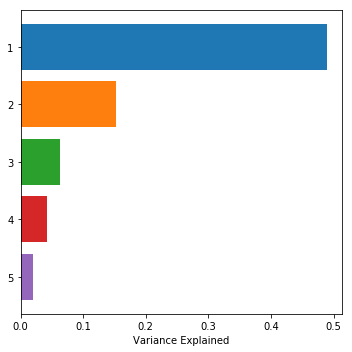

In [768]:
## Run the PCA, plot the relative explained variance and significance (baseline vs response)
%matplotlib inline

from sklearn.decomposition import PCA
from matplotlib import cm

viridis = cm.get_cmap('viridis', 50)

pca = PCA()

pca.fit(all_distances)

#print(np.round(pca.explained_variance_ratio_,2))
#print(np.max(normed_sig))
#print(normed_sig[1],normed_colors[1])

fig,ax = plt.subplots()
#ax.imshow(np.abs(pca.components_[:3]),aspect='auto')
#ax.pie(pca.explained_variance_ratio_,startangle=90,counterclock=False)
#fig.set_size_inches(3,3)

#normed_sig = p_array_components / np.max(p_array_components)
#normed_sig = np.clip(normed_sig,0,.7)
normed_colors = viridis(average_values)

alpha = np.log(190/.05) / np.max(np.mean(good_stuff,0))

floored_values = np.array(average_values)
#floored_values[floored_values < alpha] = 0
normed_colors = viridis(floored_values)



k = np.log(190/.05) / np.max(np.mean(good_stuff,0))
r = k
"""
ax.pie(pca.explained_variance_ratio_,startangle=90,counterclock=False,colors=normed_colors)
ax.pie(pca.explained_variance_ratio_, colors=[[0,0,0]] * len(average_values),  
        startangle=90, counterclock=False, explode=average_values * .5,
        radius = .1)
"""
#circle1 = plt.Circle((0, 0), .1 + r, color='r',fill=False)
#ax.add_artist(circle1)

#ax2.imshow(np.abs(pca.components_[:7]),aspect='auto')

#ax.hist(normed_sig)
#ax.axvline(np.log(190/.05) / np.max(p_array_components),color='red')

bar_colors = [color_cycle[4-i] for i in range(5)]
ax.barh(range(5),pca.explained_variance_ratio_[:5][::-1],color=bar_colors)
ax.set_yticklabels(np.arange(1,7)[::-1])
ax.set_xlabel('Variance Explained')


fig.set_size_inches(5,5)
fig.tight_layout()
fig.show()
fig.savefig('/home/ammon/Desktop/PaperFigs/4a.png')
fig.savefig('/home/ammon/Desktop/PaperFigs/4a.svg')

In [757]:
print(condensed_to_square(19,20))
print(np.unravel_index(20,[20,20]))

(1, 2)
(1, 0)


In [758]:
### All 190 sig means that every distance changes significantly. Duh
### Top 10 being important means that all the movement isn't perfectly correlated
from itertools import combinations

# I could plot this as the connection with the width as the weight, make it slightly transparent. 
# That would emphasize where the components are focusing. 
# But the size is going to depend not only on importance but initial distance
# Do really trust this I would need to normalize them by their average distance...Ugh. 
# But I'll I'm doing here is getting intuition. Does this work for that? 
# Not necessarily. Size and importance aren't equivalent. However since all the distances are on average 
# ...quite similar, and also the beak distances would be the longest, so those being biggest means extra.

points_dict = {
    0:'Beak',
    1:'Keel',
    2:'Tailbone',
    3:'Tail Tip',
    4:'Left Eye',
    5:'Left Shoulder',
    6:'Left Elbow',
    7:'Left Wrist',
    8:'Left Wing Tip',
    9:'Left Knee',
    10:'Left Ankle',
    11:'Left Heel',
    12:'Right Eye',
    13:'Right Shoulder',
    14:'Right Elbow',
    15:'Right Wirst',
    16:'Right Wing Tip',
    17:'Right Knee',
    18:'Right Ankle',
    19:'Right Heel'
}

import math

## Nabbed from stack exchange

def calc_row_idx(k, n):
    return int(math.ceil((1/2.) * (- (-8*k + 4 *n**2 -4*n - 7)**0.5 + 2*n -1) - 1))

def elem_in_i_rows(i, n):
    return i * (n - 1 - i) + (i*(i + 1))/2

def calc_col_idx(k, i, n):
    return int(n - elem_in_i_rows(i + 1, n) + k)

def condensed_to_square(k, n):
    i = calc_row_idx(k, n)
    j = calc_col_idx(k, i, n)
    return int(i), int(j)

for n in range(5):
    print('***component:',n)
    top_20 = np.argsort(pca.components_[n])[::-1][:20]
    indices = np.unravel_index(top_20,[20,20])
    more_indices = np.empty([20,2])
    for i in range(len(top_20)):
        more_indices[i] = condensed_to_square(top_20[i],20)
        #print(more_indices[i],np.unravel_index(top_20[i],[20,20]))
    list_test = list(zip(indices[0],indices[1]))
    list_2 = list(zip(more_indices[:,0],more_indices[:,1]))
    for p in range(len(list_test)):
        pair = list_test[p]
        pair2 = list_2[p]
        #print(points_dict[pair[0]],'->',points_dict[pair[1]])
        print(points_dict[pair2[0]],'->',points_dict[pair2[1]])
    print('\n')

***component: 0
Beak -> Tail Tip
Beak -> Left Wing Tip
Beak -> Right Wing Tip
Beak -> Tailbone
Tail Tip -> Left Eye
Tail Tip -> Right Eye
Beak -> Right Heel
Beak -> Left Heel
Beak -> Right Ankle
Beak -> Left Ankle
Tail Tip -> Right Wirst
Keel -> Tail Tip
Tail Tip -> Right Shoulder
Tail Tip -> Left Wrist
Left Eye -> Left Wing Tip
Tail Tip -> Left Shoulder
Left Wing Tip -> Right Eye
Right Eye -> Right Wing Tip
Left Eye -> Right Wing Tip
Beak -> Left Knee


***component: 1
Beak -> Left Eye
Beak -> Right Eye
Beak -> Left Shoulder
Beak -> Right Shoulder
Beak -> Right Wirst
Beak -> Left Elbow
Beak -> Left Wrist
Beak -> Right Elbow
Beak -> Keel
Beak -> Right Knee
Beak -> Left Knee
Beak -> Right Ankle
Beak -> Left Ankle
Beak -> Left Heel
Beak -> Right Heel
Beak -> Tailbone
Beak -> Left Wing Tip
Beak -> Right Wing Tip
Beak -> Tail Tip
Keel -> Right Wirst


***component: 2
Tail Tip -> Right Heel
Tail Tip -> Left Heel
Right Wing Tip -> Right Heel
Tail Tip -> Right Ankle
Tail Tip -> Left Ankle
Lef

(909, 190)
(100, 190)
(441, 190)
t-stat: 10.108769146669248 p= 4.086547506478213e-22


<IPython.core.display.Javascript object>


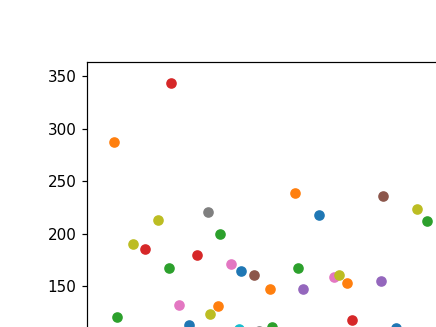

In [64]:
print(np.shape(seq_distances))
baseline = reduced_path[(seq.ts < 0) & (seq.ts > -2)]
csd_window = reduced_path[(seq.ts > 0) & (seq.ts < seq.t_refraction)]
print(np.shape(baseline))
print(np.shape(csd_window))

t,p = ttest_ind(baseline[:,0],csd_window[:,0])
print('t-stat:',t,'p=',p)

fig,ax = plt.subplots()
"""
for n in range(10):
    ax.plot(baseline[:,n],color='blue',alpha=1-n*.1)
    ax.plot(np.arange(len(csd_window)) + len(baseline),csd_window[:,n],color='orange',alpha=1-n*.1)
"""    
p_array_components = np.empty(190)
for c in range(190):
    t,p = ttest_ind(baseline[:,c],csd_window[:,c])
    ax.scatter(c,np.log(1/p))
    p_array_components[c] = np.log(1/p)
    
    if p < .05:
        #print(c,p)
        pass


(946, 190)
(946, 190)
(947,)
2019-07-15-11-42-46_WG
0
birdview-2


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


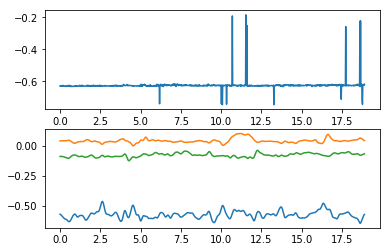

In [532]:
#principalComponents = pca.transform(all_distances)
print(np.shape(seq_distances))

seq_distances,_ = seq.define_distances()

reduced_path = pca.transform(seq_distances)
print(np.shape(reduced_path))
print(np.shape(seq.ts))

fig,(ax1,ax2) = plt.subplots(2)
ax2.plot(seq.ts[:-1],reduced_path[:,0]) 
ax2.plot(seq.ts[:-1],reduced_path[:,1])
ax2.plot(seq.ts[:-1],reduced_path[:,2])
ax1.plot(seq.ts[:-1],seq.rough_data[:,3,2] * 10 - 3)
#ax.axvline(np.argmin(seq.ts >= 0))

print(seq.seq_name)
print(seq.offset)
print(seq.machine)


fig.show()

breaking at 118


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


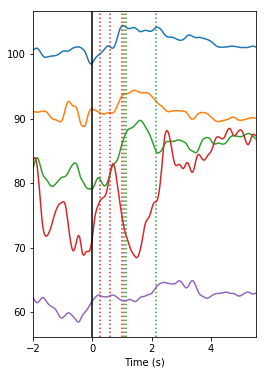

In [771]:
### Read through all the postures
from scipy.ndimage.filters import gaussian_filter1d

%matplotlib inline

#fig,(ax1,ax2) = plt.subplots(2)
fig,ax2 = plt.subplots()
count = 0
break_point = 118

n_comp = 5

transitions = np.zeros([n_comp * 3 + 2,n_comp * 3 + 2])
all_time_points = np.empty((break_point+1,n_comp,3))
all_time_points.fill(np.nan)
for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    if seq.offset == 0 or seq.posture != 1:
        continue
    if 'floor' in seq.notes:
        continue

    ## If it's a posture, grab it, stop at a good one

    ## convert into PCA space
    seq_distances,_ = seq.define_distances()
    reduced_path = pca.transform(seq_distances)
    smooth_path = gaussian_filter1d(reduced_path,10,0)

    ## Get mean, std of baseline
    reduced_baseline = reduced_path[seq.t_baseline_index[0][0]:seq.tzero_index[0][0]]
    reduced_means = np.mean(reduced_baseline,0)
    reduced_std = np.std(reduced_baseline,0)

    z_signs = np.ones(190)
    z_path = (reduced_path - reduced_means) / reduced_std

    for c in range(190):
        z_signs[c] = np.sign(z_path[seq.response_range,c][np.abs(z_path[seq.response_range,c]) == np.max(np.abs(z_path[seq.response_range,c]))])


    z_path = z_path * z_signs
    z_smooth = gaussian_filter1d(z_path,10,0)
    """
    ax.plot(seq.ts,seq.rough_data[:,3,2],color='red',linestyle=':')
    ax.axvline(0)
    ax.plot(seq.ts,reduced_path[:,0])
    ax.plot(seq.ts,smooth_path[:,0])
    """
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    time_points = np.empty([n_comp,3])
    time_points.fill(np.nan)
    for c in range(n_comp):

        #ax2.plot(seq.ts,z_smooth[:,c] + 100 - c * 10,color=color_cycle[c],linestyle=':')
        z0,zmax,z1 = np.nan,np.nan,np.nan
        ## Get 1st deviation from baseline
        z0_index = np.argmax(np.abs(z_path[seq.response_range,c]) > 7)
        if z0_index != 0:
            z0 = seq.response_ts[z0_index]
            time_points[c,0] = z0
        ## Get 1st aproximation of peak (must be beyond baseline)
        zmax_index = np.argmax((z_path[seq.response_range,c] > 7) & (z_path[seq.response_range,c] >= np.max(z_path[seq.response_range,c]) - 2)) 
        if zmax_index != 0:
            zmax = seq.response_ts[zmax_index]
            time_points[c,1] = zmax
        # Get 1st return to baseline
            z1_index = np.argmax((z_path[seq.response_range,c] <5) & (seq.response_ts >= zmax))
            if z1_index != 0:
                z1 = seq.response_ts[z1_index]
                time_points[c,2] = z1

        if count == break_point:
            ax2.plot(seq.ts,z_path[:,c] + 100 - c * 10)
            ax2.axvline(z0,linestyle=':',color=color_cycle[c])
            ax2.axvline(zmax,linestyle=':',color=color_cycle[c])
            ax2.axvline(z1,linestyle=':',color=color_cycle[c])

    all_time_points[count] = time_points
    time_vector = np.reshape(time_points,[n_comp * 3])
    #print(time_vector)
    sorted_vector = np.argsort(time_vector)
    sorted_vector = sorted_vector[~np.isnan(time_vector[sorted_vector])]
    #print(np.round(time_vector,2),sorted_vector)
    
    if len(sorted_vector) > 0:
        a = sorted_vector[0] + 1
        transitions[0,a] += 1
        for p in range(len(sorted_vector) - 1):
            a = sorted_vector[p]
            b = sorted_vector[p+1]
            if np.isnan(time_vector[a]) or np.isnan(time_vector[b]):
                continue
            elif time_vector[a] == time_vector[b]:
                #print('this does not count')
                continue
            else:
                transitions[a+1,b+1] += 1  
        
        #z = sorted_vector[~np.isnan(time_vector[sorted_vector])][-1]:
        z = sorted_vector[-1]
        transitions[z+1,-1] += 1
    if count == break_point:
        print('breaking at',count)
        break
    count += 1

#print(transitions)
ax2.axvline(0,color='black')
ax2.set_xlim([-2,seq.duration])
ax2.set_xlabel('Time (s)')
#ax.set_xlim([-2,seq.duration])

#ax1.imshow(transitions)
fig.set_size_inches(4,6)
fig.show()
## Replot with z scores
## For the top 6 or so, grab start, peak, stop (this could be iffy)
## Plot each component, offset so you can see them all together
## Order everything to see the order

## -> I could be doing the PCA by just the height...Does that make sense? It's certainly worth a try...
## It's probably worth a try.

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


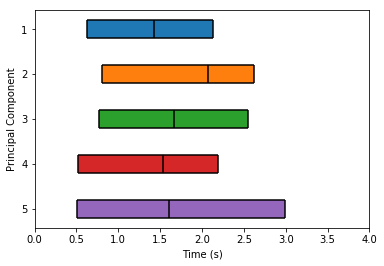

In [772]:
median_times = np.nanmedian(all_time_points,0)

fig,ax = plt.subplots()

for i in range(n_comp):
    n = n_comp - i - 1
    ax.vlines(median_times[n],n-.2,n+.2)
    ax.hlines([n-.2,n+.2],median_times[n,0],median_times[n,2])
    ax.fill_between([median_times[n,0],median_times[n,2]],n+.2,n-.2)
    
ax.set_yticklabels(np.arange(1,n_comp+2)[::-1])
ax.set_ylabel('Principal Component')
#ax.set_yticklabels(np.arange(n_comp)[::-1])
ax.set_xlabel('Time (s)')
ax.set_xlim([0,4])
fig.show()

[ 0  1  4 13  7 16 10 14  5  2 17  8 11 15  6  9 12  3 18 19]
[115. 114. 115. 108. 110. 108.  96.  92.  85.  71.  64.  56.  37.  35.
  23.  16.   9.   3.   0.   0.]
[ 0  1  4 13  7 16 10 14  5  2 17  8 11 15  6  9 12  3 18 19] [ 1  4 13  7 16 10 14  5  2 17  8 11 15  6  9 12  3 18]


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


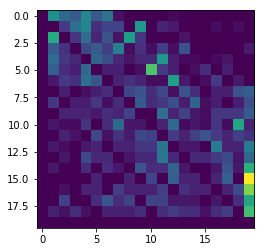

In [712]:
fig,ax = plt.subplots()

med_order = np.argsort(np.reshape(np.nanmedian(all_time_points,0),[n_comp * 3]))
med_order = np.hstack([0,med_order + 1,n_comp * 3 + 1])
print(med_order)
"""max_transitions = np.argmax(transitions,axis=0)
print(max_transitions)"""

print(row_sums)
row_sums = np.nansum(transitions,axis=1)
normed_transitions = transitions / row_sums[:,np.newaxis]


reordered_transitions = np.zeros_like(normed_transitions)

reordered_transitions[0] = normed_transitions[0,med_order]
print(med_order,med_order[1:-1])
for n in range(1,len(med_order)-1):
    i = med_order[n]
    reordered_transitions[n] = normed_transitions[i,med_order]
#normed_transitions = np.norm(transitions,axis=1)
#ax.imshow(normed_transitions[med_order,med_order])
ax.imshow(reordered_transitions)
fig.show()

running: 2019-05-23-11-06-05_2M
running: 2019-05-29-17-07-51_BDY
running: 2019-05-30-07-07-56_GRG
running: 2019-05-30-08-34-17_BOD
running: 2019-05-30-10-02-55_BDY
running: 2019-05-30-11-32-53_LNR
running: 2019-05-30-13-04-19_ND
running: 2019-05-30-15-33-06_2M
running: 2019-05-30-17-09-37_LB
running: 2019-05-30-18-36-04_DMG
running: 2019-05-31-07-05-58_GRG
running: 2019-05-31-10-06-46_WG
running: 2019-05-31-11-33-45_GRG
running: 2019-05-31-13-02-51_ND
running: 2019-05-31-17-02-53_BDY
running: 2019-06-02-10-03-52_2M
running: 2019-06-03-10-03-27_LB
running: 2019-06-04-07-03-23_WG
running: 2019-06-04-10-04-03_2M
running: 2019-06-04-11-33-03_LB
running: 2019-06-04-13-05-42_WG
running: 2019-06-04-15-32-56_LNR
running: 2019-06-04-18-42-42_ND
running: 2019-06-05-07-02-51_BDY
running: 2019-06-06-07-03-02_BDY
running: 2019-06-06-10-03-31_LB


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


skipping 2019-06-09-13-16-11_BDY : no timing data
skipping 2019-06-10-07-16-13_ND : no timing data
running: 2019-06-10-08-29-51_WG
skipping 2019-06-10-08-46-13_2M : no timing data
skipping 2019-06-10-11-46-12_ND : no timing data
running: 2019-06-11-07-02-55_2M
running: 2019-06-11-08-33-22_WG
running: 2019-06-11-10-05-01_BDY
skipping 2019-06-11-11-46-11_ND : no timing data
running: 2019-06-11-13-02-53_GRG
running: 2019-06-11-17-12-41_2M
skipping 2019-06-12-11-46-13_LNR : no timing data
skipping 2019-06-12-13-16-14_BDY : no timing data
skipping 2019-06-13-07-16-15_BDY : no timing data
running: 2019-06-13-08-42-47_GRG
running: 2019-06-13-15-32-53_LB
running: 2019-06-13-18-39-57_BDY
skipping 2019-06-14-15-46-14_BDY : no timing data
running: 2019-06-15-10-02-54_LNR
running: 2019-06-15-13-03-41_BOD
running: 2019-06-15-17-09-07_DMG
skipping 2019-06-17-17-16-13_BDY : no timing data
skipping 2019-06-17-18-46-14_LNR : no timing data
running: 2019-06-18-07-03-28_LNR
skipping 2019-06-18-07-16-14_N

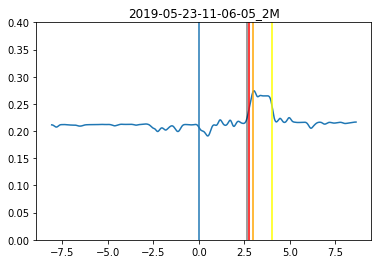

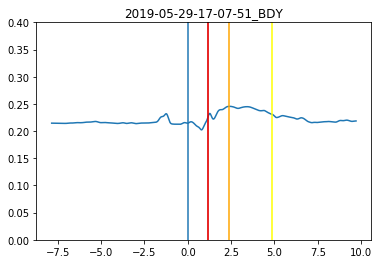

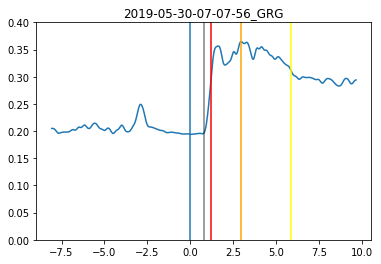

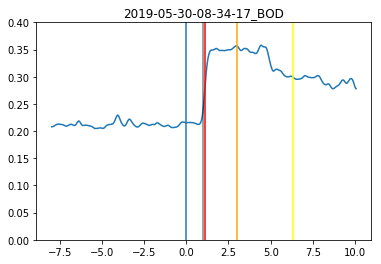

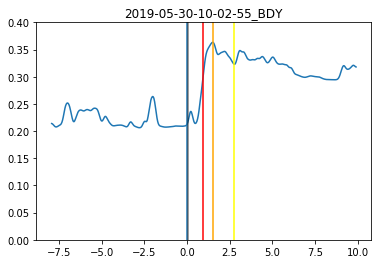

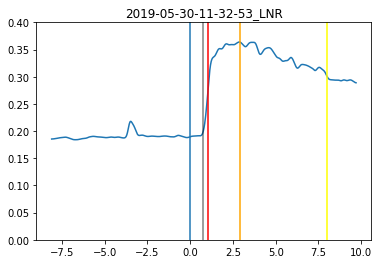

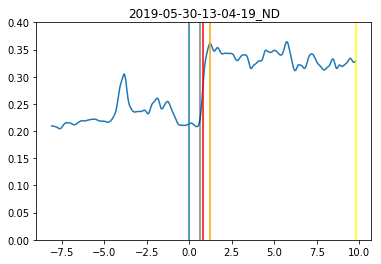

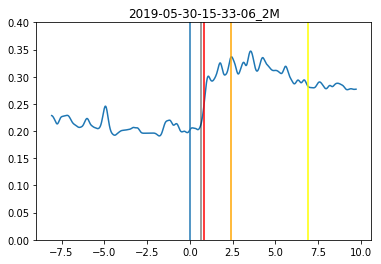

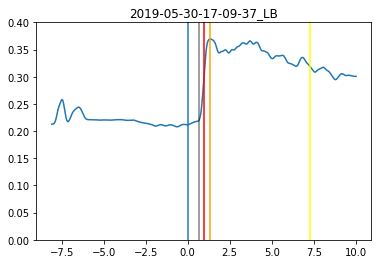

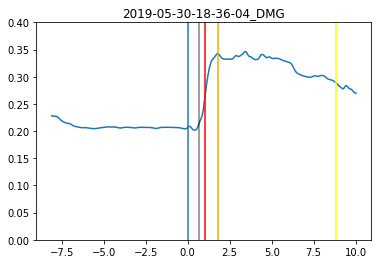

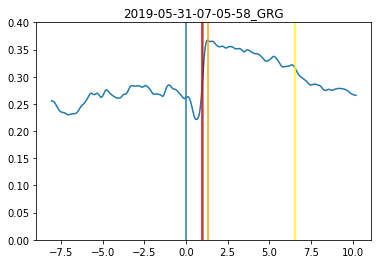

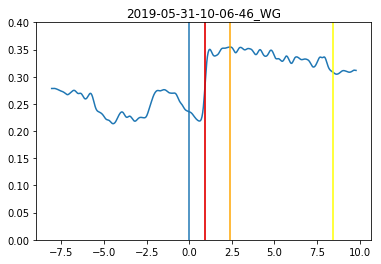

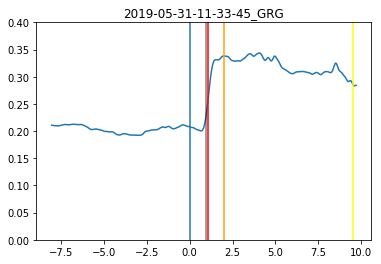

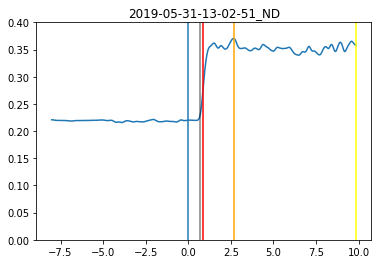

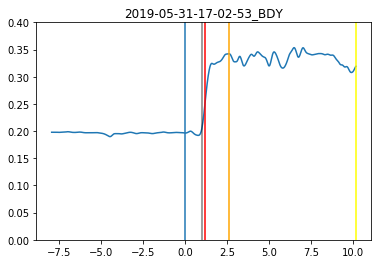

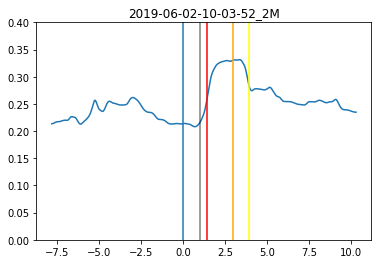

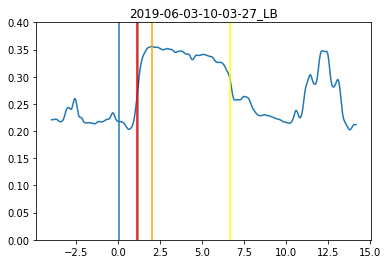

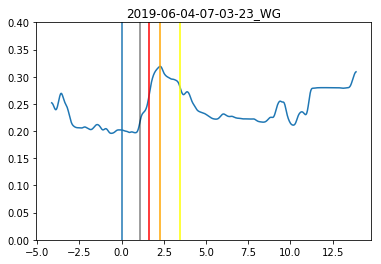

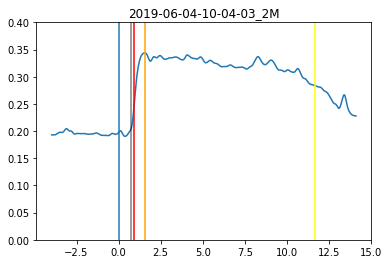

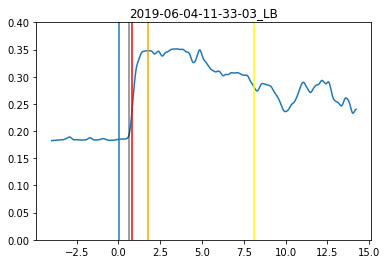

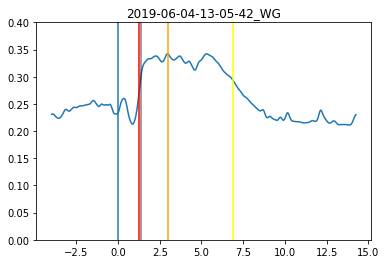

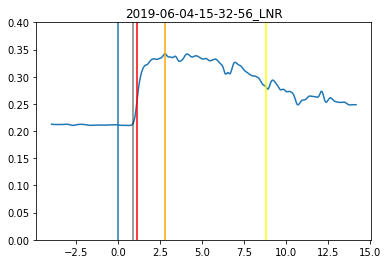

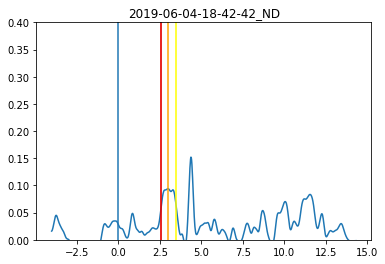

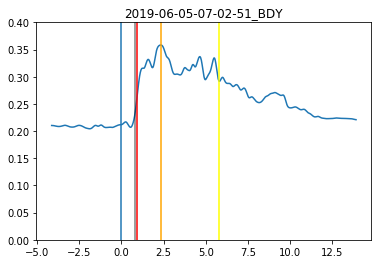

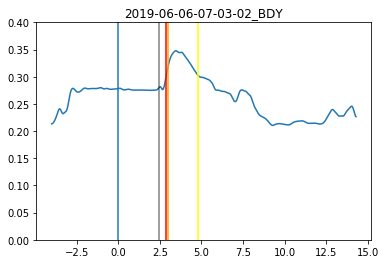

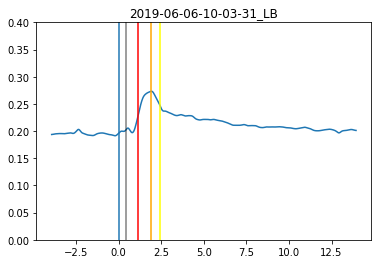

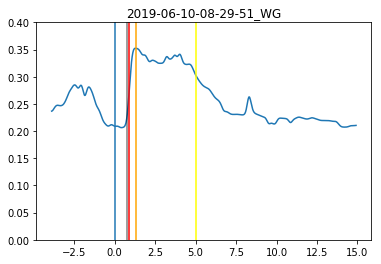

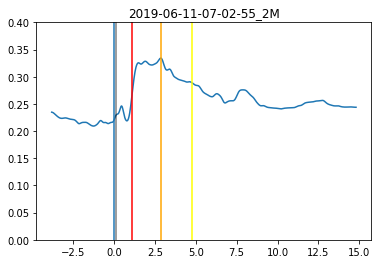

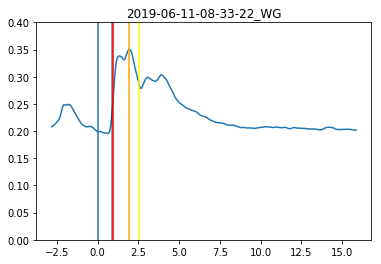

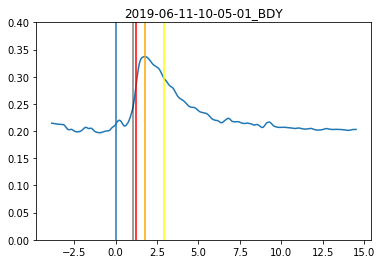

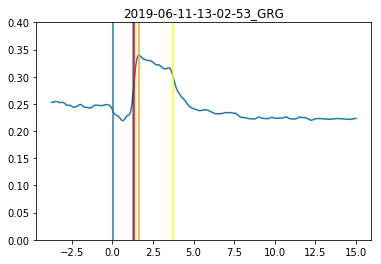

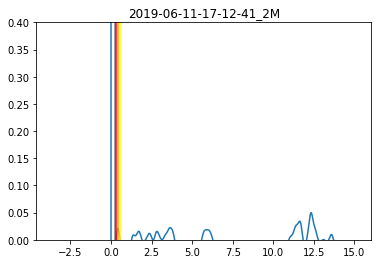

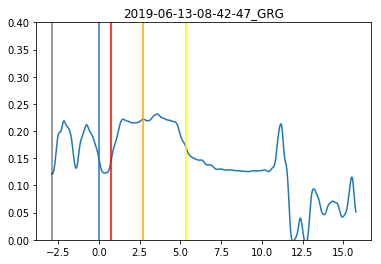

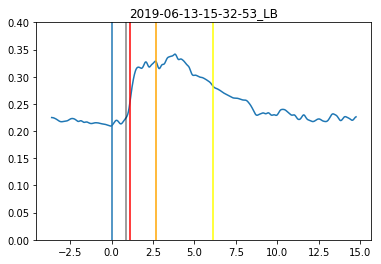

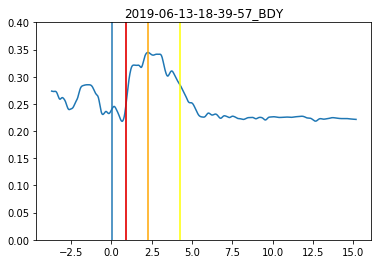

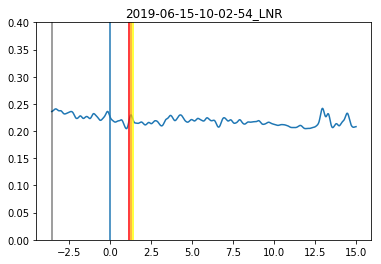

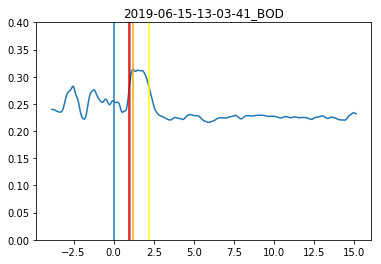

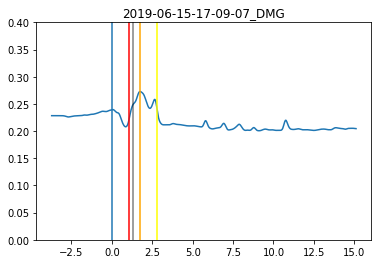

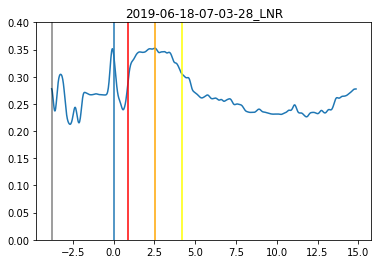

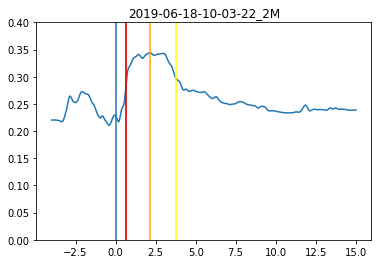

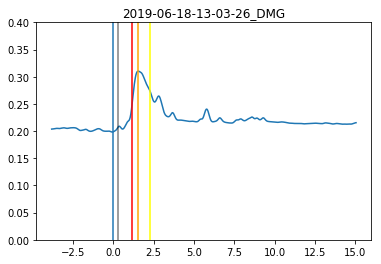

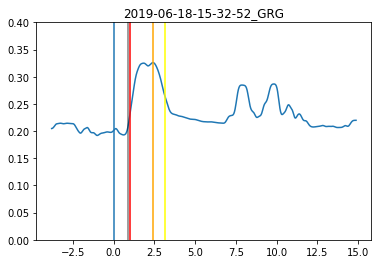

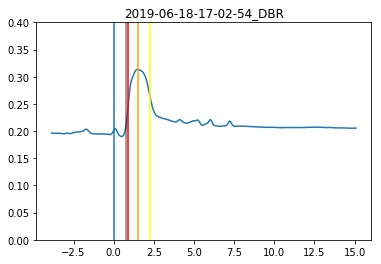

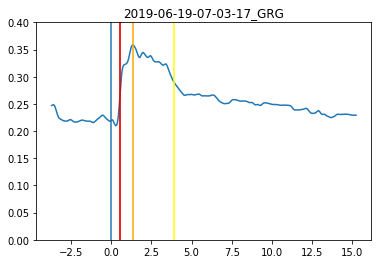

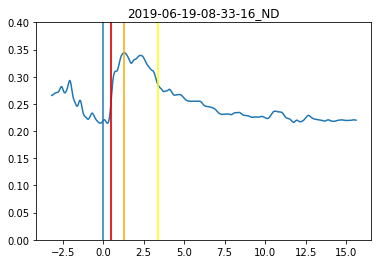

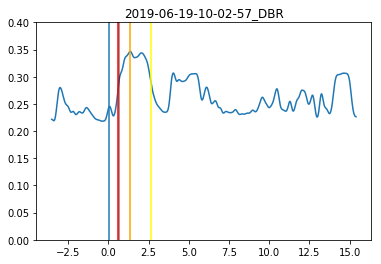

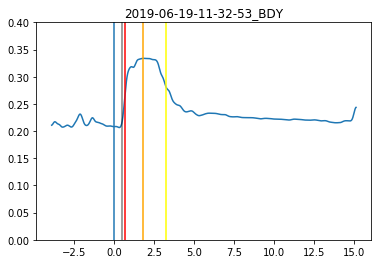

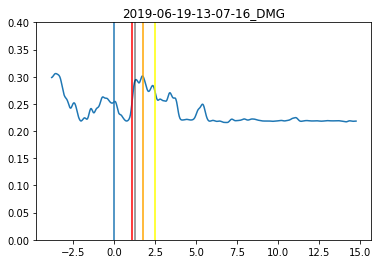

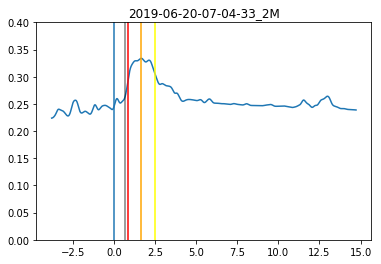

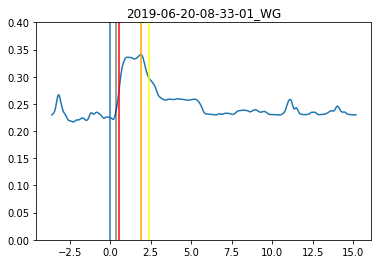

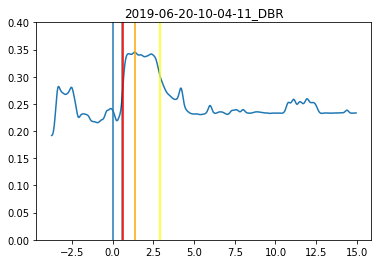

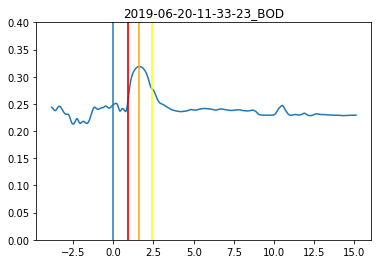

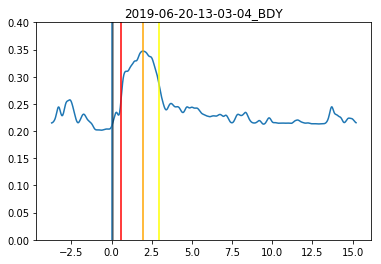

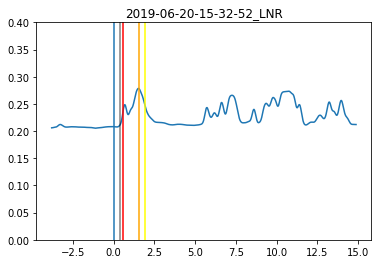

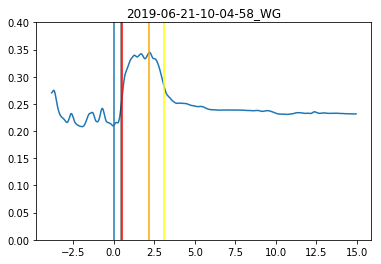

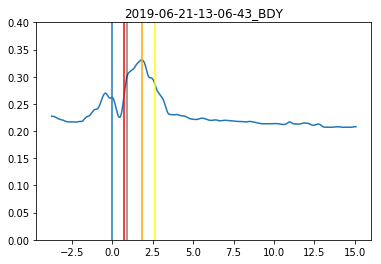

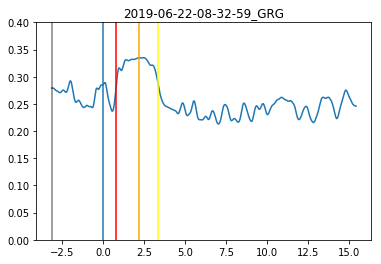

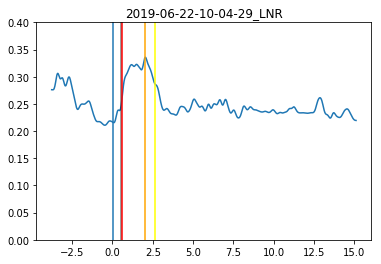

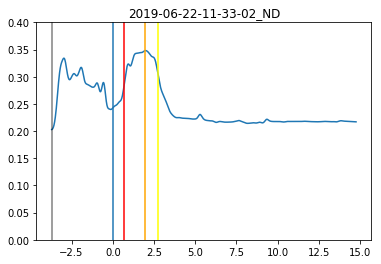

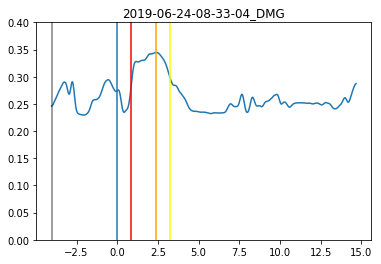

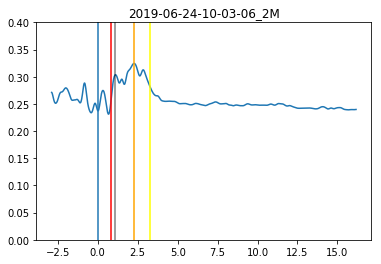

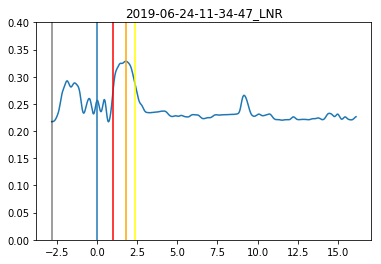

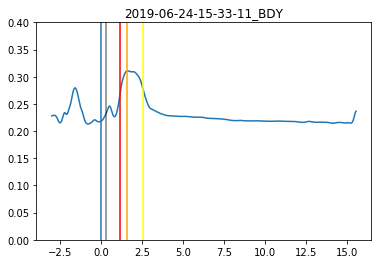

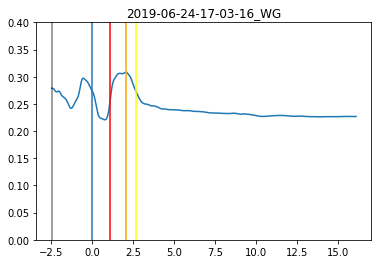

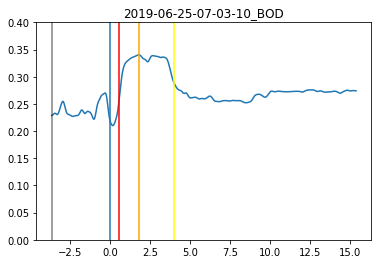

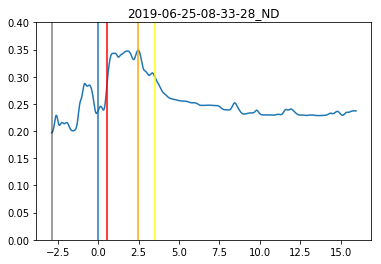

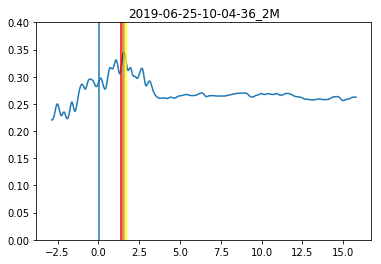

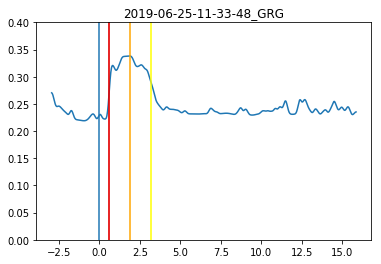

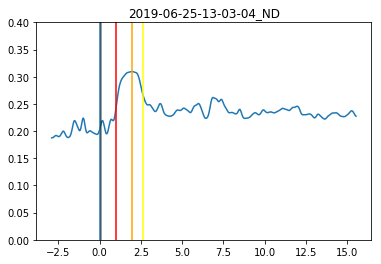

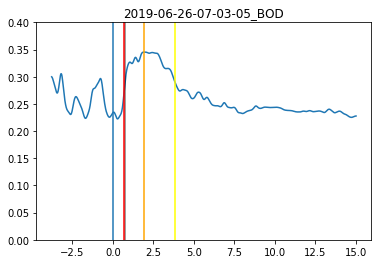

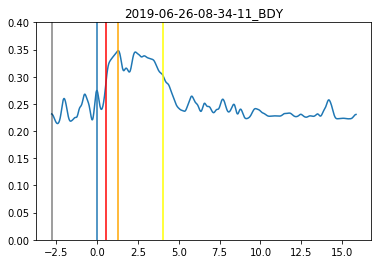

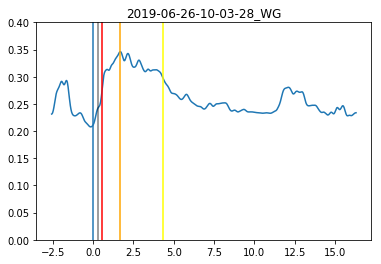

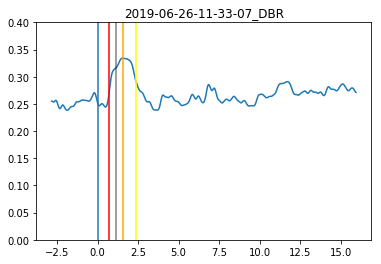

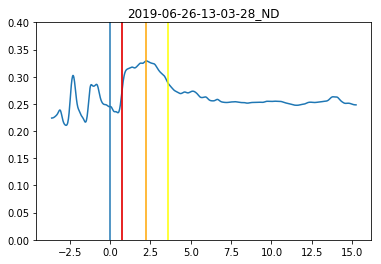

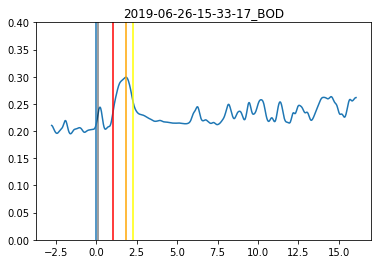

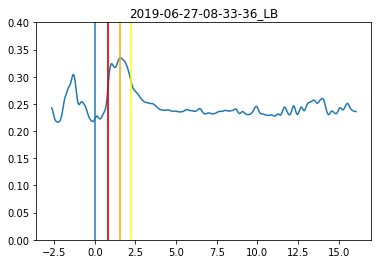

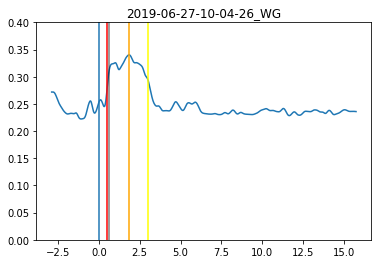

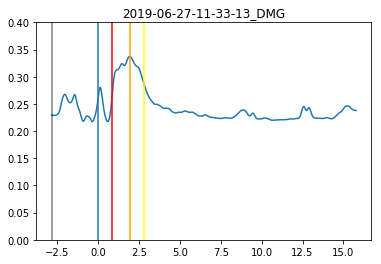

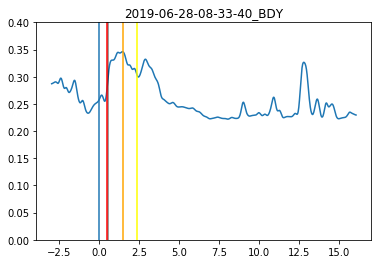

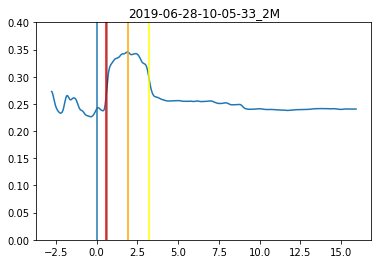

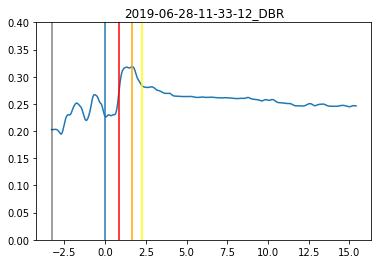

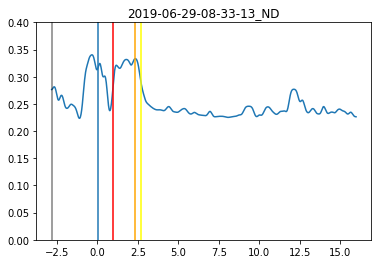

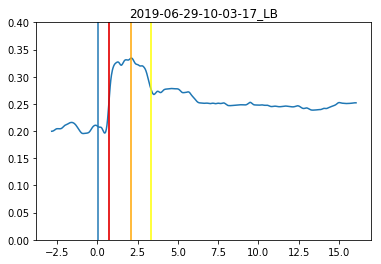

In [137]:
import numpy as np
import os
from matplotlib import pyplot as plt
from pose_class import Trajectory
import pickle

for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))

    if seq.offset != 0:
        print('running:',seq.seq_name)

        fig,ax = plt.subplots()

        ax.plot(seq.ts,seq.data[:,3,2])
        ax.axvline(seq.tzero)
        ax.axvline(seq.t_latency,color='black',alpha=.5)
        ax.axvline(seq.t_vmax,color='r')
        ax.axvline(seq.t_refraction,color='yellow')
        ax.axvline(seq.t_peak,color='orange')
        #ax.axvline(seq.t_stable_vel,color='black')

        ax.set_ylim([0,.4])
        ax.set_title(seq.seq_name)
        fig.savefig('./figures/posture_plots/' + seq.seq_name + '.png')
    else:
        print('skipping',seq.seq_name,': no timing data')


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


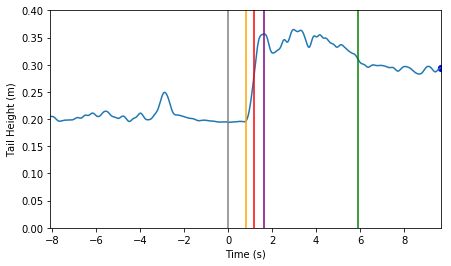

In [395]:
## Make a plot images
#end_t = len(seq.smooth_data)

fig,ax = plt.subplots()
ax.set_xlim([seq.ts[0],seq.ts[-1]])
ax.set_ylim([0,.4])

t = 889

ax.plot(seq.ts[0:t],seq.smooth_data[0:t,3,2])
ax.scatter(seq.ts[t],seq.smooth_data[t,3,2],s=40,color='blue')
## Plot lines
if t > seq.tzero_index[0]:
    ax.axvline(seq.tzero,color='gray')
    if t > seq.t_latency_index:
        ax.axvline(seq.t_latency,color='orange')
        if t > seq.vmax_index[0]:
            ax.axvline(seq.t_vmax,color='red')
            if t > seq.stable_vel_index:
                ax.axvline(seq.t_stable_vel,color='purple')
                if t > seq.refraction_index[0]:
                    ax.axvline(seq.t_refraction,color='green')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Tail Height (m)')
ax.set_xlim([seq.ts[0],seq.ts[-1]])
ax.set_ylim([0,.4])

fig.set_size_inches(7,4)
fig.savefig('./tmp/' + 'final_t.png',dpi=300)

fig.show()

In [266]:
test = np.array([1,2,3,4,5])
print(test)
print(np.hstack([test,test*-1]))

[1 2 3 4 5]
[ 1  2  3  4  5 -1 -2 -3 -4 -5]


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


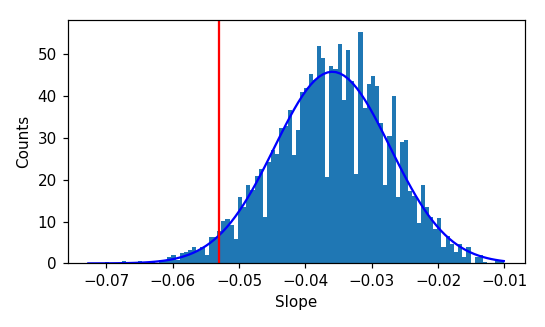

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [487]:
params = CSD_Params()
params.n_blocks = 1
params.n_birds = 18
params.plot_me = True
params.sort_me = True

p,z,(mu,sig,out_params) = csd_sim(params = params)
fig,ax = out_params.fig,out_params.ax

fig.set_size_inches(5,3)

ax.set_xlabel('Slope')
ax.set_ylabel('Counts')
fig.tight_layout()
fig.savefig('/home/ammon/Desktop/PaperFigs/3b.svg')
fig.savefig('/home/ammon/Desktop/PaperFigs/3b.png')


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


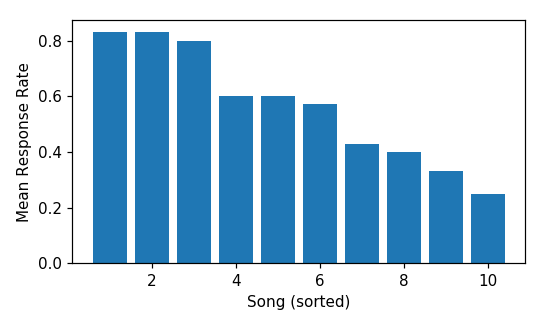

[0.83333333 0.83333333 0.6        0.8        0.6        0.57142857
 0.42857143 0.4        0.25       0.33333333]


In [495]:
fig,ax = plt.subplots()



#bars = np.mean(bv3_array[:,:,:,0] == 1,axis = (0,1))
bars = sorted_means[5]
print(sorted_means[5])
ax.bar(range(1,11),sorted(bars)[::-1])

ax.set_ylabel('Mean Response Rate')
ax.set_xlabel('Song (sorted)')

fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig('/home/ammon/Desktop/PaperFigs/3a.png')
fig.savefig('/home/ammon/Desktop/PaperFigs/3a.svg')

fig.show()

In [530]:
## Calculate which birds are selective
mean_posture_bybird = np.mean(bv3_array[:,:,:,0] == 1,axis=(1))

responsivity_by_bird = np.mean(mean_posture_bybird,1)
print(responsivity_by_bird)

for b in range(18):
    sorted_means_b = np.sort(mean_posture_bybird[b])[::-1]
    #slope,intercept = np.polyfit(range(10), mean_posture_bybird[b],1)
    slope,intercept = np.polyfit(range(10),sorted_means_b,1)
    r_resp = responsivity_by_bird[b]
    params = CSD_Params(sort_me=True)
    p,z,_ = csd_sim(slope,r_resp,params=params)

    if p < .1:
        print('*')
    if p < .002:
        print('****')
    print(slope,r_resp)
    print(p,z)

[0.         0.02727273 0.20909091 0.09090909 0.43636364 0.25454545
 0.         0.18181818 0.         0.16363636 0.23636364 0.4
 0.20909091 0.         0.27272727 0.         0.16363636 0.37272727]
0.0 0.0
0.3750878226973865 0.31840776966156586
-0.013774104683195593 0.02727272727272727
0.3593751195929442 -0.360129571930948
*
-0.065564738292011 0.20909090909090908
0.0028346941163711393 -2.766314194846686
-0.03415977961432506 0.09090909090909091
0.12836146942728616 -1.1341707309732978
-0.049586776859504106 0.43636363636363634
0.4313857649667499 -0.17284720661095404
*
-0.05730027548209363 0.2545454545454545
0.060811886725776726 -1.547993865607253
0.0 0.0
0.3759441858854125 0.3161503757275175
-0.03856749311294764 0.18181818181818182
0.40145581579635464 -0.24958069212657427
0.0 0.0
0.3749607380553871 0.31874290585515147
*
-0.04958677685950411 0.16363636363636364
0.04838302584857539 -1.6607381307637281
*
-0.06831955922865013 0.2363636363636364
0.0029111158185562394 -2.7576285463922545
*
-0.0727

Actual responsivity: 0.5644378363805477
-0.006060606060606045
(18, 11, 10, 3)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


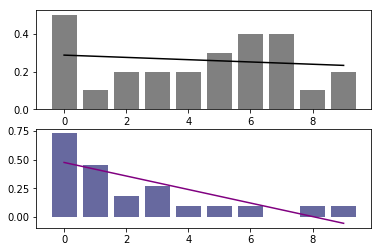

In [942]:
## Generate lots of slopes
import random
from scipy.stats import norm

print('Actual responsivity:',np.mean(block_means[:10,0]))


mean_posture3 = np.mean(bv3_array[:,:,:,0] == 1,axis=(1,0))


iterations = 10000
birds = 10
model_birds = False
blocks = 10
songs = 10
responsiveness = .30



slopes = np.empty(iterations)
slopes0 = np.empty(iterations)

for i in range(iterations):
    postures = np.zeros([blocks,songs])
    for b in range(blocks):
        for s in range(songs):
            if random.random() <= responsiveness:
                postures[b,s] = 1

    counts = np.sum(postures,0)

    
    sorted_counts = counts
    sorted_counts = np.sort(counts)[::-1]
    
    ratios = counts / blocks
    
    sorted_ratios = sorted_counts / blocks
    
    slope0,intercept0 = np.polyfit(range(len(ratios)),ratios,1)
    slope,intercept = np.polyfit(range(len(sorted_ratios)), sorted_ratios,1)
    
    fit_line0 = np.poly1d([slope0,intercept0])
    fit_line = np.poly1d([slope,intercept])
    #fit_line = np.poly1d(np.polyfit(range(len(sorted_ratios)), sorted_ratios, 1))

    #slope, intercept = fit_line
    slopes0[i] = slope0
    slopes[i] = slope
    
fig,(ax,ax2) = plt.subplots(2)

ax.bar(range(10),ratios,color='gray')
ax.plot(np.arange(10),fit_line0(np.arange(10)),color='black')
print(slope0)
print(np.shape(binary_array3))

demo_slopes = np.nanmean(binary_array3[5+7,:,:,0],axis=(0))
fit_line1 = np.poly1d(np.polyfit(range(10),demo_slopes[song_order],1))
ax2.bar(np.arange(10),demo_slopes[song_order],color=color_map(5/25),alpha=.8)
ax2.plot(np.arange(10),fit_line1(np.arange(10)),color='purple')
fig.show()

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


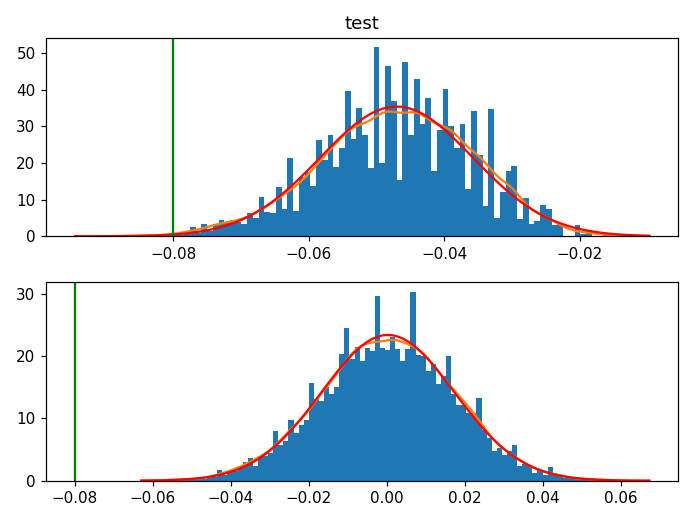

z score: -2.922587611509604
0.00347135944713233
z score: -4.70673961783492
2.51710078771551e-06


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [278]:
## Do some stats

from scipy.stats import norm

fig,(ax,ax2) = plt.subplots(2)
ax.hist(slopes,bins=100,normed=True)

#ax.set_yscale('log')



fit_kde = gaussian_kde(slopes)
mu,sig = (np.mean(slopes),np.std(slopes))

xs = np.linspace(min(slopes),max(slopes),100)

ax.plot(xs,fit_kde(xs))
ax.plot(xs,norm.pdf(xs,mu,sig),color='red')

x = -.08
z = (x - mu) / sig
ax.axvline(x,color='green')
print('z score:',z)

p_value = norm.sf(abs(z))*2 #twosided
print(p_value)

fit_kde0 = gaussian_kde(slopes0)
mu0,sig0 = (np.mean(slopes0),np.std(slopes0))

xs0 = np.linspace(min(slopes0),max(slopes0),100)

ax2.hist(slopes0,bins=100,normed=True)
ax2.plot(xs0,fit_kde0(xs0))
ax2.plot(xs0,norm.pdf(xs0,mu0,sig0),color='red')

z0 = (x - mu0) / sig0
ax2.axvline(x,color='green')
print('z score:',z0)

p_value0 = norm.sf(abs(z0))*2 #twosided
print(p_value0)

ax.set_title('test')
fig.tight_layout()
fig.show()



In [262]:
print('Actual responsivity:',np.mean(block_means[:10,0]))

print(np.shape(bv3_array))
mean_posture_bybird = np.mean(bv3_array[:,:,:,0] == 1,axis=(1))

for b in range(18):
    slope,intercept = np.polyfit(range(10), mean_posture_bybird[b],1)
    z = (slope - mu0) / sig0
    p = norm.sf(abs(z))*2
    print('Bird:',b,'slope=',slope)
    print('z-score:',z,'p-value=',p)


Actual responsivity: 0.5644378363805477
(18, 11, 10, 3)
Bird: 0 slope= 0.0
z-score: 0.0025465088889240354 p-value= 0.997968182069538
Bird: 1 slope= 0.012672176308539946
z-score: 0.7369628655697043 p-value= 0.46114493202700846
Bird: 2 slope= -0.030303030303030287
z-score: -1.753666517956419 p-value= 0.07948766587560953
Bird: 3 slope= -0.028650137741046824
z-score: -1.6578730801284915 p-value= 0.09734308674352263
Bird: 4 slope= -0.0011019283746556408
z-score: -0.06131578299636081 p-value= 0.9511077214389023
Bird: 5 slope= -0.035261707988980706
z-score: -2.0410468314402026 p-value= 0.04124617240721859
Bird: 6 slope= 0.0
z-score: 0.0025465088889240354 p-value= 0.997968182069538
Bird: 7 slope= -0.006611570247933875
z-score: -0.3806272424227868 p-value= 0.7034798637499572
Bird: 8 slope= 0.0
z-score: 0.0025465088889240354 p-value= 0.997968182069538
Bird: 9 slope= -0.023140495867768576
z-score: -1.3385616207020647 p-value= 0.18071342737275498
Bird: 10 slope= -0.03195592286501376
z-score: -1.84

In [36]:
peak  = seq.peak_height
half_peak = peak - (peak - seq.baseline) / 2
refraction_range = seq.data[:,3,2][seq.ts > seq.t_peak]
print(half_peak)

refraction_point = np.argmax(refraction_range < half_peak)
refraction_point == 0

AttributeError: 'Trajectory' object has no attribute 'peak_height'

In [21]:
seq_trajectory = pca.transform(seq.all_distances)

<IPython.core.display.Javascript object>


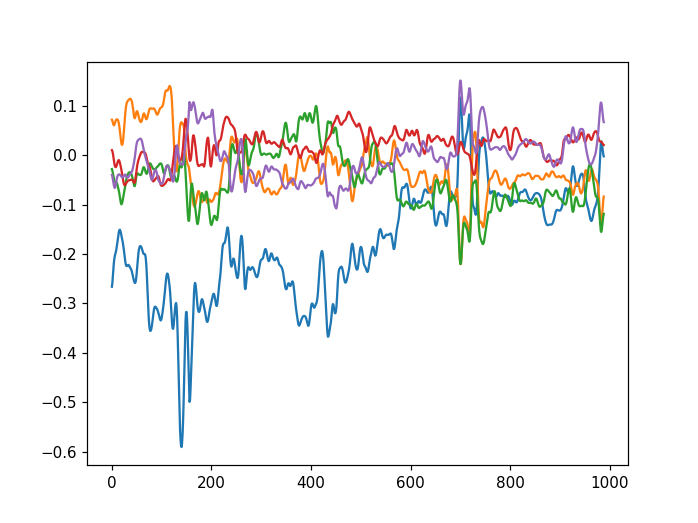

In [22]:
%matplotlib notebook



fig, ax = plt.subplots()

ax.plot(seq_trajectory[:,:5])


fig.show()

<IPython.core.display.Javascript object>


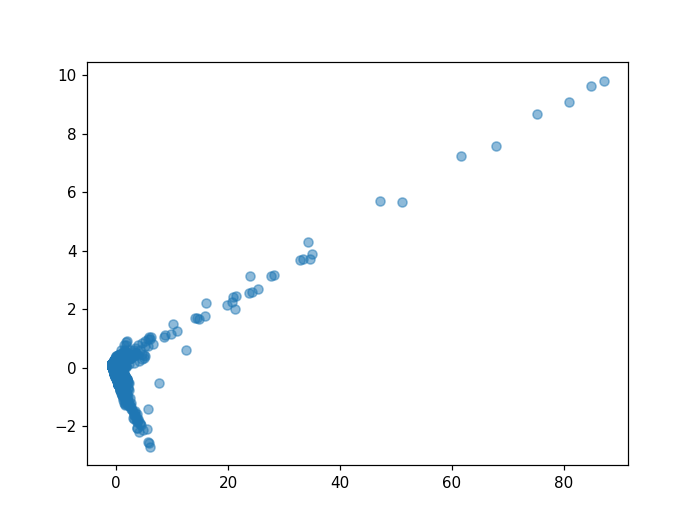

In [26]:
fig,ax = plt.subplots()

ax.scatter(principalComponents[:,0],principalComponents[:,1], alpha=.5)

fig.show()

In [2]:
from pose_class import Trajectory

/home/ammon/Documents/Scripts/AnalyzePosture/pose_class.py:53: UserWarning: genfromtxt: Empty input file: "/data/birds/postures/birdview2-2019/2019_timestamps_birdview-2/2019-06-17-17-10-27_BOD.wav.txt"
  bv2TimeDict[seq_name] = np.genfromtxt(bv2TimeDir + '/' + file_name,usecols=[1])
/home/ammon/Documents/Scripts/AnalyzePosture/pose_class.py:53: UserWarning: genfromtxt: Empty input file: "/data/birds/postures/birdview2-2019/2019_timestamps_birdview-2/2019-06-16-11-40-27_WG.wav.txt"
  bv2TimeDict[seq_name] = np.genfromtxt(bv2TimeDir + '/' + file_name,usecols=[1])
/home/ammon/Documents/Scripts/AnalyzePosture/pose_class.py:53: UserWarning: genfromtxt: Empty input file: "/data/birds/postures/birdview2-2019/2019_timestamps_birdview-2/2019-06-16-07-10-26_2M.wav.txt"
  bv2TimeDict[seq_name] = np.genfromtxt(bv2TimeDir + '/' + file_name,usecols=[1])
/home/ammon/Documents/Scripts/AnalyzePosture/pose_class.py:53: UserWarning: genfromtxt: Empty input file: "/data/birds/postures/birdview2-2019/2019

In [4]:
import numpy as np

song_list = np.genfromtxt('./song_list.txt',dtype=str)

array(['BOD', 'BDY', 'LNR', 'ND', '2M', 'LB', 'DMG', 'DRG', 'DBR', 'WG',
       'm2M', 'mBDY', 'mBOD', 'mDBR', 'mDMG', 'mGRG', 'mLB', 'mLNR',
       'mND', 'mWG', 'LB-', 'BDY-'], dtype='<U4')

In [14]:
import pickle, os 
song_list = np.genfromtxt('./song_list.txt',dtype=str)
song_counts = dict(zip(song_list,[0]*len(song_list)))
machine_counts = {'birdview':0,'birdview-2':0}
bird_counts = {}
weird_songs = []

for s in os.listdir('./SeqClasses/'):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    if seq.bird in bird_counts.keys():
        bird_counts[seq.bird] += 1
    else:
        bird_counts[seq.bird] = 1
    if seq.song in song_counts.keys():
        song_counts[seq.song] += 1
    else:
        weird_songs.append(seq.song)
    machine_counts[seq.machine] +=1
    

[11, 27, 12, 18, 17, 11, 11, 0, 9, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [11 27 12 18 17 11 11  0  9 15  0  0  0  0  0  0  0  0  0  0  0  0]]
(2, 22)
[10 19 18 17 16 15 14 13 12 11 21  7 20  8  6  5  0  2  9  4  3  1]
[[ 1  3  4  9  2  0  5  6  8 20  7 21 11 12 13 14 15 16 17 18 19 10]
 [27 18 17 15 12 11 11 11  9  0  0  0  0  0  0  0  0  0  0  0  0  0]]
['BOD' 'BDY' 'LNR' 'ND' '2M' 'LB' 'DMG' 'DRG' 'DBR' 'WG' 'm2M' 'mBDY'
 'mBOD' 'mDBR' 'mDMG' 'mGRG' 'mLB' 'mLNR' 'mND' 'mWG' 'LB-' 'BDY-']


<IPython.core.display.Javascript object>


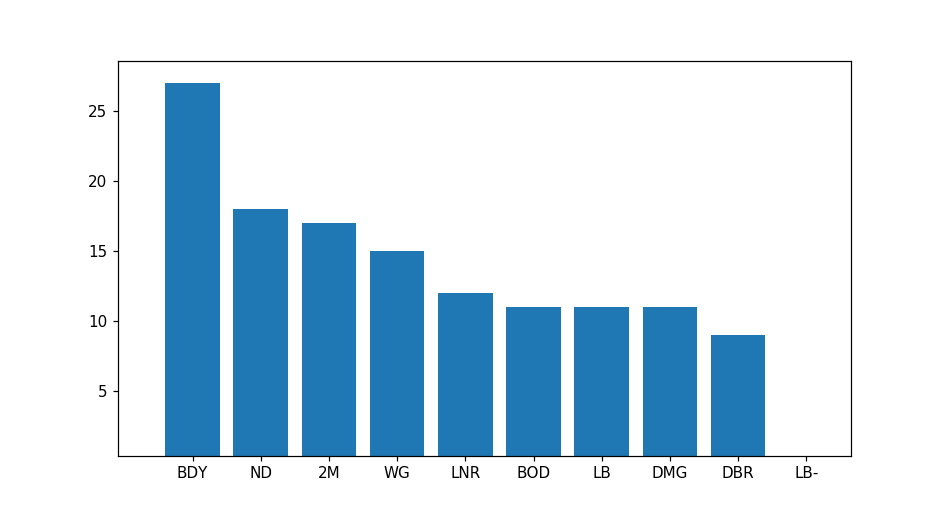

In [45]:
from matplotlib import pyplot as plt

%matplotlib notebook
test0 = list(song_counts.keys())
test1 = list(song_counts.values())
test1 = [int(x) for x in test1]

print(test1)
test_array = np.array([range(len(test1)),test1])
print(test_array)

print(np.shape(test_array))
print(test_array[1,:].argsort())
sorted_array = test_array[:,test_array[1,:].argsort()[::-1]]

print(sorted_array)
print(song_list)

fig,ax = plt.subplots()

ax.bar(range(len(song_list)),sorted_array[1,:])
song_array = np.array(song_list)
ax.set_xticks(range(len(song_list)))
ax.set_xticklabels(song_array[sorted_array[0,:]])
fig.show()

In [47]:
import pickle

postures = [0] * 6
seqs = [0] * 6

postures[0] = './SeqClasses/2019-05-30-10-02-55_BDY.obj'
postures[1] = './SeqClasses/2019-06-15-13-03-41_BOD.obj'
postures[2] = './SeqClasses/2019-06-27-13-16-14_BOD.obj'
postures[3] = './SeqClasses/2019-07-05-13-12-38_LB.obj'
postures[4] = './SeqClasses/2019-06-30-15-46-15_DBR.obj'
postures[5] = './SeqClasses/2019-06-20-07-04-33_2M.obj'

for p in range(6):
    seqs[p] = pickle.load(open(postures[p],'rb'))

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


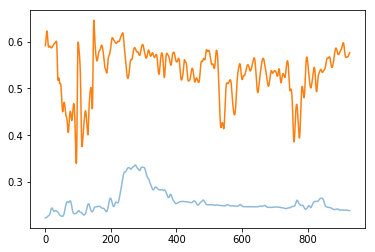

In [64]:
fig, ax = plt.subplots()


ax.plot(seqs[5].data[:,3,2],alpha=.5)
ax.plot(np.abs(seqs[5].all_angles[:,6]) * .01)
fig.show()

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


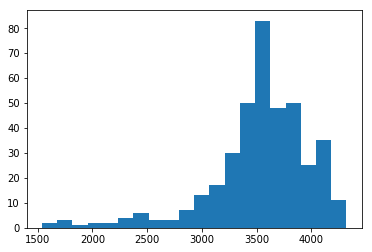

In [23]:
## Plot movement, for fun
movements = data_array[:,:,:,3]
good_movements = movements[~np.isnan(movements)]

fig, ax = plt.subplots()

ax.hist(good_movements,bins=20)

fig.show()

<IPython.core.display.Javascript object>


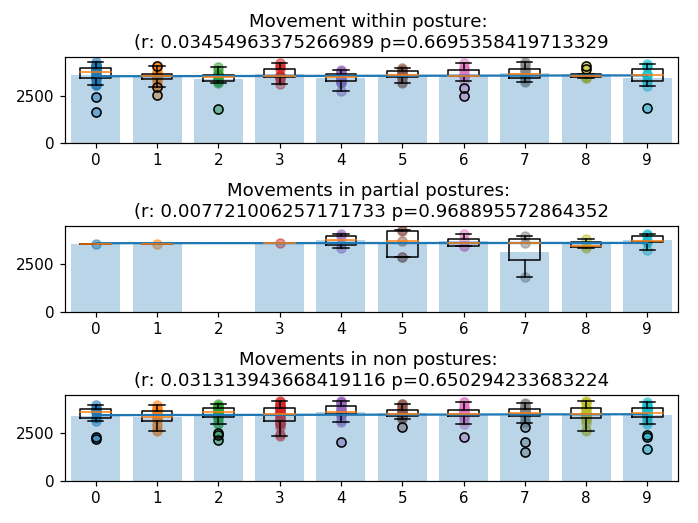

/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['BDY', 'ND', 'LNR', 'BOD', 'WG', '2M', 'GRG', 'LB', 'DBR', 'DMG']


In [24]:
## Show movements within postures, and movements in non postures
%matplotlib notebook
fig,(ax1,ax2,ax0) = plt.subplots(3)


n_songs = len(song_list)

true_order = np.argsort(song_means)[::-1]

song_order = range(n_songs)
song_order = true_order

posture_movements = [data_array[:,:,n,3][np.logical_and(~np.isnan(data_array[:,:,n,3]),data_array[:,:,n,0] == 1)] for n in song_order]
partial_movements = [data_array[:,:,n,3][np.logical_and(~np.isnan(data_array[:,:,n,3]),data_array[:,:,n,0] == 2)] for n in song_order]
non_movements = [data_array[:,:,n,3][np.logical_and(~np.isnan(data_array[:,:,n,3]),data_array[:,:,n,0] == 0)] for n in song_order]


mean_movt0 = np.zeros(10)
mean_movt1 = np.zeros(10)
mean_movt2 = np.zeros(10)

pos_xs,pos_ys = [],[]
par_xs,par_ys = [],[]
non_xs,non_ys = [],[]

for s in range(n_songs):
    ax0.scatter([s] * len(non_movements[s]),non_movements[s],alpha=.5,label=song_list[true_order[s]])
    ax2.scatter([s]*len(partial_movements[s]),partial_movements[s],alpha=.5,label=song_list[true_order[s]])
    ax1.scatter([s]*len(posture_movements[s]),posture_movements[s],alpha=.5,label=song_list[true_order[s]])
    
    pos_xs.extend([s]*len(posture_movements[s]))
    pos_ys.extend(posture_movements[s])
    
    par_xs.extend([s]*len(partial_movements[s]))
    par_ys.extend(partial_movements[s])
    
    non_xs.extend([s]*len(non_movements[s]))
    non_ys.extend(non_movements[s])
    
    mean_movt0[s] = np.mean(non_movements[s])
    mean_movt1[s] = np.mean(posture_movements[s])
    mean_movt2[s] = np.mean(partial_movements[s])


ax0.boxplot(non_movements,positions=range(n_songs))
ax2.boxplot(partial_movements,positions=range(n_songs))
ax1.boxplot(posture_movements,positions=range(n_songs))


slope1,intercept1 = np.polyfit(pos_xs,pos_ys,1)
fit_line1 = np.poly1d(np.polyfit(pos_xs,pos_ys,1))
ax1.plot(np.arange(n_songs),fit_line1(np.arange(n_songs)))
corr1,p_value1= pearsonr(pos_xs,pos_ys)
ax1.bar(np.arange(n_songs),mean_movt1,alpha=.3)

ax1.set_title('Movement within posture: \n(r: ' + str(corr1) +' p=' + str(p_value1))


slope2,intercept2 = np.polyfit(par_xs,par_ys,1)
fit_line2 = np.poly1d(np.polyfit(par_xs,par_ys,1))
ax2.plot(np.arange(n_songs),fit_line2(np.arange(n_songs)))
corr2,p_value2= pearsonr(par_xs,par_ys)
#ax2.set_ylim([0,15])
ax2.bar(np.arange(n_songs),mean_movt2,alpha=.3)
ax2.set_title('Movements in partial postures: \n(r: '+ str(corr2)+' p='+ str(p_value2))

slope0,intercept0 = np.polyfit(non_xs,non_ys,1)
fit_line0 = np.poly1d(np.polyfit(non_xs,non_ys,1))
ax0.plot(np.arange(n_songs),fit_line0(np.arange(n_songs)))
corr0,p_value0= pearsonr(non_xs,non_ys)

#ax0.set_ylim([0,15])
ax0.bar(np.arange(n_songs),mean_movt0,alpha=.3)
ax0.set_title('Movements in non postures: \n(r: '+ str(corr0)+' p='+ str(p_value0))

#print(fit_line2(0))
#fig.legend()

#fig.set_size_inches(6,6)
fig.tight_layout()
fig.show()

print([song_list[n] for n in song_order])


#fig.savefig('/home/ammon/Desktop/ToCompy/movement_bysong.svg')

<IPython.core.display.Javascript object>


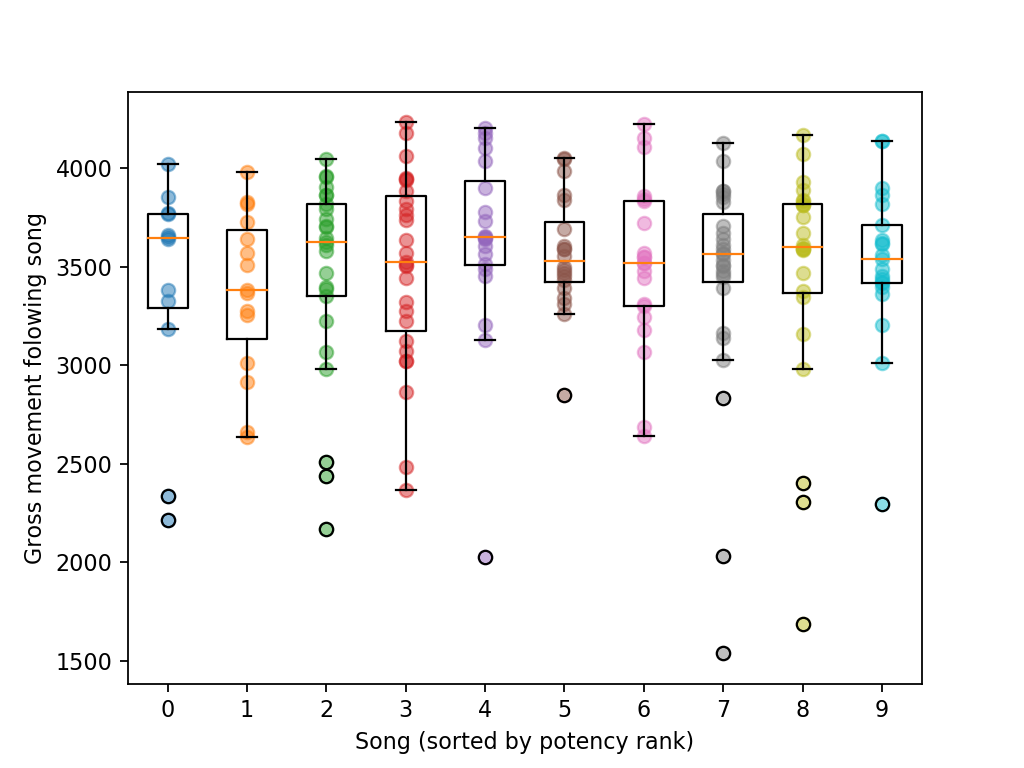

In [410]:
fig,ax = plt.subplots()

for s in range(n_songs):
    ax.scatter([s] * len(non_movements[s]),non_movements[s],alpha=.5,label=song_list[true_order[s]])
    
ax.boxplot(non_movements,positions=range(n_songs))
ax.set_xlabel('Song (sorted by potency rank)')
ax.set_ylabel('Gross movement folowing song')
fig.show()

In [55]:
## Do some stats on the above plots:

print('No difference in non postures:')
print(f_oneway(non_movements[0],non_movements[1],non_movements[2],non_movements[3],
              non_movements[4],non_movements[5],non_movements[6],non_movements[7],
               non_movements[8],non_movements[9]))

print('No difference in partial postures:')
print(f_oneway(partial_movements[0],partial_movements[1],
               partial_movements[3],partial_movements[4],partial_movements[5],
               partial_movements[6],partial_movements[7],partial_movements[8],
               partial_movements[9]))

No difference in non postures:


NameError: name 'non_movements' is not defined